In [38]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

##### ! Run this script cell by cell - the df gets reread into the notebook in certain cells so running the whole script will not work
##### ! Change the path accordingly

In [5]:
reddit_name = "politicsdebate"


CASH_PATH = "C:/Users/peapo/DataSci_Project/DataScienceProject"
MERT_PATH = "/Users/merterol/Desktop/UZH/CompLing:CompSci/CompSci/Sem2/ESC403/ESC403_Project/DataScienceProject/"
# CHANGE THIS
OWNER_PATH = CASH_PATH
#

MERGED = f"{OWNER_PATH}/visuals/df_csv/{reddit_name}_df_merged.csv"

Event Ranges with margins before and after

In [40]:

df = pd.read_csv(MERGED)
#df = pd.read_csv(f"Visuals/df_csv/{reddit_name}_df_merged.csv")
#C:\Users\peapo\DataSci_Project\DataScienceProject\Visuals\df_csv\theworldnews_df_merged.csv
df["Date"] = pd.to_datetime(df["Date"])

events = {
    "COVID-19 Pandemic": ("2020-03-01", "2021-03-01"),
    "Ukraine Conflict": ("2022-01-15", "2023-09-01"),
    "Biden Election Period": ("2020-11-01", "2022-01-01"),
    "Trump Election Period": ("2016-11-01", "2020-12-31"),
    "GTA 5 Release": ("2013-09-01", "2013-10-30"),
    "Snowden Leak": ("2013-06-01", "2013-07-01"),
    "Palestine": ("2023-10-01", "2024-05-01"),
    "Turkey Earthquake" : ("2023-01-01", "2023-04-01"),
    "Arab Spring" : ("2010-12-01", "2012-12-01")
}


for event, (start, end) in events.items():
    start, end = pd.to_datetime(start), pd.to_datetime(end)
    df[event] = df["Date"].apply(lambda x: start <= x <= end)

Getting Sentiment Data

In [41]:
event_sentiment_summary = {}
for event in events:
    event_data = df[df[event]]
    non_event_data = df[~df[event]]
    event_avg = event_data["Polarity"].mean()
    non_event_avg = non_event_data["Polarity"].mean()
    event_sentiment_summary[event] = (event_avg, non_event_avg)

# Display the results
for event, (event_avg, non_event_avg) in event_sentiment_summary.items():
    print(f"{event}: During Event Avg Polarity = {event_avg:.3f}, Outside Event Avg Polarity = {non_event_avg:.3f}")


COVID-19 Pandemic: During Event Avg Polarity = 0.058, Outside Event Avg Polarity = 0.070
Ukraine Conflict: During Event Avg Polarity = 0.076, Outside Event Avg Polarity = 0.067
Biden Election Period: During Event Avg Polarity = 0.049, Outside Event Avg Polarity = 0.074
Trump Election Period: During Event Avg Polarity = 0.061, Outside Event Avg Polarity = 0.072
GTA 5 Release: During Event Avg Polarity = 0.112, Outside Event Avg Polarity = 0.069
Snowden Leak: During Event Avg Polarity = 0.071, Outside Event Avg Polarity = 0.069
Palestine: During Event Avg Polarity = nan, Outside Event Avg Polarity = 0.069
Turkey Earthquake: During Event Avg Polarity = nan, Outside Event Avg Polarity = 0.069
Arab Spring: During Event Avg Polarity = 0.027, Outside Event Avg Polarity = 0.069


#### Visualizing Sentiment Data

In [42]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import Span, Label, Legend, LegendItem
import pandas as pd

output_notebook()

Loading BokehJS ...

In [43]:
events = {
    # "Event name" : ("start date", "end date", "color for start", "color for end")
    "COVID-19 Pandemic": ("2020-03-01", "2021-03-01", "#1f77b4", "#aec7e8"),  # blue tones
    "Ukraine Conflict": ("2022-01-15", "2023-09-01", "#ff7f0e", "#ffbb78"),  # orange tones
    "Biden Election Period": ("2020-11-01", "2022-01-01", "#2ca02c", "#98df8a"),  # green tones
    "Trump Election Period": ("2016-11-01", "2020-12-31", "#d62728", "#ff9896"),  # red tones
    "GTA 5 Release": ("2013-09-01", "2013-10-30", "#9467bd", "#c5b0d5"),  # purple tones
    "Snowden Leak": ("2013-06-01", "2013-07-01", "#8c564b", "#c49c94"),  # brown tones
    "Palestine": ("2023-10-01", "2024-05-01", "#e377c2", "#f7b6d2"),  # pink tones
    "Turkey Earthquake": ("2023-01-01", "2023-04-01", "#7f7f7f", "#c7c7c7"),  # grey tones
    "Arab Spring": ("2010-12-01", "2012-12-01", "#bcbd22", "#dbdb8d")  # yellow-green tones
}


for event in events:
    start_date, end_date, start_color, end_color = events[event]
    events[event] = (pd.to_datetime(start_date), pd.to_datetime(end_date), start_color, end_color)


In [44]:
# Create a Bokeh plot
p = figure(title="Sentiment Polarity Over Time with Event Markers",
            x_axis_label="Date", y_axis_label="Polarity",
            x_axis_type="datetime", width=1400, height=600,
            tools="pan,wheel_zoom,box_zoom,reset,save")

# Add a line renderer for daily polarity
p.line(df["Date"], df["Polarity"], legend_label="Daily Polarity", line_width=4, color="blue", alpha=0.5)

# Prepare for legend items
legend_items = []

# Process each event
for event, (start_date, end_date, start_color, end_color) in events.items():
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Add start and end lines using thin lines
    p.line([start_date, start_date], [min(df["Polarity"]), max(df["Polarity"])], 
            line_width=4, color=start_color, legend_label=f"{event} Start")
    p.line([end_date, end_date], [min(df["Polarity"]), max(df["Polarity"])], 
            line_width=4, color=end_color, legend_label=f"{event} End")

# Show the plot
show(p)

## ARIMA

In [45]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [46]:
#df = pd.read_csv(f"C:/Users/peapo/DataSci_Project/DataScienceProject/Visuals/df_csv/{reddit_name}_df_merged.csv")
df = pd.read_csv(f"/Users/merterol/Desktop/UZH/CompLing:CompSci/CompSci/Sem2/ESC403/ESC403_Project/DataScienceProject/visuals/df_csv/{reddit_name}_df_merged.csv")
#C:/Users/peapo/DataSci_Project/DataScienceProject/Visuals
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

# Assuming "Polarity" is the column with sentiment scores
ts = df["Polarity"]

ARIMA requires the time series to be stationary. 

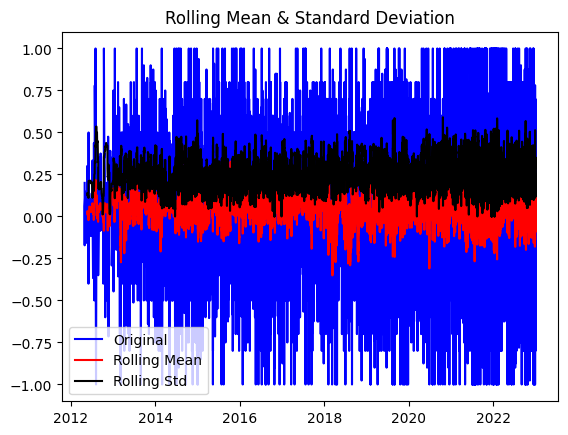

Results of Dickey-Fuller Test:
Test Statistic                -1.637953e+01
p-value                        2.760133e-29
#Lags Used                     4.900000e+01
Number of Observations Used    2.733800e+04
Critical Value (1%)           -3.430589e+00
Critical Value (5%)           -2.861646e+00
Critical Value (10%)          -2.566826e+00
dtype: float64


In [47]:
def test_stationarity(timeseries):
    # Rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()

    # Plot rolling statistics:
    plt.plot(timeseries, color="blue", label="Original")
    plt.plot(rolling_mean, color="red", label="Rolling Mean")
    plt.plot(rolling_std, color="black", label="Rolling Std")
    plt.legend(loc="best")
    plt.title("Rolling Mean & Standard Deviation")
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test:")
    df_test = adfuller(timeseries, autolag="AIC")
    df_output = pd.Series(df_test[0:4], index=["Test Statistic","p-value","#Lags Used","Number of Observations Used"])
    for key, value in df_test[4].items():
        df_output["Critical Value (%s)" % key] = value
    print(df_output)

test_stationarity(ts)

Make the Series Stationary (if needed)

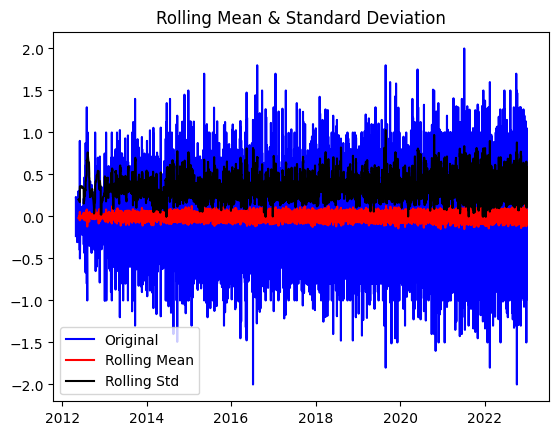

Results of Dickey-Fuller Test:
Test Statistic                   -40.198292
p-value                            0.000000
#Lags Used                        48.000000
Number of Observations Used    27338.000000
Critical Value (1%)               -3.430589
Critical Value (5%)               -2.861646
Critical Value (10%)              -2.566826
dtype: float64


In [48]:
ts_diff = ts - ts.shift()
ts_diff.dropna(inplace=True)
test_stationarity(ts_diff)

Model Selection: determine the ARIMA parameters

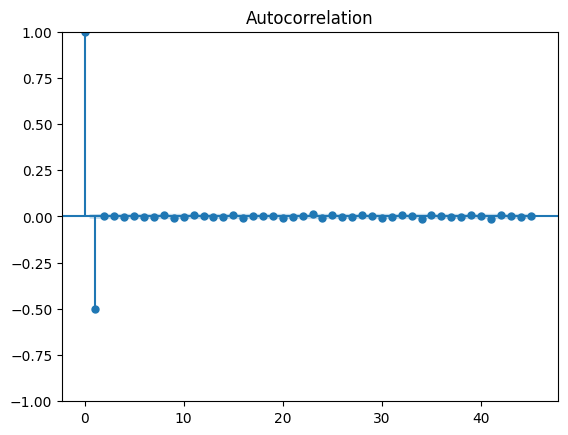

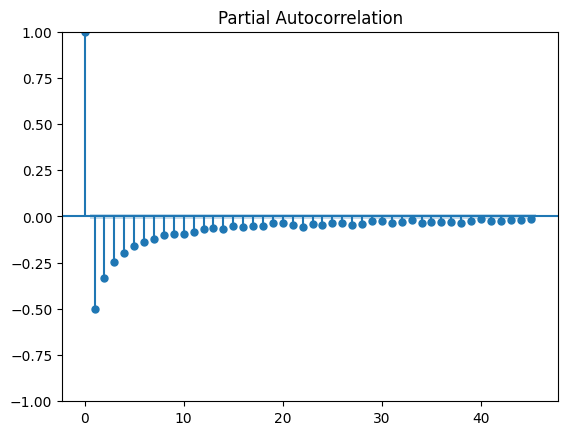

In [49]:
plot_acf(ts_diff)  # To identify the MA(q) order
plot_pacf(ts_diff) # To identify the AR(p) order
plt.show()

                               SARIMAX Results                                
Dep. Variable:               Polarity   No. Observations:                27388
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1617.376
Date:                Tue, 14 May 2024   AIC                           3242.751
Time:                        20:07:29   BIC                           3275.623
Sample:                             0   HQIC                          3253.345
                              - 27388                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0685      0.006     10.554      0.000       0.056       0.081
ar.L1          0.9965      0.001   1204.060      0.000       0.995       0.998
ma.L1         -0.9853      0.002   -608.872      0.0

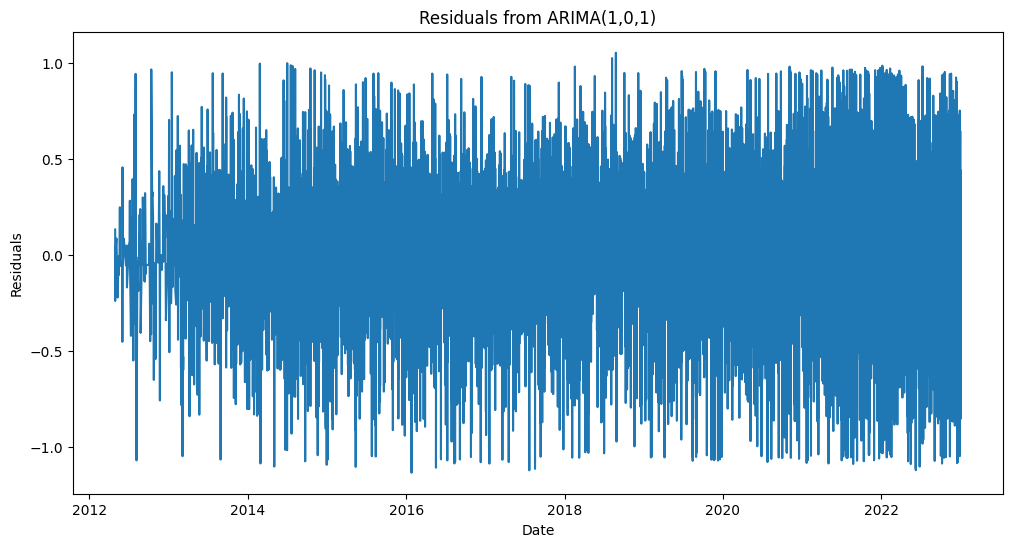

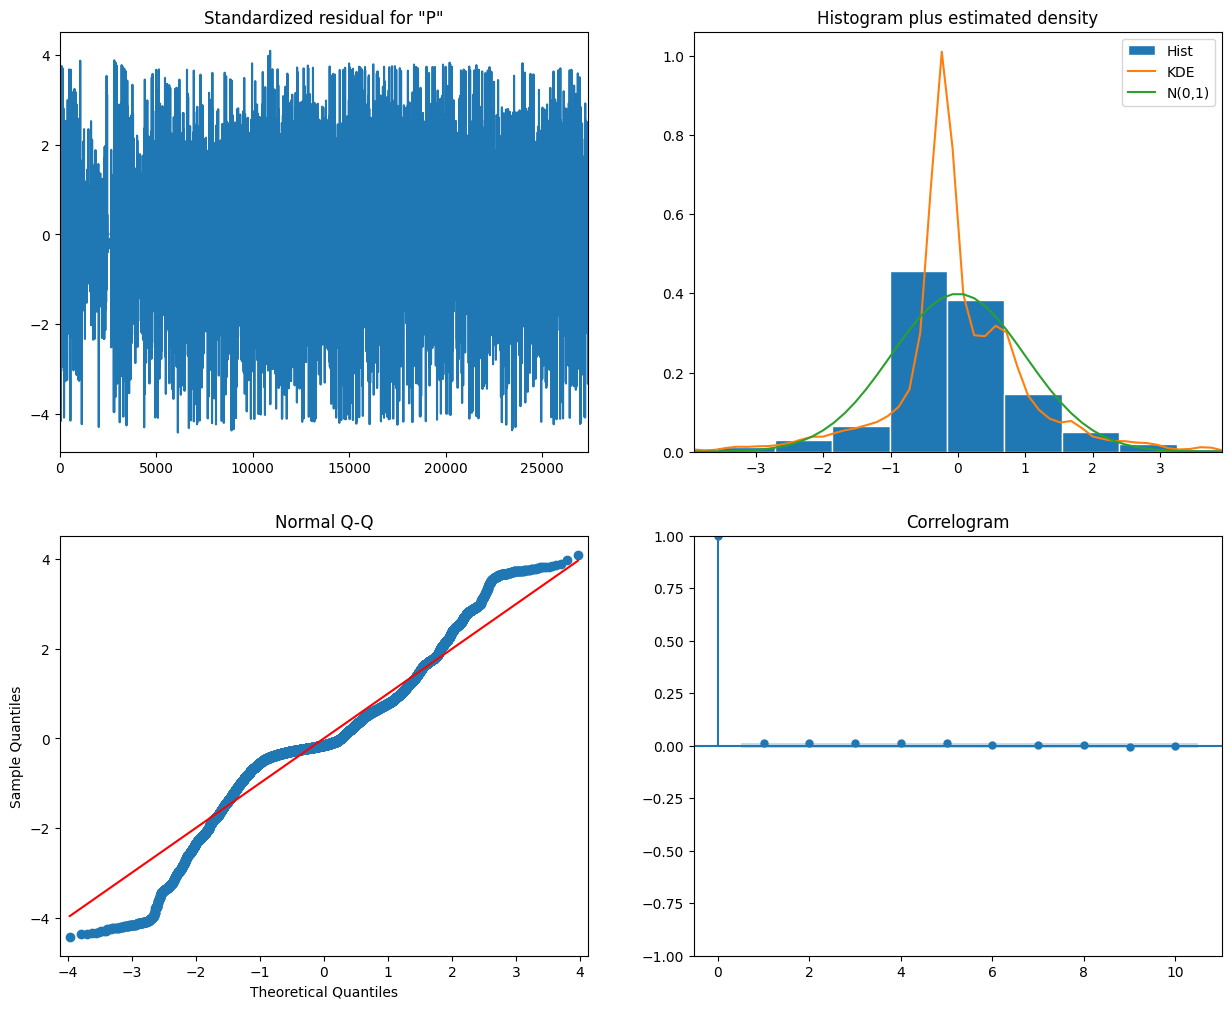

In [50]:
model = ARIMA(ts, order=(1,0,1))  # replace p, d, q with your identified parameters
results = model.fit()
print(results.summary())

residuals = results.resid
plt.figure(figsize=(12,6))
plt.plot(residuals)
plt.title("Residuals from ARIMA(1,0,1)")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.show()

# Optionally, plot diagnostic plots
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [51]:
forecast = results.forecast(steps=10)  # forecast next 10 data points
print(forecast)

27388    0.046407
27389    0.046484
27390    0.046562
27391    0.046639
27392    0.046716
27393    0.046793
27394    0.046869
27395    0.046945
27396    0.047021
27397    0.047097
Name: predicted_mean, dtype: float64


## Random Forests

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [53]:
df = pd.read_csv(MERGED)

df["Date"] = pd.to_datetime(df["Date"])

events = {
    # "Event name" : ("start date", "end date", "color for start", "color for end")
    "COVID-19 Pandemic": ("2020-03-01", "2021-03-01"),
    "Ukraine Conflict": ("2022-01-15", "2023-09-01"),
    "Biden Election Period": ("2020-11-01", "2022-01-01"),
    "Trump Election Period": ("2016-11-01", "2020-12-31"),
    "GTA 5 Release": ("2013-09-01", "2013-10-30"),
    "Snowden Leak": ("2013-06-01", "2013-07-01"),
    "Palestine": ("2023-10-01", "2024-05-01"),
    "Turkey Earthquake": ("2023-01-01", "2023-04-01"),
    "Arab Spring": ("2010-12-01", "2012-12-01")
}



for event, (start, end) in events.items():
    start, end = pd.to_datetime(start), pd.to_datetime(end)
    df[event] = df["Date"].apply(lambda x: start <= x <= end)

In [16]:
if "Date" in df.columns:
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Day"] = df["Date"].dt.day
    df.drop("Date", axis=1, inplace=True)
    
df.dtypes

AttributeError: Can only use .dt accessor with datetimelike values

In [55]:
# "COVID-19 Pandemic", "Ukraine Conflict", "Biden Election Period", "Trump Election Period", "GTA 5 Release", "Snowden Leak"
X = df.drop(["Subjectivity", "Text"], axis=1)
y = df["Polarity"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Training the model
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [56]:
y_pred = regressor.predict(X_test)
df['Predicted_Polarity'] = regressor.predict(X)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
accuracy = regressor.score(X_test, y_test)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print(f"Model Accuracy: {accuracy}")

Mean Squared Error: 1.3204626301703912e-07
R-squared: 0.999998048759504
Model Accuracy: 0.999998048759504


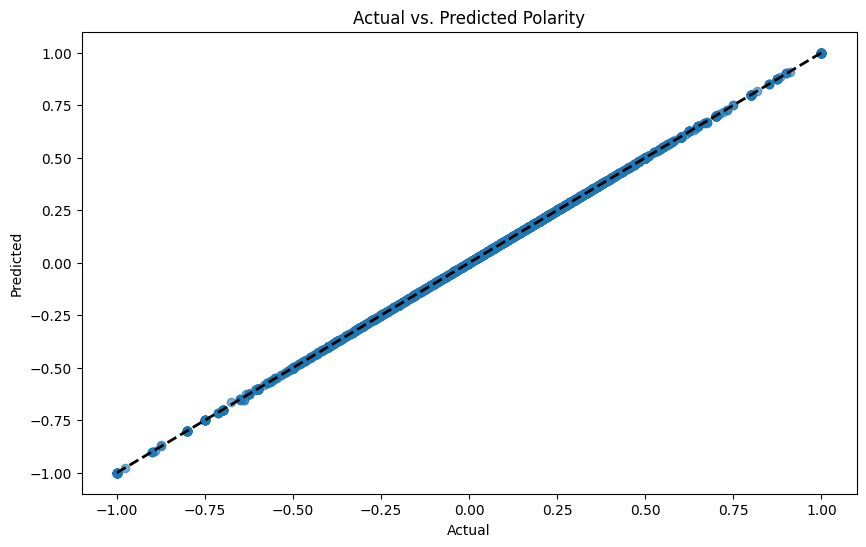

In [57]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw=2)  # Line showing perfect predictions
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted Polarity")
plt.show()

### Support Vector Machine

In [87]:
from sklearn.svm import SVR
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import pandas as pd

from sklearn.linear_model import SGDClassifier

def classify_polarity(polarity):
    if polarity < -0.5:
        return 'Very Negative'
    elif polarity < 0:
        return 'Negative'
    elif polarity == 0:
        return 'Neutral'
    elif polarity < 0.5:
        return 'Positive'
    else:
        return 'Very Positive'


In [88]:
df = pd.read_csv(MERGED)

# Fill NaN values in "Text" with empty strings
df["Text"] = df["Text"].fillna("")
df["Date"] = pd.to_datetime(df["Date"])

df[["Subjectivity","Polarity"]].replace({'': 0.0}, inplace=True)

df[["Subjectivity","Polarity"]] = df[["Subjectivity","Polarity"]].astype(float)

"""
df["Subjectivity"] = float(df["Subjectivity"])
df["Polarity"] = float(df["Polarity"])

"""
if "Date" in df.columns:
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Day"] = df["Date"].dt.day
    df.drop("Date", axis=1, inplace=True)


# Proceed with TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(df["Text"])

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)

df.describe()

Polarity  Subjectivity          Year         Month           Day
count  59096.000000  59096.000000  59096.000000  59096.000000  59096.000000
mean       0.057218      0.399538   2019.495042      6.060072     15.752048
std        0.220029      0.257224      1.340262      3.459210      8.835157
min       -1.000000      0.000000   2011.000000      1.000000      1.000000
25%       -0.002019      0.225000   2019.000000      3.000000      8.000000
50%        0.017857      0.438493   2020.000000      6.000000     16.000000
75%        0.155556      0.560000   2020.000000      9.000000     23.000000
max        1.000000      1.000000   2022.000000     12.000000     31.000000

In [103]:
# Combine the TF-IDF features with the other features in the original DataFrame
combined_df = pd.concat([df.drop(["Text"], axis=1), tfidf_df], axis=1)

combined_df["Polarity"] = combined_df["Polarity"].apply(classify_polarity)
# "Polarity" is the target variable
X = combined_df.drop(["Polarity"], axis=1)
y = combined_df["Polarity"]

classes = np.unique(combined_df["Polarity"])


# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



In [105]:
def data_chunker(X,y, chunksize=10):

    size = len(X)


    for i in range(0, size, chunksize):
        df_x = X.iloc[i:i+chunksize]
        df_y = y.iloc[i:i+chunksize]

        print(f"CHUNK: {i}")
#        print(df_x)
        yield (df_x, df_y)
    return


df.head()


Polarity  Subjectivity                                               Text  \
0  0.000000      0.000000                                     troll | trolol   
1  0.000000      0.000000      Debate here | DO YOUR POLItCIAL DEBATES HERE!   
2  0.437500      0.562500  Gay Marraige | Are there any redditors who don...   
3 -0.116667      0.127778  Marijuana | What r both sides of the political...   
4  0.000000      0.050000  Occupy wall street and tea party | what are co...   

   Year  Month  Day  
0  2011     11   16  
1  2011     11   16  
2  2011     12    4  
3  2011     12    4  
4  2011     12    4

In [106]:
#print(X_train)



svr = SGDClassifier()

for ix,iy in data_chunker(X_train, y_train, chunksize=10):
    svr.partial_fit(ix,iy, classes=classes)

#svr = SVR(kernel="rbf")
#svr.fit(X_train, y_train)

# Prediction and evaluation
y_pred = svr.predict(X_test)

CHUNK: 0
CHUNK: 10
CHUNK: 20
CHUNK: 30
CHUNK: 40
CHUNK: 50
CHUNK: 60
CHUNK: 70
CHUNK: 80
CHUNK: 90
CHUNK: 100
CHUNK: 110
CHUNK: 120
CHUNK: 130
CHUNK: 140
CHUNK: 150
CHUNK: 160
CHUNK: 170
CHUNK: 180
CHUNK: 190
CHUNK: 200
CHUNK: 210
CHUNK: 220
CHUNK: 230
CHUNK: 240
CHUNK: 250
CHUNK: 260
CHUNK: 270
CHUNK: 280
CHUNK: 290
CHUNK: 300
CHUNK: 310
CHUNK: 320
CHUNK: 330
CHUNK: 340
CHUNK: 350
CHUNK: 360
CHUNK: 370
CHUNK: 380
CHUNK: 390
CHUNK: 400
CHUNK: 410
CHUNK: 420
CHUNK: 430
CHUNK: 440
CHUNK: 450
CHUNK: 460
CHUNK: 470
CHUNK: 480
CHUNK: 490
CHUNK: 500
CHUNK: 510
CHUNK: 520
CHUNK: 530
CHUNK: 540
CHUNK: 550
CHUNK: 560
CHUNK: 570
CHUNK: 580
CHUNK: 590
CHUNK: 600
CHUNK: 610
CHUNK: 620
CHUNK: 630
CHUNK: 640
CHUNK: 650
CHUNK: 660
CHUNK: 670
CHUNK: 680
CHUNK: 690
CHUNK: 700
CHUNK: 710
CHUNK: 720
CHUNK: 730
CHUNK: 740
CHUNK: 750
CHUNK: 760
CHUNK: 770
CHUNK: 780
CHUNK: 790
CHUNK: 800
CHUNK: 810
CHUNK: 820
CHUNK: 830
CHUNK: 840
CHUNK: 850
CHUNK: 860
CHUNK: 870
CHUNK: 880
CHUNK: 890
CHUNK: 900
CHUNK: 910

In [107]:
# Calculate and print the metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
accuracy = svr.score(X_test, y_test)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print(f"Model Accuracy: {accuracy}")

ValueError: could not convert string to float: 'Positive'

we got an extremly high MSE hence why we want to get the baseline first and then change the kernel and max_features accordingly
1. linear --> MSE extremly high
2. rbf --> MSE close to baseline

In [108]:
mean_polarity = y_train.mean()
baseline_preds = [mean_polarity] * len(y_test)
baseline_mse = mean_squared_error(y_test, baseline_preds)
print("Baseline MSE:", baseline_mse)

TypeError: Could not convert string 'NegativePositiveNegativeNegativeNeutralPositiveNeutralVery PositivePositivePositiveNeutralPositiveNeutralPositivePositiveVery PositivePositiveNeutralNeutralVery PositivePositivePositiveNegativePositiveNegativeNegativeNeutralNeutralPositivePositiveVery NegativeNeutralPositiveNeutralNeutralNegativeNegativeNegativePositiveNeutralPositivePositiveNegativePositivePositivePositivePositivePositivePositivePositiveNegativePositiveNegativeNegativePositivePositivePositiveNeutralNegativeNegativeNegativePositiveNeutralPositiveNeutralPositivePositivePositiveNegativeVery PositivePositivePositivePositivePositiveNegativeNeutralVery PositivePositivePositivePositiveNegativePositiveNeutralPositiveNeutralPositivePositiveNeutralPositiveNegativePositiveNeutralPositivePositiveNeutralPositivePositivePositivePositiveNeutralPositivePositiveNegativePositivePositivePositiveNeutralPositiveNegativeNeutralPositivePositiveNeutralPositiveNeutralNegativeNeutralNegativeNeutralNegativePositiveNeutralVery PositivePositivePositivePositiveNegativeNeutralNegativePositivePositiveNeutralPositivePositiveNegativePositiveNeutralNegativeNegativeNegativePositivePositiveNeutralPositivePositivePositivePositiveNegativePositiveNeutralPositiveNegativePositiveNegativeVery NegativeNeutralVery PositivePositiveNeutralPositiveNegativeVery PositiveNeutralNeutralPositiveNeutralNeutralPositivePositivePositivePositiveNeutralNeutralPositiveVery PositivePositivePositiveNeutralPositivePositiveNegativePositiveNeutralNeutralNeutralVery PositivePositiveNegativePositivePositiveNegativeNeutralPositiveNeutralNegativeNegativeNeutralNeutralNegativePositivePositivePositiveNegativeNeutralPositivePositiveNeutralPositivePositiveNegativeNegativePositivePositivePositiveVery PositivePositivePositiveNegativeNeutralPositivePositivePositivePositiveNegativeNeutralPositiveNegativePositiveNegativePositivePositiveNegativePositiveNeutralNegativeNeutralPositivePositivePositiveNeutralVery NegativeNegativeNegativeVery PositivePositiveVery PositivePositivePositiveNegativePositivePositivePositiveNegativePositiveNeutralPositivePositiveNeutralNeutralNeutralPositiveNeutralNeutralVery PositivePositivePositiveNeutralNegativeNegativePositivePositivePositiveNegativeVery NegativeNeutralPositivePositiveVery PositivePositivePositivePositiveNegativePositiveVery PositiveVery PositiveNeutralNegativePositivePositivePositiveNeutralVery PositivePositivePositiveNegativeNeutralNegativePositivePositivePositivePositivePositivePositivePositivePositivePositiveNegativeNegativeNegativeNeutralNeutralPositivePositiveNeutralNeutralPositiveNeutralNeutralPositivePositivePositivePositiveNegativePositiveNegativePositivePositivePositiveNeutralNeutralNegativeNegativeNegativeNegativePositiveVery PositiveVery PositivePositivePositiveNeutralPositivePositivePositiveNeutralVery NegativePositivePositiveNeutralPositiveNegativeNeutralPositivePositiveNeutralNegativeNegativePositiveNeutralNegativeVery PositivePositiveNegativePositivePositivePositiveNegativePositivePositivePositivePositivePositiveVery NegativePositiveNeutralNeutralNegativePositiveNeutralPositiveVery PositiveNeutralNegativeNeutralVery NegativePositivePositiveNeutralPositivePositivePositivePositiveNeutralPositivePositiveNeutralNeutralPositiveNeutralPositivePositivePositivePositiveNeutralPositiveNegativePositiveNeutralPositiveVery NegativePositiveNeutralNegativePositivePositivePositivePositivePositiveNeutralNegativePositivePositiveNegativePositiveNeutralNegativeNeutralPositivePositivePositiveNeutralPositivePositivePositiveNegativeNeutralPositivePositivePositiveNeutralNeutralPositivePositivePositiveNegativePositivePositiveNeutralPositiveNegativeNeutralPositivePositivePositivePositivePositivePositiveVery PositiveNeutralNeutralPositivePositivePositivePositivePositiveVery PositivePositivePositiveNegativeVery PositivePositivePositivePositivePositiveNegativeNegativePositiveNeutralVery NegativeNeutralNegativeNeutralPositiveNeutralNeutralPositivePositiveVery PositiveNeutralPositiveNegativePositiveNegativePositiveNegativeNegativeNeutralPositiveNeutralVery NegativePositiveNeutralVery PositiveNegativeVery NegativePositiveNegativePositiveNegativeNegativePositivePositiveNeutralNeutralPositiveVery PositivePositivePositiveNegativeNeutralPositivePositivePositiveNeutralPositiveNeutralPositivePositivePositivePositiveNegativePositiveNegativePositiveNeutralNegativeNegativePositivePositiveNegativePositivePositiveNeutralPositivePositiveVery PositivePositiveNeutralNegativeVery PositiveNegativePositiveVery PositiveNeutralNegativeNegativePositiveNeutralNeutralNegativeVery PositivePositivePositiveNeutralPositivePositivePositiveNeutralPositiveNegativePositivePositivePositivePositivePositiveNegativeNegativeVery PositiveVery PositivePositiveNegativeNegativeNeutralPositiveNeutralNegativePositiveNeutralPositivePositiveNeutralNeutralPositiveNeutralPositivePositiveNeutralNegativeNeutralPositivePositivePositiveNeutralPositivePositivePositivePositivePositiveNegativeNegativeNegativePositivePositiveNegativeNegativeNeutralNegativePositivePositiveNeutralNegativeNegativePositiveNegativePositiveNegativePositiveNegativePositiveNegativePositivePositivePositivePositiveNegativeNegativeNeutralNegativeNeutralPositiveNeutralNegativePositivePositiveNeutralNeutralPositivePositiveNegativeVery PositivePositiveNegativePositivePositiveVery PositivePositivePositivePositivePositivePositivePositivePositivePositiveNegativePositiveNegativePositivePositivePositivePositiveNeutralNeutralVery PositivePositiveNeutralNeutralNegativeNegativePositivePositiveNeutralPositivePositiveNeutralPositiveNeutralPositivePositivePositivePositiveNegativeNegativePositivePositiveNegativeVery PositiveNeutralNeutralNegativeNegativePositivePositivePositivePositiveVery PositiveNegativePositiveNegativePositivePositiveNeutralVery PositiveNeutralNegativePositiveNeutralPositiveVery NegativeNeutralNeutralNegativeVery PositivePositivePositiveNegativePositivePositiveNegativeNeutralVery PositivePositivePositiveNeutralNegativePositiveNegativeNeutralNegativePositivePositivePositiveNegativeVery NegativeVery NegativeNeutralPositivePositiveVery PositivePositivePositiveNegativePositiveNegativePositiveNegativeNeutralPositiveNeutralPositivePositiveVery PositiveNeutralNegativePositivePositiveNegativePositiveNegativePositivePositiveNeutralNeutralPositiveVery PositiveNegativeNeutralPositivePositivePositivePositiveNegativePositiveNegativeNegativeNeutralNeutralVery PositiveNeutralNegativeNeutralVery NegativeNegativeNegativeVery PositivePositiveNegativeNeutralNeutralNeutralPositiveNegativeNeutralNeutralPositivePositiveNeutralNeutralNeutralPositiveNeutralNeutralPositiveNeutralNegativePositivePositivePositiveNeutralNegativeNeutralPositiveNeutralPositiveVery PositiveNegativeNegativePositiveNeutralNegativeNegativePositivePositivePositiveVery PositiveNeutralPositivePositiveNegativeNegativePositiveNegativePositiveNeutralNegativePositiveNeutralNeutralNeutralPositivePositiveNegativePositiveNeutralVery PositivePositiveNeutralPositiveNeutralPositivePositiveNeutralPositiveNeutralPositivePositivePositiveNegativePositivePositiveNeutralNeutralNegativeNegativeNegativeNegativePositivePositiveNeutralNeutralNeutralNeutralPositiveNeutralNegativeNegativePositivePositivePositivePositiveNegativePositiveNegativeVery PositiveNeutralVery NegativePositivePositiveNegativePositiveNeutralNeutralNeutralPositiveNegativePositivePositivePositivePositiveNeutralNeutralPositiveNegativePositivePositiveNegativeNegativeNegativeNegativePositiveNegativeVery PositiveNegativePositiveNegativePositivePositivePositivePositiveNegativePositivePositiveNegativeNeutralPositiveNeutralNeutralVery PositiveNeutralNeutralNeutralPositivePositivePositiveNegativeNeutralNegativeNegativePositiveNegativeNeutralNegativeNeutralNegativeNegativeNeutralPositivePositiveNeutralVery PositiveNegativePositivePositivePositiveNeutralNegativePositiveNeutralNeutralNeutralNeutralPositivePositivePositivePositivePositiveNeutralNegativePositivePositiveNeutralNegativePositivePositivePositiveNeutralVery PositivePositiveVery NegativeNegativeNegativePositivePositivePositiveNegativeNeutralPositiveNeutralNeutralNeutralPositiveNeutralPositiveVery NegativePositiveNeutralPositiveNeutralPositiveNeutralNeutralPositiveNeutralPositivePositiveNegativePositivePositiveNeutralPositivePositiveNegativePositiveVery PositiveNegativeNegativeNegativePositiveNeutralNeutralPositiveNegativeNegativePositiveVery PositiveVery PositivePositiveNeutralNeutralNeutralNegativePositiveNeutralPositiveNeutralNeutralPositivePositiveVery PositiveNegativeVery NegativePositivePositivePositiveNeutralNegativeVery PositiveNeutralPositiveNeutralNegativePositivePositiveNeutralNegativePositiveVery NegativeNegativePositivePositiveNegativeNegativeNegativePositiveNeutralPositiveNeutralNegativeNegativeNegativeNegativePositivePositiveNegativePositivePositivePositiveNegativeNegativePositivePositiveNeutralNegativePositivePositivePositivePositiveNeutralNegativeNegativePositivePositiveNegativePositivePositivePositiveNegativeNegativePositiveNegativePositivePositiveNegativePositiveNegativeNeutralNegativePositiveNegativeNegativePositivePositiveNeutralVery NegativePositivePositiveNegativeNegativePositivePositiveNeutralPositivePositiveNeutralNegativeNeutralPositivePositivePositiveNegativePositivePositivePositiveVery PositivePositivePositiveNeutralNeutralNeutralVery NegativeNegativeNegativeNeutralPositivePositivePositiveNeutralNeutralVery PositivePositiveNeutralPositiveNeutralPositiveNegativeNegativePositiveNeutralPositiveNegativePositivePositivePositiveNeutralVery NegativePositiveNegativePositiveNegativePositiveNeutralPositiveNeutralNeutralNegativeNeutralPositiveNegativeNeutralVery NegativePositivePositiveNeutralNeutralNegativePositiveNegativeNegativePositivePositiveNegativePositivePositiveNeutralPositiveNeutralNegativePositivePositivePositiveNeutralPositivePositiveVery PositivePositiveNegativePositiveNeutralPositiveNeutralNegativePositiveNegativeNegativeNegativePositivePositivePositiveNeutralNeutralNeutralVery PositivePositivePositivePositiveNeutralVery PositiveNegativePositiveNegativeNegativeNeutralNeutralPositivePositiveNeutralNeutralPositiveNeutralNegativePositiveVery PositivePositiveNegativePositivePositivePositiveNegativePositivePositiveNeutralPositiveNegativePositivePositivePositivePositivePositiveNegativeNeutralNeutralNegativeNegativeNegativeNegativeNegativePositivePositivePositiveVery NegativePositivePositivePositivePositiveVery PositivePositivePositiveNeutralPositiveNeutralPositiveNegativePositivePositivePositiveNeutralPositivePositivePositiveNeutralNegativePositiveNegativeNeutralNeutralPositiveNegativePositivePositiveNegativeNegativeNeutralNegativeNegativePositivePositivePositiveNegativePositivePositiveVery PositiveNeutralNeutralNeutralPositiveNegativePositiveVery PositiveVery PositivePositiveNegativePositiveNeutralNegativeNegativePositiveNegativeNeutralPositivePositivePositivePositivePositivePositivePositiveNeutralPositiveNegativeVery PositiveNegativeNegativePositiveNegativePositivePositiveNegativePositivePositivePositivePositivePositivePositivePositivePositivePositiveNegativeNeutralPositivePositivePositiveNeutralPositiveVery PositivePositiveNegativePositiveNegativeNegativeNeutralNegativePositiveNegativeNegativePositivePositivePositiveNeutralPositiveNegativePositivePositiveNeutralNegativePositivePositivePositiveNeutralPositivePositivePositiveNegativeNegativeNeutralVery PositivePositivePositiveNegativeNeutralNegativePositiveVery NegativeNegativeNeutralVery PositivePositivePositivePositiveNegativePositivePositiveNegativeNegativeNeutralNeutralNeutralPositivePositiveNeutralPositivePositiveNeutralNegativePositivePositiveNegativePositivePositivePositiveNegativePositiveNegativePositivePositiveNeutralPositiveNegativeNegativeNegativePositivePositiveNeutralPositivePositivePositiveNegativeNeutralNeutralPositivePositiveNegativePositivePositiveNegativeNegativeNeutralPositivePositiveNegativeNeutralPositiveNegativePositiveNegativeNegativePositivePositiveNeutralVery PositivePositivePositiveNegativeNeutralPositiveNegativeNegativeVery PositiveNeutralPositiveNegativeVery PositivePositiveNegativeVery PositivePositiveNeutralPositiveNegativePositiveNegativeNegativeVery PositivePositivePositivePositiveNegativePositiveNeutralVery PositiveVery PositivePositivePositivePositivePositivePositiveNegativePositiveNeutralPositiveNegativePositivePositiveNegativeNegativeNegativePositiveNegativePositivePositiveNeutralNegativePositiveVery NegativeNegativeNeutralVery PositiveNeutralNeutralPositiveNegativeNeutralPositiveNegativeVery PositivePositivePositiveNegativePositivePositivePositivePositivePositivePositivePositivePositiveNegativeNegativeNeutralNegativePositiveNegativePositivePositiveNeutralVery NegativeNegativePositivePositivePositiveNegativeNeutralPositiveNeutralNeutralPositivePositiveNeutralNegativeNeutralPositivePositivePositiveNeutralNeutralNeutralNegativePositiveNegativeNeutralNegativeVery NegativePositivePositivePositivePositiveNeutralPositivePositivePositiveVery PositiveNegativeNeutralNegativePositiveNegativePositivePositivePositivePositiveVery PositivePositivePositiveNegativePositiveNegativePositiveNegativePositiveNegativeNegativeNegativeNegativePositiveVery PositiveNegativePositivePositivePositivePositiveNeutralVery NegativePositiveVery PositiveNegativePositivePositivePositivePositivePositivePositivePositiveNeutralNegativePositiveNegativePositivePositiveNegativePositivePositiveVery PositiveNeutralNegativePositiveNegativePositiveNeutralPositiveNeutralNegativePositivePositiveNeutralPositiveNegativeNeutralNegativeNeutralPositiveNeutralNeutralNeutralVery PositiveNegativePositiveNegativePositivePositivePositivePositiveNegativePositiveNeutralNegativeNegativePositivePositivePositiveNeutralNeutralNeutralNeutralNeutralNeutralNegativeNeutralPositiveNegativePositivePositiveNegativePositiveNegativeNeutralPositiveNegativePositiveNegativePositivePositivePositiveNeutralPositiveNeutralPositivePositiveNeutralPositivePositivePositivePositiveNeutralPositivePositivePositiveNegativeNegativePositiveNeutralPositivePositivePositiveNegativeNegativePositiveNeutralPositivePositiveNegativeNegativePositiveNegativePositiveNegativePositiveVery PositivePositiveNeutralPositiveNeutralNeutralPositiveNeutralPositiveNeutralPositiveNegativePositiveNeutralNeutralNegativePositiveNegativeNegativePositiveNeutralVery PositivePositiveNegativeNegativeVery PositiveNegativeNegativePositivePositivePositiveNegativePositiveNegativePositivePositiveVery PositiveNegativeNegativePositivePositiveNegativePositivePositivePositivePositiveNegativeNeutralNeutralPositivePositiveVery NegativeNegativeNegativeNeutralNeutralNeutralNegativeNegativeNeutralPositivePositivePositiveNegativeNeutralNeutralNegativePositivePositiveNegativePositiveNeutralNeutralNeutralNegativeNegativeNegativePositiveNegativePositiveNegativePositivePositivePositivePositivePositiveNeutralNegativeNeutralNegativeNegativePositiveNegativeNeutralNegativeNegativePositiveNeutralPositivePositivePositivePositivePositivePositiveNegativeNeutralNegativePositiveNegativePositiveNegativePositivePositiveNegativeNegativeNeutralPositivePositivePositivePositivePositiveNegativeNegativeNegativePositivePositivePositiveNegativeNegativePositivePositiveNeutralPositivePositivePositiveNegativePositiveVery PositiveNegativeNeutralPositiveNegativePositiveNeutralPositiveNegativeNeutralNegativePositivePositivePositiveNegativePositivePositiveNegativePositivePositivePositiveNegativeNegativePositivePositivePositiveNeutralPositivePositiveNeutralNegativeVery PositiveNegativeNegativePositivePositiveNegativeNegativePositiveNeutralPositivePositivePositivePositiveNeutralPositivePositiveNegativeNeutralPositivePositiveNeutralPositiveNegativeNegativePositiveNegativePositivePositiveNeutralPositivePositiveNeutralPositiveNegativePositiveNegativeNegativePositivePositiveNeutralNeutralVery PositiveNegativeNeutralPositiveNeutralPositivePositiveVery PositiveNeutralPositiveNegativeNegativeNeutralPositivePositivePositivePositivePositivePositivePositiveVery NegativeNegativePositiveNeutralPositiveNeutralPositivePositivePositiveNeutralNegativeNegativeNegativePositiveNegativePositivePositiveNegativeNeutralPositivePositiveVery PositivePositivePositiveNegativePositivePositivePositivePositivePositiveNegativeNeutralPositivePositivePositivePositiveNeutralPositiveVery PositivePositiveNeutralNegativePositivePositivePositiveNegativeNegativePositiveNeutralPositiveNeutralNeutralPositiveNegativePositivePositivePositiveNeutralNeutralNeutralNeutralPositivePositiveNegativePositivePositivePositiveNeutralNegativeNeutralPositiveNegativeNeutralPositivePositiveVery NegativePositiveNeutralNegativePositiveNeutralVery PositiveNeutralNeutralPositiveVery PositiveNeutralNeutralPositivePositiveNegativeNegativePositivePositiveNeutralNegativeNegativeNegativeNeutralPositiveNegativePositiveNegativeNegativePositiveNeutralNeutralPositiveNeutralNegativeVery PositiveNegativePositiveNeutralNegativePositivePositivePositiveNeutralNeutralNegativePositivePositivePositivePositivePositivePositivePositiveNeutralNegativeVery PositiveNeutralNeutralNegativePositivePositiveNeutralPositiveNeutralPositivePositiveNegativeNegativePositivePositivePositiveNegativeNeutralVery PositiveNegativePositivePositiveNegativePositivePositiveNegativeNeutralPositivePositivePositivePositivePositiveNegativeNegativePositivePositiveNeutralNegativeNegativeNegativePositivePositiveNegativePositivePositiveNeutralPositiveNeutralPositiveNeutralPositiveNegativePositiveNegativePositiveNegativePositiveNeutralNeutralPositiveNeutralNegativeNegativePositivePositivePositiveNegativePositivePositivePositivePositiveVery PositiveNegativeNegativePositiveNeutralNeutralPositiveNeutralPositiveNegativePositivePositivePositivePositiveNegativeNegativeNegativePositivePositivePositiveNeutralNeutralNeutralNeutralPositivePositivePositiveNeutralPositiveNeutralPositivePositivePositivePositiveNegativeNeutralVery PositiveNegativePositivePositiveNeutralNegativePositiveNegativeNeutralNegativePositivePositivePositiveNeutralPositiveNeutralNeutralNegativePositivePositiveNeutralVery PositivePositiveVery PositivePositivePositivePositiveNeutralVery NegativePositivePositivePositivePositiveNeutralPositiveNeutralPositivePositiveNegativePositiveVery NegativePositivePositiveNegativePositivePositiveNegativePositivePositivePositiveNegativePositivePositiveNeutralPositiveNeutralNegativeNeutralPositiveNegativePositiveNegativeNegativePositivePositiveNeutralPositiveVery PositivePositivePositivePositiveNeutralNegativePositiveVery NegativeNeutralPositiveNeutralPositiveNegativePositiveNegativeNeutralVery PositiveVery PositiveNeutralNegativeNegativeVery PositiveNeutralPositivePositiveNeutralPositivePositiveNeutralPositivePositivePositivePositiveNeutralVery NegativePositiveNeutralPositivePositivePositiveNeutralPositiveNeutralNeutralPositiveNeutralPositivePositiveNegativeNeutralPositiveNegativePositivePositiveNegativePositivePositiveNeutralNeutralNegativeNegativePositivePositivePositiveNeutralPositiveNegativeVery NegativePositivePositiveNegativePositiveNegativeNeutralNeutralPositiveNegativeVery PositivePositiveVery PositiveNeutralNeutralNeutralNeutralPositivePositiveNegativeNegativePositiveNegativePositiveVery PositiveNeutralVery PositivePositivePositivePositivePositiveNegativeNegativeNeutralPositivePositiveVery PositiveNegativePositivePositivePositiveNegativeNeutralPositiveNegativeNegativeNeutralNeutralNeutralVery PositivePositiveNegativeNeutralPositiveNegativePositiveNegativePositiveNegativePositivePositivePositiveVery PositiveNeutralPositiveNegativePositiveNeutralPositiveNegativePositivePositivePositiveNeutralNegativePositiveNeutralPositiveNeutralNegativePositiveVery PositiveNeutralPositivePositiveNeutralPositivePositivePositivePositivePositivePositiveNegativeNegativePositivePositiveNeutralNeutralPositiveVery NegativePositiveNegativeNegativeNegativePositivePositiveNegativeNeutralNegativePositiveNegativeNeutralNeutralNeutralPositivePositivePositiveNegativeNegativeNeutralNegativeNegativePositivePositiveNeutralPositiveNegativeNeutralNegativePositiveNegativePositivePositivePositivePositiveNegativeNeutralPositivePositiveNegativeVery PositivePositiveNeutralNegativeNegativePositiveNegativePositiveNegativeNeutralNeutralNegativeNeutralNegativePositivePositiveNeutralNegativeNeutralNegativePositivePositiveNeutralNegativeNeutralVery PositiveNeutralPositivePositiveVery PositivePositiveNegativePositiveNeutralPositivePositivePositiveNeutralPositivePositiveNegativeNeutralPositivePositiveNeutralNegativePositiveNeutralNeutralNeutralPositiveNegativeNeutralNegativeNeutralVery PositiveNegativeNegativeVery PositiveNeutralNeutralPositivePositivePositiveNeutralNeutralPositivePositiveNeutralPositiveNeutralNegativePositivePositivePositiveNegativePositiveVery PositiveNegativePositivePositivePositivePositiveNegativePositiveVery PositiveVery PositivePositivePositiveNeutralPositivePositiveVery PositiveNeutralVery PositivePositivePositiveVery PositiveNeutralPositiveNeutralPositivePositiveNegativeNegativePositiveVery PositivePositivePositivePositiveNegativeNegativePositivePositiveNeutralNegativePositiveNeutralNegativePositiveNeutralPositivePositivePositiveNegativePositiveNeutralPositivePositivePositivePositivePositivePositivePositivePositivePositivePositiveNegativePositiveNegativeNeutralPositiveNeutralPositiveVery PositiveNegativePositivePositiveNeutralPositivePositiveNegativePositiveNegativeNegativeNegativeNeutralVery NegativePositiveNeutralNegativeNeutralPositiveVery NegativeNeutralPositivePositiveNegativePositivePositiveNeutralPositiveNeutralPositiveNegativeVery NegativeNegativePositivePositivePositiveVery NegativePositivePositiveNeutralPositiveNegativePositivePositivePositivePositiveNegativePositiveNegativeNegativePositivePositivePositivePositiveNeutralNegativePositiveNegativePositivePositivePositiveNeutralPositiveNegativeNegativePositiveNegativeNeutralNegativeNegativeNegativeVery NegativeVery PositivePositiveNeutralPositiveNeutralNeutralNeutralNeutralNeutralNegativeNeutralNegativeNegativeNegativePositiveNeutralNeutralPositiveNeutralNegativePositivePositiveNeutralPositivePositivePositiveNeutralNegativePositivePositivePositiveNegativePositivePositivePositivePositiveNeutralPositiveNegativePositivePositivePositivePositiveNegativeNegativePositivePositiveNeutralNeutralNegativeNegativePositiveNegativePositivePositiveVery PositivePositiveVery PositivePositivePositiveNeutralPositivePositiveNegativePositivePositiveNeutralPositivePositiveNegativePositiveNegativePositiveNegativeNeutralVery PositiveNegativePositiveNegativePositivePositivePositiveNegativePositivePositivePositiveNegativePositivePositiveVery PositiveNegativePositivePositivePositivePositivePositivePositiveVery PositivePositiveNeutralPositiveNeutralNegativePositivePositivePositivePositiveNeutralPositivePositiveNegativePositivePositiveNeutralPositivePositivePositiveNegativePositiveVery NegativePositivePositivePositiveNegativeNegativePositiveNegativeNeutralNegativePositivePositivePositiveNegativeNegativePositivePositivePositiveNeutralPositivePositiveNegativePositivePositiveNeutralPositiveNeutralPositiveNeutralPositiveNegativePositivePositivePositivePositivePositivePositivePositivePositiveNeutralNegativeNeutralNeutralPositiveNeutralNegativePositiveVery PositivePositiveNegativeNeutralNeutralNeutralPositivePositivePositiveNeutralNegativeNeutralPositivePositivePositiveNegativePositiveNeutralPositiveVery PositivePositiveNeutralNeutralPositiveVery PositivePositivePositivePositiveNegativeNeutralPositiveNegativePositiveNegativeVery PositivePositivePositiveNegativePositiveNegativePositivePositiveNegativePositivePositiveVery PositivePositiveNegativeNegativeVery PositiveVery PositivePositivePositiveNeutralNeutralPositiveNegativeNeutralPositiveNegativeNeutralNeutralNegativePositivePositivePositivePositivePositiveNegativePositivePositiveNeutralVery PositiveNegativeVery PositiveNeutralNeutralNegativePositiveVery PositiveVery PositiveNeutralNeutralPositiveVery PositiveNeutralPositivePositiveNeutralNeutralNegativeNegativeNeutralNeutralPositiveNeutralPositivePositivePositivePositivePositivePositiveNeutralNegativeNeutralNegativePositiveVery PositivePositivePositiveVery PositivePositivePositivePositiveNegativeVery NegativeNegativePositivePositivePositivePositivePositiveVery NegativePositivePositivePositivePositiveNegativeVery PositiveVery PositiveVery PositivePositiveNeutralNeutralPositivePositivePositivePositivePositiveNeutralPositivePositiveNegativePositivePositivePositivePositivePositivePositivePositiveNeutralPositivePositiveNeutralPositivePositivePositivePositivePositivePositiveNegativePositiveNeutralNegativeNeutralPositivePositiveNegativePositivePositivePositivePositiveNeutralPositiveNeutralPositivePositivePositiveNegativePositivePositivePositivePositivePositivePositivePositiveVery PositiveVery PositiveNegativePositiveNegativePositiveNeutralNeutralPositiveNeutralNeutralNegativeNeutralPositiveNeutralPositivePositiveNegativeNegativeNegativePositiveNegativeNegativePositivePositivePositiveNegativePositiveNegativeNeutralNegativePositivePositiveVery PositiveNeutralPositiveNegativePositivePositivePositiveNegativePositiveNeutralPositiveNeutralNeutralPositivePositiveNeutralNeutralNegativePositiveNeutralNegativeNegativePositivePositiveNegativeNegativeNeutralPositivePositivePositivePositiveNegativeNeutralNeutralPositivePositiveNegativeNeutralPositivePositivePositiveNegativePositivePositivePositiveNegativeVery PositivePositiveNegativePositiveNegativeNegativePositiveNeutralPositivePositivePositivePositiveNegativeVery PositiveNegativePositivePositivePositivePositivePositiveNeutralNeutralPositivePositiveNeutralPositivePositivePositivePositiveNegativePositiveNeutralNeutralPositiveNegativePositiveNegativePositivePositiveNegativePositivePositivePositiveNeutralVery PositiveNeutralPositiveNegativeNegativePositiveNegativeNegativePositiveNeutralPositivePositiveNegativeNeutralNeutralPositiveNegativeNeutralNeutralPositiveNeutralNegativePositivePositivePositiveNegativePositiveNeutralPositivePositivePositiveNeutralNegativePositivePositiveNeutralNeutralPositivePositivePositiveNegativePositiveNeutralVery PositiveNeutralPositiveVery PositivePositivePositivePositivePositivePositiveNegativePositiveVery PositiveNeutralNeutralNegativeNeutralPositivePositivePositiveNeutralPositiveNeutralNeutralNegativePositiveNeutralPositivePositiveNegativeNegativePositivePositivePositivePositiveNeutralPositivePositiveNegativeNeutralPositivePositiveNegativeNegativeNegativePositivePositivePositivePositiveNegativeNegativeNeutralPositiveNeutralNeutralNegativeNeutralNeutralPositivePositiveNeutralNegativeNeutralPositiveNegativePositiveNegativePositivePositivePositivePositivePositivePositivePositiveNegativePositiveNegativeNeutralPositiveVery PositivePositivePositivePositiveVery NegativeNegativeNegativePositiveNeutralNeutralPositivePositivePositivePositivePositiveVery PositivePositivePositiveVery NegativePositiveNegativeNegativePositiveNegativePositivePositivePositiveNeutralPositiveNegativePositivePositiveNeutralPositiveNeutralPositivePositivePositivePositivePositivePositivePositivePositivePositiveNegativePositivePositiveNeutralPositiveNegativeNeutralNegativeNegativeNegativePositiveNeutralPositiveNeutralPositivePositivePositiveNeutralNeutralPositiveVery PositiveNeutralNeutralPositivePositivePositiveNeutralPositivePositiveVery NegativeNeutralPositiveNeutralPositivePositivePositivePositiveNeutralNegativeNeutralNegativeVery PositivePositivePositiveNegativeNegativePositiveNegativePositiveNegativeNeutralPositivePositivePositiveNeutralPositivePositiveVery PositiveNegativeVery PositivePositiveNeutralPositiveVery PositiveNegativePositiveNeutralNeutralNegativeNegativePositiveNeutralVery PositiveVery NegativePositiveNeutralNeutralPositivePositivePositiveNeutralPositivePositivePositiveNeutralNeutralPositiveNegativePositivePositiveNegativePositivePositiveNeutralNegativeVery PositivePositiveVery PositiveNeutralPositivePositiveNeutralNegativePositivePositivePositivePositiveNegativePositiveNegativePositivePositiveNeutralPositivePositiveNeutralPositiveNeutralPositiveNeutralPositivePositivePositivePositivePositivePositiveNegativePositiveNeutralNegativeNegativeNeutralNegativePositiveVery PositiveNegativeNegativePositiveNegativeNeutralNeutralPositivePositivePositivePositiveVery PositiveNegativePositivePositivePositivePositiveVery PositivePositiveNeutralNegativeNegativePositivePositiveNegativeNegativeNegativeNegativeNeutralNegativeNegativePositivePositiveNeutralNeutralNeutralNegativeNeutralPositiveNeutralNeutralNeutralNeutralNeutralPositivePositivePositivePositiveNeutralPositiveNegativePositivePositiveNeutralPositivePositiveNegativePositiveNeutralPositiveVery PositivePositivePositivePositivePositiveVery PositiveNeutralNegativePositivePositivePositiveNegativePositiveNegativeNegativeNegativeNeutralNeutralPositiveVery PositiveNeutralPositiveNegativePositiveNegativePositiveNegativeNeutralPositivePositivePositiveNegativePositiveNeutralPositivePositivePositivePositivePositiveNeutralPositiveNegativeNegativePositiveNegativeNegativePositiveNegativeNeutralPositiveNegativeNeutralPositiveNegativePositiveNegativeNegativePositiveNegativeNegativePositivePositiveNeutralPositiveNeutralNeutralNeutralPositivePositiveNegativeVery NegativePositiveNeutralNegativePositivePositiveNegativeNeutralNegativeVery NegativePositiveNeutralPositiveNegativePositivePositivePositivePositiveVery PositiveNegativePositiveNeutralPositivePositivePositivePositivePositivePositiveNeutralNeutralNegativePositivePositivePositiveNeutralNeutralPositiveNeutralNegativeNeutralNegativeNegativeNegativeNeutralNegativePositivePositivePositiveNegativePositivePositiveNegativeNeutralPositivePositiveNeutralNeutralPositiveNegativeVery NegativePositivePositiveNeutralNeutralPositivePositiveNegativeNegativePositiveNegativeNegativeNeutralPositivePositivePositivePositivePositivePositiveNeutralPositiveVery PositiveNeutralPositiveNegativePositivePositiveNeutralNegativeNegativeNegativeNegativeNeutralPositiveNegativeNegativeNegativePositiveNeutralNegativePositiveNegativePositiveNegativeNeutralPositiveNeutralPositivePositiveNegativeNeutralPositivePositivePositiveNegativeNegativePositivePositiveNeutralNegativePositiveNegativePositivePositiveNeutralNegativeNeutralPositivePositivePositiveNegativePositivePositivePositiveVery PositiveNeutralNeutralVery PositivePositiveNegativeNegativeVery NegativeNeutralPositiveVery PositiveNegativePositivePositiveNegativeNegativeNegativeNegativeVery NegativePositivePositiveNeutralPositivePositiveNegativeVery NegativeNeutralPositiveNeutralPositivePositivePositiveNegativePositiveNeutralVery NegativeNeutralPositiveNegativeNegativePositiveNeutralNeutralPositiveNeutralNegativeNegativePositivePositiveNegativeNegativeNeutralPositiveVery NegativeNeutralNeutralNeutralNeutralPositiveNegativeNeutralNeutralPositiveNegativePositivePositivePositiveNeutralPositivePositivePositivePositiveNegativeNeutralPositivePositiveNegativeNeutralNeutralNegativePositiveVery PositiveNeutralPositiveNegativeNegativePositiveNeutralNeutralNegativeNegativeVery PositivePositiveNeutralPositiveNegativePositivePositivePositivePositivePositivePositiveNeutralNegativeNeutralPositivePositivePositiveNegativeNeutralPositiveNegativePositivePositivePositivePositivePositiveNeutralPositiveNegativePositiveNegativePositiveNeutralNegativePositiveNeutralNegativePositiveNegativePositivePositiveNeutralNegativeNeutralNegativePositivePositiveNegativeNegativePositiveVery PositiveNegativePositivePositivePositiveNegativePositivePositivePositivePositiveNeutralNeutralNegativeNegativePositivePositivePositiveNegativeNeutralVery NegativeVery PositivePositiveNeutralPositiveNegativePositivePositiveNeutralNegativePositiveNegativePositivePositiveNegativePositiveNeutralPositivePositiveNeutralNeutralPositiveNegativeNeutralPositiveNeutralNegativeVery PositivePositiveNegativeVery PositiveNeutralVery PositivePositiveNeutralPositiveNegativePositiveNegativePositiveNeutralPositivePositivePositiveNegativeNeutralPositiveNeutralPositiveNeutralPositivePositivePositiveNeutralNeutralNegativeNeutralPositivePositiveNegativeNegativeNegativeNegativePositivePositiveNegativePositivePositiveVery PositivePositiveVery PositiveNegativePositiveNegativeNegativePositivePositiveNegativeNeutralNegativePositiveNeutralPositivePositivePositiveNegativePositivePositiveNeutralPositiveNegativePositiveNeutralPositiveNeutralPositiveNeutralPositivePositiveNeutralPositiveNeutralPositiveNegativePositivePositivePositiveNegativePositiveNeutralNeutralPositiveNegativeVery PositiveNeutralNegativeNegativePositiveNegativeNegativeNeutralNegativePositivePositiveNeutralPositivePositivePositiveNegativePositivePositiveNegativePositiveVery PositiveVery PositiveVery PositiveNegativeNeutralNegativePositivePositivePositivePositiveNegativePositivePositivePositiveNeutralPositiveNeutralPositiveNeutralNegativeNegativePositiveNegativePositiveNeutralPositivePositiveNeutralVery PositivePositivePositivePositiveNeutralNeutralPositiveNegativeNegativeNegativeNegativePositivePositivePositiveNegativePositiveNeutralNegativeNegativeNeutralPositiveNegativePositivePositivePositiveNeutralPositivePositiveNeutralNegativePositiveNeutralNeutralPositivePositivePositiveNeutralNegativeVery PositivePositivePositivePositivePositiveNeutralNeutralNegativePositivePositiveNeutralPositiveNegativeNegativeNegativeNeutralNegativeNeutralNeutralNegativeNeutralNeutralPositiveNegativeNegativeNegativeNeutralPositiveNegativeNegativeNeutralNeutralNegativeNegativePositivePositivePositiveNeutralNegativePositivePositiveNeutralNegativePositivePositiveNeutralNegativePositiveNegativeNegativeNeutralNeutralNeutralPositivePositiveNegativeNeutralNegativePositiveNeutralNeutralPositivePositivePositiveNeutralPositivePositivePositivePositiveNegativePositivePositivePositivePositiveNegativeVery PositiveNegativeNegativeNeutralNeutralPositivePositiveNegativeNeutralPositiveNeutralPositiveNeutralPositiveNeutralPositiveNeutralPositiveNeutralNeutralNegativeNegativeNeutralPositiveNegativeNegativeNegativeNegativePositivePositivePositiveNeutralNeutralPositiveVery PositiveNegativePositiveNeutralPositivePositiveVery PositivePositiveNeutralPositiveNegativeNegativePositiveNegativeNeutralPositivePositivePositiveNeutralNeutralNeutralPositiveNegativePositiveNeutralPositivePositiveNeutralPositiveNeutralPositivePositiveNegativePositivePositivePositiveVery NegativePositiveNeutralPositiveNeutralNegativeNegativePositivePositiveNeutralNeutralPositivePositiveNegativeNegativeNegativePositivePositiveNegativePositivePositiveNeutralPositiveNeutralNeutralNegativePositivePositiveNeutralNeutralPositivePositiveVery PositiveNeutralNeutralPositiveNeutralPositiveNegativePositivePositivePositiveNeutralVery PositivePositiveNegativeNegativePositivePositiveNeutralPositiveNeutralNeutralPositivePositivePositiveNegativePositivePositivePositiveNeutralPositiveNegativePositiveNegativeNeutralNeutralVery NegativePositivePositiveNegativeNeutralNeutralPositiveNeutralPositiveNeutralNegativeNegativeNegativeNegativeNegativePositiveNegativePositiveNeutralPositivePositiveNegativeNeutralNeutralNeutralNegativeNegativePositiveNegativePositiveNegativeNegativeNegativePositivePositiveNegativeNegativeNegativeNegativePositivePositiveNeutralPositiveNegativePositiveNegativeNegativePositiveNegativePositivePositiveNeutralNegativePositivePositiveNegativePositivePositiveNegativeNegativePositivePositiveVery NegativeNeutralPositiveNegativeNegativePositiveNeutralNegativePositivePositivePositiveNeutralNeutralPositivePositivePositiveNeutralNeutralPositivePositiveNegativeNegativeNegativeNegativePositivePositiveNegativePositiveNegativePositiveVery NegativePositivePositivePositiveNeutralPositivePositiveNegativeNeutralPositivePositiveNeutralNeutralNeutralPositivePositivePositivePositivePositiveNegativePositiveNegativeNeutralPositivePositiveNegativeNegativeNeutralPositivePositiveVery NegativeNeutralPositivePositivePositivePositiveVery PositivePositiveNegativePositivePositivePositivePositivePositivePositiveNeutralPositiveNeutralNegativePositivePositivePositiveNeutralNeutralPositivePositivePositivePositiveNeutralNeutralNeutralPositivePositiveVery PositiveNegativeNegativePositivePositiveVery NegativeNeutralPositiveNeutralNeutralVery NegativeNeutralPositivePositivePositivePositivePositivePositiveNeutralPositivePositiveNeutralPositiveNegativePositivePositiveNeutralPositiveNeutralVery PositivePositivePositiveNeutralNegativePositivePositiveNeutralNegativePositivePositiveNegativePositiveNegativeNegativeNeutralNegativeNeutralNeutralPositivePositiveNeutralPositiveNegativeNeutralNeutralNegativePositivePositiveNegativeNeutralNeutralNeutralNegativePositiveNegativeNegativePositivePositivePositiveNeutralNeutralNegativeNeutralPositivePositiveNeutralPositivePositiveNeutralNeutralPositiveNeutralVery PositivePositivePositiveNegativePositivePositivePositiveVery NegativeNeutralNeutralNegativeNegativePositivePositiveNeutralPositivePositiveNegativeNegativePositiveNeutralNeutralPositivePositiveNeutralNegativePositiveNeutralPositiveNegativeNeutralNegativeNeutralNeutralNeutralPositiveNeutralNeutralPositivePositivePositiveNeutralNegativeVery PositiveNegativeNegativeVery PositivePositiveNeutralNeutralVery PositiveNeutralPositivePositiveNegativeNegativePositiveNegativeNeutralPositivePositivePositiveNeutralPositiveVery NegativeNegativeNegativePositiveNegativeVery PositivePositiveNeutralPositiveNegativeNegativePositiveNegativePositiveVery PositiveNegativePositivePositivePositiveNeutralNegativeNegativeNegativePositiveNegativePositiveNeutralPositivePositiveNegativePositivePositivePositivePositivePositiveNeutralPositiveNeutralNeutralPositivePositiveNeutralPositivePositiveNeutralPositivePositivePositiveNeutralNegativePositivePositivePositivePositiveNeutralNegativePositivePositivePositivePositivePositivePositivePositivePositivePositiveNeutralNeutralVery NegativeNeutralPositivePositiveVery PositivePositiveNeutralPositivePositiveNegativeVery PositiveNeutralPositivePositivePositivePositiveNegativeVery PositiveNegativeNegativePositiveVery NegativeVery PositiveNeutralPositivePositiveNeutralPositivePositiveNeutralNegativeNegativePositivePositivePositivePositivePositivePositivePositiveNegativeNegativeNegativePositiveNegativePositiveNegativeNegativeVery PositivePositivePositiveVery PositiveNegativePositiveNeutralPositivePositiveNegativeNeutralNegativeNeutralPositivePositivePositiveNegativePositivePositivePositiveNeutralPositivePositivePositivePositivePositivePositivePositiveNeutralPositiveNeutralPositiveNegativePositivePositiveNegativeNeutralNeutralPositiveNeutralPositiveNeutralPositiveNegativePositivePositiveNegativePositiveNegativePositiveNegativePositiveNegativeNegativePositiveNegativePositiveNeutralPositiveNegativeNegativePositiveNegativeNeutralPositiveVery PositivePositivePositivePositiveVery PositivePositiveNegativeVery PositiveVery PositivePositiveVery PositiveVery PositivePositiveNeutralNeutralPositivePositiveVery PositivePositivePositivePositiveNeutralNegativePositiveNegativePositiveNeutralPositiveNeutralPositiveNeutralPositiveNeutralPositivePositiveNeutralNegativeNegativeNegativePositiveNeutralPositiveNegativePositiveNeutralNeutralPositiveNeutralNegativeNegativeNeutralPositivePositiveNeutralNegativePositivePositiveNegativePositivePositiveNegativeNegativeNeutralPositivePositiveNegativePositivePositivePositiveNegativePositivePositiveNegativeNegativeNegativePositiveNeutralPositiveNeutralNeutralPositiveNeutralNeutralNeutralNeutralNeutralNegativeVery PositiveNeutralPositiveVery PositiveNeutralPositiveNeutralNegativeNegativeNegativePositivePositiveNegativePositivePositiveNeutralNegativeNegativeVery PositiveNeutralNegativePositiveNegativeNegativePositivePositivePositiveNegativeNeutralPositivePositiveNegativePositiveNegativePositivePositiveNegativePositiveNeutralNegativeNeutralPositiveNeutralPositivePositiveNeutralNegativePositiveNeutralPositiveNegativePositivePositivePositivePositivePositivePositivePositivePositivePositiveNegativePositivePositiveNegativePositivePositiveNeutralNegativePositiveNegativeNeutralNegativePositiveNeutralPositiveVery PositiveNegativePositivePositiveNegativeNeutralNeutralPositivePositiveNegativePositivePositiveNegativeNeutralPositivePositivePositiveVery NegativeNegativePositivePositiveNegativePositivePositivePositiveNegativePositiveNeutralNeutralPositiveNegativeNegativePositivePositivePositiveNegativeNegativeNeutralNeutralPositiveNeutralNegativeNegativePositiveNegativeNeutralNeutralVery NegativePositivePositiveNegativePositivePositiveNegativeNegativePositivePositiveNeutralPositivePositivePositivePositiveNegativePositiveNegativeNeutralNeutralPositivePositivePositiveNeutralNeutralPositiveNeutralPositivePositivePositivePositiveNeutralNegativePositivePositiveNegativeNeutralPositiveNegativePositiveNeutralPositivePositiveNeutralPositiveNeutralPositiveNeutralNegativeNegativePositiveNegativePositiveNegativeVery PositivePositiveNeutralPositiveNeutralNeutralPositivePositivePositivePositivePositivePositivePositivePositiveNegativeNegativeNegativeNeutralNegativePositiveNegativePositiveNeutralNeutralPositiveNegativePositiveNegativeNeutralPositiveNeutralNeutralPositivePositivePositiveNegativePositiveNeutralNegativeVery PositivePositivePositivePositiveNegativePositivePositiveNeutralPositiveNegativePositiveNegativePositivePositiveNegativeNegativeNegativePositiveNegativePositivePositiveNeutralPositiveNegativeVery PositivePositiveNeutralPositiveNegativeNegativeVery PositivePositivePositivePositiveNegativeNeutralPositiveNegativePositiveNegativeNegativePositiveNegativeVery PositivePositivePositiveNegativePositivePositiveNegativeNeutralPositivePositivePositiveNeutralNeutralNeutralPositivePositivePositiveNegativePositivePositiveNegativeNegativeNeutralNeutralNeutralNegativeNegativeNeutralNeutralPositiveNegativeNeutralPositivePositiveVery PositivePositiveNegativeNeutralPositivePositiveNegativePositivePositiveVery PositivePositiveNeutralPositiveNeutralPositiveNegativePositiveNeutralPositivePositiveNegativeVery PositiveNeutralPositiveNegativePositiveNegativeNegativePositiveNegativePositivePositivePositiveNegativeNegativePositiveVery PositivePositiveNegativePositivePositiveNeutralPositivePositivePositiveNeutralPositivePositiveNeutralPositiveNegativeNegativePositivePositivePositiveNegativePositivePositivePositivePositiveNegativePositiveNeutralNegativeNeutralNegativePositiveNeutralPositivePositiveNeutralPositiveNegativePositivePositivePositiveNeutralPositiveNeutralPositivePositiveNeutralPositiveNegativePositivePositivePositiveNeutralPositivePositivePositivePositivePositiveNegativePositivePositiveNegativeNeutralNegativeNegativeNeutralPositiveVery PositiveVery NegativePositivePositivePositivePositiveNegativePositivePositivePositivePositivePositiveNegativeVery PositiveNegativeNegativeNegativePositivePositivePositivePositivePositivePositivePositivePositiveNegativeNeutralNegativePositivePositivePositivePositiveNegativeNegativePositiveNeutralPositiveNegativePositiveNegativeNegativeNegativeNeutralPositiveVery PositivePositivePositiveNegativePositiveNegativeNegativeNegativeNegativePositiveNeutralPositiveNegativeVery PositiveNegativePositiveNeutralNeutralNegativeNegativeNeutralNegativePositivePositivePositiveNegativePositivePositivePositiveNegativePositiveNegativeNeutralNeutralPositivePositivePositivePositivePositivePositiveNegativePositiveNeutralNegativeNeutralNeutralNegativeNegativePositiveNegativePositiveNegativeNegativeNeutralNeutralNeutralPositivePositiveNeutralNeutralPositiveNeutralNegativePositivePositiveNeutralNeutralPositiveNeutralNeutralPositivePositiveVery PositivePositivePositiveNegativeVery PositiveNeutralNeutralNeutralNeutralPositiveNegativeNeutralPositiveNeutralPositivePositiveNegativeNeutralVery PositivePositivePositiveNeutralPositiveVery PositivePositiveNeutralNegativeNeutralPositivePositiveVery PositivePositivePositiveNegativePositivePositiveNeutralPositivePositiveNeutralPositivePositivePositiveNeutralNegativePositiveNeutralPositivePositiveVery NegativeNeutralPositiveNeutralNeutralPositiveNegativeNegativePositiveNegativeNegativeNegativeNeutralNeutralPositivePositivePositiveNeutralPositivePositivePositivePositiveNegativePositiveNeutralPositivePositivePositivePositivePositiveNegativeNegativeVery PositiveNegativePositiveNeutralVery PositiveNegativeNegativePositiveNeutralNeutralNegativePositiveNegativePositivePositiveVery PositivePositivePositivePositiveNegativePositiveVery PositivePositiveNeutralPositiveNegativePositiveNegativePositivePositiveNeutralNeutralNeutralNegativeVery PositivePositivePositivePositivePositivePositivePositiveVery PositiveNegativeNegativeNegativePositivePositivePositivePositivePositiveNeutralPositiveNegativeVery PositivePositivePositivePositivePositiveNegativePositivePositivePositivePositivePositivePositivePositiveNeutralPositiveVery PositivePositiveVery NegativeNeutralPositivePositiveNegativeNegativeNeutralPositivePositiveVery NegativePositiveNeutralPositivePositiveNegativePositivePositiveNegativeNeutralPositiveNegativeVery PositiveNeutralPositivePositiveNeutralNegativeNeutralNeutralNegativeNeutralNegativePositiveNeutralNegativeNeutralPositivePositivePositiveVery PositiveNeutralNegativePositiveNeutralPositivePositivePositiveNeutralPositivePositiveNegativeNeutralPositivePositivePositivePositivePositiveNegativeNeutralNeutralNegativePositivePositiveNeutralPositiveNegativeNegativePositiveVery PositiveNeutralPositivePositiveNeutralNegativeNeutralPositiveVery PositivePositiveNeutralVery NegativeNegativePositivePositivePositiveNeutralVery PositivePositivePositivePositiveNegativeNeutralPositivePositiveNegativeNegativeNegativeNegativeVery PositivePositivePositiveNegativeNegativeNeutralPositivePositiveNeutralNegativePositivePositiveNegativePositivePositivePositiveNeutralNeutralNegativeNeutralPositiveNegativePositiveNegativeNeutralPositiveNegativePositiveNegativeNegativePositivePositiveNegativePositiveNegativeNeutralNegativeNeutralPositivePositiveNeutralNegativePositiveNeutralNeutralNeutralNeutralNegativePositivePositivePositivePositivePositivePositiveNeutralPositiveNegativeNegativePositivePositiveNegativePositiveNeutralPositivePositiveNeutralPositiveNeutralNegativePositivePositivePositiveNeutralPositivePositivePositiveNegativePositiveNeutralNegativeVery PositiveNegativeNeutralPositivePositivePositiveNeutralPositivePositivePositivePositiveNegativePositivePositiveNeutralPositivePositiveNeutralNegativeNegativeVery PositivePositivePositiveNegativeNegativePositiveNegativePositiveNeutralPositiveNegativeNeutralPositiveNegativeNegativePositiveNeutralPositiveNegativePositivePositiveNeutralNegativeNeutralNeutralVery NegativePositivePositivePositiveNeutralNegativeNegativePositiveNeutralNeutralNegativePositiveNegativePositivePositiveNeutralPositiveNeutralPositiveNeutralNegativePositivePositiveVery PositivePositiveVery PositiveNegativeNegativePositiveNeutralNegativePositiveNegativeNeutralNeutralPositiveNeutralPositivePositiveNegativeNeutralPositiveNeutralNegativePositivePositiveNeutralPositivePositivePositiveNeutralVery NegativePositiveNeutralPositiveNeutralNeutralPositiveNegativePositiveNegativePositiveNeutralPositivePositivePositivePositivePositivePositiveNegativeNeutralPositiveNeutralNeutralNegativePositivePositiveNegativePositivePositivePositivePositiveNeutralNegativeNeutralNegativeNeutralNeutralNeutralVery PositivePositivePositivePositivePositiveNegativeNegativeNegativePositiveNeutralNegativeNeutralNegativePositivePositiveNegativePositiveNegativePositiveVery NegativeVery NegativePositivePositivePositiveNegativeNeutralPositivePositivePositivePositivePositivePositiveNeutralNeutralNegativePositivePositiveNegativePositiveNeutralPositivePositivePositivePositiveNegativeVery PositiveNegativePositiveNegativeNegativePositivePositivePositiveNegativeNeutralNeutralPositiveNegativeNegativePositivePositiveNeutralPositivePositivePositivePositivePositiveNeutralNeutralNeutralPositiveNegativePositivePositiveNeutralPositivePositiveNegativePositiveNeutralPositivePositivePositivePositiveNegativePositiveNegativeNeutralNegativePositivePositivePositiveNegativeVery NegativeNeutralPositiveVery PositivePositiveNegativeNegativeNegativePositiveNeutralNeutralNegativePositiveNeutralNegativePositiveNeutralNegativeNeutralNegativePositiveNeutralPositiveNegativePositivePositivePositivePositiveNeutralNeutralNeutralNegativeNegativeNeutralPositivePositiveNegativePositivePositiveNeutralNegativePositiveNeutralPositiveNeutralNeutralNegativePositiveNegativePositivePositiveNegativePositiveNeutralNegativeNeutralNeutralNegativeNegativeNeutralPositiveNeutralNeutralNegativePositivePositiveNegativeNegativePositivePositiveNegativeNegativePositivePositivePositiveNeutralPositivePositiveNegativePositivePositiveVery PositivePositivePositiveNegativePositivePositiveNeutralNeutralNegativeNegativeNegativePositiveNeutralNegativePositiveNeutralPositivePositiveNegativeNeutralNeutralPositiveNegativeNegativeNeutralNegativePositiveNegativeNeutralPositivePositiveNeutralNeutralNegativePositiveNegativeNeutralNeutralPositiveNeutralPositiveNegativePositivePositiveNeutralNegativeVery PositiveNeutralPositivePositiveNegativeVery PositiveNegativeNeutralPositiveNegativePositiveNegativeNeutralNeutralPositiveNeutralPositiveNegativeNeutralNeutralPositiveNeutralPositiveVery PositiveNegativePositiveNegativePositivePositiveVery PositivePositiveNeutralVery PositiveNegativePositivePositiveNegativeNegativePositiveNegativeNeutralNeutralPositiveNeutralPositiveNegativePositiveNegativeNegativeNegativeNeutralPositivePositivePositiveNegativePositiveNegativePositivePositivePositivePositivePositivePositivePositiveNeutralPositivePositiveNegativePositiveNeutralPositiveNeutralPositivePositivePositivePositiveVery PositivePositiveVery PositivePositivePositiveNeutralPositivePositiveNeutralNegativeNegativeNeutralPositiveNeutralVery NegativeNeutralPositiveNeutralNeutralPositivePositiveNegativePositivePositiveNeutralNegativePositiveNegativePositivePositivePositivePositiveNegativePositiveNeutralVery PositivePositivePositivePositivePositivePositiveNeutralNeutralVery PositiveNegativePositiveNeutralPositivePositiveVery NegativePositiveNeutralPositivePositiveVery PositiveNeutralNeutralPositivePositiveNegativeNeutralPositivePositivePositiveNegativePositiveNegativePositivePositiveVery PositivePositivePositivePositiveNeutralNegativeNegativeNegativeNeutralPositiveNeutralNeutralNeutralPositiveNegativePositiveVery NegativePositiveNegativePositiveNegativePositivePositiveNegativeNegativeNegativePositivePositiveNegativePositiveNeutralNeutralNegativePositiveNegativePositivePositivePositivePositivePositiveNeutralNegativeNegativeNegativeNeutralNeutralNegativeNegativePositiveNeutralPositivePositivePositivePositivePositiveNeutralNegativePositivePositiveNegativePositivePositivePositivePositivePositiveVery PositiveNeutralNegativePositivePositiveNeutralPositivePositivePositivePositiveNegativeNegativePositivePositiveNeutralPositiveNegativeVery PositiveNeutralNegativePositivePositiveNegativePositivePositiveNegativeNeutralPositiveNegativeNeutralNegativeVery PositiveNeutralNegativeNegativeNegativeNegativePositivePositivePositivePositiveNegativeNeutralVery PositiveNegativePositivePositiveNegativeNeutralNeutralNeutralPositiveNeutralNeutralNegativePositiveNegativeVery PositiveNegativeNegativePositiveVery PositivePositivePositiveNegativePositiveNeutralPositiveNeutralNegativePositivePositiveNegativePositiveNeutralVery PositivePositiveNeutralNeutralNegativePositivePositivePositiveNeutralPositivePositivePositiveNegativeNeutralPositiveVery PositiveNeutralPositiveVery PositiveNegativePositivePositivePositiveNegativePositiveNeutralNeutralNeutralPositiveNeutralNeutralPositiveNeutralNeutralNegativeNegativeNeutralNeutralNegativeNeutralPositiveNeutralNeutralPositivePositivePositiveNegativeVery PositiveNegativeNeutralNeutralVery PositiveNegativePositiveNeutralPositivePositivePositivePositivePositiveNegativeNeutralNegativeNegativePositiveNeutralVery NegativeNeutralNegativeNeutralPositiveNeutralNeutralNeutralPositiveNeutralPositivePositiveNegativeNeutralPositivePositiveNegativeNeutralPositiveVery PositiveNegativePositivePositivePositiveNeutralPositiveNeutralNegativePositiveNegativePositiveVery NegativeNeutralNegativeNeutralPositivePositiveNeutralNeutralPositivePositivePositiveNegativePositivePositivePositivePositiveNegativeNegativePositiveNegativeNegativePositiveNegativeNeutralNeutralNeutralPositiveNeutralNegativePositiveNeutralVery PositivePositiveNeutralPositiveNeutralPositivePositiveNegativeNegativeNegativeVery PositivePositivePositiveNegativeNegativeNegativeNegativePositivePositivePositivePositivePositivePositivePositivePositiveNeutralPositiveNegativePositiveNeutralPositivePositiveNeutralPositiveNeutralNegativeNegativeNegativeNegativePositiveNeutralPositivePositiveNegativePositivePositiveNeutralNegativePositiveNegativePositiveNegativePositiveVery PositivePositiveNegativeNeutralPositivePositivePositivePositiveNeutralPositivePositiveNegativePositiveNegativeVery PositiveNegativeVery NegativeVery PositivePositivePositiveNeutralPositiveNeutralPositivePositivePositivePositiveNeutralPositivePositivePositiveNeutralNegativePositivePositivePositiveVery NegativeNegativePositiveNeutralNeutralPositiveNeutralVery NegativePositiveNegativeNeutralNegativeNegativeVery PositivePositiveNegativePositiveNegativePositivePositiveVery PositivePositivePositiveNegativeNegativePositiveNegativePositivePositiveNeutralNegativeNegativePositiveNeutralNeutralNegativePositivePositiveNeutralPositiveNegativeVery PositivePositivePositivePositivePositivePositivePositiveNeutralNeutralPositivePositivePositiveNeutralPositivePositivePositiveNeutralNegativeNegativeNeutralPositiveNegativeNegativePositiveNeutralNeutralPositivePositiveNeutralNegativePositivePositivePositivePositiveNeutralNeutralNegativePositiveNeutralNeutralVery PositivePositivePositiveNeutralPositiveNeutralNegativePositivePositivePositiveNegativeNeutralNegativePositiveVery PositiveNegativePositivePositiveNeutralPositiveNegativePositivePositiveNegativePositiveNeutralNegativeNegativeNegativePositivePositivePositivePositivePositivePositiveNeutralPositivePositiveNegativePositivePositiveNeutralPositivePositivePositivePositiveVery PositiveNegativeNeutralNeutralPositivePositivePositivePositiveNegativePositivePositiveNegativePositivePositivePositiveNegativeNegativeNegativePositiveNegativePositiveNeutralPositiveVery PositivePositivePositivePositivePositiveNegativeVery NegativePositiveNegativePositivePositiveNegativePositiveNegativeNegativeNegativeNegativeNegativePositiveNegativeNegativePositivePositiveNeutralNeutralPositiveNeutralNegativeNeutralPositiveNegativeNegativePositiveNegativeNegativeNegativeNegativePositiveNegativeNeutralNeutralNegativeNeutralNegativeVery PositivePositiveNegativeNegativeVery PositiveNegativePositivePositiveNegativeNeutralPositivePositivePositiveNeutralPositiveNegativeNegativePositivePositivePositiveNegativePositiveNegativeNeutralPositiveNeutralNegativeNeutralPositiveNeutralNeutralVery PositivePositiveVery NegativeNeutralPositiveNeutralNegativeNeutralPositiveNeutralPositivePositivePositiveNeutralPositivePositivePositiveNegativeNeutralPositiveNeutralPositivePositiveNegativePositivePositivePositiveNeutralPositivePositiveNeutralNeutralVery PositivePositivePositivePositiveNeutralPositiveNeutralPositiveNeutralNegativePositiveNeutralPositiveNeutralPositiveNegativeNegativePositivePositivePositiveNeutralPositivePositivePositivePositivePositiveNegativeNeutralPositiveNegativeNegativeNegativeNegativeNegativePositivePositivePositiveVery PositivePositivePositiveNeutralNegativeVery PositiveNeutralPositiveNeutralNegativeVery PositiveVery PositiveNeutralPositiveNegativeNegativeNeutralVery NegativeNeutralNeutralNegativeNeutralPositiveNeutralNeutralNeutralPositiveNeutralPositiveNeutralPositiveNegativePositiveNeutralNeutralNeutralPositivePositivePositivePositivePositiveNegativeNegativeNeutralNeutralNeutralPositivePositivePositiveNeutralNeutralPositiveNegativePositivePositiveNegativePositiveNegativePositiveVery PositivePositivePositiveNeutralPositivePositiveNegativeNeutralPositiveVery NegativeNegativePositivePositiveNeutralPositiveNeutralNegativePositivePositiveVery PositivePositiveNeutralPositivePositiveNeutralNegativePositivePositiveNegativePositivePositivePositivePositiveNegativeNegativeVery PositiveNegativePositiveNegativePositiveNegativePositivePositivePositivePositivePositiveNegativePositivePositiveNegativeNegativePositivePositiveNeutralNeutralPositiveNeutralNeutralNeutralNegativePositiveNegativePositiveNegativeNegativePositivePositivePositivePositivePositivePositivePositivePositivePositivePositiveNegativeNeutralPositivePositiveNegativeNegativeNeutralPositiveNegativeNeutralNeutralNeutralPositivePositiveNegativePositivePositiveNeutralNeutralPositiveVery NegativeNeutralPositiveNeutralNeutralPositiveNeutralPositiveNegativeNeutralPositivePositivePositiveNeutralPositiveVery PositiveNeutralNeutralPositivePositiveNeutralNegativePositiveNeutralNeutralPositivePositiveNegativePositivePositiveVery NegativePositiveVery PositivePositivePositivePositivePositivePositivePositiveNeutralVery PositivePositivePositiveNegativeNegativeNegativePositiveNegativePositivePositiveVery PositivePositivePositiveNeutralPositivePositivePositivePositiveNeutralPositivePositiveNeutralPositiveNeutralNeutralNegativePositiveNegativePositivePositiveNegativeNegativePositivePositivePositivePositivePositivePositivePositiveVery PositiveNegativePositiveNegativePositivePositivePositivePositiveNegativeVery PositiveNegativeNeutralNeutralNegativePositivePositiveNeutralPositiveNegativePositiveNeutralPositivePositivePositiveNegativePositiveNeutralNeutralPositiveNegativePositivePositiveNeutralPositivePositivePositiveNeutralPositiveNeutralVery NegativeNeutralNeutralNeutralNeutralNeutralPositiveVery PositivePositivePositivePositivePositiveNegativePositivePositiveNeutralPositiveNeutralPositiveNegativeNegativePositivePositiveNeutralPositiveNegativeNeutralPositiveNeutralPositivePositivePositivePositiveNeutralNeutralNeutralPositiveNeutralPositivePositivePositiveNeutralPositiveVery NegativeNeutralNeutralPositiveNeutralNegativeNeutralPositiveNegativeNegativeNeutralNeutralPositiveNegativeNeutralPositivePositiveNegativeNegativeNegativePositiveNegativeVery PositivePositiveNeutralPositiveNegativeNegativeNeutralPositivePositiveNeutralPositiveNeutralPositivePositiveNegativeNegativeNeutralNegativeNegativeNeutralPositivePositiveNeutralNeutralPositivePositiveNeutralNegativeNegativeNegativePositiveNeutralNeutralNegativePositiveNeutralPositivePositivePositiveNeutralVery NegativeNeutralPositivePositiveNeutralPositiveNegativePositivePositiveNeutralPositiveNeutralPositiveNegativeNegativeNegativePositiveNegativeNeutralPositiveNeutralPositivePositivePositiveNeutralPositivePositiveNegativePositiveNegativeNegativeVery PositivePositivePositiveNeutralPositiveVery PositiveNegativeNeutralNegativeNegativeNeutralPositiveNegativePositiveNegativeNegativeNegativeNegativePositivePositivePositiveNegativePositiveNegativeNeutralNeutralPositivePositivePositivePositiveVery PositivePositiveNegativeNeutralPositivePositivePositivePositiveNeutralPositivePositiveNeutralNegativeNegativePositiveNeutralNeutralNeutralNegativePositiveNegativeVery PositiveNeutralNegativeNegativeVery NegativeNegativeNeutralNegativeNeutralPositiveNeutralNegativePositivePositivePositivePositivePositivePositiveVery NegativePositiveNeutralNeutralPositivePositivePositiveNeutralNegativePositiveNegativePositiveNeutralPositivePositiveVery PositiveNeutralNeutralVery PositivePositiveNeutralVery NegativeNeutralNegativePositiveNegativePositiveVery PositivePositivePositivePositiveNeutralNeutralPositivePositiveNeutralPositiveNegativeNegativeNeutralPositiveNeutralNeutralPositiveNeutralVery PositivePositivePositivePositiveNeutralVery PositivePositiveNegativeNeutralNeutralPositiveNegativeNeutralVery PositiveNeutralPositiveVery NegativeNeutralNegativeNegativePositiveNeutralPositiveNegativeNegativeNeutralNeutralNeutralPositivePositivePositiveNegativePositiveVery PositivePositivePositiveNegativePositivePositivePositiveNegativeNeutralPositivePositivePositivePositivePositiveVery PositiveNeutralNeutralNeutralNeutralPositivePositiveNegativeNegativeNegativeNegativePositivePositiveVery PositivePositiveNeutralNegativeNeutralNegativeNegativePositiveNeutralPositivePositivePositiveNegativeNegativePositiveNegativeNeutralNegativePositiveNegativePositiveNeutralPositivePositiveNeutralPositiveVery PositiveNegativeVery PositiveNeutralPositiveNeutralNeutralNegativeNeutralPositivePositiveNegativeNeutralNeutralPositiveVery PositivePositiveNeutralPositiveNegativeNeutralNeutralNegativePositivePositivePositivePositiveNeutralNegativeVery NegativePositiveNegativeNegativeNegativeVery PositivePositiveVery PositivePositiveNegativePositiveVery NegativePositiveNeutralPositiveNeutralNegativePositivePositiveVery PositiveNegativePositivePositivePositiveNeutralPositivePositiveNegativeVery PositiveNegativeNegativePositivePositiveVery PositivePositiveNeutralNeutralNeutralPositivePositiveNegativeNegativePositiveNegativePositiveVery PositivePositiveVery PositiveNeutralPositiveNeutralPositivePositivePositivePositiveNegativeNeutralNegativeNeutralVery PositivePositivePositivePositivePositiveNegativeNegativeNegativePositivePositiveNegativeNeutralNegativePositiveNeutralNegativePositiveNegativeNegativeNegativePositivePositivePositiveNegativePositivePositivePositivePositiveVery NegativeNegativePositiveNeutralPositiveNeutralPositivePositivePositivePositivePositiveNegativeNegativeNeutralNeutralPositivePositivePositivePositiveNegativePositiveNegativePositiveVery PositivePositiveNegativeNegativeNegativePositiveNeutralNegativePositivePositiveNegativeNeutralNegativeNeutralPositiveNeutralPositivePositiveNegativeNeutralPositiveNeutralNeutralPositivePositivePositivePositiveNegativePositivePositiveNegativePositivePositivePositiveNeutralPositiveNegativePositivePositivePositiveNeutralNegativePositivePositiveNegativeNegativePositiveNegativePositivePositiveNeutralNeutralNegativePositiveNeutralNegativeVery PositiveNeutralNegativePositiveVery PositiveNeutralPositiveNegativePositivePositivePositiveNeutralPositivePositivePositiveNegativeNegativeNeutralNeutralNegativePositiveNegativePositivePositiveNegativePositiveNeutralPositiveNegativeNegativePositivePositiveNegativePositiveNegativePositiveNegativePositiveNegativeNeutralNegativeNegativeNegativePositiveNeutralNeutralNeutralNeutralPositiveVery PositiveNegativePositivePositiveNeutralNeutralNegativePositiveNeutralNeutralPositivePositivePositiveNeutralPositivePositiveNegativePositiveNegativeNegativeNegativePositivePositivePositiveNegativePositivePositiveNeutralNeutralNegativeNegativePositiveNeutralNeutralNeutralNegativeNeutralPositivePositivePositiveNegativeNeutralPositivePositiveNeutralPositiveVery NegativePositivePositivePositivePositivePositiveNeutralNegativePositiveNeutralPositivePositiveNegativeVery PositivePositivePositiveNegativeNegativePositivePositivePositiveNeutralVery PositiveNegativeNegativeNegativePositiveNeutralPositivePositiveVery PositivePositiveNegativeNegativeNeutralNegativeNegativePositivePositiveNeutralPositivePositivePositivePositivePositivePositivePositivePositivePositiveVery NegativePositiveNeutralNeutralVery NegativePositiveNeutralNeutralPositivePositiveNeutralPositiveNeutralPositivePositiveNeutralNegativePositivePositivePositiveNegativePositiveNeutralVery PositivePositiveNegativeNegativeNegativePositiveNegativeNegativeNegativeNeutralNegativeVery PositiveNegativeVery PositivePositivePositivePositiveVery NegativeVery PositivePositiveNeutralPositivePositivePositivePositivePositiveNegativeNeutralNegativePositivePositivePositiveNeutralNegativePositivePositiveNeutralNeutralNeutralPositiveNeutralNeutralNeutralPositiveNegativeNegativeNeutralPositiveNegativePositiveNegativeNegativeNeutralNeutralPositiveNegativeNegativeNegativeNegativeNegativePositiveNegativeNegativeNegativePositiveNegativeNegativePositivePositivePositiveNegativeNegativeNegativeNeutralNeutralNeutralNeutralNeutralNegativePositiveNeutralNegativePositiveNeutralNeutralNegativeNeutralNegativePositivePositiveNegativeNegativeNegativeNegativePositivePositiveNegativePositivePositiveNeutralPositivePositivePositivePositivePositivePositivePositiveNeutralNegativePositivePositiveNegativeNeutralNegativeNegativeNeutralNeutralNegativeNeutralNeutralPositivePositiveNegativeVery PositiveNeutralPositiveNeutralNeutralNeutralNeutralNeutralPositiveNegativePositivePositivePositivePositiveNeutralPositiveNeutralPositiveNegativeNeutralPositiveNegativePositivePositiveNegativeNeutralNegativeNegativeNegativePositiveNegativePositiveNeutralPositiveNegativePositiveNegativePositiveNegativePositivePositiveNegativePositivePositiveVery PositiveNeutralNegativePositiveVery PositiveNeutralPositiveNegativeNeutralPositiveNegativeVery NegativeNeutralPositivePositivePositiveNegativeNeutralPositivePositivePositivePositiveNegativeNeutralVery PositiveNeutralPositiveVery PositiveNegativeNeutralNegativePositivePositiveVery PositiveNegativeNegativePositiveNeutralPositiveNeutralNegativePositiveNegativePositivePositivePositiveNeutralVery PositivePositiveNegativePositivePositiveNeutralVery PositiveNegativeNegativeNeutralPositiveNegativePositivePositivePositivePositiveNegativeNegativePositiveNegativePositivePositiveNeutralNeutralPositivePositivePositivePositiveNeutralNegativeNeutralPositiveNegativePositivePositivePositivePositiveNegativeNeutralNegativeNeutralNeutralNegativePositiveNeutralPositiveVery PositivePositivePositiveNegativePositivePositivePositiveNeutralPositivePositivePositiveVery PositivePositivePositiveVery PositiveNegativeNegativePositivePositiveNeutralPositiveNegativeVery PositiveNeutralPositivePositiveNegativeNegativePositivePositiveNegativePositivePositivePositiveNeutralNegativeNegativeNeutralPositiveNeutralNegativePositivePositiveNeutralPositivePositiveNegativePositivePositivePositiveNeutralPositivePositivePositivePositiveNeutralPositivePositivePositivePositiveVery PositivePositivePositiveNeutralPositivePositiveNeutralVery NegativeNegativePositivePositivePositiveNeutralPositiveVery PositiveNegativePositiveNegativePositivePositiveNegativePositiveNeutralNeutralPositivePositivePositivePositiveVery PositiveNegativePositivePositiveNegativeNeutralNegativeNegativePositivePositivePositivePositiveNegativePositivePositiveNeutralPositiveVery PositiveNegativePositivePositivePositiveNeutralNeutralPositiveNegativeNegativePositiveNeutralNeutralPositiveNegativeNegativeNeutralPositivePositiveNeutralNeutralNegativePositiveNeutralNeutralPositiveNegativeNegativeNegativeNeutralNegativePositiveNeutralPositiveVery PositiveVery NegativePositivePositivePositivePositivePositiveNegativePositiveNeutralPositiveNeutralPositiveNegativePositivePositiveNeutralPositivePositivePositiveNegativeNeutralNegativeVery PositiveNegativePositiveNeutralNeutralPositivePositiveNegativePositiveNegativeNegativeNegativePositiveNeutralPositiveVery PositivePositiveNegativePositiveNegativePositivePositiveNeutralNegativeNegativeNegativeNeutralNegativePositivePositivePositiveNegativeNegativeNeutralPositiveNegativePositivePositivePositiveNeutralNegativePositivePositivePositivePositiveNeutralPositiveNegativePositivePositivePositivePositiveNegativeNegativeNegativePositivePositiveNeutralPositivePositivePositivePositiveNegativeNegativePositiveVery PositiveNeutralPositiveNeutralNeutralPositivePositivePositiveNeutralNeutralPositivePositiveNegativePositivePositivePositivePositiveNegativeNeutralPositivePositivePositiveNegativeNeutralPositiveNeutralNegativePositivePositiveNegativePositiveNegativePositiveNegativeNegativeNeutralNegativeNegativePositiveNegativeVery PositivePositivePositiveNegativeNegativePositivePositiveVery PositivePositiveNegativeNegativePositiveVery NegativePositiveNeutralNeutralNegativeNeutralPositiveNegativeNegativeNeutralVery PositiveNeutralNegativeNegativePositivePositivePositiveNeutralPositiveNeutralNegativePositiveNegativePositivePositivePositiveNegativePositiveNeutralNeutralPositivePositiveNegativePositiveNeutralNeutralNeutralPositiveNeutralPositiveVery PositivePositiveNeutralPositiveNeutralNeutralNegativeNeutralNeutralPositivePositivePositivePositiveNegativePositiveNegativeNegativeVery PositiveNegativePositiveNeutralNeutralNeutralNegativeNeutralPositiveNegativePositiveVery NegativePositiveNeutralPositiveNeutralNegativePositiveNegativeNeutralNegativePositivePositiveNeutralPositivePositivePositivePositiveNeutralNegativeNegativePositivePositiveNegativeNegativePositiveNeutralNegativeNegativePositiveNeutralNegativeNegativePositivePositivePositiveNeutralPositivePositivePositiveNeutralNeutralNeutralVery PositivePositiveNegativePositivePositivePositivePositiveNegativePositiveNeutralNegativeNeutralNegativePositiveNegativeNeutralVery PositiveNegativeNegativeNeutralNeutralPositivePositivePositivePositiveNegativeNegativeNeutralPositivePositiveNeutralNegativeNeutralNeutralPositivePositivePositivePositiveNegativeNeutralNeutralPositivePositivePositivePositivePositiveNegativeNeutralPositivePositiveNegativePositivePositivePositiveNeutralPositiveNeutralPositiveNegativePositivePositiveVery NegativeNeutralNegativeVery PositivePositivePositiveNegativeNegativeNeutralPositivePositiveVery PositivePositivePositiveNegativePositiveNeutralNeutralPositiveVery PositiveNeutralPositiveNeutralPositiveNegativePositiveNegativeNegativeNeutralPositivePositiveVery PositiveVery PositiveVery PositivePositivePositiveNeutralNegativePositiveNegativePositiveNegativePositivePositivePositivePositivePositiveNeutralNegativeNeutralPositivePositivePositivePositivePositivePositiveNegativeNegativeNegativeNeutralNegativeNeutralPositiveNeutralNeutralVery PositivePositiveNegativeVery PositivePositiveNegativeNeutralPositivePositiveNeutralPositivePositiveNegativePositiveNegativePositivePositiveNeutralVery NegativeNegativeVery PositivePositiveNeutralPositiveNegativePositivePositivePositivePositivePositivePositiveNeutralVery PositivePositiveNegativeNeutralPositivePositivePositiveVery PositiveNeutralPositivePositiveNeutralPositiveNeutralNegativeNeutralPositiveNegativeNeutralPositivePositivePositivePositiveNegativePositivePositiveVery PositiveNeutralNegativeNegativePositiveVery NegativeNegativeNeutralPositivePositiveNegativeNeutralPositiveVery NegativeNegativePositivePositiveNegativePositiveNegativePositiveNeutralNeutralPositivePositiveNegativePositivePositivePositiveVery PositiveNegativeNegativeNegativeNeutralNegativePositiveNegativePositivePositivePositiveNeutralPositivePositivePositivePositiveNegativeNegativePositivePositivePositiveVery PositiveNegativeVery NegativeNegativeNeutralNeutralNegativeNeutralPositivePositivePositiveVery PositivePositiveNeutralPositivePositiveNeutralNeutralPositivePositiveNeutralPositiveNeutralPositivePositiveNegativeNegativeNeutralVery PositivePositiveNeutralNeutralPositiveNegativeNeutralPositivePositivePositiveNeutralPositiveVery PositiveNegativePositiveVery NegativeNegativeNegativePositiveNeutralPositiveNegativeNegativePositiveNeutralPositivePositiveNegativeNegativeNegativePositivePositivePositivePositiveNegativePositivePositivePositiveNegativePositiveNegativeNegativeNegativeNeutralNegativeNegativeNeutralNegativeNegativePositiveNegativePositivePositiveNeutralPositiveNeutralNeutralVery PositivePositivePositivePositivePositiveNeutralPositiveNegativeNeutralPositiveNeutralNeutralNegativeNegativeNegativeNeutralNegativePositiveNeutralPositivePositivePositivePositivePositivePositiveNegativeNegativeNegativePositiveVery PositivePositiveNeutralPositivePositiveNeutralPositiveNeutralNegativeNegativeNeutralPositiveNeutralPositivePositiveNegativeNegativePositiveNegativePositivePositivePositivePositivePositiveNegativeVery PositiveNeutralPositiveNeutralPositiveNeutralNegativePositiveNegativePositiveNeutralVery NegativePositiveNegativeNeutralNegativeNeutralPositiveNegativePositivePositiveNeutralPositivePositivePositiveNegativeNegativePositivePositivePositivePositiveNegativePositivePositivePositiveVery PositivePositivePositivePositivePositiveNegativeNeutralPositivePositiveNegativeNegativeNeutralPositiveNegativePositiveNegativeNegativePositiveNeutralNegativeNeutralPositiveNegativeNeutralVery PositivePositivePositiveVery PositivePositiveVery NegativeNegativePositivePositivePositivePositiveNegativeNegativePositivePositiveNeutralPositiveNeutralVery PositiveNeutralPositivePositivePositivePositiveNegativeNeutralVery PositivePositivePositivePositiveNegativePositiveNegativeNegativePositivePositiveVery PositiveNeutralPositiveNeutralNeutralNegativeVery PositiveNegativeNeutralNeutralNeutralNeutralNeutralNegativePositivePositiveNeutralNeutralNeutralNegativePositiveNegativeNeutralNeutralNeutralNeutralNegativePositivePositivePositivePositivePositivePositiveVery PositiveNeutralNeutralPositiveNegativeNegativeNegativePositivePositiveNegativePositivePositivePositiveNeutralNegativeNeutralPositiveNegativePositivePositiveNeutralVery PositivePositivePositivePositiveVery PositivePositivePositiveNeutralNegativePositiveNegativePositiveNeutralNegativeNegativeNegativeNeutralPositivePositiveNegativeNeutralPositiveVery PositivePositiveNegativeNegativeNegativePositiveNeutralNeutralNeutralNeutralPositiveNegativePositiveNegativeNegativeNeutralPositivePositivePositiveNegativePositiveNeutralNeutralVery NegativeNeutralPositivePositiveNegativeNeutralPositiveNeutralPositivePositiveNegativeNeutralPositiveNeutralPositivePositiveNeutralPositiveVery PositivePositiveNegativeNegativePositiveNeutralPositiveNegativeNegativeNeutralNegativeNeutralVery NegativeNegativePositivePositivePositiveNegativePositivePositiveNeutralNeutralPositivePositivePositivePositivePositivePositiveNeutralNegativeNegativePositiveNegativeVery PositivePositivePositiveNeutralPositivePositivePositiveNegativeNegativeNegativeNegativeVery PositivePositivePositiveNegativeNeutralPositivePositivePositiveVery PositiveNeutralPositiveNeutralPositiveNeutralNegativeNegativePositivePositiveNegativeNeutralPositiveNeutralPositivePositiveNeutralPositivePositivePositivePositivePositiveNeutralPositiveNegativePositiveNeutralVery PositiveNegativePositiveNegativePositivePositiveNegativePositivePositivePositivePositivePositivePositivePositivePositivePositiveNeutralNeutralPositiveNegativePositiveNeutralPositiveNegativeNegativeNegativePositivePositivePositivePositiveNeutralPositivePositiveVery NegativePositivePositivePositivePositiveNeutralPositiveNegativeNegativeNegativePositivePositiveNegativePositiveNeutralPositivePositiveNeutralPositivePositivePositiveNeutralPositiveNeutralPositivePositiveNegativeNeutralPositiveNeutralNeutralNeutralNegativeNegativeVery PositiveNeutralNeutralPositiveNegativePositiveNeutralPositivePositiveNeutralNeutralNegativePositiveNeutralPositiveNeutralNeutralNeutralNeutralNeutralNegativePositiveNegativeNeutralPositivePositiveNeutralVery PositivePositiveNeutralNegativePositivePositiveNeutralPositivePositivePositivePositiveNeutralPositivePositiveNegativePositivePositiveNeutralPositivePositiveNeutralPositivePositivePositiveNegativePositiveNegativeVery PositiveNegativePositivePositivePositiveNeutralPositiveNegativeNeutralPositiveNegativePositivePositiveNeutralPositivePositivePositivePositiveNegativePositiveNeutralNegativeNeutralPositiveNegativePositivePositivePositiveNeutralNegativeNegativeNeutralPositivePositivePositivePositivePositiveVery PositivePositiveNegativeNegativeNegativePositiveNegativeNegativeNegativeNeutralPositivePositiveNegativePositivePositivePositiveNeutralPositivePositivePositiveNegativePositivePositiveNegativePositivePositiveNeutralNegativeNegativePositiveNeutralNeutralPositiveNeutralPositiveNeutralNegativePositivePositivePositivePositivePositivePositiveNegativeNeutralNeutralVery PositiveVery PositiveNegativePositiveNegativePositiveNeutralPositivePositiveNegativePositivePositiveVery PositiveNeutralPositivePositivePositiveNegativeNegativePositiveNeutralNegativeNegativeVery PositivePositivePositivePositiveVery NegativeNeutralNegativePositiveNegativePositiveNeutralNegativePositiveNegativeNegativeNeutralPositivePositivePositiveNegativeNeutralPositivePositiveNeutralNeutralPositivePositiveNeutralNeutralNeutralNeutralNegativeNegativePositivePositiveNeutralPositiveNegativePositivePositiveNeutralPositivePositiveNeutralNeutralNeutralPositiveNegativePositiveVery NegativePositivePositiveVery PositivePositivePositiveNegativeVery NegativeNegativePositivePositiveNeutralPositivePositivePositiveNegativeNeutralNeutralVery PositivePositiveNegativePositiveNeutralPositiveNeutralPositivePositiveNeutralNeutralPositiveNegativeNegativePositiveNeutralNeutralNeutralPositivePositivePositiveNeutralVery NegativeVery NegativeNeutralNegativeNeutralNegativeNeutralNeutralNegativePositiveNegativeNeutralNeutralPositiveNegativeVery PositivePositivePositivePositivePositivePositivePositivePositivePositivePositiveVery PositivePositiveNegativeNegativePositivePositiveNegativeNegativeNeutralNeutralPositiveNeutralNeutralPositiveNegativeNegativeNegativePositiveNeutralPositivePositivePositivePositiveNegativePositivePositiveNegativePositiveNegativePositiveNegativeNeutralNeutralNegativePositivePositiveNegativePositiveNegativePositiveNeutralNeutralNegativePositivePositiveNegativePositiveNegativePositivePositiveNeutralNeutralNegativePositiveNegativeNegativePositiveNegativeNegativePositiveNeutralPositivePositivePositiveNeutralNegativeNeutralNeutralNegativePositivePositiveNegativeNeutralNegativePositivePositiveNegativePositivePositiveNeutralPositivePositiveNegativeNeutralPositiveNeutralPositiveNegativeNeutralNegativePositivePositivePositiveNeutralNegativeNegativeNeutralPositiveNegativeNegativeNegativePositivePositivePositivePositiveNegativePositiveNegativeNeutralNeutralNegativeNegativePositivePositivePositivePositiveNegativePositiveVery NegativePositivePositiveNegativeNegativeNeutralPositivePositivePositiveVery PositiveNeutralPositivePositiveNeutralNegativeNegativeNegativeNegativeNegativeNeutralVery PositivePositiveNegativeNegativeNegativePositiveNegativePositivePositivePositiveNegativePositiveNegativePositivePositivePositivePositiveVery PositivePositiveNeutralPositiveNegativePositivePositiveNeutralPositiveNegativePositivePositiveNeutralPositiveNegativePositivePositiveNegativePositiveNegativeNegativePositiveNeutralPositiveVery PositivePositiveNegativeVery PositiveNegativePositiveNegativePositivePositiveNegativeNegativePositivePositivePositivePositivePositiveNeutralPositivePositiveNegativePositivePositiveNeutralPositiveNegativeNegativePositivePositivePositivePositiveNeutralNeutralPositiveNeutralNegativeNeutralPositivePositivePositivePositiveNeutralPositivePositiveNeutralNeutralPositiveVery PositivePositiveNeutralNeutralPositiveNegativeNeutralPositivePositiveNeutralPositivePositiveNegativePositiveNegativePositivePositiveNegativeNeutralNeutralPositiveNeutralPositiveNeutralPositivePositivePositiveNegativeNeutralNeutralNegativePositiveNeutralNeutralNegativePositiveNeutralPositiveNeutralNegativePositiveNegativeNeutralNeutralNegativePositiveNegativeNeutralVery PositivePositivePositivePositiveNegativeNeutralPositivePositiveNegativePositivePositiveNeutralNeutralNegativePositivePositivePositiveNeutralPositiveNeutralPositivePositivePositiveNegativePositivePositiveNegativePositiveNegativePositiveNeutralNeutralNeutralNegativePositiveNegativePositiveNegativePositiveVery PositivePositiveNeutralPositivePositiveNeutralNegativeNeutralPositiveVery NegativeNegativePositiveNeutralPositivePositivePositivePositivePositiveNegativeVery PositiveNegativePositivePositiveNeutralPositiveNeutralPositivePositivePositivePositivePositivePositiveNeutralPositivePositivePositivePositivePositivePositiveNeutralPositiveNegativeNegativeNeutralNegativePositivePositiveNegativePositivePositivePositiveNeutralPositivePositiveNeutralNeutralPositiveNeutralPositivePositiveVery PositiveNegativeNegativeNeutralPositivePositiveNeutralNegativePositivePositivePositivePositivePositivePositiveNegativePositivePositiveNegativeNeutralNeutralVery PositiveNeutralNegativeNeutralNegativeNeutralNegativePositivePositivePositivePositivePositivePositivePositivePositivePositiveNeutralNegativePositivePositiveNeutralPositiveNeutralPositiveVery PositivePositiveNegativePositiveNegativeNegativePositivePositivePositiveNeutralPositiveNegativeNegativeNegativePositivePositivePositiveNegativeNegativeNeutralPositiveNegativePositiveNeutralPositivePositivePositivePositiveNeutralPositiveNegativePositiveNeutralPositivePositiveNegativeNeutralNeutralVery PositiveNeutralNeutralNeutralNeutralPositivePositiveNegativePositivePositiveNegativePositiveNeutralNegativeVery NegativeVery PositivePositiveNegativePositivePositiveNeutralNeutralNegativePositivePositivePositivePositivePositivePositivePositivePositiveNeutralNegativePositivePositivePositivePositiveNeutralPositiveNegativePositivePositiveNeutralVery PositiveNeutralPositiveNeutralPositiveNeutralPositivePositivePositivePositivePositivePositivePositivePositiveNegativePositivePositiveNeutralNegativeNegativeNegativePositiveNegativeNegativeNegativePositiveNeutralNeutralPositiveNeutralNegativeNeutralPositivePositivePositivePositivePositiveNeutralNeutralPositiveNegativeNegativePositivePositiveNegativeNegativeNeutralVery PositivePositivePositiveNegativeNeutralNegativePositivePositiveNegativePositiveNeutralPositiveNegativeNegativePositivePositivePositivePositivePositivePositivePositivePositivePositivePositiveNeutralNeutralNeutralNeutralPositiveNegativePositivePositivePositivePositiveNeutralPositivePositivePositiveNeutralNegativePositiveNeutralNegativeNeutralPositivePositiveNeutralVery PositiveNegativePositivePositiveNeutralPositiveNegativeNeutralPositiveNeutralPositiveNeutralPositiveNegativePositivePositivePositiveNeutralNeutralNegativePositivePositivePositiveNeutralPositiveNegativeNegativeNegativeNeutralPositiveNeutralPositiveNeutralNeutralPositivePositiveNegativePositivePositivePositiveNegativePositiveNeutralPositivePositiveNegativeNeutralPositivePositivePositivePositiveVery PositiveNeutralPositivePositivePositivePositiveNeutralNegativePositivePositivePositiveVery PositivePositiveNeutralPositivePositivePositivePositiveNeutralPositivePositiveNegativeNegativePositivePositiveVery NegativeNeutralPositivePositivePositivePositivePositiveNegativeNeutralPositivePositivePositiveNeutralNeutralNeutralVery PositivePositivePositivePositiveNegativePositiveVery NegativeNeutralNegativeNeutralPositiveNeutralPositiveNeutralPositivePositivePositivePositivePositivePositiveNegativeNeutralPositiveNegativePositivePositivePositiveNegativeNegativePositiveNeutralPositiveNeutralPositivePositivePositivePositivePositiveNeutralNeutralNeutralNeutralPositiveNeutralNeutralNeutralPositivePositiveNeutralPositiveNegativeNegativePositiveNeutralPositivePositivePositivePositiveNegativeNeutralNegativeNegativeNeutralPositivePositivePositivePositivePositiveVery PositivePositiveNegativePositiveNegativePositivePositiveNegativePositiveNegativePositivePositivePositivePositiveNegativePositiveNeutralNeutralVery PositiveNeutralNegativeNeutralNegativeNeutralPositivePositivePositivePositivePositiveNegativePositiveNegativeNegativeNegativePositiveVery PositiveNegativePositivePositiveVery PositivePositiveVery NegativePositiveNegativeNeutralNeutralNegativePositivePositivePositiveNeutralPositivePositivePositiveNegativePositivePositiveVery PositiveNeutralPositivePositiveVery PositivePositivePositiveNegativeNegativePositivePositivePositiveNeutralNegativeNeutralPositivePositiveNeutralNeutralPositivePositivePositivePositiveNegativePositiveVery PositiveNegativePositiveNeutralNegativePositivePositiveVery PositivePositivePositivePositiveNegativeNegativePositivePositivePositiveNegativePositivePositivePositiveNeutralPositivePositiveNeutralPositivePositivePositivePositiveNegativeNegativePositiveNeutralPositivePositivePositivePositiveNegativeNeutralPositiveNeutralPositiveNeutralPositivePositiveNegativeNeutralNeutralNegativeNegativePositivePositivePositiveNegativeNeutralPositivePositiveNegativeNeutralPositivePositiveNegativePositivePositiveNegativePositiveNegativeNeutralNeutralPositivePositivePositiveNeutralPositiveNeutralPositiveVery PositivePositiveNeutralNegativePositiveNeutralNeutralPositiveNegativeNegativeNeutralNegativeNeutralPositiveVery PositiveVery PositivePositiveNeutralNeutralPositivePositiveNegativePositiveNeutralNegativePositiveNegativeNegativePositiveNeutralNeutralPositivePositivePositiveNeutralPositivePositiveNeutralVery PositiveNegativeNeutralNegativePositivePositivePositivePositivePositivePositivePositivePositiveVery PositiveNegativeNegativePositivePositivePositiveNegativeNeutralPositiveVery NegativeVery PositivePositiveNegativeNeutralNeutralNegativeNeutralPositivePositiveNeutralPositivePositiveNeutralPositiveNegativePositiveNegativePositiveNeutralNegativeNegativeNegativeVery PositivePositivePositiveNeutralPositiveNegativePositiveNegativePositivePositivePositivePositivePositiveNeutralPositiveNeutralNeutralPositivePositiveNeutralPositiveNegativePositiveNeutralNeutralPositiveNeutralNeutralNegativeNegativeNegativeNeutralPositivePositiveNeutralPositivePositiveNeutralNegativePositivePositiveNegativePositivePositivePositiveNegativeNegativePositivePositiveNegativePositivePositiveNegativePositivePositivePositivePositivePositiveNeutralNegativePositivePositiveNeutralNeutralPositiveVery NegativePositivePositivePositiveNegativeNegativeNeutralNeutralPositiveNeutralPositivePositiveNeutralNeutralPositiveNeutralNeutralNeutralNegativePositiveNeutralPositiveNeutralNeutralNeutralPositivePositivePositiveNegativeNeutralNeutralPositivePositiveNegativePositivePositiveNegativeVery PositiveNegativeNeutralPositivePositivePositiveNeutralVery NegativePositiveNegativePositiveNegativeVery PositivePositivePositiveNeutralNegativeNeutralPositivePositiveNegativePositiveNeutralVery PositivePositivePositiveNegativePositiveNegativeVery NegativeNegativePositivePositiveNeutralPositivePositiveNeutralPositiveNeutralPositiveNegativeVery NegativeVery PositivePositiveNeutralNegativeNeutralPositivePositiveNegativePositiveNeutralPositiveNeutralNeutralNegativeNeutralPositivePositivePositiveNeutralPositiveNeutralPositiveNeutralPositivePositivePositivePositivePositiveVery PositiveNeutralPositivePositivePositivePositiveNegativeNeutralPositivePositivePositiveNegativeNegativePositivePositiveNegativePositivePositivePositivePositivePositiveNeutralNeutralPositivePositivePositivePositiveNeutralPositivePositivePositiveNegativePositivePositivePositiveNeutralNeutralPositiveNeutralNeutralPositiveNegativePositivePositiveVery PositiveVery PositivePositivePositivePositiveVery PositiveNeutralPositiveNeutralPositiveVery PositivePositivePositivePositivePositivePositivePositivePositivePositivePositiveNeutralPositivePositiveNeutralVery PositivePositiveVery PositivePositiveNegativeNegativeNegativePositiveNegativeNegativeNegativeNeutralNegativeVery PositiveNegativeNegativePositivePositivePositiveNegativePositivePositivePositiveNegativeNeutralPositivePositiveVery NegativePositiveNegativeNegativePositiveNeutralNegativePositiveNegativePositivePositiveNeutralPositivePositiveNeutralPositiveNegativePositivePositiveNegativePositiveVery PositiveVery PositiveNegativePositiveNeutralPositiveNeutralPositiveNeutralVery PositivePositiveNegativePositivePositivePositivePositiveNegativePositiveNeutralPositiveNeutralNeutralPositiveNeutralPositivePositivePositiveNeutralNegativePositiveNeutralVery PositiveNeutralNeutralPositiveNegativePositivePositiveNeutralNegativePositivePositiveNegativePositivePositiveNeutralPositivePositiveNegativePositiveNegativePositiveVery PositiveNeutralPositivePositiveNeutralPositiveNeutralPositiveNegativeNegativeNegativePositiveNegativePositivePositivePositivePositiveNegativeVery PositiveNegativeNeutralNegativePositiveNeutralNegativeNeutralPositivePositiveVery PositiveNeutralNeutralNegativeNegativePositivePositivePositivePositiveNegativeNegativeNeutralNeutralNegativeNeutralPositivePositiveNegativePositiveNegativeNegativeNegativeVery NegativeNeutralPositivePositivePositiveNeutralPositiveNeutralPositiveNeutralVery PositiveNeutralPositiveNeutralNegativeNegativeNegativePositiveNegativePositivePositivePositivePositivePositivePositivePositivePositivePositiveVery PositiveNegativePositiveNegativePositivePositiveNegativePositiveNegativePositivePositiveNegativePositiveNegativePositivePositivePositivePositivePositiveNeutralPositivePositiveNeutralPositivePositivePositivePositiveNegativePositiveNeutralPositiveNeutralNeutralPositivePositiveVery PositivePositivePositiveNegativeNegativeNeutralPositivePositiveNeutralPositivePositiveNeutralNeutralPositivePositivePositiveNegativeNeutralNegativePositivePositiveNeutralPositiveNegativeNegativePositivePositivePositiveNeutralPositiveNegativeNeutralNeutralPositiveNegativePositivePositivePositiveNegativePositivePositiveNegativeNegativeNegativePositivePositivePositivePositivePositivePositivePositivePositiveNegativePositivePositivePositiveNeutralNegativeNeutralPositivePositivePositivePositiveNegativePositivePositivePositiveVery PositiveVery PositiveNeutralNeutralNegativePositiveNeutralPositiveNegativePositiveNeutralNeutralNegativePositivePositiveNeutralNegativePositiveNeutralPositiveNegativeVery NegativeNeutralVery PositivePositiveNeutralPositivePositiveNegativeNegativeVery NegativeNeutralPositiveNegativeNegativePositivePositivePositiveVery PositiveNeutralNegativeNegativeNegativePositivePositivePositivePositivePositivePositiveNeutralPositiveNegativePositivePositivePositivePositivePositivePositiveNegativePositivePositiveVery PositivePositivePositiveNeutralNeutralVery PositiveVery NegativeVery PositiveNeutralNegativePositivePositiveNegativeNegativeNegativeNegativeNegativePositiveVery PositiveNeutralNegativePositiveNeutralNegativePositivePositiveNeutralPositiveNegativeNegativePositiveNegativeNegativeVery PositiveNeutralNegativeNeutralPositivePositiveNeutralPositiveVery PositiveNegativeNeutralPositivePositivePositivePositivePositivePositivePositivePositivePositivePositivePositiveVery NegativeNeutralPositiveNeutralPositiveNeutralNegativeNegativePositivePositiveNegativePositiveNeutralNegativePositivePositivePositivePositiveNegativePositiveNeutralNeutralPositivePositiveNegativePositivePositiveVery NegativePositivePositiveNegativeNegativePositivePositiveNegativeNegativePositivePositiveNeutralVery PositiveNegativePositiveNeutralNeutralNegativeNeutralNeutralNeutralPositiveNeutralNeutralPositiveVery PositiveNeutralNeutralNeutralPositivePositiveNegativeNeutralPositiveNeutralNeutralPositivePositivePositiveNegativeNegativePositivePositiveNeutralPositivePositiveNegativeNeutralPositiveNeutralNegativePositivePositivePositiveNegativeNegativeNegativeNeutralNeutralNegativePositiveNegativePositiveNegativeVery NegativePositiveVery PositivePositivePositivePositiveNeutralNeutralPositiveNegativePositiveNegativePositiveNegativeNeutralPositivePositiveNeutralNegativeNegativeNegativeVery PositiveNegativePositivePositivePositivePositivePositivePositiveNegativePositivePositiveNeutralPositiveVery NegativeNeutralPositivePositiveNegativePositiveNegativeNegativePositivePositiveNeutralNegativeNeutralNeutralVery NegativeNegativePositiveNegativeNegativeNeutralPositiveNegativePositivePositiveNeutralNegativeNeutralPositivePositiveNegativePositivePositiveNegativeNegativeNegativeNeutralPositivePositiveNeutralPositiveNeutralPositivePositiveVery PositivePositivePositiveNegativeVery PositivePositiveNegativeNegativeNeutralNeutralPositiveVery NegativePositivePositiveNegativeNeutralNeutralNegativePositiveNeutralNegativeNeutralNeutralPositivePositivePositiveVery PositivePositiveNegativePositivePositivePositivePositiveNegativeNeutralNeutralPositiveNegativeNegativeNeutralPositiveNeutralNegativePositivePositiveNegativePositiveNeutralPositivePositivePositivePositiveNegativeNeutralNegativeNeutralPositivePositivePositivePositiveNeutralPositivePositiveNegativeNegativeNegativePositiveNegativePositiveNeutralVery PositiveNegativeNegativeNeutralPositivePositivePositiveNeutralNeutralNegativePositivePositiveNegativeNeutralPositiveNegativePositivePositivePositivePositivePositiveVery PositivePositivePositivePositiveNegativeNeutralNeutralNeutralPositivePositivePositivePositivePositivePositiveNeutralPositivePositivePositiveNeutralPositiveNegativePositivePositivePositivePositiveNegativePositivePositiveVery PositivePositivePositiveNegativePositiveNegativePositiveNeutralPositivePositiveNeutralNeutralPositivePositiveNegativePositiveNegativeNegativeNeutralNeutralNeutralNegativePositivePositiveNeutralNegativeNegativeNeutralPositiveNeutralNeutralPositivePositiveNeutralPositivePositiveNegativeNegativePositivePositivePositivePositiveNegativeNegativeNegativePositivePositivePositivePositivePositiveNegativePositiveNeutralNegativePositiveNegativeNegativePositivePositiveNegativeNeutralPositiveNeutralPositivePositiveNegativePositivePositiveVery PositiveNegativePositiveNegativeNegativeNegativePositiveNegativeVery PositiveNeutralPositiveNeutralPositiveVery PositivePositiveVery NegativeVery NegativePositivePositivePositiveNegativePositivePositiveNegativePositivePositivePositiveNeutralNeutralPositivePositivePositivePositiveNegativePositiveNegativeNegativePositiveNeutralPositivePositiveVery NegativeVery PositivePositivePositiveVery NegativePositivePositivePositivePositivePositivePositiveVery PositivePositiveNeutralNegativeNeutralPositivePositiveNegativeNegativePositivePositivePositiveNegativePositivePositivePositiveNeutralPositiveNeutralPositivePositiveNegativePositivePositivePositiveNegativeNegativePositiveNeutralVery NegativePositiveVery PositiveNegativePositivePositiveNegativeVery PositiveNeutralNegativeNeutralPositiveNeutralPositiveNeutralPositiveNeutralPositiveNegativeNegativeNeutralPositivePositivePositiveNeutralNeutralPositiveNegativeNegativePositiveNegativePositivePositivePositiveNegativePositivePositiveNegativeVery PositivePositiveVery NegativeNegativePositivePositivePositivePositivePositivePositiveNeutralPositiveNeutralNeutralPositivePositiveNegativeNeutralNegativeVery PositivePositivePositiveNegativeNegativePositiveVery PositiveNegativeNegativePositivePositivePositivePositivePositivePositivePositiveNegativeNeutralPositiveNegativeNegativePositiveNeutralNeutralPositivePositiveNegativeNeutralNegativePositiveNegativePositivePositiveNeutralNegativeNeutralPositiveNegativeNeutralNegativePositivePositiveNeutralNegativePositivePositiveNeutralNeutralNegativePositivePositivePositiveNeutralNegativeNegativeNeutralPositiveNeutralPositiveNegativePositivePositivePositivePositivePositiveNegativePositiveNeutralNeutralPositivePositiveNeutralPositivePositiveNegativePositiveNeutralPositiveNeutralNegativeNegativeNegativeNegativePositivePositivePositiveNegativeNeutralNegativeVery PositivePositiveNeutralNegativePositiveNeutralNegativeVery NegativePositiveNeutralPositivePositivePositiveNeutralNegativeVery PositivePositiveNeutralNeutralNeutralPositiveNegativeNeutralPositiveNegativeNeutralPositivePositivePositiveNegativeNeutralNegativePositivePositiveVery PositivePositiveNeutralPositiveNegativeNeutralNegativePositiveNegativeNegativePositiveNeutralPositiveNeutralNegativeVery PositivePositivePositivePositiveNeutralPositiveVery PositiveNeutralPositivePositivePositiveNegativePositivePositiveNegativePositivePositiveNeutralVery PositivePositivePositivePositiveNeutralPositivePositiveNeutralNeutralPositivePositiveNeutralNeutralVery PositivePositiveNeutralNeutralNegativePositiveNegativePositiveNeutralVery NegativeNegativePositiveNegativeNegativeNeutralNegativeVery PositivePositivePositiveNeutralPositiveNeutralNeutralNeutralNeutralNeutralPositiveNeutralNegativeNeutralPositiveNegativeNeutralPositiveVery PositivePositivePositiveNeutralNegativeNegativeNeutralPositiveNegativePositiveNeutralNegativePositiveNegativeNeutralPositivePositivePositivePositivePositivePositiveNegativeNegativePositiveNegativePositiveNeutralPositiveNegativePositivePositiveNeutralPositiveNeutralNegativePositivePositivePositiveNeutralPositiveNeutralPositivePositiveNegativePositivePositiveNeutralNegativeNegativeNeutralPositivePositiveNegativeNegativeNegativeNeutralNeutralPositiveNegativeNeutralPositivePositiveNeutralPositivePositiveNegativePositiveNeutralVery PositiveNegativeNeutralPositivePositiveNeutralPositivePositivePositivePositiveNeutralPositivePositiveNeutralPositivePositivePositiveNegativeVery PositiveNegativeNegativeNeutralPositiveNeutralNeutralPositiveNegativePositivePositivePositivePositivePositiveNeutralPositivePositiveNegativePositivePositivePositiveVery NegativeNegativeNegativeNegativeNeutralPositiveVery PositivePositiveNegativeVery PositiveNegativePositivePositiveNeutralPositivePositivePositiveNeutralPositiveNeutralNeutralPositiveNeutralPositiveNegativePositivePositivePositivePositiveNegativeVery PositiveNeutralPositiveNeutralPositiveNegativeNeutralPositiveNeutralNeutralNeutralPositiveNeutralNegativePositivePositivePositiveNegativeNeutralPositiveNegativeNeutralNegativeNegativeVery PositiveNegativePositiveNegativePositiveNeutralPositivePositivePositiveNeutralPositivePositivePositiveNeutralPositiveNeutralNegativePositivePositiveNegativeNeutralNegativePositivePositivePositiveVery NegativePositiveNeutralPositivePositiveVery PositivePositiveNegativeNeutralPositivePositiveNegativePositivePositiveNeutralPositivePositiveNeutralPositivePositivePositiveNegativePositiveNeutralNegativeNeutralPositivePositivePositivePositiveNeutralNegativePositivePositiveNegativeNegativeNeutralPositivePositiveNegativeNeutralNegativePositivePositivePositiveNegativePositiveNegativePositiveNegativeNegativeNegativePositiveNegativePositivePositiveNeutralNeutralNegativePositivePositivePositivePositiveNeutralPositiveNeutralVery PositiveNegativeNeutralPositivePositivePositiveNegativePositiveNegativeNegativeNeutralNeutralNegativePositivePositiveNegativePositiveNeutralPositivePositiveVery PositivePositivePositiveNegativeNeutralPositivePositiveVery PositivePositiveNeutralPositiveVery NegativeNegativePositiveNeutralNeutralNegativeVery NegativePositiveNeutralNeutralPositivePositivePositivePositivePositivePositiveNeutralNeutralVery PositiveNeutralPositivePositiveNegativeNegativePositiveNegativeNeutralPositivePositiveNegativeNegativeNeutralNeutralPositiveNeutralPositivePositivePositiveNegativeNegativePositivePositiveNegativeNeutralNeutralPositiveNeutralNegativeNegativeNegativeVery PositivePositivePositiveNeutralNegativeNeutralNeutralVery PositivePositiveNegativeNegativeNegativePositivePositiveNeutralPositiveNegativePositivePositivePositivePositivePositivePositivePositivePositivePositivePositiveNegativeNegativeNegativePositiveNegativePositivePositivePositiveNeutralNeutralNeutralPositiveNegativeNegativeNeutralPositivePositiveNegativePositiveNegativeNeutralPositiveNegativeNeutralPositiveNeutralNeutralPositiveNegativeNegativePositiveNeutralPositiveNeutralNeutralNegativeVery PositiveNegativePositivePositiveNeutralPositivePositiveNegativeNeutralPositiveNegativePositivePositivePositivePositiveNegativeNegativeNeutralPositiveVery PositivePositivePositiveNegativeNeutralPositivePositivePositiveNegativePositiveVery PositiveVery PositiveNegativeNegativePositivePositivePositiveNegativePositiveNeutralNegativeNeutralPositivePositivePositiveNegativePositiveVery PositivePositivePositivePositivePositivePositiveVery NegativeVery NegativePositiveVery NegativeNeutralPositivePositivePositivePositiveNegativeNeutralPositiveNegativePositivePositiveNeutralPositiveVery PositivePositiveNeutralNegativePositiveNeutralPositivePositiveNegativeNeutralNegativePositivePositivePositivePositiveNegativePositivePositiveNegativePositiveNegativePositivePositivePositiveNegativeNegativeNegativeNeutralPositivePositiveVery PositiveNeutralPositiveNegativeNeutralNegativeNeutralNegativeVery PositivePositiveVery PositiveNeutralPositiveNeutralNegativePositivePositiveNeutralVery PositivePositiveNegativeNeutralNegativeNeutralPositivePositivePositiveNegativeNegativePositivePositivePositivePositiveNeutralPositivePositivePositivePositiveNegativePositivePositivePositivePositiveVery PositiveNegativePositivePositiveNeutralPositiveNeutralPositivePositivePositiveNegativeNegativeNegativeVery PositivePositiveNegativePositiveNeutralNeutralPositiveNeutralPositiveNegativeNeutralNeutralPositivePositiveVery PositivePositiveNeutralNegativePositiveNegativePositivePositiveNegativePositivePositivePositiveNeutralNeutralPositivePositiveNegativeNegativePositivePositivePositivePositivePositivePositivePositiveNeutralPositivePositiveNegativeNeutralVery PositiveNeutralNegativeNeutralNegativePositivePositivePositivePositiveNeutralNeutralPositiveNegativeNegativeNegativePositiveNeutralNeutralNegativePositivePositiveVery PositiveNeutralNegativePositivePositiveNeutralNeutralNeutralPositiveVery PositiveNegativePositivePositiveNegativePositiveNeutralNeutralPositiveNeutralVery PositiveNegativeNeutralPositivePositivePositiveNeutralPositiveNegativePositiveNegativePositivePositivePositivePositiveNeutralNegativePositiveNegativePositiveNeutralNegativeNegativeNegativePositivePositiveNegativeNeutralNegativePositiveNeutralNegativePositiveNegativePositiveNegativeNegativePositivePositiveNegativeNegativeNegativePositivePositiveNegativePositiveNeutralNeutralNeutralPositivePositivePositivePositivePositiveNegativeNegativePositiveNegativeNeutralNegativeNeutralNeutralPositiveNegativeNegativeNeutralPositiveNegativePositiveNeutralNeutralPositiveNeutralNeutralPositivePositivePositiveNeutralPositiveNeutralPositiveNegativePositivePositivePositivePositiveNegativeNegativePositivePositiveNeutralPositivePositiveVery PositiveVery PositiveNeutralNeutralVery PositiveNegativePositivePositivePositivePositiveNeutralNeutralNeutralPositiveVery NegativeNegativeNegativeNegativePositivePositivePositivePositivePositiveNeutralPositiveNegativeNegativeNegativePositivePositiveNeutralNegativePositiveVery NegativeNeutralNeutralNegativeNegativePositiveNeutralPositivePositiveNegativeNegativePositivePositivePositiveNeutralVery PositivePositivePositiveNeutralPositiveNegativeNeutralNeutralNegativePositiveNeutralNegativePositiveNeutralPositiveNegativeNegativePositivePositiveNegativePositiveNegativeNegativeNegativePositivePositiveNeutralNegativeNegativeNeutralNegativePositivePositiveVery PositivePositivePositiveNegativeNegativePositiveNeutralPositiveNegativeVery NegativeNegativeNegativePositiveNeutralPositiveNeutralPositivePositiveNeutralNeutralPositiveNegativeNegativePositivePositiveVery PositiveNeutralPositiveNeutralPositivePositiveNeutralNeutralNegativePositivePositiveNegativePositiveNeutralNegativePositiveNeutralPositiveNegativePositiveNegativePositivePositiveNegativePositiveNeutralNegativePositiveNegativePositiveNegativeVery NegativePositiveNegativeVery PositivePositiveNeutralNegativeNegativePositivePositiveNegativeNeutralNegativeVery PositivePositivePositiveNegativeNeutralVery PositivePositiveNegativeNegativeNegativeNeutralPositivePositiveNegativePositivePositivePositivePositiveVery PositivePositiveNegativePositiveNegativePositiveNeutralNegativePositivePositiveNegativeNeutralNegativePositiveNegativePositivePositiveNegativePositivePositivePositivePositiveNegativeNeutralNeutralPositiveNegativePositiveNegativePositiveNegativeNegativeNeutralPositiveNeutralPositivePositiveNegativeNegativeNeutralPositiveNegativeNegativePositiveNeutralVery PositiveNegativeNegativeNegativePositiveNeutralPositiveNeutralNeutralNeutralNeutralNeutralPositiveNegativeNegativeNeutralNeutralNegativePositiveNegativePositiveNegativeNegativePositiveNegativeNegativeNeutralPositiveNeutralPositivePositivePositiveNeutralNeutralVery PositivePositivePositiveNegativePositivePositivePositivePositivePositivePositiveNeutralPositivePositivePositivePositiveVery PositivePositiveNegativePositiveNeutralPositiveNeutralPositivePositivePositivePositivePositivePositiveNeutralPositiveVery NegativePositivePositiveNeutralNeutralPositiveNeutralPositivePositivePositivePositiveNegativePositivePositiveNeutralNegativeNegativeNegativeNeutralPositivePositiveNegativeNeutralPositivePositiveNegativeNegativeNegativePositivePositiveNegativePositiveNegativeNeutralNegativeNeutralPositiveNeutralPositiveNeutralNegativePositiveNegativeNegativeNeutralNegativeVery PositivePositiveNeutralPositivePositivePositiveNegativeNegativeNeutralNegativePositiveNegativePositiveVery NegativeNegativeVery PositiveNeutralPositiveNeutralPositivePositiveNegativePositivePositivePositivePositiveNegativePositivePositiveNegativePositiveNeutralNegativeNeutralNeutralPositiveNeutralNegativeNeutralPositiveNegativeNegativePositivePositiveNegativePositiveVery PositiveNeutralPositivePositiveNeutralNegativePositiveNeutralPositivePositiveNeutralPositiveNeutralNegativeNegativeVery PositivePositiveNegativePositiveNeutralPositivePositiveNegativeNegativeNegativeNeutralNeutralVery PositivePositivePositivePositiveNeutralPositivePositivePositiveNeutralPositivePositivePositiveNegativePositiveNegativeVery PositivePositiveNegativeNegativeNeutralPositiveNeutralNegativePositivePositiveNeutralPositiveNeutralPositiveNegativeNegativePositivePositivePositiveVery NegativeVery PositivePositiveNegativePositivePositiveNegativeNegativeNegativePositivePositiveNeutralNegativeNeutralPositivePositiveVery PositivePositivePositiveNeutralPositivePositiveNeutralVery NegativePositivePositiveNeutralNegativePositivePositiveNeutralPositiveVery PositiveNegativeNegativePositiveNeutralPositiveVery PositiveNegativeNeutralPositiveNeutralNegativeNegativePositiveNegativePositiveNeutralPositivePositivePositiveNegativeNegativePositivePositiveNegativeNeutralNeutralPositivePositiveNeutralNegativePositivePositiveNeutralNegativeVery PositivePositivePositivePositiveNegativeNegativeNeutralNegativeNeutralNegativeNeutralNeutralNegativePositivePositivePositivePositivePositivePositiveNegativePositiveVery NegativeVery PositivePositiveVery PositiveNeutralPositiveNegativePositiveNegativeNeutralPositivePositiveNegativePositivePositiveNegativeNeutralPositivePositivePositivePositivePositiveVery PositiveVery NegativePositivePositiveVery NegativeNegativeNeutralNegativeNeutralNeutralPositivePositivePositivePositiveNeutralPositivePositiveNegativePositiveNeutralNegativeNeutralNeutralNeutralVery PositiveNegativePositivePositiveNeutralPositivePositiveNeutralNeutralNeutralNegativePositivePositivePositiveNegativePositivePositivePositiveNegativeNeutralVery PositiveNeutralPositivePositivePositivePositiveNegativePositivePositivePositivePositivePositivePositiveNeutralVery PositiveNegativeNegativeNeutralNeutralPositivePositivePositivePositivePositiveNegativePositivePositivePositiveNegativeVery NegativeVery PositiveNegativeNeutralPositivePositiveNegativePositiveNeutralPositiveVery PositivePositiveNeutralNeutralPositiveNeutralPositiveNeutralPositivePositivePositiveNeutralPositiveNeutralNegativeNegativePositivePositiveNeutralPositiveNeutralNegativePositivePositivePositivePositivePositivePositivePositiveNegativeNeutralPositivePositivePositivePositivePositivePositiveNeutralNegativePositivePositivePositiveNegativePositiveNeutralNeutralNeutralPositiveNegativeNegativePositiveNegativeNeutralPositiveNeutralPositivePositiveVery NegativeNegativeNegativeNeutralPositivePositiveNeutralPositiveVery PositiveNeutralPositiveNegativePositivePositiveNegativeNeutralNegativeVery PositivePositiveNeutralNegativeVery NegativeNeutralNeutralNeutralPositiveNeutralPositiveNegativePositiveNeutralPositivePositivePositiveNeutralPositivePositiveNegativePositiveNegativeNeutralNegativePositivePositiveNeutralVery PositiveNegativePositivePositiveNeutralPositiveNeutralNegativeNegativePositiveNegativePositivePositivePositiveNegativePositivePositiveNegativePositiveNegativePositivePositiveNegativePositiveNeutralNegativeNegativeNegativePositiveNegativePositivePositivePositivePositiveNeutralNegativePositivePositiveNegativeNeutralNegativePositiveVery PositivePositiveNeutralNegativeNeutralPositiveNegativeNegativeNegativePositivePositivePositiveNegativePositivePositiveNeutralPositivePositiveNegativePositiveNeutralPositiveVery NegativePositiveNeutralPositivePositivePositiveNeutralPositivePositiveNegativePositivePositiveVery PositivePositiveNegativePositivePositiveNeutralNeutralVery PositivePositiveNeutralPositiveNeutralNegativeNegativePositiveVery PositivePositiveNegativePositiveNegativeNegativePositiveNegativeNeutralPositivePositivePositiveNegativePositiveNegativeVery PositiveNeutralPositivePositivePositivePositiveNeutralPositiveNegativeNeutralNegativeNeutralNegativePositiveNeutralNeutralPositiveNegativePositivePositiveVery PositivePositivePositiveNeutralNeutralNeutralVery PositiveNegativeNeutralPositiveNegativeNeutralNegativeNegativeNeutralPositiveNeutralNeutralPositivePositivePositivePositiveNegativePositiveNegativePositivePositivePositiveNegativePositiveNeutralNegativeNegativePositiveNeutralNeutralPositivePositivePositivePositivePositiveNeutralPositiveNeutralVery PositiveNegativeNeutralPositiveNeutralPositiveNeutralNeutralPositivePositivePositiveNegativeVery PositivePositiveNegativeNegativeVery PositivePositiveNegativePositiveNegativeVery NegativePositiveVery PositiveVery PositivePositivePositiveNeutralPositivePositiveNegativePositiveNeutralPositiveNegativePositiveNeutralPositivePositivePositivePositivePositiveNeutralPositiveNegativeNegativeNegativeNegativeNeutralPositivePositiveNeutralPositivePositivePositiveNeutralPositiveNegativeNegativeNeutralPositiveNeutralPositivePositiveNegativeNeutralNeutralPositiveVery PositiveNeutralPositiveNegativePositivePositivePositivePositiveNeutralNegativePositiveNeutralPositivePositivePositivePositivePositivePositivePositiveNeutralNegativePositivePositiveNeutralPositiveNeutralNegativePositiveNeutralPositivePositivePositivePositivePositiveNeutralPositivePositiveNegativeNeutralNegativePositivePositivePositiveVery NegativePositivePositiveNeutralPositiveNegativeNegativePositiveNeutralNeutralNeutralNegativeNeutralPositiveNeutralPositiveNeutralPositiveVery PositivePositivePositiveNegativeNeutralPositiveNegativePositiveNeutralPositiveNeutralPositiveNegativePositiveNegativeVery PositivePositiveNegativeNegativeNegativePositivePositiveNegativeVery NegativePositiveNegativeNegativePositiveNeutralPositiveNeutralVery PositiveNegativeNegativeNegativeNegativePositivePositivePositiveNegativeNegativeNeutralNeutralPositiveNeutralPositiveNegativeNeutralVery NegativeNeutralVery PositiveVery PositivePositivePositiveNeutralNegativeNeutralNegativeNegativeNegativeNegativeNegativePositiveNegativeNeutralPositiveNegativeNegativePositiveNeutralNegativeNegativeNegativeNegativeNeutralPositiveNeutralNegativePositiveNegativeVery PositivePositivePositivePositivePositivePositivePositivePositivePositivePositivePositivePositiveNeutralPositiveNeutralNeutralNeutralPositivePositiveNegativePositiveNegativeNeutralNegativeNegativePositiveNegativeVery PositiveNegativeNegativeNegativeNegativePositivePositiveNegativePositivePositivePositiveNeutralVery PositiveNeutralNegativeNegativeNegativeNeutralVery PositiveNegativeNegativeNeutralPositivePositivePositivePositiveNeutralNegativeNegativeNegativeNegativeNeutralNegativeNegativeNeutralNeutralNegativeNegativeNegativePositivePositiveVery PositivePositiveNegativePositivePositiveNegativePositiveNeutralPositivePositiveNeutralPositivePositiveVery PositiveNeutralNegativePositiveNeutralPositiveVery NegativeNegativePositiveNeutralNeutralVery PositivePositivePositiveNeutralVery NegativeNeutralNegativePositivePositiveNeutralPositivePositiveNeutralPositiveNegativeNegativePositiveNegativePositiveNegativePositivePositiveNeutralNegativeNeutralPositiveVery PositiveNegativePositivePositiveNeutralPositiveNegativeNegativeNegativeVery PositiveNeutralNeutralPositivePositiveNeutralPositivePositiveNeutralNegativePositivePositivePositiveNeutralVery PositivePositiveNegativeNegativePositivePositiveNegativeNeutralNeutralPositivePositiveNeutralNeutralPositiveNeutralPositiveNeutralNegativePositivePositivePositivePositivePositivePositiveNeutralNeutralNegativeNeutralPositivePositivePositiveNeutralPositivePositivePositivePositivePositiveNeutralPositiveNegativePositiveNeutralNegativeNeutralNegativeNegativeNeutralPositivePositivePositivePositivePositiveNegativeNeutralNeutralPositiveNegativePositiveNegativeNegativeNegativePositiveNegativePositivePositivePositiveNeutralPositivePositivePositivePositiveNeutralPositiveNegativeNegativePositivePositiveNegativePositivePositivePositiveNeutralPositivePositiveNeutralNegativeNegativePositiveNegativePositiveNeutralNeutralPositiveNeutralPositivePositivePositiveNeutralNeutralVery PositiveNegativePositivePositivePositivePositivePositiveNegativeNeutralPositiveNeutralPositivePositiveNegativeNegativeNegativePositiveNegativePositiveNegativePositivePositivePositiveNeutralNegativeVery PositivePositivePositivePositivePositiveNegativeNeutralPositivePositivePositivePositivePositivePositivePositivePositiveNegativeNegativeNegativePositivePositiveNeutralPositivePositiveNegativePositivePositiveNeutralNegativePositivePositiveNegativePositiveNeutralNeutralVery PositiveNegativePositiveNegativePositivePositiveNegativePositiveNeutralNeutralPositivePositiveVery PositiveNeutralNeutralPositivePositivePositivePositivePositiveNegativePositiveNeutralNeutralNegativeNeutralNeutralPositivePositiveNeutralPositivePositiveNegativePositivePositiveNegativePositivePositiveVery PositiveNegativePositivePositiveNegativeNegativePositivePositiveNegativeNeutralNegativeNegativeVery PositivePositivePositiveNeutralPositivePositiveNegativeVery PositivePositivePositivePositiveNegativePositivePositiveNeutralPositiveVery PositiveNeutralVery PositivePositiveNeutralPositivePositiveVery PositivePositivePositivePositiveNeutralNeutralNeutralPositivePositivePositiveVery PositiveNeutralPositivePositiveVery NegativeNegativePositiveNegativePositivePositivePositivePositiveNeutralPositivePositivePositivePositiveNegativePositiveNeutralPositivePositivePositiveVery NegativePositiveNegativePositivePositivePositivePositivePositiveNegativePositiveNeutralNeutralNegativePositiveNegativePositiveNeutralPositiveNegativeNegativeNegativePositiveNeutralNeutralNegativeNegativePositiveVery PositivePositivePositiveNegativeNegativeNegativeNeutralNeutralPositiveNegativeNegativePositiveNeutralPositivePositivePositiveVery NegativeNegativePositivePositiveNeutralVery PositivePositivePositiveVery PositiveNegativeNegativeNegativePositiveVery PositivePositiveNeutralNeutralVery PositiveNeutralPositiveNeutralPositivePositiveNeutralNeutralNegativePositivePositiveNeutralPositiveNeutralNeutralNeutralNegativeNeutralNeutralPositivePositivePositiveNegativePositiveNeutralNeutralNegativeNegativePositiveNegativePositivePositiveNegativePositiveNeutralNegativeNeutralNeutralPositiveNeutralPositivePositiveNegativeNeutralNeutralNeutralPositiveNegativeNegativeNeutralPositivePositivePositiveNegativePositivePositiveNegativeNegativeNeutralPositiveNegativeNeutralNegativePositivePositivePositivePositivePositiveVery NegativePositiveNeutralNegativePositiveNegativePositiveNeutralPositiveNegativeNeutralPositiveNeutralNeutralNeutralPositivePositiveNegativePositiveNegativePositiveNeutralNegativeNeutralPositivePositiveNegativePositivePositiveNeutralNeutralNeutralNeutralPositivePositiveNeutralNegativeNegativeVery PositivePositivePositiveNeutralNeutralPositiveNeutralNegativePositivePositiveNeutralNeutralNeutralNeutralPositivePositivePositiveNegativePositiveVery PositivePositivePositiveNegativePositivePositiveNegativeNeutralNeutralPositiveNegativePositivePositivePositivePositiveNeutralNegativePositivePositiveNegativePositivePositiveNeutralPositivePositiveNegativePositivePositiveVery NegativeVery NegativeNeutralNeutralPositivePositiveVery PositivePositiveNegativePositivePositiveNegativeNegativeNegativePositivePositivePositiveNeutralNegativePositiveNegativeNeutralNeutralNegativePositiveNegativePositivePositiveNegativePositiveNegativeNegativeNeutralPositiveNeutralPositivePositivePositivePositivePositiveNegativePositiveNegativeNegativeNeutralNeutralPositivePositiveVery PositiveNeutralPositiveNegativeNeutralNeutralPositivePositiveVery PositivePositivePositivePositivePositivePositiveNegativePositiveVery NegativeNegativeNeutralPositiveNeutralPositivePositivePositiveNegativeNeutralNegativeNegativePositivePositivePositiveNeutralNegativeNegativeNegativePositiveNegativeNeutralNegativeNeutralNeutralNeutralNeutralNeutralNeutralPositiveNeutralVery NegativeNegativePositivePositiveNegativePositivePositivePositivePositivePositiveNegativePositivePositivePositivePositiveNegativeNegativeNeutralNeutralVery PositiveNegativePositiveVery NegativePositivePositivePositivePositivePositiveNeutralNegativePositiveNeutralNegativePositivePositivePositiveNegativePositivePositiveNeutralPositiveNegativePositivePositivePositiveNeutralPositiveNegativeNeutralNeutralPositivePositiveNeutralVery NegativeNeutralPositivePositivePositiveVery PositiveVery NegativeNeutralPositiveVery NegativeVery PositiveNegativePositiveNegativePositiveNegativeNeutralPositiveNegativeNegativePositivePositiveNegativeNeutralPositiveNegativePositivePositiveNegativePositivePositiveNeutralPositivePositiveNeutralNegativeNegativeNeutralNeutralPositivePositiveNegativeNegativePositivePositivePositivePositiveNeutralNeutralNeutralPositiveVery PositivePositivePositivePositivePositiveVery PositivePositiveNegativeNegativePositiveNeutralPositivePositiveNegativeNeutralNegativeNeutralNeutralPositiveNegativeNegativePositivePositiveNegativePositiveNeutralNegativePositiveNegativeNegativeNeutralPositiveNegativeNegativeNegativeNeutralVery PositivePositivePositivePositivePositivePositiveNegativeNegativeNeutralNeutralPositiveNegativeNegativeNegativeNegativePositiveNeutralPositiveNegativeNegativeNegativeNegativePositiveNegativePositiveNeutralPositivePositiveNegativeNegativePositiveNegativeNegativeNegativeNegativePositivePositiveNeutralPositiveNeutralPositiveNegativeNegativePositiveVery PositiveNeutralPositiveNeutralNegativePositiveNegativePositivePositiveNegativePositivePositiveNegativeNeutralNegativePositiveNegativeNegativePositivePositiveNegativeNegativeNegativePositiveNegativeVery PositiveNeutralPositivePositiveNegativePositivePositiveVery NegativeNegativePositiveNeutralNeutralPositivePositivePositiveVery NegativePositiveNeutralNegativeNeutralVery PositiveNegativeNeutralNegativePositiveNegativeNeutralNeutralPositivePositivePositivePositiveNegativeVery NegativeNeutralPositivePositiveNeutralPositivePositiveNeutralNeutralNegativePositivePositivePositivePositivePositivePositivePositivePositivePositiveNegativePositiveNegativeVery PositiveVery PositiveNeutralNeutralVery PositivePositiveNeutralPositiveNegativePositiveNegativePositiveNeutralVery NegativeNegativeNegativePositivePositiveVery NegativePositiveNeutralNegativePositivePositiveNeutralNegativePositiveNeutralVery PositiveNeutralPositiveNegativePositiveNeutralPositiveNeutralNegativePositiveNeutralNeutralPositiveNeutralNeutralNegativePositivePositiveNegativePositiveNegativeNegativePositiveNeutralNegativeNegativeNeutralNeutralNegativePositiveNeutralNeutralNeutralNeutralPositivePositiveNegativeNegativeNegativeNeutralNeutralNegativeNeutralNegativeNegativeNeutralPositivePositivePositivePositivePositiveNegativePositiveNeutralNegativePositivePositiveNeutralPositiveNeutralPositivePositivePositivePositiveNeutralNegativePositiveNeutralPositivePositivePositivePositivePositivePositivePositiveVery PositivePositiveNeutralNeutralPositiveNeutralVery PositiveNegativePositivePositivePositiveNegativeVery PositiveNegativePositivePositivePositivePositiveNegativeNeutralNegativePositivePositiveNegativePositiveNeutralNeutralNeutralPositivePositiveNeutralNeutralNeutralNeutralNegativeNeutralPositiveNegativePositiveNegativeVery PositivePositivePositivePositivePositiveNeutralNeutralNegativePositivePositivePositiveNeutralPositiveNeutralPositivePositiveNeutralPositiveNeutralNegativeNegativePositivePositiveNegativeVery PositiveNeutralNeutralNeutralNegativePositiveNeutralNegativePositivePositiveNeutralPositiveNegativePositiveNegativePositiveNegativePositiveNegativeNeutralNegativeNeutralPositiveNeutralNeutralPositiveNegativeNegativeNegativeNeutralNegativePositivePositiveNegativePositivePositivePositiveNegativeNegativePositivePositiveNegativeVery PositivePositivePositiveVery NegativePositivePositiveNeutralNeutralNegativeNeutralVery NegativePositivePositivePositiveNeutralPositivePositiveNeutralPositiveVery PositivePositivePositiveNeutralNeutralNeutralNegativePositiveNeutralPositiveVery NegativePositiveNegativePositiveNeutralNegativeNeutralPositivePositivePositivePositivePositiveNegativePositivePositivePositiveNegativePositivePositiveNegativeNeutralPositivePositivePositivePositivePositivePositiveNegativePositivePositivePositiveVery PositiveNeutralNegativePositivePositivePositiveNeutralNegativePositivePositivePositivePositivePositivePositiveNegativeNegativePositivePositiveNeutralPositivePositivePositiveNeutralPositiveNeutralPositiveNegativeNegativeNeutralPositivePositivePositivePositiveNeutralPositiveNeutralVery PositivePositiveVery NegativeNeutralPositivePositivePositiveNegativeNegativePositivePositivePositiveNeutralPositiveNegativePositiveNegativePositiveNegativeVery NegativePositivePositivePositiveNegativePositiveNegativePositiveVery PositiveNegativeNegativeNegativePositiveNeutralPositiveNeutralNeutralNeutralPositiveVery NegativeNegativePositiveNegativeNeutralNeutralPositiveNeutralNeutralPositivePositivePositiveVery NegativeVery NegativeNegativePositivePositivePositiveNeutralPositivePositiveNegativePositivePositivePositiveNegativeNeutralPositivePositivePositiveNeutralPositivePositiveNeutralNeutralPositiveNeutralPositivePositivePositiveNeutralPositiveNegativeNeutralNeutralPositiveNeutralNeutralNeutralNegativeVery PositivePositivePositivePositivePositiveNeutralNegativePositivePositiveNegativeNegativePositivePositiveNegativePositiveNeutralNegativeNegativePositivePositiveNeutralNegativeNeutralNeutralNegativePositiveNeutralNegativePositivePositivePositivePositivePositiveNegativeNeutralPositiveVery PositivePositiveNeutralNegativePositivePositiveNeutralNegativeVery PositiveNegativeNegativePositiveNeutralNegativeNegativeNegativePositiveNeutralNeutralNeutralNeutralNegativeNeutralPositiveNeutralNeutralPositiveNegativePositiveNegativeNegativeNeutralPositivePositiveNegativePositiveNeutralNegativeNegativePositivePositivePositivePositiveNegativeNegativeVery PositivePositivePositivePositivePositivePositivePositivePositivePositiveNeutralNegativeNeutralPositivePositivePositivePositivePositivePositiveNeutralNeutralPositiveNeutralNeutralNeutralNegativeNeutralVery PositivePositivePositiveNeutralPositivePositivePositiveNegativePositiveNeutralNeutralPositivePositivePositiveVery PositivePositivePositivePositiveNeutralPositiveNegativeNegativePositiveNeutralVery PositiveNeutralNeutralNegativePositiveNeutralNegativePositiveNegativePositivePositivePositiveNegativeNeutralNeutralVery PositiveNegativePositiveNegativeNegativeNegativePositiveVery PositivePositiveNeutralPositiveNeutralNegativeNegativeNeutralPositiveNeutralPositiveNeutralNeutralNegativeNeutralPositiveNegativePositiveVery PositivePositiveNegativeNegativePositiveNegativePositivePositivePositiveNeutralNegativeNeutralVery PositivePositivePositiveNegativePositivePositivePositiveNeutralNegativePositivePositivePositivePositivePositiveNegativeNegativeNeutralPositivePositivePositivePositivePositivePositivePositiveNeutralVery PositiveNegativePositivePositivePositivePositivePositiveNeutralPositivePositiveNeutralNeutralPositiveNegativePositiveNegativePositivePositiveNegativePositivePositivePositivePositiveNeutralNegativePositivePositiveNegativeNeutralPositiveNeutralPositiveNeutralNegativeNeutralNeutralVery NegativePositivePositiveNeutralNeutralPositivePositivePositiveVery PositivePositivePositivePositivePositivePositivePositivePositivePositivePositiveNegativePositivePositiveNegativeNeutralNegativeNegativeNeutralPositivePositiveNeutralPositiveVery PositivePositivePositivePositiveNegativeNeutralNegativeNegativeNeutralPositivePositivePositiveNegativePositiveNegativePositiveVery PositivePositiveNeutralNegativeVery NegativeNegativeNeutralPositiveVery PositivePositiveNeutralPositivePositiveNeutralNeutralPositiveNegativeNeutralPositiveNegativePositiveVery NegativePositivePositivePositiveVery PositiveNegativeNegativePositivePositivePositivePositiveNeutralNeutralPositivePositivePositiveNegativePositivePositiveNeutralPositivePositiveNegativePositivePositivePositiveVery PositiveNegativeNeutralNegativePositiveNegativePositivePositiveVery PositiveNeutralPositiveNeutralNeutralNegativeVery PositivePositivePositiveNegativePositivePositiveNeutralVery PositivePositivePositivePositivePositivePositiveNegativePositivePositiveNeutralPositivePositivePositivePositivePositiveNeutralNeutralPositiveNeutralPositiveNeutralPositiveNeutralPositivePositivePositivePositivePositiveNeutralPositiveNeutralNegativeNegativePositivePositiveNegativeNeutralPositiveNeutralPositiveNegativePositiveNegativePositiveNeutralPositivePositivePositiveNegativeNegativeNegativeNegativePositiveNegativeNegativeNegativeNeutralVery PositiveNegativeNegativePositiveNegativePositivePositiveNegativePositiveNegativePositiveVery PositiveNeutralPositiveNeutralNegativeNeutralNegativePositiveNegativeNeutralPositiveNeutralPositiveNeutralPositiveNeutralNeutralPositiveNeutralNegativePositiveVery PositiveVery PositiveNegativeNeutralPositivePositiveNeutralNegativePositivePositivePositiveNegativeNegativeNeutralPositiveVery PositiveNeutralPositiveNeutralPositivePositiveNegativePositiveNeutralNeutralPositiveNeutralNeutralPositiveNegativePositiveNeutralNeutralPositiveNegativePositivePositiveNegativeNeutralPositiveNegativeNeutralNeutralPositivePositivePositiveNeutralPositivePositivePositiveVery NegativeVery PositiveNeutralPositiveNegativeNeutralPositivePositivePositiveNeutralNegativePositivePositiveNeutralNegativeNegativePositivePositiveVery PositivePositivePositiveNeutralPositivePositivePositiveNeutralPositiveNeutralPositiveNeutralPositivePositiveNeutralPositiveNeutralNeutralNeutralNeutralNegativePositivePositivePositiveNeutralPositivePositiveVery PositivePositivePositiveVery PositivePositiveNegativeNegativeNegativePositiveNeutralNegativeNegativeNegativePositiveNegativePositiveNeutralNeutralPositiveNegativeNegativeNegativePositiveNeutralNeutralPositiveNegativePositiveNeutralNegativePositiveVery PositiveNegativePositiveNegativeVery NegativePositiveNegativeNeutralNeutralNegativePositiveNeutralNegativeNegativeNegativePositivePositiveNeutralNegativePositivePositivePositiveNeutralNeutralPositiveNeutralPositivePositivePositivePositivePositiveNeutralPositivePositivePositiveNeutralNeutralPositivePositiveVery PositiveNegativePositiveNegativePositiveVery PositiveNeutralNegativeVery PositiveNegativePositivePositiveNegativeNegativeNeutralNegativePositivePositivePositiveNegativeNeutralPositivePositivePositivePositiveNeutralNeutralNeutralPositiveVery PositiveNegativePositiveNegativeNegativeNeutralNeutralNegativePositiveNeutralNegativeNegativeNegativePositivePositivePositiveNegativeNeutralNeutralPositiveNeutralNegativeNeutralNeutralNeutralPositivePositiveNegativePositivePositiveNegativePositivePositiveNegativeNegativePositivePositiveNegativeNegativePositiveVery NegativeNegativeNegativeNeutralNegativePositivePositiveVery PositiveNegativeNegativeNeutralNeutralNeutralNegativeNegativeNegativeNegativeNegativePositiveNeutralPositiveNeutralPositiveNegativeNegativeNegativePositiveNeutralNegativeNegativeNeutralNegativeNeutralPositivePositivePositivePositivePositiveNeutralNeutralNegativeNeutralNeutralPositivePositivePositiveNeutralNeutralNegativePositivePositivePositivePositiveVery PositivePositiveNeutralPositiveNegativeNeutralNegativePositivePositiveNeutralNeutralPositivePositivePositivePositiveNegativeNegativeNegativePositiveNeutralNegativePositiveNegativeNegativeNegativePositivePositivePositivePositivePositiveVery PositiveNeutralNeutralNegativeNegativeNegativePositivePositivePositiveNeutralPositiveNegativePositivePositiveNeutralVery NegativePositiveVery NegativeNegativeNegativeNegativePositivePositivePositiveNegativePositiveNegativePositiveNegativeNegativePositivePositivePositivePositiveNeutralNeutralVery PositivePositivePositiveNeutralNeutralPositivePositivePositiveNegativePositivePositiveNeutralNeutralPositivePositivePositivePositivePositiveNeutralPositiveNegativePositiveNegativeNeutralPositiveNeutralNeutralPositivePositiveNegativePositivePositivePositiveNegativeNegativeNeutralPositivePositiveNeutralNegativePositiveNegativePositiveNegativeNeutralPositiveNegativeVery PositiveNeutralPositiveNegativePositivePositiveNegativePositiveNegativeNegativePositiveNeutralPositivePositiveNeutralNegativePositiveNegativeNeutralNegativePositiveNegativeNegativeNegativeNegativeNeutralNeutralNegativeNeutralNegativePositivePositivePositivePositiveNegativePositiveNeutralNeutralNegativePositivePositivePositivePositiveNeutralPositivePositivePositiveNeutralPositivePositivePositivePositivePositivePositiveNegativeNeutralNegativePositivePositivePositiveNegativeNeutralNeutralNegativePositiveNeutralPositiveNegativeNeutralPositivePositivePositiveNeutralPositiveNeutralPositiveNeutralNeutralVery NegativeVery PositivePositivePositivePositiveNegativePositivePositivePositiveNeutralNeutralPositivePositiveNegativeNegativePositiveNegativePositivePositivePositiveNegativePositivePositivePositiveNeutralNegativeNegativeNeutralNegativePositiveNegativePositiveNeutralPositivePositivePositivePositivePositiveNegativeNegativePositiveNegativePositiveVery PositivePositiveNeutralNegativeNegativeNeutralNegativePositivePositiveNegativePositiveNeutralPositiveNeutralPositivePositivePositiveNegativePositiveNeutralNeutralPositivePositiveNeutralNegativePositivePositiveNeutralPositivePositiveNegativePositiveNeutralNeutralNegativePositivePositiveVery PositivePositivePositiveNeutralNeutralNeutralPositivePositivePositivePositiveNegativePositivePositiveNegativeNeutralNegativePositiveNegativeNeutralNeutralPositivePositivePositivePositivePositivePositivePositivePositiveNegativeVery NegativePositiveVery PositivePositivePositiveNeutralNegativeNeutralPositiveNegativePositiveNeutralNegativeNegativeNegativeNeutralPositiveNegativePositiveNeutralNegativeNeutralNeutralPositiveNeutralPositiveNeutralNegativeNegativePositivePositiveNegativePositiveNegativeVery NegativePositivePositivePositivePositivePositiveNegativeNeutralPositivePositivePositivePositivePositiveNeutralNeutralPositivePositivePositiveNegativeNeutralNegativePositiveNegativeNegativeNeutralPositiveNeutralNegativeNegativeNegativePositivePositiveNeutralNegativeNeutralVery NegativePositivePositivePositiveNegativePositivePositivePositiveNegativePositivePositiveNegativePositiveNeutralNegativePositiveNeutralNegativePositiveNeutralNegativeNegativeNeutralNegativePositiveNeutralNegativeNeutralPositivePositiveNeutralPositiveNeutralNeutralPositivePositivePositiveVery NegativeNegativeNegativePositivePositivePositiveVery PositiveNeutralNeutralNeutralPositiveNegativeNegativeNegativeNegativeNeutralPositivePositivePositiveNegativePositiveNegativeNegativeNegativeNeutralPositiveNegativeNeutralNegativeNegativePositivePositivePositivePositiveNegativeNeutralPositiveNegativeNegativeNeutralPositiveNegativePositiveNeutralVery PositivePositiveNegativePositiveNegativePositiveNeutralNegativePositivePositivePositiveVery PositiveNegativeVery PositivePositiveNeutralPositiveNeutralPositivePositiveNeutralPositivePositivePositivePositivePositiveNeutralNeutralNeutralNegativeNegativeNegativeNegativePositiveVery NegativeVery PositiveVery NegativeNegativePositiveNegativePositivePositivePositivePositiveNegativePositivePositiveVery PositivePositivePositivePositiveNeutralNeutralNegativeNegativePositivePositivePositiveNeutralPositivePositiveNegativePositiveNegativePositiveNegativePositiveNegativeNegativePositiveNeutralPositivePositiveVery PositivePositiveNeutralVery PositivePositivePositiveNegativePositivePositivePositiveVery PositiveNegativePositivePositiveVery PositiveNeutralNeutralPositivePositiveNegativePositiveNegativePositiveNeutralNegativeNeutralNeutralPositivePositiveNeutralNeutralNeutralPositivePositiveNegativeNeutralNeutralNegativeNeutralNeutralPositivePositiveNeutralNeutralVery PositiveNegativePositivePositivePositivePositivePositivePositivePositivePositivePositiveNegativeNegativePositiveNegativePositivePositivePositiveNegativeNegativeNeutralPositiveVery NegativePositiveNeutralPositivePositiveNegativePositivePositivePositivePositivePositivePositiveNeutralPositiveNegativeVery PositiveNegativePositiveNeutralPositiveNegativeNegativePositivePositivePositivePositivePositivePositiveNegativePositivePositivePositiveNeutralNeutralPositivePositivePositivePositivePositiveNeutralPositiveNegativePositiveNegativeNeutralPositiveNeutralNegativePositivePositivePositiveNegativePositivePositivePositiveNeutralPositivePositivePositivePositiveNegativePositiveNeutralNegativePositiveNeutralVery NegativePositivePositivePositiveVery PositiveNeutralNeutralVery PositiveNegativeNeutralNeutralPositiveNeutralNeutralVery NegativeNegativeNegativePositiveNegativePositivePositivePositiveVery NegativeNegativeVery PositivePositiveNeutralNegativePositiveNegativeNeutralNegativePositiveNegativeVery NegativeNeutralPositivePositiveNegativeNegativePositiveNegativeNegativePositiveNegativePositiveNegativePositiveNegativePositiveNeutralNeutralPositiveNegativePositivePositivePositiveNeutralNeutralPositivePositiveNegativeNeutralNeutralNegativePositiveNeutralPositivePositiveNegativeNegativeNegativeNegativeNegativePositivePositivePositiveNeutralNeutralNegativePositivePositiveNeutralPositiveNegativeNeutralNeutralNeutralPositiveNeutralNegativePositivePositiveNegativeNegativeNeutralPositiveNeutralPositiveVery NegativeNegativeNegativeNeutralNeutralPositivePositiveNegativePositivePositiveNegativePositiveVery PositivePositiveNeutralPositivePositiveNegativeNeutralVery PositivePositiveNeutralNegativePositiveNegativePositivePositiveNegativePositiveNeutralPositivePositiveNegativePositivePositivePositiveNegativeNegativePositivePositiveNegativePositiveNeutralNegativeNegativePositiveNeutralPositiveNeutralNeutralNeutralPositivePositiveNegativeNeutralNeutralPositiveNegativeNegativeNeutralPositivePositiveNeutralPositivePositivePositivePositivePositiveNegativePositiveNegativePositivePositiveNegativeNeutralNegativePositivePositivePositiveNeutralNegativePositiveNegativePositivePositiveNegativeNeutralNegativeVery NegativePositivePositivePositiveNegativeNeutralNeutralNegativeNeutralPositivePositiveNeutralPositiveNeutralNeutralNegativeNegativePositivePositiveNeutralNeutralNegativePositiveNegativeNeutralPositiveNegativeNegativePositivePositivePositivePositiveNegativeNegativeNegativePositiveVery PositiveNeutralPositiveNeutralPositivePositiveNeutralNeutralVery PositiveNeutralPositiveNeutralNeutralNeutralNegativePositivePositiveNegativeNeutralNeutralPositivePositivePositiveNegativePositiveNegativeNegativeVery PositivePositivePositivePositiveNeutralPositiveNeutralNeutralNeutralNeutralPositivePositivePositiveNeutralPositiveNeutralPositivePositiveNeutralNegativeNeutralPositiveNeutralPositivePositivePositivePositiveNeutralNeutralPositiveNegativePositivePositivePositivePositivePositivePositivePositivePositivePositivePositiveNeutralNegativeNeutralNeutralPositiveNeutralPositiveVery NegativePositiveNegativePositivePositiveNegativeNeutralNegativeNegativeNeutralNegativePositivePositivePositiveNegativeNeutralPositivePositivePositiveNegativeNegativeNegativeNeutralPositivePositivePositivePositivePositivePositiveNegativePositivePositivePositiveNegativeNeutralNeutralPositiveNegativePositivePositiveNegativePositivePositivePositiveNeutralNegativeVery PositiveVery NegativeNegativePositivePositivePositiveNegativePositiveNegativePositiveNegativeNegativePositiveNegativeNeutralPositiveNeutralPositivePositiveNegativeNegativeNeutralPositivePositivePositiveNeutralNegativePositivePositivePositiveNegativeNegativeNeutralPositivePositivePositiveNegativePositiveNegativeNegativeNegativePositivePositivePositivePositivePositiveNeutralNegativePositivePositiveNeutralNeutralNegativeNeutralNeutralNeutralNeutralNegativeNeutralNegativeNeutralNegativeVery PositiveNegativeNegativeVery NegativePositiveNegativeVery PositiveVery PositivePositiveNegativeNeutralPositiveNegativePositivePositivePositivePositiveNegativeVery PositivePositiveNeutralNegativePositivePositivePositiveNeutralPositivePositiveNegativeVery NegativeNegativeNegativePositivePositiveNegativePositiveNegativeNegativeNegativePositivePositiveNeutralNegativeVery PositivePositiveNeutralNegativePositiveNeutralPositiveNeutralPositivePositivePositivePositiveNeutralNeutralVery PositivePositivePositivePositiveNegativeNegativePositiveVery PositivePositivePositiveNegativePositiveNegativeNegativeNegativeNegativePositiveVery PositivePositivePositiveNegativePositiveNeutralPositiveNegativeNegativePositivePositiveNegativeNegativePositiveNeutralNeutralPositiveVery PositivePositivePositiveNegativePositivePositiveNegativePositiveNeutralNegativePositivePositiveVery NegativePositiveNeutralNegativeNegativePositiveNegativePositivePositivePositiveNeutralPositivePositivePositivePositivePositiveNeutralNegativeNegativePositiveNegativePositivePositiveNeutralNeutralNegativePositiveNegativeNegativeNegativePositivePositivePositivePositivePositiveNegativeVery NegativePositiveNeutralNegativeVery PositivePositiveVery PositivePositivePositivePositivePositiveNegativePositiveNegativeNegativeNeutralPositiveNeutralNeutralPositivePositivePositiveNegativeNegativePositivePositivePositivePositivePositiveNeutralVery NegativePositiveNegativePositivePositiveNeutralNegativeNeutralNegativePositivePositiveVery NegativePositiveVery NegativeVery PositiveNegativeNeutralNegativePositivePositiveNegativeVery PositiveNegativePositiveNeutralPositivePositivePositivePositiveNegativeNegativeNegativeNegativeNegativePositivePositiveNeutralNegativeNegativeNeutralNeutralPositivePositivePositiveNegativePositivePositivePositivePositiveNeutralPositivePositiveNeutralNegativeNegativeNegativeNeutralNeutralPositivePositiveNeutralNeutralPositiveNegativePositivePositivePositiveNegativePositiveNegativeVery PositiveNegativeNegativeVery NegativePositivePositiveNeutralNegativeNegativeNeutralNegativeNegativePositivePositiveNeutralPositiveNegativePositivePositiveNegativePositiveNegativeVery NegativePositivePositiveNeutralVery PositiveNeutralPositiveNeutralPositiveNeutralNeutralNeutralNegativeNegativeNegativePositiveNeutralPositivePositiveNegativePositiveNeutralPositiveNegativePositiveNeutralNeutralNeutralNeutralNeutralNeutralNegativeNegativeNeutralNeutralPositivePositiveNegativePositivePositivePositiveNeutralPositiveNegativeNeutralNeutralNegativePositiveNeutralNeutralNeutralNegativePositiveNegativeNegativePositiveNeutralNegativeNeutralNeutralPositiveVery PositivePositivePositivePositiveNeutralNegativePositiveNeutralNegativePositiveNegativeNeutralPositivePositiveVery PositivePositiveNegativePositivePositivePositivePositiveNeutralNeutralPositiveNegativeNegativeNeutralPositivePositiveNeutralNegativePositivePositivePositiveNeutralNegativeNeutralNeutralPositivePositiveNegativeNegativeVery PositivePositiveNeutralPositiveNegativePositiveNegativeNeutralPositivePositivePositiveNegativeNeutralPositiveNegativePositiveVery PositiveNegativeNegativeNegativePositivePositivePositiveNeutralPositivePositivePositivePositiveNegativeNeutralNegativePositivePositivePositivePositiveNegativeNegativePositivePositiveNeutralPositiveNegativePositivePositiveNegativeNegativePositivePositiveNeutralNegativePositivePositiveNegativePositivePositiveNeutralNeutralNegativeNegativeNeutralNeutralNegativeNeutralNeutralPositiveNegativePositivePositivePositivePositivePositiveNeutralPositivePositiveNegativePositivePositivePositiveVery PositivePositiveVery PositivePositivePositivePositivePositiveVery NegativeNegativePositivePositiveNegativePositivePositivePositivePositiveVery PositiveNeutralVery NegativeNeutralPositivePositivePositiveNegativePositivePositiveNegativeNegativePositivePositiveNeutralPositiveNeutralPositivePositiveNeutralNegativePositivePositiveNeutralPositiveNeutralPositivePositiveNegativeVery PositiveNegativeNeutralNegativePositiveVery PositivePositivePositiveNegativePositivePositivePositivePositivePositiveNeutralPositiveNeutralPositivePositiveNegativeNegativeNegativeNeutralNegativePositiveNeutralNegativePositivePositiveNeutralNegativePositivePositiveNeutralNeutralNegativePositiveNeutralNegativePositivePositiveNegativeNeutralNegativeVery PositivePositivePositiveNeutralPositiveNeutralNegativePositivePositivePositiveNegativeNeutralNegativeNegativeNeutralNeutralNegativePositivePositiveNeutralPositiveVery PositiveNegativePositiveNegativeNeutralPositiveNeutralPositiveNegativeVery PositiveNegativeNeutralNegativeNegativeNegativeNeutralPositivePositivePositivePositivePositiveNegativePositiveVery PositivePositiveNeutralPositivePositivePositivePositiveNeutralNegativePositiveNeutralNegativePositivePositiveNeutralNeutralPositiveNegativePositivePositivePositiveNegativeNeutralVery PositivePositivePositivePositivePositivePositiveNegativePositiveNegativeNegativePositiveNeutralNegativePositivePositiveNeutralNeutralNeutralPositivePositiveNeutralPositiveNegativeNeutralNeutralPositiveNeutralVery NegativeNeutralNeutralNegativeNeutralPositivePositiveNegativePositivePositivePositiveNegativePositivePositiveNegativeNegativePositiveNeutralPositivePositiveNeutralNegativeNegativeNeutralNegativePositivePositiveNeutralPositiveNeutralNegativePositivePositivePositiveVery PositivePositivePositivePositivePositivePositivePositiveNegativePositiveNegativeNegativePositivePositiveNegativeNeutralNegativeNeutralPositivePositiveNegativeNegativeNeutralNeutralNeutralNeutralPositiveNeutralNegativeNegativeNeutralNegativeNegativePositivePositiveNegativePositivePositiveNegativePositivePositivePositiveNeutralNegativePositivePositiveVery PositiveNeutralPositiveVery PositivePositiveNeutralNeutralNeutralNegativeNegativeNegativeNeutralNegativePositivePositivePositiveVery PositiveNegativePositivePositivePositiveNeutralNeutralPositivePositiveNeutralNeutralNeutralNegativeNeutralPositiveNeutralNeutralPositiveNeutralVery PositiveNeutralNegativeNegativePositivePositiveNegativeNeutralPositiveNeutralPositivePositiveVery PositivePositivePositiveNeutralNeutralPositivePositivePositiveNeutralNeutralPositiveVery PositiveNeutralPositivePositiveNeutralPositivePositiveNeutralPositivePositiveNeutralNegativeNeutralNeutralPositiveNegativeNeutralNegativePositiveNegativeNegativePositivePositiveNegativeNegativeNegativePositiveNeutralNeutralNeutralPositiveNeutralPositiveNegativeNeutralNeutralNeutralNeutralNeutralNegativePositiveNegativeNeutralNegativePositiveNegativeNegativePositiveNegativePositiveVery NegativePositivePositiveNeutralNeutralPositiveNeutralPositivePositiveNeutralNeutralPositivePositiveNegativeNegativePositivePositivePositivePositivePositivePositiveNeutralPositivePositivePositivePositivePositiveNegativeNegativePositivePositiveNegativePositiveVery NegativeNegativeNegativeNegativeNeutralPositivePositivePositiveNegativeNeutralNegativePositiveNeutralVery PositiveNeutralNegativePositiveNeutralPositivePositiveNegativePositiveNeutralNegativeVery PositiveNeutralNeutralPositiveNeutralNegativePositivePositiveNeutralNegativePositivePositivePositivePositivePositivePositivePositivePositivePositivePositivePositivePositivePositivePositiveNegativeNeutralPositiveNegativePositivePositiveNeutralNeutralPositiveVery PositivePositiveNegativePositiveNegativeNegativeNegativeNegativeVery NegativePositiveNeutralPositivePositivePositiveNeutralPositivePositivePositivePositivePositivePositiveNeutralNegativePositivePositivePositiveNegativeNeutralPositivePositiveNeutralPositiveNegativePositiveVery PositiveNeutralNeutralNegativeNeutralNeutralPositivePositiveNeutralPositiveNeutralNegativePositivePositivePositiveNeutralNeutralPositiveNegativeNeutralPositiveVery PositivePositivePositiveNegativePositiveNegativeNegativePositivePositivePositiveNegativePositiveNeutralNeutralPositiveNeutralNeutralPositiveNegativePositivePositiveNegativeNeutralNegativeVery PositivePositivePositivePositiveNegativePositiveNegativePositivePositiveNeutralNeutralPositivePositiveVery PositivePositiveVery PositivePositivePositivePositiveNegativeVery NegativeNegativePositiveVery PositiveNeutralNeutralNeutralPositivePositiveNeutralNegativeNeutralNeutralNeutralPositiveNegativeNegativePositiveNegativeNegativeNeutralPositivePositiveVery PositiveNeutralNegativeNegativePositiveNeutralPositiveNeutralNegativeNegativeNeutralNeutralPositivePositiveNeutralVery PositiveNegativeNeutralNegativeNegativePositiveNegativePositivePositiveNeutralNeutralNegativeVery NegativeNeutralPositivePositiveNegativePositivePositiveNeutralNeutralPositiveNeutralNegativePositiveVery PositiveNeutralVery PositivePositivePositivePositivePositivePositiveNegativePositiveNegativeNegativeNeutralNegativeVery PositivePositiveNegativePositiveNegativePositivePositivePositivePositivePositivePositiveNegativeVery PositivePositiveNegativeNeutralPositiveVery NegativePositiveNegativePositivePositiveNeutralPositivePositiveNegativePositiveNeutralPositiveNeutralPositiveNegativeNeutralNeutralPositivePositiveNeutralNegativeNegativePositiveNeutralNegativePositivePositivePositivePositiveNegativePositiveNeutralPositiveNeutralPositiveNeutralNeutralPositivePositiveNegativePositivePositiveNeutralPositivePositivePositivePositivePositivePositivePositivePositivePositiveNegativePositiveNegativeNeutralPositiveNegativeVery NegativePositiveNegativeNegativePositiveNeutralPositivePositiveNeutralNeutralPositiveNegativePositivePositiveVery PositiveNegativeNeutralNeutralNegativeNegativePositivePositivePositiveNegativePositiveVery NegativePositivePositiveNeutralPositivePositivePositivePositivePositiveVery PositivePositiveNeutralNeutralPositiveNeutralNeutralPositiveNegativeNeutralPositiveVery NegativePositiveNegativeNegativePositivePositivePositiveNegativePositiveNegativePositiveNeutralPositivePositivePositivePositiveNeutralPositivePositivePositivePositiveNegativePositivePositivePositivePositivePositiveNegativeNeutralNegativePositivePositiveNeutralNegativePositivePositiveNeutralNeutralPositiveNegativePositiveNeutralPositiveVery PositivePositivePositivePositiveNegativeVery PositivePositivePositiveNeutralPositivePositivePositivePositiveNegativePositivePositiveNeutralNeutralVery PositiveNeutralPositiveNeutralNegativePositiveNegativePositivePositiveNegativeNeutralPositiveNeutralPositivePositiveNegativeNeutralPositivePositiveNeutralNegativePositivePositiveNegativeNegativeNegativePositiveNegativePositivePositiveNegativeNeutralNeutralNegativeNegativeNegativeVery PositiveNegativeNegativePositivePositivePositiveNeutralPositivePositiveVery PositivePositivePositivePositiveNegativeNegativeNeutralNeutralPositivePositiveNegativePositivePositivePositiveNeutralPositiveNeutralPositiveNegativeNegativeNegativePositivePositiveNeutralVery PositivePositivePositivePositiveNeutralPositivePositivePositiveVery PositivePositivePositiveNeutralNegativePositivePositiveNegativePositivePositivePositiveNeutralPositiveNeutralVery PositiveVery PositivePositivePositiveNeutralPositivePositiveNeutralNegativeNeutralNeutralNeutralPositivePositiveNeutralNeutralPositivePositivePositiveNegativeNeutralPositiveNeutralPositivePositiveNegativeNegativeVery PositiveNegativePositiveNegativeNegativeNegativePositivePositiveNeutralNegativePositivePositivePositiveNegativeNeutralNeutralNeutralPositiveNegativePositiveVery PositivePositiveNegativePositiveNegativeVery PositivePositivePositiveNegativePositiveNeutralPositiveNegativePositiveNegativePositiveNeutralNegativeVery NegativeNegativeVery NegativeNeutralNegativeVery PositivePositivePositivePositiveNegativePositiveNeutralPositivePositiveNegativePositiveNegativeNeutralNegativeVery NegativeNegativePositiveVery PositivePositivePositiveVery PositivePositiveNeutralNegativeNeutralNegativeNegativeNegativeNegativePositiveNegativeNeutralNegativePositivePositivePositivePositiveVery NegativeNegativePositivePositivePositivePositivePositiveNeutralPositivePositivePositivePositivePositiveNegativePositiveNeutralPositivePositivePositivePositiveNegativePositiveNeutralNegativePositivePositiveNegativePositiveNegativeNegativeNegativePositiveNegativeNegativeNegativePositiveNeutralNegativeNeutralNeutralPositivePositivePositiveNegativeNegativePositivePositivePositivePositiveNegativeNegativeNegativePositivePositiveNeutralNeutralPositivePositiveNegativePositivePositivePositiveNeutralNegativePositivePositiveNegativePositiveNeutralNeutralPositiveNegativePositivePositiveNeutralNegativePositiveNegativePositiveNegativeVery PositivePositiveNegativePositivePositivePositiveNeutralNeutralVery NegativePositivePositivePositiveNegativePositiveNeutralPositivePositiveNeutralNegativeNeutralPositiveNegativeNegativePositiveNegativePositiveVery PositivePositivePositiveNeutralPositivePositiveNeutralPositiveVery PositiveNeutralNeutralPositiveNeutralPositiveNegativeNegativeVery PositiveNeutralPositivePositiveNegativeNegativePositiveNeutralPositiveNegativePositiveNeutralPositiveNegativePositiveVery NegativeNegativePositiveNeutralVery PositivePositivePositivePositiveNegativeNegativeNegativePositivePositivePositivePositiveNegativeNeutralNegativeNegativePositiveNegativePositiveNegativeVery PositivePositiveNegativePositiveVery NegativePositiveNeutralPositivePositiveNeutralPositiveNeutralPositivePositivePositivePositivePositivePositiveNegativeNeutralNeutralNeutralPositiveNegativePositiveVery PositiveNeutralNegativePositivePositiveNegativeNeutralPositivePositiveNegativeNegativeNegativePositiveNegativePositivePositiveNeutralPositivePositivePositivePositiveNegativePositiveNegativeNegativePositiveNeutralVery PositiveNeutralPositivePositivePositivePositivePositivePositivePositivePositivePositiveNegativePositivePositivePositiveNegativeNegativeNeutralPositiveNeutralNegativeVery PositivePositivePositiveNegativePositiveNeutralPositivePositivePositiveNeutralPositivePositiveNegativePositivePositiveNeutralPositivePositivePositiveNeutralPositivePositivePositivePositiveNegativePositiveNeutralPositiveNeutralPositivePositiveNegativeNeutralNeutralPositivePositiveVery PositiveNegativePositivePositiveNeutralPositivePositiveNegativeNeutralPositiveNegativeNeutralPositivePositivePositivePositiveNeutralNegativePositivePositiveNegativeNegativePositiveNegativeNeutralPositiveNegativeNeutralNeutralNegativeNegativeNegativePositivePositiveNeutralNeutralNegativeNegativePositiveNeutralNeutralNegativePositiveNegativeNeutralNegativeNeutralNegativeNegativePositivePositiveNeutralPositiveNegativeNegativeNeutralNeutralPositivePositivePositivePositivePositiveNegativePositivePositiveNegativeNegativePositiveNegativeNegativePositiveNegativePositiveNegativePositivePositiveVery PositiveNeutralPositivePositivePositiveNeutralPositivePositiveNegativeNeutralNeutralNeutralNegativeNeutralVery PositivePositivePositiveNegativePositiveNeutralNegativeNegativePositiveNegativePositiveNegativeNegativeNeutralPositivePositivePositivePositivePositivePositivePositiveNegativeNegativePositiveNeutralNegativePositiveNeutralNeutralNeutralPositivePositiveNeutralNeutralPositivePositiveNeutralPositiveNeutralNegativePositivePositivePositiveNegativeNeutralNeutralNegativeNegativeNegativeNegativePositiveNegativePositivePositivePositiveNeutralPositivePositivePositivePositivePositiveNegativePositivePositiveNeutralPositivePositiveNeutralPositiveNegativePositiveNeutralPositiveNegativeNegativePositiveNegativePositiveNegativeNeutralPositiveVery NegativeNegativePositivePositivePositiveNegativeNeutralNeutralNegativeNeutralNeutralNegativeNeutralPositivePositiveNeutralNeutralNeutralPositiveNegativeNeutralPositivePositivePositiveNeutralPositiveNegativePositiveNegativeNegativeNeutralNeutralPositiveNeutralPositivePositivePositiveNegativePositiveNegativeNegativeNeutralVery NegativeNeutralNeutralNegativeNegativeNegativePositivePositiveNegativeNeutralNeutralNegativePositiveNegativePositivePositivePositiveNegativePositiveNegativeNeutralPositiveNeutralVery PositiveNeutralNegativeNegativeNeutralPositiveNeutralPositiveNeutralPositiveNeutralPositivePositivePositiveNeutralNeutralPositivePositiveNeutralNeutralPositiveNeutralNeutralNegativeNegativeNeutralPositiveNegativePositivePositivePositiveNeutralPositiveNegativePositiveNegativeVery PositivePositivePositiveNegativeNeutralNegativeNegativePositiveNeutralPositivePositivePositiveNegativeNegativeNegativeNegativePositivePositiveNegativePositiveNeutralPositiveNegativeNegativeNeutralPositiveNeutralNeutralPositiveNegativePositiveNeutralPositivePositivePositivePositiveNegativeNeutralPositivePositivePositiveNegativeNegativePositiveNeutralNeutralPositivePositiveNeutralNeutralNeutralNegativeNeutralPositiveNegativePositivePositiveNeutralPositiveNegativePositiveNeutralPositivePositivePositivePositiveNeutralPositivePositivePositiveNegativePositiveNegativeNegativePositiveNeutralNeutralNegativeNeutralPositiveVery PositiveNeutralPositivePositivePositiveNeutralNeutralNeutralPositiveNeutralNegativeNegativeNeutralPositivePositiveNeutralPositiveVery PositiveNeutralPositivePositiveNeutralVery NegativePositiveNegativeNegativePositivePositivePositiveNeutralNegativeVery PositiveVery NegativePositiveNeutralNeutralPositiveNegativeVery PositivePositivePositivePositivePositivePositiveNeutralNegativeVery PositiveNeutralNegativeNeutralPositiveNeutralNeutralPositivePositiveNegativePositivePositivePositivePositiveNeutralNegativeNegativeNegativePositiveNeutralPositiveNeutralNeutralPositivePositivePositiveNegativeNeutralNeutralNegativePositiveNeutralPositivePositivePositivePositivePositiveNeutralNeutralNegativeNeutralNegativeNeutralPositivePositivePositivePositivePositivePositiveNeutralPositivePositivePositivePositivePositiveNegativePositiveNeutralPositiveNegativePositiveVery PositiveNeutralPositiveNeutralPositivePositiveNegativePositivePositivePositiveNegativePositiveNegativeNegativeNegativeNeutralNeutralNeutralPositiveNegativeVery PositiveNegativeNegativeNegativeNegativeVery PositiveNegativeNegativePositivePositivePositiveNeutralPositiveNegativePositivePositiveNegativeNegativePositiveNeutralPositiveNeutralPositivePositivePositiveNeutralPositivePositiveNegativeNeutralNegativeNegativeNegativeVery PositivePositivePositivePositiveNeutralPositiveNegativeNegativePositivePositiveNeutralNeutralNeutralNeutralVery PositiveVery PositiveNegativeNegativeNeutralNeutralNegativePositiveNegativePositiveNeutralNegativePositiveNegativePositivePositivePositivePositiveNeutralPositivePositiveNegativeNegativeNegativeNeutralPositiveNegativeVery PositivePositivePositivePositivePositivePositivePositivePositiveNeutralNeutralVery PositivePositivePositivePositivePositiveNegativePositiveNeutralNegativePositiveNegativeNegativePositivePositiveNegativePositiveNegativeNegativePositiveNeutralPositiveVery PositivePositivePositiveNegativeNegativeVery PositiveNeutralPositiveNegativePositiveVery PositivePositivePositiveNegativeNeutralNegativeVery PositiveNegativeNeutralPositiveNegativeNegativePositiveNegativePositivePositiveNeutralPositiveNegativeNeutralNeutralPositiveNeutralNegativeNegativePositiveNegativeNegativeNeutralPositiveNeutralNeutralPositiveNegativePositivePositivePositivePositiveNegativeNeutralNegativePositivePositivePositiveNegativeNeutralPositiveNeutralPositiveVery PositiveNeutralNeutralNegativeNegativePositiveNeutralPositiveVery PositivePositiveNegativePositiveNeutralNeutralNegativePositivePositiveNegativePositiveNeutralVery PositivePositiveNeutralNeutralNegativeNegativePositiveNeutralNegativeVery NegativeVery PositivePositivePositivePositiveNeutralNegativePositiveNegativePositiveNeutralNeutralNegativeNeutralNegativePositivePositiveNeutralPositiveNeutralNegativeNeutralPositivePositiveNeutralPositivePositiveNegativeVery PositiveNegativeVery PositiveNegativePositivePositivePositivePositiveNeutralNeutralPositivePositiveNeutralPositivePositiveVery NegativeNeutralNegativePositivePositivePositivePositivePositivePositiveNegativePositiveNeutralNegativePositivePositiveNeutralNegativePositivePositiveNeutralNegativePositiveNegativePositiveNegativePositiveNegativeNegativePositiveNegativePositiveNegativeNegativePositivePositiveVery NegativePositivePositiveNegativePositivePositiveNegativeNegativePositiveNegativePositiveNegativePositiveNeutralPositiveVery PositiveNegativePositiveNegativeNeutralNegativePositivePositiveVery NegativeNeutralNegativePositivePositiveNegativePositivePositivePositivePositiveNeutralNeutralPositivePositiveNeutralNegativePositivePositivePositiveNegativeNegativeNeutralNegativePositivePositiveNeutralPositivePositivePositivePositiveNeutralNeutralPositiveNegativePositivePositiveNeutralPositivePositiveNegativeNegativeNeutralPositiveNeutralPositivePositivePositivePositiveNeutralNegativeNegativePositiveNeutralNeutralNeutralNegativeNeutralNegativeNeutralPositivePositiveNeutralNegativePositivePositiveNegativePositiveNeutralPositiveNegativeNegativeNeutralNegativeNeutralNegativePositivePositivePositiveNegativePositivePositiveNegativePositivePositiveNegativePositivePositiveNegativeNegativeNeutralNegativePositivePositivePositiveNeutralPositiveNeutralPositiveNegativePositivePositiveNegativeNeutralPositiveNeutralNegativeVery PositivePositiveNegativePositivePositivePositivePositivePositivePositiveNegativeNeutralNegativePositiveNeutralNegativeNeutralPositiveVery PositiveVery PositiveVery PositivePositivePositivePositivePositivePositivePositivePositiveNegativePositiveNegativePositiveVery PositivePositivePositiveNegativeNegativePositiveVery PositiveNeutralVery PositivePositiveVery PositivePositivePositivePositivePositivePositiveNegativePositiveNegativePositiveNeutralNegativePositiveNeutralNeutralPositivePositivePositiveNegativeNegativePositiveNegativeNegativePositiveNegativeNegativePositivePositiveNeutralVery NegativePositivePositiveVery PositivePositivePositivePositivePositiveNegativeNegativePositivePositivePositiveNeutralNeutralNeutralPositiveNegativeNegativeNeutralNegativeNeutralNegativeNegativeNegativeNegativeVery NegativePositivePositiveNeutralPositiveNegativePositivePositiveNeutralNeutralNeutralVery PositiveNegativeNeutralPositivePositivePositiveNeutralNegativePositiveNegativeVery PositiveNegativePositivePositiveNeutralPositivePositiveNeutralPositivePositivePositivePositivePositivePositivePositivePositivePositivePositivePositiveVery NegativeNegativeNegativePositiveNegativePositiveNeutralVery PositivePositiveNegativePositiveNeutralNegativePositivePositiveNeutralNegativeNeutralNegativePositiveNeutralPositivePositiveVery PositivePositiveNeutralNegativeVery PositivePositiveNeutralNeutralNeutralPositiveNeutralPositivePositivePositiveVery NegativePositivePositiveNegativePositivePositivePositiveVery NegativeNegativeNegativePositivePositivePositiveNegativePositiveNeutralPositivePositiveNeutralNegativeNeutralNeutralPositivePositivePositiveNeutralNegativeNegativePositiveNeutralNegativePositivePositivePositiveNeutralVery NegativePositiveNegativeNeutralPositiveNegativeNeutralNeutralNegativeNeutralNeutralPositiveNeutralNegativePositiveNeutralNegativeVery NegativePositivePositivePositiveNeutralNeutralNegativeNegativePositiveNegativePositiveNegativePositivePositivePositiveNegativePositiveNegativeNeutralPositiveNeutralPositiveNegativeVery NegativeVery PositivePositivePositiveVery PositiveNegativeNegativePositivePositiveNegativePositiveNeutralNeutralNeutralNegativeVery NegativeNegativePositivePositivePositivePositiveNeutralNegativePositiveNegativeVery PositivePositivePositiveNegativeNeutralPositiveNeutralPositiveNegativePositivePositiveNegativeNeutralNegativeVery PositivePositiveVery PositivePositiveNeutralPositivePositiveNegativeNegativePositivePositivePositivePositiveNeutralPositivePositiveNeutralPositivePositivePositivePositivePositivePositivePositiveNegativePositiveNeutralNeutralPositivePositiveNeutralPositiveNegativeNeutralPositivePositivePositiveNegativePositivePositiveNeutralPositiveNegativeNeutralPositiveNegativeNegativeNeutralNeutralNegativeNegativePositivePositiveNegativeVery PositiveVery PositiveNegativePositivePositivePositivePositiveVery PositiveNeutralNeutralPositivePositivePositiveNeutralNegativeVery PositivePositiveNeutralPositivePositiveNeutralNegativePositiveNegativeNeutralPositiveNegativePositivePositiveNegativeNeutralPositivePositiveNeutralNeutralPositivePositiveNegativeNeutralNeutralNegativePositivePositiveNegativePositiveNeutralPositivePositivePositiveNeutralNeutralPositiveNeutralNegativeNegativePositivePositiveNegativeNeutralPositiveNegativeNegativePositivePositivePositiveNegativeVery PositivePositivePositivePositivePositivePositivePositivePositivePositivePositiveVery PositiveNeutralNegativePositiveNeutralVery NegativePositivePositiveNeutralPositivePositivePositiveNegativeNegativeVery PositivePositiveNegativePositivePositivePositiveVery NegativePositivePositivePositiveNeutralPositivePositivePositivePositiveNegativeNeutralPositiveNeutralPositivePositiveNeutralPositiveNegativeVery PositivePositivePositiveNeutralPositivePositiveNegativePositivePositivePositivePositiveNegativeNegativeNegativePositivePositiveNegativePositiveNegativeNegativePositivePositivePositivePositiveNeutralVery NegativePositiveVery PositiveNegativeNeutralPositivePositivePositiveNegativePositivePositiveNegativePositiveNegativePositiveNegativeNeutralNegativePositiveNeutralNeutralNeutralPositiveNeutralNeutralPositivePositiveNegativeNegativeNegativeNegativeNegativeNegativeNegativeVery PositivePositiveNeutralNeutralNeutralPositivePositiveNegativeNegativeNegativePositivePositivePositiveVery PositivePositivePositiveNeutralNegativeNeutralNeutralNeutralNegativePositiveNeutralPositivePositiveNeutralPositiveNegativeNegativePositiveNeutralVery PositiveNeutralNegativeNegativePositiveNegativePositivePositiveNegativePositivePositiveNeutralNeutralNegativeNeutralNeutralVery PositiveNeutralPositiveNegativePositiveVery NegativePositiveNeutralPositiveNegativeNeutralNegativeNeutralNegativeNeutralNegativeNeutralNegativePositivePositivePositiveNegativeNeutralNegativePositivePositiveNegativeNeutralPositiveNegativePositiveNegativePositivePositivePositiveNeutralNegativePositivePositiveNeutralNegativePositiveNegativeNeutralPositivePositivePositiveVery NegativePositivePositiveNeutralNeutralNegativePositivePositivePositivePositiveVery PositiveNeutralPositiveNegativePositiveNegativePositivePositivePositiveNegativePositiveNegativeNegativePositivePositiveNeutralPositiveNeutralPositiveNegativeNeutralPositiveNegativePositivePositiveNegativeNegativePositivePositiveNegativePositivePositiveNegativeNegativeNegativeNegativePositiveNeutralNegativePositivePositivePositiveNeutralPositiveNeutralPositivePositiveVery PositivePositivePositiveVery NegativePositiveNegativeNegativeNeutralNegativePositiveNeutralNeutralNegativeNegativeNegativePositiveNeutralVery NegativePositivePositivePositiveNeutralPositivePositivePositiveNeutralPositiveNeutralPositiveVery PositiveNeutralPositiveNeutralNegativeNegativeNeutralPositiveVery NegativePositiveNegativePositivePositiveNeutralVery NegativeNegativePositivePositiveVery PositiveNeutralNeutralNegativeNegativeNeutralPositivePositiveNegativeNegativePositivePositiveNeutralNegativeNeutralPositivePositiveNeutralPositiveNeutralNegativePositivePositiveNeutralNegativeNegativeNeutralNeutralNegativePositiveVery PositiveNeutralNeutralPositiveNegativeNegativePositivePositivePositivePositiveNeutralPositiveNeutralPositivePositiveNeutralPositivePositiveVery PositiveNegativeNegativeNeutralPositivePositiveNeutralPositiveNegativePositivePositivePositiveNeutralNeutralNeutralVery PositiveVery PositivePositiveNegativeVery PositivePositiveNegativeNegativePositivePositivePositivePositivePositiveNeutralPositiveNeutralPositiveNegativeNegativePositiveVery PositivePositiveNeutralVery PositiveNeutralPositivePositiveNeutralPositiveNegativeVery PositiveNegativeNegativeNegativePositivePositiveNeutralNeutralPositiveNeutralPositivePositiveNegativeNegativeNeutralPositivePositiveNegativeNegativeNegativePositiveNegativePositiveNegativePositivePositiveVery PositiveNeutralPositivePositivePositiveNegativePositiveNeutralNegativePositiveNeutralPositivePositiveNeutralVery PositiveVery PositiveNegativeNegativePositivePositivePositivePositivePositiveNeutralPositiveNegativeNeutralNeutralVery PositivePositivePositiveNeutralPositivePositiveNegativeNeutralNeutralVery PositiveNegativePositiveNeutralNeutralPositiveNeutralPositivePositivePositivePositiveNeutralNegativeVery PositiveNeutralNegativeNeutralPositiveVery PositivePositiveNeutralNeutralNegativeVery PositiveNeutralPositiveNegativePositiveNegativePositivePositivePositiveNeutralNeutralPositivePositivePositivePositiveNegativePositivePositiveNegativeNegativeNegativePositivePositivePositivePositivePositiveNegativeNeutralPositivePositivePositiveNegativePositivePositiveNegativeNegativeNegativeVery PositiveNegativeNeutralNegativeNeutralNeutralPositiveNeutralPositiveNeutralNeutralPositiveNeutralVery PositiveNegativeVery PositivePositivePositiveNegativeVery PositiveNeutralNegativePositiveNegativePositiveNeutralPositiveNeutralNeutralNegativePositiveVery PositiveNegativePositiveNegativeNeutralPositivePositivePositiveNeutralPositiveNeutralNeutralNeutralVery PositivePositiveNegativePositivePositivePositivePositiveNegativeNeutralPositivePositiveNegativeNegativeVery PositiveVery PositiveNegativePositivePositivePositiveNeutralPositiveVery PositiveNeutralNegativePositiveNeutralNeutralPositivePositivePositiveNegativeNegativeNeutralPositiveNeutralVery NegativeNegativeNeutralPositiveNeutralPositivePositivePositivePositivePositivePositivePositiveNegativePositivePositiveNeutralNegativePositiveNeutralPositiveNegativePositiveNeutralNeutralNegativePositiveNegativeNegativePositiveNegativePositiveNegativeNegativePositivePositiveNegativeNeutralVery NegativeNegativePositivePositivePositivePositiveNeutralPositiveVery PositiveNeutralPositiveNeutralPositiveNeutralNegativeNeutralNegativeNegativeNegativeVery PositivePositivePositiveNegativePositivePositivePositiveNegativePositivePositivePositivePositivePositiveNeutralNegativeNegativePositivePositivePositiveNegativeNegativeNegativePositiveNeutralVery NegativePositivePositivePositiveNegativeNegativePositivePositiveNeutralPositivePositiveNegativeNegativeNeutralPositiveNeutralNegativePositiveNegativeNegativeNegativeNegativePositivePositiveNeutralNegativePositivePositiveNeutralNegativePositivePositiveNeutralNeutralNegativeNeutralPositiveNeutralNegativePositivePositiveNegativeNegativePositivePositiveNegativePositivePositivePositiveNegativePositiveNegativePositivePositiveNegativeNeutralPositiveNegativeNeutralNegativePositiveVery PositivePositiveNeutralPositiveNegativeNegativeNegativeNegativePositiveNeutralPositivePositivePositiveNegativeNegativeNeutralPositivePositivePositiveNeutralPositivePositiveNegativePositiveNegativeNeutralPositivePositivePositiveNegativeNeutralVery NegativeNegativeVery PositivePositiveNeutralPositivePositiveNegativePositiveNegativePositivePositivePositivePositiveNegativeNegativeNeutralNegativePositivePositiveVery PositivePositivePositivePositivePositivePositivePositivePositiveNeutralNegativePositivePositiveNegativeNegativeNeutralPositiveNeutralNegativePositivePositiveNeutralPositiveNegativeNeutralVery PositiveNegativeNegativePositiveVery NegativeVery NegativePositiveNeutralPositivePositivePositivePositiveNegativeNeutralNegativePositivePositiveNeutralPositivePositiveNegativeNegativeNeutralPositivePositiveVery NegativeNegativeNeutralNegativeNeutralNegativeNeutralPositivePositivePositiveNeutralVery PositivePositiveNeutralNeutralPositivePositivePositivePositiveNegativeNeutralNegativeVery PositivePositivePositiveVery PositiveNeutralPositiveNeutralPositiveNeutralPositiveNegativePositiveNegativeNegativePositiveNeutralNeutralPositiveNeutralPositivePositivePositiveNegativePositivePositivePositivePositiveNegativePositiveNegativePositivePositiveNeutralNeutralNeutralPositiveNeutralPositivePositiveNeutralPositiveNegativeNegativePositivePositiveVery PositivePositivePositiveNeutralPositiveNeutralNeutralPositiveNeutralPositiveNegativeNeutralPositivePositiveNeutralNegativePositivePositiveNeutralPositivePositivePositivePositiveNeutralPositiveNegativePositiveNegativePositivePositiveNeutralNegativeNegativeNeutralNegativeNeutralPositivePositivePositivePositiveVery NegativeVery NegativeNeutralPositivePositiveNeutralNegativePositiveNeutralPositivePositiveNeutralVery PositiveNegativeVery PositiveNegativePositivePositivePositiveNegativeNegativeVery PositiveNegativeVery PositiveNeutralNegativeNeutralNegativeVery PositiveNegativeNegativeNeutralPositiveNeutralNegativeNeutralNeutralNegativeNegativeNegativeNeutralNeutralNegativeNegativeNegativeNegativeNeutralPositiveNeutralPositivePositiveNeutralNegativeNegativePositivePositiveNegativeNegativeNeutralPositivePositivePositiveNegativeNegativeNeutralPositiveNeutralNegativePositivePositivePositivePositiveNeutralPositivePositiveNegativeVery PositiveNegativePositiveNegativePositiveVery PositiveNegativeNegativePositivePositivePositivePositiveNeutralNeutralPositiveNegativePositivePositivePositivePositivePositivePositiveNeutralNeutralPositiveNegativePositivePositiveNeutralVery PositiveVery PositivePositivePositivePositivePositiveNegativePositiveNegativeNeutralPositiveNeutralNeutralNegativePositiveNeutralNeutralNegativePositivePositivePositivePositiveNegativeNegativeNegativeNegativeNegativePositivePositiveNeutralPositiveNegativePositiveNegativePositivePositiveNegativePositiveNegativePositiveNegativePositivePositiveNeutralNeutralPositiveNegativePositivePositiveNegativePositiveNeutralNegativeNegativePositiveNegativeNegativePositivePositivePositivePositiveNeutralPositiveNeutralNeutralVery PositiveNeutralNegativeNeutralPositivePositivePositivePositiveVery NegativeNeutralNegativeNegativePositivePositiveNeutralNeutralPositivePositiveNeutralPositiveNegativePositivePositiveNeutralNegativeNegativeNeutralPositiveNegativeNegativeNeutralPositivePositivePositiveNegativeNeutralPositivePositiveNegativeNeutralPositiveNegativePositivePositivePositiveNeutralPositiveNeutralPositiveNegativeNegativePositivePositivePositivePositiveNegativePositivePositivePositiveNegativeNeutralNeutralPositiveNegativeNegativeNeutralPositivePositivePositiveNegativePositiveNegativePositivePositiveNegativePositiveNegativeVery PositiveNegativeNeutralPositivePositiveNeutralPositiveVery PositiveNegativePositiveNeutralNegativePositivePositiveNeutralNeutralPositiveNeutralNeutralPositivePositiveVery PositivePositivePositiveVery PositiveNeutralPositiveNeutralNegativePositiveNegativeNeutralPositivePositiveNeutralPositiveNeutralNeutralPositiveNeutralPositivePositivePositiveNeutralNegativeVery PositiveNegativeNeutralNeutralNegativePositivePositivePositivePositivePositiveNegativePositiveNegativePositivePositivePositivePositivePositiveNegativeNegativePositivePositivePositiveNegativeNeutralNeutralPositivePositivePositivePositiveNeutralPositiveNegativeNegativeNeutralPositivePositivePositivePositivePositivePositiveNegativeNegativePositivePositivePositiveVery NegativeNeutralPositiveNegativePositiveNegativeNegativePositiveNegativeNeutralPositivePositiveNeutralPositivePositiveNegativePositiveNeutralPositivePositivePositivePositivePositiveNeutralPositivePositiveNeutralNegativePositivePositivePositiveNegativePositivePositivePositivePositiveNegativeNegativePositivePositivePositiveNegativeNegativePositiveNegativeNegativePositivePositiveNeutralPositiveNegativePositiveNegativeNegativeNeutralPositiveNegativePositivePositivePositivePositivePositiveNeutralPositiveVery PositivePositivePositiveNeutralNegativeNegativeNeutralPositiveNeutralNegativeNegativeNegativePositiveNeutralPositivePositivePositivePositivePositivePositiveNeutralNeutralNeutralPositiveNeutralPositivePositiveNeutralPositiveNegativeNeutralNegativePositivePositivePositivePositivePositivePositiveNegativePositiveNeutralNeutralPositiveNegativePositivePositiveNegativePositiveVery PositivePositiveNegativeVery PositivePositiveNegativeNeutralNegativePositiveNeutralNegativePositivePositivePositivePositiveNegativeNegativePositivePositiveNegativeNeutralPositiveNeutralPositiveNeutralNeutralNegativeNegativePositiveVery PositivePositivePositivePositiveNeutralPositiveNegativeNegativeNeutralPositivePositivePositiveNegativeNeutralPositivePositivePositiveNegativePositiveNeutralPositiveNegativePositiveNegativePositiveNeutralPositivePositivePositivePositiveNeutralPositiveNegativeNegativeNeutralPositivePositiveNeutralPositivePositiveNegativeNeutralNeutralNeutralPositiveNeutralNeutralPositiveNegativePositiveNeutralNeutralPositiveNeutralNegativeNegativePositiveNegativePositiveNegativeNegativeNeutralPositiveNegativePositiveNegativePositivePositiveNegativePositivePositiveNeutralPositivePositiveNegativePositivePositivePositiveNeutralPositiveNeutralPositiveNegativeNegativeNeutralPositiveNeutralVery PositiveNegativeNegativeNegativeNeutralPositivePositivePositivePositivePositivePositiveNeutralPositivePositiveNegativeNegativePositiveNegativePositiveNeutralPositiveNegativePositiveNeutralNeutralPositiveNegativePositivePositivePositivePositivePositiveNegativeNeutralNegativeNegativeNeutralPositiveVery PositivePositivePositiveNegativeNegativeVery NegativeNegativePositivePositivePositivePositivePositivePositiveNeutralPositivePositivePositivePositivePositiveNeutralPositiveNegativePositiveNeutralPositiveNeutralPositivePositiveNeutralPositiveNegativeNegativePositivePositiveNegativePositiveNeutralPositivePositiveNegativeNeutralPositivePositiveNeutralPositivePositivePositiveNegativeNegativePositivePositivePositiveNegativePositiveNegativePositivePositivePositiveNeutralNeutralNeutralNegativePositiveNegativePositiveNegativePositiveNeutralNeutralPositivePositiveVery PositivePositiveNegativePositiveNeutralPositivePositivePositiveNegativePositivePositiveNegativePositiveNegativeNeutralNegativePositiveVery PositivePositiveNeutralNeutralPositiveNegativePositivePositivePositiveVery PositiveNegativeNegativeVery PositiveNeutralPositiveNeutralNeutralPositiveNegativeNegativePositivePositiveNeutralPositivePositiveNeutralNeutralPositiveNeutralVery NegativePositiveNegativePositivePositivePositiveVery PositiveNegativeNegativePositiveNeutralNeutralPositivePositiveNegativeNegativeNegativePositiveNegativeNeutralNegativeNeutralPositiveNeutralNeutralPositiveNeutralNegativePositiveNeutralNeutralPositivePositiveNegativePositiveNegativeNegativeVery PositiveNegativePositiveNeutralNeutralPositiveNeutralNegativePositiveNegativeVery PositiveNegativePositivePositiveNeutralNegativePositivePositiveNeutralPositivePositiveNegativePositiveNeutralNeutralVery PositiveNeutralPositiveNeutralNeutralPositivePositivePositiveNegativeNegativeNeutralNegativePositivePositiveNegativePositiveVery PositiveNeutralNeutralNeutralPositivePositivePositivePositivePositiveNeutralPositivePositivePositivePositiveNegativeNegativeNeutralNegativeVery PositiveNeutralNeutralPositiveNegativeNegativePositivePositiveNegativeNegativePositivePositivePositivePositivePositivePositivePositiveNeutralPositiveNeutralPositivePositivePositivePositivePositiveNegativePositiveNeutralPositiveNegativePositivePositivePositivePositivePositivePositiveNegativeVery PositivePositiveNegativePositivePositiveNegativePositiveNeutralNeutralPositiveNegativeNeutralPositivePositiveVery PositivePositiveNeutralPositivePositiveNegativeNegativePositiveNeutralNeutralNeutralPositiveNeutralPositiveNegativePositivePositiveNeutralPositivePositiveNeutralNeutralPositivePositiveNegativePositivePositiveNegativePositivePositivePositivePositiveNeutralPositiveNegativePositiveNeutralPositiveNeutralPositiveNegativeNeutralNegativeNegativeNeutralPositiveNegativeNeutralNeutralPositivePositivePositiveNeutralPositivePositivePositiveNegativeNeutralNegativePositiveVery NegativeNegativeNegativePositivePositivePositiveNegativeNeutralNegativeNeutralPositiveNeutralPositiveNegativePositivePositiveNeutralVery PositiveNegativePositivePositivePositiveVery PositivePositivePositivePositiveNeutralVery PositiveNegativePositiveNeutralPositiveNeutralPositiveNeutralNeutralPositivePositiveNeutralPositivePositiveNegativeNegativeNegativeNeutralNegativePositiveNegativeNeutralNegativePositivePositivePositiveNegativeNegativeNeutralNeutralPositivePositivePositiveNegativePositiveNeutralNegativeNeutralNeutralNeutralPositivePositiveNeutralPositiveNegativePositivePositivePositivePositiveNegativeVery PositiveNegativeNegativeNeutralNeutralNegativeNeutralNeutralNegativeNegativePositiveNegativePositivePositivePositivePositivePositiveNeutralPositivePositivePositivePositiveNeutralNeutralVery PositivePositivePositivePositivePositiveNegativePositiveNeutralPositiveNegativeNegativeNeutralPositiveNeutralNeutralPositiveNeutralPositiveNeutralNegativeNegativePositivePositivePositiveNegativeNegativeNeutralPositiveNeutralPositiveNeutralPositiveNegativeNeutralPositiveNegativeNeutralPositivePositiveNegativeNeutralNeutralPositivePositiveNeutralPositiveNegativeNeutralNeutralPositiveNeutralPositivePositiveVery PositivePositiveNegativeNeutralNegativeNeutralPositiveNeutralPositivePositivePositiveVery PositiveNegativePositivePositiveNegativePositiveNegativePositiveNeutralPositivePositivePositiveNeutralNeutralPositivePositiveNeutralNeutralNegativePositiveNegativePositiveNeutralNegativeNeutralNegativeNeutralNegativePositivePositivePositiveNeutralVery PositiveNeutralPositivePositivePositivePositiveNeutralNegativeNegativePositivePositiveNegativeNegativeNeutralPositiveNegativeNeutralNegativePositivePositivePositivePositiveNegativeNeutralPositiveVery PositivePositivePositiveNeutralPositiveVery PositiveNeutralPositivePositivePositiveVery NegativePositivePositivePositivePositivePositiveNegativeNegativePositiveVery NegativePositiveNegativeNeutralPositiveNeutralPositiveNegativeNeutralNegativeVery PositiveVery NegativeNeutralNegativeNegativePositivePositivePositiveNegativeNeutralNegativeNegativePositiveNeutralNeutralNeutralNegativePositivePositivePositiveNegativeNeutralVery PositiveVery PositivePositivePositivePositivePositiveNegativeNegativeNegativePositiveNegativePositivePositiveNeutralNegativeNeutralPositiveVery PositiveNegativeNeutralNeutralPositiveNeutralPositivePositivePositivePositiveNegativePositiveNeutralVery PositiveNeutralVery NegativePositivePositivePositiveNeutralPositiveNeutralNeutralNegativePositivePositivePositivePositivePositiveNeutralNegativePositivePositivePositivePositiveNegativeNeutralPositiveVery PositivePositiveNeutralPositiveNegativeNegativeNeutralNegativePositivePositivePositivePositivePositiveNegativePositivePositiveNegativePositivePositiveVery NegativeNegativeNegativePositiveNeutralPositivePositivePositiveNegativePositivePositiveNegativePositivePositivePositiveNegativePositivePositiveNegativePositiveNegativePositiveNeutralVery PositivePositiveNegativePositivePositivePositivePositiveNegativePositiveNeutralPositiveNeutralPositivePositiveNeutralNegativePositivePositivePositiveNegativeNegativeNegativePositiveVery NegativePositivePositivePositivePositiveNeutralNegativePositivePositivePositivePositiveNegativePositiveNeutralPositiveNeutralPositiveNegativeNegativeNegativePositiveNegativeNegativePositivePositiveNeutralPositiveNeutralNeutralPositiveNeutralNegativePositivePositiveNeutralNegativePositivePositivePositivePositivePositiveNegativePositiveNeutralNegativeNegativeNeutralPositiveNeutralPositivePositiveNegativeNegativePositivePositiveNegativeNegativeNegativePositiveNeutralNegativeNeutralPositiveNegativePositiveNeutralNeutralPositiveNeutralNeutralPositiveVery PositiveNeutralNegativePositivePositivePositivePositiveNegativePositiveNeutralNeutralPositivePositiveNeutralPositiveNeutralPositiveNeutralPositivePositiveNegativeNegativePositiveNegativePositiveNegativeNegativePositivePositiveNegativePositivePositivePositivePositiveNegativePositivePositiveNeutralPositiveNeutralNeutralPositivePositiveNeutralNeutralPositiveNeutralNeutralNegativeNeutralPositivePositiveNeutralPositiveNegativeNeutralNeutralNegativeNeutralNegativePositivePositiveNeutralPositiveNegativeNegativeNegativePositivePositiveNeutralVery PositiveNeutralPositiveNeutralNegativePositiveVery NegativeNeutralPositiveNeutralNegativePositiveNeutralPositiveNegativePositivePositiveNeutralPositiveNegativeNegativeNeutralNegativeNegativePositiveNeutralPositivePositivePositiveNeutralVery PositiveNeutralNeutralNegativeNeutralNeutralVery PositiveNegativeNegativePositivePositivePositivePositiveNegativeNegativeNeutralPositiveNeutralNegativeNeutralPositivePositivePositiveNeutralNeutralPositivePositiveNegativePositiveNeutralNegativePositiveNegativeNeutralNegativeNeutralPositivePositiveNegativeNegativePositivePositiveNeutralNeutralNegativeNeutralPositivePositivePositivePositiveNegativeNeutralPositiveNeutralPositiveNeutralPositivePositivePositiveNegativeNegativeNegativeNegativePositivePositivePositiveNeutralPositiveNegativePositivePositivePositivePositiveVery PositiveNeutralNegativeNegativePositiveNegativeNegativeNeutralPositiveNeutralNeutralNeutralNeutralNegativePositivePositivePositivePositiveNeutralNeutralNeutralVery PositivePositiveNegativeNegativePositivePositivePositivePositiveNeutralPositiveNeutralNegativeNegativePositivePositiveNegativePositiveNeutralNeutralNegativeNegativePositivePositivePositivePositivePositiveNegativePositiveNegativeNeutralPositiveNegativeNegativePositivePositiveVery NegativePositiveNeutralPositivePositivePositivePositivePositivePositivePositivePositivePositivePositivePositiveNegativePositiveNegativeNeutralPositiveNegativeNegativePositivePositiveVery PositiveNegativePositivePositiveNeutralNegativeNeutralNeutralVery PositiveNeutralPositivePositivePositivePositivePositivePositivePositiveNeutralPositivePositivePositiveNegativePositivePositivePositiveNeutralNeutralPositiveNegativeNeutralPositivePositivePositiveNeutralPositiveNegativePositiveNegativeNeutralPositivePositiveNegativeNeutralPositivePositivePositiveNeutralNegativeNeutralNegativePositiveNeutralPositiveNegativePositiveNegativePositivePositivePositiveNeutralNeutralPositivePositivePositiveNegativePositivePositivePositivePositiveVery PositivePositiveNegativeNegativeNeutralPositiveNeutralPositiveVery PositivePositiveNegativePositiveNegativeVery PositiveNeutralNegativeNegativePositiveNegativePositivePositiveNegativeNegativePositiveNeutralPositiveNegativeNeutralNegativePositiveNeutralNegativePositivePositivePositivePositivePositiveNeutralPositivePositivePositivePositivePositiveNeutralPositiveNegativeNeutralPositiveNegativeNeutralNegativePositivePositivePositivePositiveVery PositiveVery PositivePositivePositivePositivePositivePositivePositiveVery PositiveNegativeNegativePositiveNeutralPositivePositiveNeutralPositivePositiveNegativePositiveNegativePositiveVery PositivePositivePositivePositiveNegativeNegativePositiveNeutralPositivePositiveNegativePositivePositivePositiveNeutralPositivePositiveVery PositiveNeutralPositiveNegativePositivePositivePositivePositivePositiveNegativePositivePositiveNeutralNeutralNegativeNeutralPositiveNeutralPositiveNegativeNegativeNeutralPositiveVery PositivePositivePositivePositivePositivePositivePositiveVery PositiveNeutralNegativeNegativePositiveNeutralNeutralNegativePositiveNegativePositivePositivePositiveNeutralPositiveNeutralPositivePositiveVery PositivePositiveNegativePositivePositiveNegativePositiveVery PositiveNeutralNeutralVery PositivePositiveNegativeNegativePositivePositiveVery PositivePositivePositiveNegativeNeutralPositivePositiveVery PositiveVery PositivePositiveNegativeNegativeNeutralNeutralPositivePositivePositiveNeutralPositiveNeutralNeutralNeutralNegativeNegativePositiveVery PositivePositivePositiveNegativePositiveNeutralNegativePositiveNeutralNeutralNeutralPositiveNeutralNegativeNeutralNeutralNegativeNegativeNegativePositiveVery PositivePositivePositivePositivePositiveNegativeNegativeNegativeNegativePositiveNeutralNegativePositivePositivePositivePositivePositiveNegativePositivePositiveVery PositivePositiveNeutralVery PositiveNeutralNegativePositivePositiveNeutralPositivePositiveNegativeNeutralPositiveVery PositiveNeutralNeutralPositivePositiveNeutralNegativePositivePositivePositiveVery PositiveNegativeVery PositivePositivePositivePositiveNegativePositivePositivePositiveNegativeVery PositivePositiveVery PositiveNegativePositiveNeutralNegativeNegativePositivePositivePositivePositivePositiveNegativeNegativeNeutralPositivePositivePositiveNeutralNegativePositiveNeutralPositivePositivePositivePositivePositiveNeutralVery PositiveNeutralNeutralPositivePositiveNeutralNeutralNegativePositiveNegativeNegativePositiveNegativePositiveVery PositivePositiveVery PositiveNegativeNegativeNeutralNeutralNegativePositiveNegativeNegativeVery PositivePositivePositivePositivePositivePositiveNeutralPositivePositivePositiveNeutralPositiveVery PositiveNegativeNeutralPositivePositiveNeutralNegativeNeutralPositivePositiveNeutralNeutralNeutralPositiveNeutralNegativeVery PositiveNeutralVery PositiveNeutralNeutralPositivePositiveNeutralNeutralNeutralNeutralPositivePositivePositivePositiveNegativeNegativeNeutralNegativeNeutralVery PositiveNegativeNegativeNeutralNegativeNegativeNeutralNeutralPositivePositivePositiveNeutralPositiveNegativePositiveNegativePositiveNeutralPositiveNegativeVery PositiveNeutralPositivePositiveNeutralNeutralPositiveNegativeNegativeNeutralPositivePositivePositiveNegativeNeutralNegativePositivePositiveNegativePositiveNegativeNeutralVery NegativePositivePositivePositivePositiveNeutralPositiveNegativePositivePositivePositiveNeutralPositivePositiveVery PositivePositivePositivePositivePositiveNegativeNeutralNeutralNeutralNeutralVery NegativeNegativeNegativeNegativePositiveNegativePositiveNeutralPositivePositiveVery PositivePositiveNegativeVery PositivePositivePositiveVery NegativeNeutralNegativeNeutralNeutralNegativeNeutralPositiveNeutralPositiveNegativePositivePositiveNeutralNeutralNegativeNeutralNeutralNeutralNegativePositiveNegativePositivePositiveNeutralNegativePositivePositiveNegativePositivePositiveNeutralPositiveNeutralNeutralPositivePositiveNeutralNeutralPositivePositiveNeutralNeutralNeutralNeutralPositiveNegativeNeutralVery PositiveNeutralPositiveNeutralNegativeNegativeVery PositiveNeutralPositivePositivePositivePositiveNegativePositivePositivePositivePositivePositiveNegativePositiveNeutralPositiveVery PositivePositivePositiveVery PositiveNegativePositivePositivePositivePositiveNegativePositivePositiveNegativeNegativePositivePositivePositiveNeutralPositivePositiveNeutralPositiveNeutralPositiveNeutralPositivePositivePositivePositivePositivePositivePositivePositiveNeutralNegativeNeutralPositiveNegativePositiveNeutralNeutralNeutralVery NegativeNegativePositivePositivePositiveNeutralNeutralPositiveNeutralNegativeNegativeNeutralPositiveNegativePositiveNeutralNegativePositiveNeutralPositiveNegativeNeutralPositiveNeutralPositivePositivePositivePositivePositiveNegativeNeutralPositivePositiveNegativeNeutralPositivePositivePositiveNegativePositiveNeutralNegativePositiveNegativeVery PositivePositivePositivePositiveNegativePositivePositiveNegativePositivePositiveNegativeNegativeNegativePositiveNegativeNeutralPositiveNegativePositiveNeutralNegativeVery NegativePositivePositiveNeutralNegativeNegativePositivePositivePositiveVery PositiveNegativeNeutralPositivePositiveNegativePositiveNegativePositiveNeutralPositiveNegativeNegativePositivePositiveNegativePositiveNeutralPositivePositivePositiveNeutralPositivePositivePositiveVery PositiveNegativePositiveVery PositiveNegativePositiveNegativeNeutralPositivePositivePositivePositivePositivePositiveNegativePositivePositiveNeutralNegativeNegativePositivePositivePositivePositivePositiveNegativeNegativePositiveVery NegativeNegativeNegativePositiveVery PositiveNeutralNegativeNegativeNeutralPositiveNeutralPositiveNegativePositivePositiveNegativeNeutralNegativeVery NegativePositiveNegativePositiveNegativePositivePositivePositiveNegativePositiveNeutralPositiveNegativeVery PositiveNeutralNegativeNegativePositiveVery PositiveNegativePositiveNegativePositiveNegativeNegativeNeutralPositivePositivePositiveNeutralNeutralPositiveNegativeNegativeNegativePositiveNegativeNegativePositivePositiveNeutralNeutralNegativeNeutralPositivePositivePositivePositivePositiveNeutralNeutralPositivePositiveNegativePositivePositivePositivePositivePositivePositiveNegativePositiveNegativePositiveNeutralNeutralPositivePositiveNegativePositivePositiveNeutralPositiveNeutralNeutralNegativePositivePositiveNegativeNeutralNeutralPositiveNeutralPositiveNeutralPositivePositiveNeutralNeutralNeutralPositivePositiveNeutralNeutralPositiveNegativeNegativeVery PositivePositivePositivePositivePositivePositiveNeutralPositivePositiveNeutralNeutralNegativeNegativeNegativeNeutralPositivePositiveNeutralNegativeNeutralPositivePositivePositivePositivePositiveNegativeVery PositiveNegativeNeutralPositiveVery PositiveNegativeNeutralPositiveNegativeNegativeNegativePositiveNegativeNegativePositivePositivePositivePositivePositiveNegativePositiveVery PositivePositiveNegativeNeutralNeutralPositiveNeutralPositiveNeutralPositivePositiveNeutralPositiveNegativePositiveNeutralPositiveNeutralNegativePositiveNegativeNeutralPositivePositivePositivePositivePositivePositiveNeutralPositivePositivePositivePositiveNegativeNeutralNegativeNegativePositiveNegativeNeutralPositivePositiveNeutralPositiveNegativeNegativeNeutralPositivePositivePositivePositivePositivePositivePositiveNeutralPositiveNeutralNeutralNegativeNegativePositivePositiveNegativePositiveVery PositiveNeutralPositivePositivePositiveNeutralNeutralNegativeNegativeNeutralPositivePositiveNegativeVery PositivePositiveNegativeNeutralPositiveNegativeNeutralNeutralPositiveNeutralNegativeNegativeVery PositiveNeutralPositiveNegativePositivePositiveNeutralPositiveNegativePositiveNegativeNeutralPositivePositiveNegativeNeutralPositiveNeutralPositiveNegativePositiveNegativePositiveNegativePositivePositiveNeutralPositiveNeutralPositivePositivePositivePositivePositivePositivePositiveNegativeNegativeVery PositivePositiveNeutralNegativePositivePositivePositivePositivePositiveNegativePositiveNegativeNegativePositiveNegativePositivePositivePositiveNeutralPositiveNegativePositiveNegativePositivePositiveNeutralPositivePositivePositiveNeutralPositivePositivePositivePositiveNeutralNeutralNegativePositivePositiveVery PositivePositivePositivePositivePositiveNegativeNegativeNegativeVery NegativeNeutralNeutralNeutralNeutralNeutralPositiveNegativePositivePositiveNeutralNegativeNeutralPositivePositiveNegativePositivePositivePositiveNegativePositiveNegativeNegativePositiveNegativeNeutralNegativeNeutralNegativePositiveNegativeNegativeNegativePositivePositivePositivePositivePositivePositivePositivePositivePositiveVery PositivePositiveNegativeNegativePositiveNegativeVery PositivePositiveNeutralPositivePositiveNegativeNeutralPositiveVery PositivePositiveNegativeNegativePositiveNeutralPositivePositivePositiveNeutralVery PositiveVery PositivePositiveVery NegativePositivePositivePositiveNeutralNeutralNegativePositiveVery PositivePositiveNeutralNeutralNeutralPositiveNeutralPositivePositivePositivePositivePositiveNegativePositiveNeutralNegativeNeutralPositiveNeutralNeutralNegativePositivePositivePositiveNegativePositiveNeutralNeutralPositivePositivePositiveNeutralNegativeNeutralNegativeNegativeNeutralNegativePositiveNegativePositiveNeutralNegativeNeutralPositiveNegativePositivePositivePositivePositivePositiveNegativeVery NegativePositiveNegativeVery PositivePositivePositiveNeutralNegativePositivePositiveNegativeNegativePositivePositiveNegativeNegativePositiveNegativeNegativeNegativeNeutralPositivePositiveNegativeNeutralNegativeNeutralPositivePositiveVery NegativeVery PositivePositivePositiveNeutralNeutralNeutralPositivePositivePositivePositivePositivePositiveVery PositiveNegativeNegativeNeutralNeutralPositivePositivePositiveVery PositivePositiveNeutralPositivePositiveNeutralNeutralPositivePositivePositiveNeutralVery NegativeNeutralPositivePositiveNeutralPositivePositiveNeutralPositiveNeutralPositivePositivePositivePositivePositiveNeutralPositiveNeutralNegativeNegativePositiveVery PositivePositivePositiveNeutralPositivePositiveNegativeNegativePositiveNegativeNegativeNegativePositivePositiveNeutralPositiveNegativePositiveNegativePositivePositiveNegativeNegativePositivePositivePositiveNegativeNeutralNegativePositivePositivePositivePositiveNegativeNegativeNeutralNeutralNegativeNegativePositivePositivePositiveVery PositivePositiveNegativePositiveNeutralNeutralPositivePositivePositiveNeutralPositivePositivePositivePositiveNeutralPositiveNeutralPositiveNeutralPositivePositivePositivePositivePositiveNegativePositiveNegativeNegativeNeutralNeutralNeutralNegativePositiveNeutralNegativePositiveNegativeVery PositiveNeutralNegativeNegativeNeutralPositivePositivePositiveNegativePositiveNegativeNegativePositivePositiveVery PositiveNeutralPositivePositivePositiveNeutralNegativePositivePositiveNeutralNegativePositiveNegativeNegativePositiveNeutralPositivePositiveNeutralPositiveNeutralNegativeNegativePositiveNeutralNegativeNeutralPositiveVery PositiveVery PositivePositiveNegativeNeutralPositivePositiveNeutralNegativePositivePositiveNegativeNeutralPositivePositiveNeutralVery PositiveNeutralPositiveNeutralVery PositiveVery NegativeVery PositivePositiveNeutralVery PositiveNegativePositiveNeutralNegativePositivePositivePositivePositiveNegativeNeutralNeutralNegativeNegativeNeutralPositivePositiveNegativePositivePositiveNeutralNeutralPositiveNeutralNegativeNeutralVery PositivePositiveNeutralNegativeNeutralNegativeNegativePositiveNeutralNeutralPositiveNegativePositiveNegativeNegativeNegativePositiveNeutralPositivePositiveNegativeNegativeNeutralPositivePositivePositiveNegativeNegativePositiveNegativeNeutralPositivePositivePositiveNegativeNeutralNeutralPositiveVery PositivePositivePositiveNeutralVery PositiveNegativePositiveNeutralPositiveNegativeNeutralNegativePositivePositiveNegativePositivePositiveNegativeNeutralNeutralNeutralNegativePositivePositivePositivePositiveNegativeNeutralNeutralPositiveNegativePositivePositivePositivePositivePositivePositiveNegativeNegativeNegativeNeutralPositiveVery PositiveNegativeNegativePositivePositiveNegativePositiveNeutralPositivePositiveNegativeNegativeVery NegativePositivePositivePositiveNegativePositivePositiveNegativeNegativePositivePositiveNegativeNeutralPositiveNegativePositiveVery PositiveNegativePositiveVery PositivePositivePositiveNeutralNegativePositiveNegativePositivePositiveNegativeNeutralPositivePositivePositivePositivePositiveNegativeNegativeNegativePositivePositiveNeutralPositivePositiveNeutralPositiveNeutralNeutralNegativePositivePositivePositiveNegativePositivePositiveNeutralPositiveNeutralPositiveNeutralPositiveVery PositivePositiveNeutralPositiveVery PositivePositiveNegativePositiveVery NegativeNeutralPositivePositivePositiveNeutralPositivePositiveVery PositivePositivePositiveNegativeNegativeVery PositiveNegativePositiveNegativeNegativePositiveNegativePositiveNegativePositivePositivePositivePositiveNeutralPositiveNeutralPositivePositiveNegativeNeutralPositivePositivePositiveNegativeNeutralPositiveNeutralNeutralPositiveNeutralPositivePositivePositiveNeutralNegativePositivePositivePositiveNeutralPositivePositiveNeutralPositiveNegativeNegativeNeutralPositiveNegativeVery PositivePositivePositivePositiveNeutralPositivePositivePositivePositiveNeutralPositiveNeutralNegativeNegativePositiveVery PositivePositivePositivePositivePositivePositivePositiveNeutralPositivePositivePositiveNegativePositiveNeutralNeutralNeutralNeutralPositiveNeutralNegativePositivePositivePositiveNegativePositiveNegativeNegativePositivePositivePositiveNegativeNeutralNegativeNeutralNegativeNeutralPositivePositiveNegativePositiveNegativePositiveNegativePositivePositiveNegativeNeutralPositivePositiveNegativeNeutralNeutralNegativePositiveNeutralPositivePositiveNegativeNeutralNeutralPositiveNegativePositiveNegativeNegativeNeutralPositivePositiveNeutralPositiveNegativePositivePositiveNegativeNeutralNegativeNegativeNeutralPositiveNeutralPositivePositiveNegativePositivePositiveNeutralNegativeNegativeNeutralNeutralPositiveVery PositiveNeutralNeutralVery PositiveNegativePositiveVery PositivePositivePositiveNegativeVery PositiveNegativePositivePositivePositiveNegativePositivePositiveVery NegativePositivePositiveNegativePositiveNegativeNegativeNegativePositiveNeutralNegativeNegativeNeutralPositivePositivePositivePositiveNegativePositiveNeutralPositivePositiveNeutralNeutralPositivePositiveNeutralPositiveNegativeNegativeNegativeNeutralPositivePositivePositivePositiveNeutralPositiveVery NegativeNeutralPositivePositivePositiveNegativePositivePositiveNegativeVery PositivePositivePositiveNeutralPositivePositivePositivePositiveNeutralNegativeNegativeNeutralNeutralNegativePositivePositivePositivePositivePositiveNegativeNegativeNegativePositiveNegativeNeutralNeutralNeutralPositivePositivePositivePositiveNegativeNeutralPositivePositivePositiveNeutralNegativeNegativePositivePositivePositiveNeutralNeutralPositiveNegativePositivePositiveNegativePositivePositiveNegativePositivePositivePositivePositiveNegativePositiveVery NegativePositiveNeutralNegativePositivePositiveNeutralPositivePositiveNeutralPositiveNeutralNegativePositiveNegativePositiveNeutralPositiveVery PositiveNegativeVery PositiveVery PositiveNegativePositiveNeutralNegativeVery PositivePositiveNeutralNeutralPositivePositiveNegativeNegativePositiveNeutralPositivePositivePositiveNeutralNegativeNegativeNeutralPositivePositivePositiveNegativePositiveNeutralNegativeNegativeNegativeVery PositivePositiveNegativePositivePositivePositiveNeutralNegativeNeutralNeutralNeutralPositiveNeutralNegativeNeutralVery PositiveNegativeNegativePositiveNeutralVery NegativeVery PositivePositiveNegativePositivePositiveNeutralNegativeVery PositivePositiveNegativePositiveNeutralNegativeNegativePositiveNegativeNegativeVery PositivePositivePositiveNegativePositivePositiveNeutralPositiveNeutralNeutralPositiveNegativeVery PositiveVery NegativeNeutralVery PositiveNeutralNegativeNegativeVery PositiveVery NegativeNegativeNeutralNeutralPositiveNeutralPositiveNeutralPositivePositivePositivePositiveNeutralNegativePositiveNeutralPositiveNegativeNegativePositiveNeutralPositivePositivePositiveNegativePositivePositivePositivePositivePositiveNeutralVery PositivePositiveNeutralNeutralPositiveNeutralPositiveNegativePositiveNeutralPositiveNeutralNegativePositivePositiveNeutralPositiveNeutralNegativeNegativePositivePositivePositiveVery PositiveVery PositivePositiveNeutralVery NegativePositivePositivePositivePositiveNeutralPositivePositiveNegativePositivePositivePositivePositivePositivePositivePositiveNegativePositiveNegativeVery PositiveNeutralPositiveNeutralNeutralNeutralPositivePositiveNegativePositiveNeutralPositiveNegativeNegativeNegativeVery PositiveNegativeNeutralNegativePositiveNegativePositivePositiveNegativePositiveNeutralNeutralNeutralNeutralPositiveVery PositivePositivePositiveNegativePositivePositiveNegativeNegativeNegativePositiveNegativePositivePositiveNeutralNegativeNegativeVery PositiveVery PositivePositivePositiveNeutralPositiveVery NegativePositiveNegativeNeutralPositivePositiveNeutralNeutralVery PositiveNeutralNeutralPositivePositiveVery NegativePositivePositivePositiveNegativePositivePositiveNegativeVery PositivePositiveNegativePositiveNegativeNegativePositiveNeutralNegativeVery PositiveNeutralPositiveNegativeNeutralNeutralNeutralNegativePositiveNegativePositivePositivePositiveNegativePositiveNeutralNeutralNeutralPositivePositiveVery PositivePositivePositiveNeutralPositivePositiveNeutralPositivePositivePositivePositiveNeutralPositivePositiveNeutralVery NegativePositivePositivePositivePositivePositivePositivePositivePositivePositivePositiveNeutralPositiveNegativePositivePositiveVery NegativeVery PositivePositiveNeutralNegativeNegativeNegativePositivePositiveNegativeNegativeNegativePositiveNegativeNeutralPositivePositivePositiveNegativeNegativeNegativePositiveNeutralPositivePositivePositivePositiveNeutralNeutralPositivePositiveNeutralNegativePositivePositiveNegativeVery PositiveNeutralNeutralPositivePositivePositiveNegativePositivePositiveNegativeNeutralPositiveVery PositivePositivePositivePositivePositivePositiveNeutralNeutralNeutralNeutralPositiveNeutralNegativeNeutralPositiveVery PositiveNeutralPositiveVery PositivePositivePositivePositivePositiveNegativePositiveNeutralVery PositiveNeutralPositivePositiveNeutralNeutralPositiveNeutralPositivePositivePositiveNeutralNeutralNeutralPositivePositiveNegativePositivePositivePositivePositiveNegativePositivePositivePositiveNeutralPositivePositivePositiveVery PositiveNegativePositiveNegativePositivePositiveNeutralPositivePositiveNegativeNegativePositivePositiveNegativeNeutralNeutralNeutralNegativeNeutralPositiveNegativePositiveNeutralNegativeNegativeNegativeVery PositiveNegativeNegativeNeutralPositivePositiveNeutralPositiveNeutralNegativeNeutralPositiveNeutralVery NegativeNeutralNeutralNegativeNegativeNegativeVery NegativeNeutralPositivePositiveNeutralPositiveNeutralNeutralNegativeNeutralNeutralPositiveNeutralNegativePositiveNegativeNeutralPositiveNeutralNeutralNegativePositiveNeutralNeutralNeutralPositiveNegativeVery PositiveNegativePositivePositivePositiveNegativeNeutralPositiveNeutralNeutralNegativeNeutralPositiveNeutralPositiveNegativePositiveNegativeNeutralPositivePositiveVery NegativePositiveNeutralPositiveNeutralNeutralNeutralPositiveNeutralPositivePositiveNeutralNegativeNegativePositivePositivePositivePositiveNeutralPositivePositivePositivePositivePositiveVery PositivePositiveNeutralPositiveNegativeNegativeNegativePositiveNegativePositivePositiveNeutralNegativePositiveNegativePositivePositiveNegativeNeutralNegativePositiveNeutralPositivePositivePositiveNegativeNegativePositivePositiveNeutralNegativeNeutralPositivePositiveNegativePositivePositiveNegativePositiveNegativeNeutralNegativePositivePositiveNeutralNegativeNegativeNegativePositivePositivePositivePositiveNegativeVery PositiveNegativePositivePositiveNeutralNeutralNeutralPositiveVery PositivePositiveNeutralNegativeNeutralNegativeNegativeNeutralPositivePositivePositivePositivePositivePositivePositiveNegativeNegativeNegativeNegativePositiveNegativePositiveNeutralPositiveNeutralNegativeNeutralNeutralNegativeNegativePositivePositiveNeutralNegativeNegativePositiveNegativeNegativeNegativePositivePositiveNegativeNegativePositivePositivePositiveVery NegativeVery NegativeNeutralPositiveNeutralVery NegativeNeutralPositivePositivePositiveNegativePositivePositivePositiveNeutralPositiveNeutralNegativePositiveNeutralNegativeNeutralPositiveNegativeNeutralPositiveNeutralPositivePositiveNeutralPositivePositivePositiveNeutralPositiveNeutralNegativePositiveNegativeNegativePositiveNegativeNegativeNeutralPositiveNeutralNeutralVery NegativePositivePositivePositivePositiveNegativeNeutralNeutralVery NegativeNegativePositivePositiveNeutralNeutralNegativePositivePositivePositiveVery PositiveNeutralNegativePositivePositivePositiveNeutralNeutralNeutralNegativePositivePositiveNegativePositivePositivePositivePositivePositiveNeutralPositiveNeutralPositivePositivePositivePositiveNeutralNegativePositiveNeutralPositiveNegativePositiveNegativeNeutralNegativeNegativeVery PositiveNegativeNeutralPositivePositivePositiveNegativePositiveNeutralPositivePositiveNegativeVery NegativeNeutralPositivePositiveNeutralPositiveNegativeVery PositiveNegativeNeutralPositivePositiveNeutralVery PositivePositiveNeutralPositivePositivePositiveNeutralPositiveNeutralPositiveNeutralNeutralNegativePositivePositivePositiveNegativeNeutralPositiveNeutralNegativePositiveNeutralNeutralPositivePositivePositivePositivePositiveNeutralPositiveNegativeNegativePositivePositivePositivePositiveVery PositiveNegativeNeutralPositiveNeutralPositiveNegativePositivePositiveNegativeNeutralNeutralPositivePositiveNegativeNeutralNeutralPositiveVery PositivePositiveNegativePositiveNegativeVery PositiveNeutralNeutralNeutralNeutralPositivePositivePositiveNegativePositiveNeutralNegativeNeutralPositiveNegativePositiveNegativePositivePositivePositivePositiveNeutralNegativeNegativePositivePositiveNegativePositiveNegativeNegativePositiveNegativePositiveVery NegativePositivePositivePositivePositiveNegativePositiveNegativePositivePositivePositiveNegativePositivePositivePositiveNegativePositivePositiveNegativePositivePositivePositivePositiveNeutralPositivePositiveNegativeNegativeNeutralPositivePositiveNegativePositiveVery PositivePositivePositivePositivePositiveNeutralPositiveNegativePositivePositiveNegativeNegativeNegativeNegativeNegativePositivePositiveNegativePositivePositivePositivePositiveNegativePositivePositiveNeutralNegativePositiveNegativePositivePositivePositiveNeutralPositivePositivePositivePositivePositiveNeutralPositivePositivePositivePositivePositiveNeutralPositiveNeutralPositivePositivePositiveNegativeNegativeNeutralNeutralNeutralNegativeNegativeNeutralPositivePositiveNegativeNegativeNeutralNegativeNeutralNeutralPositiveNeutralPositiveVery PositivePositiveVery PositivePositivePositivePositiveNeutralPositivePositivePositiveVery PositiveNegativeNeutralNeutralPositivePositiveNegativeNeutralPositiveNeutralPositiveNeutralNeutralPositivePositiveVery PositivePositiveNegativeVery PositivePositiveVery NegativePositiveNegativeNegativePositiveNegativePositivePositivePositivePositivePositivePositivePositiveNegativePositivePositiveNegativeNegativePositivePositivePositiveNeutralNeutralNegativePositivePositiveVery NegativePositivePositiveVery PositiveNegativeNegativeNegativePositiveNeutralPositiveNegativePositivePositivePositivePositivePositiveNeutralNegativeNegativePositivePositiveNeutralPositiveVery PositivePositiveNeutralNeutralNegativeNeutralNeutralNeutralNegativePositivePositivePositivePositiveNeutralNegativeNeutralNegativePositiveNeutralPositivePositivePositivePositiveNeutralPositivePositiveNegativePositivePositivePositiveNeutralNeutralPositiveNegativePositiveNeutralPositivePositiveNegativePositivePositiveNegativeNeutralPositivePositivePositiveNeutralNegativeNegativeVery PositiveVery NegativeNeutralNegativePositiveNeutralPositiveNegativeNegativePositivePositiveNeutralPositivePositivePositivePositivePositivePositivePositivePositivePositivePositiveNegativeNegativeNeutralNegativeNeutralPositiveNegativePositivePositiveVery PositiveNegativePositiveNeutralPositiveNegativePositiveVery PositiveNeutralNegativePositivePositiveNegativeNegativePositiveNeutralNegativeNeutralPositivePositiveVery PositivePositivePositiveNeutralNegativeNegativePositiveNeutralNegativeNeutralPositivePositiveNegativeNeutralPositiveNeutralPositivePositiveNegativeNegativePositivePositivePositivePositiveNeutralVery PositiveNegativePositivePositiveNeutralVery PositivePositiveNegativePositiveNegativePositiveNegativePositivePositiveNeutralNeutralNeutralNeutralPositiveNegativeNeutralNegativePositivePositivePositivePositiveNegativeVery PositiveVery PositiveNegativeVery NegativeNeutralNegativePositiveNegativeNegativePositiveNegativeVery PositiveNeutralNeutralPositiveNeutralPositiveNeutralNegativeNeutralNeutralNegativeNeutralNeutralVery PositivePositiveNegativePositivePositiveNegativePositiveVery PositivePositiveNeutralNeutralPositiveNeutralNegativePositivePositiveVery PositiveNeutralPositiveNeutralPositiveNegativePositiveNeutralNeutralNegativeNeutralNegativePositivePositiveNegativePositivePositiveNegativePositiveNeutralNegativeNegativeNeutralPositivePositiveNegativePositiveNegativeNegativePositivePositiveNegativeNegativeNegativeNeutralPositiveNegativePositivePositivePositiveNegativeNeutralPositiveNeutralNeutralNegativeVery PositivePositiveVery PositivePositiveNeutralNegativeVery PositivePositivePositivePositiveNeutralPositivePositiveNegativePositivePositiveNeutralNeutralPositiveNegativePositivePositivePositiveNeutralPositiveNegativePositivePositivePositiveNegativePositiveNegativeNegativeNeutralPositiveNeutralPositiveNeutralNeutralNegativePositivePositivePositiveNegativeVery PositivePositiveNeutralNeutralPositivePositiveNeutralNegativePositivePositivePositiveNeutralPositivePositivePositivePositiveNegativePositiveNegativeNeutralPositivePositiveNeutralNeutralNegativeNeutralNegativeNeutralPositiveNeutralPositiveVery PositivePositivePositiveVery NegativeNeutralNeutralPositivePositivePositiveNeutralPositivePositivePositiveNegativeNegativePositiveNegativeNegativeNegativePositiveNegativePositivePositiveNeutralNegativeNegativePositiveNegativePositivePositiveVery PositiveNegativeNegativeNeutralNeutralNeutralNegativePositivePositiveNegativePositiveNeutralPositiveNeutralNegativePositiveNeutralNeutralNeutralPositivePositivePositivePositiveNeutralPositiveNeutralPositivePositiveVery PositiveNegativeNegativePositivePositiveVery NegativePositiveNeutralNeutralPositivePositivePositiveNeutralNegativeNegativePositivePositivePositiveNegativePositivePositiveNeutralNegativePositiveNegativePositiveNeutralNeutralPositivePositivePositiveVery NegativeNeutralVery PositivePositiveNeutralPositiveNegativeNeutralPositiveNegativeNeutralNegativeNegativePositiveNeutralNegativeVery NegativePositiveVery PositivePositivePositivePositiveNeutralNeutralPositiveNegativeNeutralPositivePositiveNegativeNegativeVery PositiveNegativeNegativePositiveNegativeNegativeNeutralNegativePositivePositiveNegativeNegativeNegativeNeutralNegativeNeutralPositivePositivePositiveNegativeNegativePositiveNeutralNeutralPositiveNegativeNeutralNeutralPositivePositiveVery PositiveNeutralPositiveNeutralNeutralNegativePositivePositivePositiveNegativePositivePositiveNegativePositivePositiveNegativeVery PositivePositiveNegativePositiveNegativeNeutralVery NegativeNegativePositivePositivePositiveNegativeNeutralPositivePositiveNeutralPositiveNegativePositiveNegativePositivePositiveNegativeNegativeNegativeNegativePositivePositiveNeutralPositivePositiveNegativePositiveNeutralNeutralPositivePositivePositivePositiveNegativeNeutralVery PositiveVery NegativePositivePositiveNeutralPositiveNegativeNegativePositivePositivePositivePositiveNeutralPositivePositivePositiveNegativePositiveNeutralPositivePositiveNegativeNeutralPositiveNeutralNeutralNegativeVery PositiveNeutralNeutralNeutralNeutralNegativeNegativePositivePositivePositiveNegativeNegativeNeutralNeutralPositivePositiveNeutralNegativeNeutralPositiveNeutralNeutralNeutralPositivePositivePositivePositivePositivePositivePositiveNegativePositiveNegativePositivePositiveNegativePositivePositiveVery NegativeNeutralNeutralNegativePositivePositiveNegativePositiveNegativeNegativePositivePositiveNeutralNeutralNegativeNegativePositivePositiveNeutralPositivePositivePositivePositivePositivePositivePositiveNeutralNegativePositivePositivePositivePositiveNegativePositiveNeutralNeutralNeutralNegativeNegativeNegativePositivePositiveNegativeNeutralNegativePositivePositivePositivePositivePositivePositivePositiveNeutralPositivePositiveNegativeNeutralPositiveNeutralPositivePositiveNegativeNegativeNegativePositivePositiveNegativeNegativePositivePositiveNeutralPositivePositivePositivePositivePositiveNeutralNeutralNeutralNegativeNegativePositivePositiveNegativePositiveNeutralPositivePositivePositiveNeutralNegativeNegativePositiveNeutralNegativeNegativePositiveNeutralPositiveNegativeNeutralPositivePositiveVery PositiveNegativePositivePositiveNegativeNegativeNeutralNeutralPositivePositiveNegativeNeutralNegativePositivePositivePositivePositiveNegativePositivePositiveNeutralNegativeNeutralNegativeNeutralNeutralNegativePositivePositivePositiveNeutralPositivePositiveNeutralNegativeNeutralPositiveNeutralPositiveNeutralPositivePositivePositivePositiveNegativeNegativePositivePositiveNegativePositivePositiveNeutralNegativePositiveNeutralNegativePositivePositivePositiveNegativePositivePositiveVery PositiveNeutralNeutralNegativePositiveNeutralNegativeNegativePositivePositiveNegativeNeutralPositivePositiveNeutralPositiveNegativePositiveNegativeNeutralPositivePositiveNeutralNeutralNeutralNegativeNegativeNegativePositivePositiveNegativePositivePositiveNegativePositiveNegativeNegativeVery PositivePositiveNeutralNegativePositiveNeutralNegativeNegativeNeutralNeutralPositiveNeutralNegativeNegativeNegativePositivePositivePositiveNeutralVery PositiveNeutralPositivePositiveNeutralPositivePositivePositiveNegativePositivePositiveNeutralPositiveNeutralNeutralPositiveNegativePositiveNegativeNegativeNeutralNeutralNeutralPositiveNeutralNeutralNegativePositivePositivePositiveVery PositiveNegativeVery PositiveNegativeNegativePositivePositivePositiveNegativeNeutralNegativeNeutralPositiveNegativeNegativePositivePositiveNegativePositiveNeutralNegativeVery PositivePositiveNeutralPositivePositivePositiveVery NegativePositiveVery PositivePositivePositivePositivePositiveNegativePositiveNegativeNeutralPositiveNegativeNeutralPositivePositivePositivePositiveNeutralNeutralNegativePositivePositiveVery NegativePositivePositiveNegativeVery NegativePositiveVery PositivePositiveNegativePositiveNeutralNegativeNeutralPositivePositivePositivePositiveNegativePositiveNegativePositivePositivePositivePositivePositivePositiveNegativeVery PositivePositiveNegativePositivePositiveVery NegativePositivePositiveNegativeNeutralPositiveNegativePositiveNegativePositivePositivePositivePositiveNegativePositiveNeutralPositivePositiveVery PositiveNegativePositivePositiveNeutralPositivePositivePositivePositiveNeutralNegativeNeutralNeutralPositivePositiveNeutralPositivePositivePositiveNegativePositivePositiveNeutralPositivePositiveNegativePositiveNegativePositiveVery NegativePositiveNegativePositivePositivePositivePositiveNegativeNeutralPositiveNeutralPositiveNeutralNegativeNeutralNegativePositivePositivePositiveNeutralNegativePositiveVery NegativeNegativePositivePositiveNeutralNegativePositiveNegativeNegativePositivePositivePositivePositiveNegativePositiveNegativeNegativePositiveNegativePositivePositivePositivePositivePositiveNegativePositivePositivePositiveNeutralNeutralPositivePositivePositiveNegativePositivePositiveNegativePositiveNegativeNegativeNegativePositiveNeutralNeutralNeutralNegativePositivePositiveNegativePositiveNegativeNegativePositivePositivePositivePositiveNeutralPositivePositiveNegativeNeutralNegativeVery PositivePositiveNeutralPositivePositivePositiveNeutralPositiveNeutralNeutralPositivePositiveNegativeNegativePositiveNeutralPositiveNegativePositivePositivePositiveNeutralVery PositiveVery PositiveNegativeNegativePositiveNeutralNegativePositiveNeutralPositivePositiveNeutralPositiveNegativeNegativeNeutralPositiveNeutralNegativeNegativeVery PositiveNeutralNegativeNegativeNeutralPositiveNegativeNeutralNegativeNeutralPositivePositivePositiveNeutralNegativePositiveNeutralNegativeNegativeVery PositiveNeutralNeutralNeutralNeutralPositiveNeutralNeutralPositiveNeutralPositivePositiveNeutralPositivePositivePositivePositivePositivePositiveNegativeNegativeNegativeNeutralPositivePositiveVery PositivePositiveVery PositiveNegativePositiveNegativeVery PositiveVery NegativeNeutralNeutralPositiveNegativePositivePositivePositiveNegativePositiveNeutralVery PositivePositiveNegativePositiveNegativeNeutralNegativePositiveNegativeNeutralNegativeNeutralPositiveNegativePositivePositiveNegativePositivePositivePositiveNegativeNegativeNegativePositivePositiveNeutralPositiveNegativePositivePositiveNegativePositivePositivePositivePositivePositiveNegativeNegativeNegativePositiveNegativePositivePositivePositiveNeutralPositivePositivePositiveNeutralPositiveNeutralNeutralPositiveNegativePositivePositivePositivePositiveNeutralPositivePositivePositiveNegativeNeutralVery PositiveNeutralPositivePositivePositiveNeutralPositivePositiveNegativeNegativePositiveNegativeNegativePositiveNegativePositiveNegativeNeutralNegativeNegativePositivePositiveNegativeNeutralNeutralNegativePositiveNeutralPositiveNegativeNeutralPositivePositiveNegativeNegativeNeutralPositivePositiveNeutralNeutralNeutralPositiveNegativePositivePositivePositivePositiveNegativePositiveNeutralNegativePositiveNegativeNeutralPositiveNeutralNegativeNegativeNegativeVery PositiveNeutralNegativePositivePositivePositivePositiveNegativePositiveNeutralPositiveNeutralNegativePositivePositivePositivePositiveNeutralNeutralNeutralNegativeNegativeNegativePositivePositiveNeutralPositiveNegativeNegativeNeutralPositiveNeutralPositivePositiveVery NegativeNeutralNegativeNeutralPositiveNegativePositiveNeutralPositiveNeutralNeutralPositivePositivePositivePositiveNeutralNeutralPositiveNegativeNegativePositiveNeutralNegativePositiveNegativeNegativeNegativeNeutralPositivePositivePositivePositivePositiveNeutralPositiveNeutralNeutralPositivePositivePositiveNegativePositiveNeutralNeutralPositivePositiveNegativePositiveNegativeNeutralNegativeVery PositiveNegativeNeutralPositiveNegativePositiveNegativePositivePositiveVery NegativePositiveNegativePositivePositivePositivePositiveNegativeNegativeNegativeNegativeNegativeVery PositivePositivePositivePositiveNeutralNegativeVery PositivePositivePositivePositivePositivePositivePositivePositiveNeutralPositivePositivePositiveNeutralPositivePositiveNeutralPositiveNegativeNegativePositiveVery PositivePositivePositiveNegativePositiveNeutralPositiveNegativeNegativePositivePositiveNegativeNegativePositiveNegativePositiveVery PositiveNegativeNegativePositivePositivePositivePositiveNegativeNegativePositiveNegativeNeutralPositivePositivePositiveNeutralNegativeNegativeNeutralNegativePositivePositivePositivePositiveNegativeNeutralNeutralNegativeNeutralPositivePositiveNeutralNeutralPositiveVery PositiveNegativeNegativeNeutralVery PositiveNeutralNegativePositiveNegativePositivePositiveNegativePositivePositiveVery PositiveNeutralNegativePositivePositivePositiveNeutralNeutralPositivePositiveVery PositivePositivePositiveNegativePositiveNegativeVery PositivePositivePositivePositiveVery PositiveNegativePositiveNeutralPositiveVery NegativePositivePositivePositivePositivePositivePositiveNeutralNegativeNegativePositiveVery PositiveNeutralNegativePositiveNegativePositiveNegativeVery PositiveNegativePositiveNegativeNegativeNeutralPositiveVery PositivePositivePositivePositivePositivePositivePositivePositiveNeutralPositivePositivePositiveNegativeNegativeNeutralPositiveNegativePositiveNegativeNegativePositivePositivePositiveNeutralNegativePositivePositiveNeutralVery NegativePositivePositivePositiveNegativeNegativeNeutralPositiveNegativeNegativeNeutralNeutralPositivePositivePositiveVery PositiveVery PositivePositivePositivePositivePositivePositivePositiveNeutralPositiveNeutralPositiveNeutralVery PositiveVery NegativeVery PositivePositivePositiveNegativeNeutralPositiveNeutralNeutralNegativeNegativePositivePositivePositiveNegativePositivePositivePositivePositivePositivePositiveNegativePositivePositivePositivePositiveNeutralPositivePositiveNegativeNegativePositivePositivePositivePositiveNeutralPositivePositivePositivePositiveNeutralNegativeNegativePositivePositivePositiveNeutralNeutralVery PositivePositivePositivePositivePositiveVery PositiveNeutralNeutralNegativePositiveNegativeNeutralNeutralPositivePositiveNegativeNegativeNegativeNegativePositivePositiveNeutralNeutralPositiveNegativeNegativeNegativeNeutralPositiveNegativePositivePositivePositivePositiveNegativePositiveNegativePositiveNeutralNegativeNeutralNegativeNeutralPositivePositivePositivePositiveNeutralNeutralNeutralNeutralPositiveNeutralPositiveNeutralNeutralNegativeNeutralNegativePositiveNegativePositivePositivePositivePositiveNegativeNegativePositiveNeutralNeutralNegativeNeutralPositivePositivePositivePositiveVery PositiveNegativeNegativeNegativePositivePositiveNegativeNegativePositiveVery PositiveNegativeNegativeNegativePositiveVery PositiveNegativeNegativeNeutralNegativeNegativeNeutralPositivePositivePositivePositivePositivePositiveNeutralVery PositiveNeutralNegativeNegativeNeutralPositiveNeutralPositivePositiveVery PositivePositivePositivePositiveNeutralPositivePositiveNegativePositiveNegativeNeutralPositiveNeutralNeutralNegativePositiveNeutralNegativeNeutralVery NegativeNegativeNeutralPositivePositivePositiveNegativePositiveNegativePositivePositiveNeutralPositiveNeutralPositiveNeutralPositivePositivePositivePositivePositiveVery PositiveNeutralNeutralNegativePositiveNeutralPositivePositiveNeutralNeutralNegativeNeutralVery PositivePositiveNegativePositiveNegativePositiveNegativeNegativeNeutralPositiveNeutralPositiveNegativePositiveNegativePositiveNeutralNeutralPositiveNegativePositiveNeutralNegativePositiveNegativeNeutralNegativeNegativePositiveNegativeNegativePositivePositiveNeutralNegativePositiveNegativeNeutralPositivePositivePositivePositivePositivePositivePositiveNeutralPositivePositiveNeutralPositivePositivePositiveNeutralNeutralPositiveVery NegativePositivePositiveNegativeNegativePositiveNegativeNegativePositiveVery PositivePositivePositiveNeutralNeutralPositiveNegativePositiveVery NegativePositiveVery PositiveNegativePositiveNegativePositivePositivePositivePositiveNegativeNeutralNegativeVery PositivePositiveNegativePositiveNeutralPositiveNeutralPositiveNeutralPositiveNeutralVery PositivePositiveNeutralPositiveNeutralNegativePositiveNegativePositiveNegativeNeutralNeutralPositivePositiveNegativeNegativeNeutralNegativeNeutralNeutralPositivePositivePositivePositivePositiveVery PositivePositivePositivePositiveVery PositiveNeutralNegativePositiveNegativeNegativePositivePositiveNeutralNegativeNeutralPositiveNegativePositivePositiveNegativePositiveNeutralNegativeVery PositivePositiveNegativePositivePositiveNegativePositiveNegativePositivePositivePositiveNeutralNeutralNeutralPositivePositivePositivePositiveVery PositiveNegativeNeutralPositiveNegativePositiveNeutralPositivePositiveNeutralNeutralNeutralPositivePositivePositivePositiveNegativePositivePositivePositiveNegativeNegativeNeutralPositiveNeutralPositivePositivePositiveNeutralPositivePositiveNegativeNegativeNeutralNegativePositivePositivePositivePositivePositiveNegativePositivePositiveNegativeNegativeVery PositiveNeutralPositivePositivePositivePositivePositiveNeutralNegativeNegativePositivePositivePositiveNegativePositiveNeutralNeutralPositivePositiveNegativePositiveVery PositivePositiveNeutralNegativePositivePositivePositiveNeutralNegativeNegativePositivePositivePositiveNeutralNeutralPositivePositiveNegativeNegativePositiveNegativeNeutralPositivePositiveNegativePositiveNegativeNeutralPositivePositiveNegativePositivePositivePositiveVery NegativePositivePositiveNeutralNeutralPositiveNeutralNegativeNegativePositiveNegativePositiveNeutralPositivePositivePositiveNeutralNegativePositiveNeutralPositiveNegativePositiveNeutralNeutralPositivePositiveNegativeNegativeNegativePositiveNegativePositivePositivePositivePositiveNegativeNeutralNegativeNegativePositiveVery PositiveNegativePositivePositivePositivePositiveNeutralNegativeNegativePositiveNeutralPositiveNegativeNeutralPositiveVery NegativeNegativeNegativeNeutralPositivePositivePositiveNegativePositiveVery PositiveNegativePositiveNeutralNeutralNegativeNeutralNegativePositiveNegativePositivePositiveNegativePositivePositiveNegativeNeutralNegativeNegativeNegativePositiveNegativePositiveVery NegativePositivePositivePositiveNegativeNeutralPositivePositiveNegativeNegativeNegativePositivePositivePositivePositivePositivePositiveNegativePositivePositiveNeutralPositiveNeutralPositivePositivePositiveNegativePositiveNegativePositivePositiveNeutralPositivePositiveNeutralNegativeNegativePositiveNeutralPositiveNeutralNegativeNegativePositiveNegativePositiveVery PositivePositiveNeutralPositiveVery PositiveNeutralNeutralNegativePositivePositivePositivePositiveNegativePositiveVery PositiveNeutralNegativeVery PositiveNegativePositiveNegativePositivePositiveNeutralNeutralNegativeNegativePositiveNeutralPositiveVery NegativePositiveNegativeVery PositiveVery PositiveVery NegativeNeutralVery PositivePositivePositivePositiveNeutralPositiveNegativeNegativePositivePositivePositivePositivePositivePositiveNeutralNeutralNeutralPositiveNegativeNeutralNegativeNeutralPositiveNegativePositiveNegativeNeutralPositivePositiveNegativePositivePositivePositiveNeutralPositivePositivePositiveVery PositiveNeutralNegativePositivePositiveVery NegativePositiveNegativeVery PositivePositivePositiveVery PositiveNegativePositivePositivePositiveNeutralPositivePositivePositivePositivePositiveNeutralPositivePositivePositiveNegativePositivePositiveNegativeNeutralPositiveNeutralPositivePositivePositivePositivePositiveNegativeNeutralPositivePositivePositivePositivePositiveNegativePositivePositiveNegativePositiveNegativePositivePositiveNegativePositivePositiveNeutralPositiveNeutralPositivePositiveVery PositivePositiveNegativePositivePositiveNeutralNeutralNegativePositiveNeutralPositiveNeutralNeutralNegativeNeutralPositiveNeutralNegativeNegativePositivePositiveVery NegativeNegativePositivePositivePositivePositivePositiveNeutralNegativePositivePositivePositivePositiveNegativeNeutralNeutralPositivePositiveNeutralPositiveNeutralNegativePositivePositivePositivePositivePositivePositiveNegativeNegativePositiveNegativePositiveNeutralNegativeNeutralPositiveNeutralPositiveVery PositiveNegativeNeutralPositiveNeutralNeutralNegativeVery NegativeNegativePositivePositiveNeutralNegativePositiveNegativeNegativePositiveNeutralPositivePositivePositiveNeutralNeutralPositiveNegativeVery PositiveNeutralNegativePositivePositivePositivePositiveNegativeNegativePositivePositivePositivePositiveNeutralPositiveNegativeNegativePositivePositivePositivePositiveNegativeNegativePositiveNegativeNegativePositiveNegativeNegativePositiveNegativeNeutralVery NegativePositivePositivePositivePositiveNeutralPositiveNeutralNeutralPositiveVery NegativeNegativeNegativePositivePositiveNeutralPositiveNeutralPositivePositiveNeutralNegativeNeutralPositiveVery PositivePositiveNegativePositiveNeutralPositiveNegativeNeutralNegativeNegativePositiveNegativeVery PositivePositivePositiveNegativeVery PositivePositiveNeutralNeutralNeutralNegativePositiveNeutralNeutralNeutralNegativeNegativePositiveNeutralNeutralPositivePositivePositivePositiveNeutralPositiveNeutralNegativePositiveNeutralPositivePositiveNeutralPositivePositivePositivePositivePositiveNegativePositiveNegativePositiveNegativePositivePositiveNegativeNeutralNegativePositiveNeutralNegativeNeutralPositiveNegativeNegativeNegativeNegativeNegativePositivePositivePositiveNeutralNegativeNeutralPositivePositivePositiveVery PositivePositiveNeutralNegativeNegativeNeutralNegativePositiveNeutralNegativePositivePositivePositiveVery PositivePositivePositivePositiveNeutralNegativeNegativeVery NegativePositivePositivePositiveVery PositiveNegativePositivePositivePositivePositiveNeutralPositiveNeutralPositiveVery PositiveNeutralNegativePositiveNegativeNeutralNeutralPositiveNegativePositiveNeutralNegativePositiveNegativePositiveNeutralNegativeNegativePositiveNeutralNegativePositivePositiveNeutralNeutralPositiveNeutralPositivePositiveVery PositivePositivePositiveNeutralNeutralVery PositiveNegativeNegativePositivePositivePositiveNeutralNegativeNegativePositivePositivePositiveNegativePositiveNegativePositiveNeutralNegativeVery NegativeNegativeNegativePositivePositiveNeutralPositivePositiveNeutralNegativeNeutralPositivePositivePositiveVery PositiveNeutralVery PositivePositiveNeutralNegativeNeutralNegativePositiveNeutralPositiveVery PositiveNeutralNegativeNeutralPositivePositivePositiveNegativeNegativeNegativeNegativePositivePositiveVery PositiveNegativeNeutralNeutralPositivePositivePositivePositiveNegativeNegativeNegativePositiveNeutralPositiveNeutralPositiveNeutralNegativePositivePositiveNeutralPositivePositivePositiveNeutralPositiveNegativePositivePositiveNeutralNegativePositivePositiveNegativeNegativePositivePositivePositiveNeutralNegativeNegativeNeutralNeutralPositiveNegativePositiveNeutralPositivePositiveNegativeVery PositiveNeutralNeutralNegativePositivePositiveNegativeNeutralPositiveNeutralPositiveVery PositiveNeutralNeutralNegativeNeutralPositivePositivePositiveNeutralPositivePositivePositiveNeutralPositivePositiveNeutralNegativeNegativeNeutralNegativeNegativePositiveNegativePositiveNegativeNegativeVery PositivePositiveNegativeNeutralNegativePositiveNeutralNeutralPositiveNeutralNegativeNeutralPositiveNeutralNegativeNegativePositivePositivePositiveNeutralPositiveNegativePositiveNeutralNeutralPositiveNegativePositiveNegativePositiveNegativeNeutralNeutralNegativePositivePositivePositivePositiveNeutralNeutralNeutralPositivePositiveNeutralNegativePositiveNegativeNeutralPositiveNeutralNeutralPositiveNegativePositiveNegativeNegativeNeutralNeutralNeutralPositivePositiveNeutralNegativeNegativePositivePositivePositivePositiveNeutralPositivePositiveVery NegativeVery PositiveNegativePositiveNegativePositiveNeutralPositiveNegativePositivePositiveNegativeNeutralPositivePositivePositivePositiveNegativePositiveNegativeNeutralNegativeNeutralPositiveNegativeNegativeNeutralPositivePositiveNeutralPositiveNegativeNeutralNegativeNeutralPositivePositivePositiveNeutralPositivePositiveNeutralPositiveNeutralPositiveNeutralPositivePositivePositivePositivePositivePositiveNegativePositiveVery PositiveVery PositivePositiveNeutralPositiveNegativePositiveNegativeNeutralNeutralNegativePositiveVery PositiveNegativeNeutralNegativePositiveNegativeNegativePositivePositiveVery PositiveNegativeNegativePositivePositiveNegativePositiveNeutralNeutralPositiveNegativeNegativeNeutralNegativePositivePositiveNegativeVery PositivePositiveNeutralNegativeNeutralNegativePositivePositivePositivePositivePositiveVery PositivePositivePositiveNegativePositivePositivePositivePositivePositiveNegativeNeutralNegativePositiveNeutralPositiveNegativeNegativeNeutralNeutralPositiveNeutralPositivePositivePositivePositivePositivePositiveNegativeNegativePositiveNeutralNeutralNegativeNegativePositivePositivePositivePositiveNegativeNeutralPositiveNeutralPositiveVery PositivePositiveNegativeNegativeNegativeNegativeNeutralPositivePositiveNeutralNeutralNeutralVery PositiveNegativeNeutralNegativePositivePositivePositivePositivePositiveVery PositiveNeutralNegativePositivePositiveNegativePositiveNeutralPositivePositiveNeutralVery PositiveNeutralNeutralNeutralNeutralPositiveNeutralNegativeNegativePositivePositiveNegativeNeutralNegativePositivePositiveNeutralPositiveVery PositivePositiveNeutralVery PositivePositiveNeutralVery PositivePositivePositivePositiveNeutralNegativeVery PositivePositiveNegativeNeutralVery NegativePositiveNegativePositiveNeutralNegativeNeutralPositiveNegativeNegativeNeutralPositivePositiveNegativeNegativePositiveVery PositivePositiveNeutralNeutralPositivePositiveNeutralVery PositiveVery PositivePositivePositivePositiveNegativePositiveNeutralPositiveNegativePositiveNegativePositivePositiveNegativePositivePositivePositivePositivePositivePositiveNegativeNeutralPositiveNeutralPositiveNeutralPositiveNegativeNeutralPositivePositiveNegativePositiveNegativePositivePositivePositiveNegativeNeutralPositiveNegativeVery NegativeVery PositivePositivePositivePositivePositivePositivePositiveNeutralPositivePositivePositivePositivePositiveNeutralVery NegativeVery PositiveVery PositivePositiveNegativeNegativePositivePositiveNeutralNeutralVery PositiveNegativePositiveVery PositivePositivePositiveNeutralNegativeNegativeNegativeVery NegativeNeutralNegativeNegativeNegativeNeutralPositiveNegativePositiveNegativePositiveNegativePositiveNegativePositiveNeutralPositivePositiveNegativePositiveNeutralNeutralPositiveNeutralNeutralPositivePositiveNegativePositiveNegativeNegativeNeutralNegativePositivePositivePositiveNegativePositivePositivePositiveNeutralPositiveNeutralPositivePositiveNeutralPositiveNegativePositivePositivePositivePositiveNeutralVery PositiveNeutralPositiveNeutralNeutralPositivePositiveVery NegativeNegativeNeutralPositivePositivePositiveNegativePositivePositiveNegativePositivePositivePositivePositivePositivePositivePositivePositivePositivePositiveNegativePositiveNegativePositivePositivePositivePositivePositiveNeutralPositivePositiveNegativePositiveNegativeNegativeNegativePositiveNegativeNeutralPositiveNeutralPositiveNegativeNeutralPositiveNegativePositiveNegativePositiveNeutralPositivePositivePositivePositiveNeutralNegativePositivePositiveNeutralPositiveVery NegativePositiveNegativeNeutralNeutralNegativeVery NegativeNeutralNeutralPositivePositiveNeutralPositivePositiveNeutralPositivePositiveNegativePositiveNegativePositivePositivePositivePositiveNeutralPositiveNegativePositivePositivePositiveNegativeNeutralNegativeNeutralNegativeNeutralNegativePositiveNegativePositivePositivePositivePositiveNegativeNegativePositiveNegativePositiveNegativeNeutralVery NegativeNeutralPositiveNeutralNeutralNeutralNeutralPositivePositiveNeutralPositivePositivePositivePositivePositiveNeutralNeutralNeutralNeutralPositiveNegativeVery PositiveNeutralNeutralNeutralPositivePositiveNeutralNegativeNegativePositiveNegativeNegativePositivePositivePositivePositivePositivePositiveVery NegativeVery NegativeVery NegativePositiveNegativeNeutralPositivePositivePositiveNegativeNeutralPositiveNeutralPositiveNegativeNegativePositiveNegativePositivePositiveNegativeNeutralNegativeNeutralNegativePositivePositiveVery NegativeNegativeNegativeNeutralPositivePositiveNeutralPositivePositiveNegativePositiveNegativeNegativeNegativePositivePositiveVery PositiveNegativePositiveNeutralNeutralPositiveNegativePositiveNegativeNegativePositivePositivePositiveNegativePositivePositivePositiveNegativePositiveNegativePositiveNegativePositivePositiveNeutralPositiveNegativePositivePositivePositiveNegativeNeutralPositiveNegativeNeutralPositivePositiveVery PositivePositiveNegativeNegativeVery PositivePositiveNeutralPositivePositiveNegativePositivePositiveNegativeNeutralNegativePositivePositiveNeutralPositivePositiveNeutralNegativeVery PositiveNeutralPositiveVery PositiveVery PositiveNegativePositiveNeutralNegativeNegativePositivePositivePositivePositiveNeutralPositivePositiveNegativePositivePositivePositiveNeutralNeutralPositivePositiveNeutralNegativeNegativeVery PositiveNeutralPositivePositiveNegativeNeutralPositivePositivePositiveNegativePositivePositivePositivePositiveNeutralPositivePositivePositiveNegativePositivePositiveNegativePositivePositiveNeutralPositivePositivePositivePositiveNegativeNegativePositiveNegativePositivePositivePositivePositivePositiveNeutralPositiveNegativeNegativeNeutralVery PositiveNegativePositivePositiveNegativeNegativePositivePositivePositivePositivePositiveNegativePositiveNegativePositivePositivePositiveNeutralNeutralPositivePositiveNeutralPositivePositivePositivePositiveNeutralPositiveNegativeNeutralNeutralPositivePositivePositiveNegativeNeutralNegativePositivePositiveNegativeNeutralNeutralNeutralPositiveVery NegativePositiveNeutralPositivePositivePositivePositiveNegativePositivePositiveNegativeNegativeNeutralPositivePositivePositivePositivePositivePositiveNeutralPositivePositiveNeutralPositiveNegativePositivePositivePositiveNeutralPositiveNegativeNeutralPositivePositiveNegativePositivePositiveNeutralNegativePositiveNegativePositiveNegativePositiveNegativePositivePositivePositivePositivePositiveNegativeNegativePositiveNeutralNegativePositivePositiveNegativeNegativePositivePositivePositivePositiveNeutralNegativePositivePositiveNeutralPositivePositivePositiveVery PositiveNegativePositiveNeutralPositiveNeutralPositiveNeutralPositivePositiveNegativeNegativePositivePositivePositiveNeutralNegativePositiveNeutralPositivePositivePositiveNegativeNegativeNegativeNegativeVery PositiveNegativeNegativePositivePositivePositiveVery NegativePositiveVery PositiveNeutralPositivePositiveNegativePositiveNeutralPositiveNegativeNeutralNegativePositivePositivePositiveNeutralNeutralNegativeNeutralNeutralVery NegativeNeutralPositiveNeutralPositiveNegativePositiveNeutralPositivePositivePositiveNegativePositivePositiveNeutralPositiveNeutralNegativePositiveVery PositiveNeutralPositiveNeutralNeutralNegativePositiveNeutralPositiveNeutralNeutralPositiveNeutralPositivePositivePositiveNeutralNeutralNeutralNeutralNegativePositivePositivePositiveNeutralNeutralNegativePositivePositivePositiveNegativeVery PositivePositivePositivePositiveNegativeNegativeNeutralNegativePositivePositiveNeutralPositivePositivePositivePositiveNeutralNegativeNegativePositiveNeutralNeutralPositivePositiveNegativePositiveNegativeNeutralNeutralNeutralPositiveNeutralPositiveNeutralPositiveNegativePositiveNegativePositiveNeutralNegativePositivePositiveNeutralPositiveNegativePositiveNeutralPositivePositiveNegativeNeutralNegativeNeutralNeutralPositiveNeutralPositiveNeutralNeutralPositivePositiveNeutralPositivePositiveNegativePositiveNeutralPositivePositivePositiveNegativeNeutralPositivePositiveNeutralPositiveNeutralPositivePositiveNegativePositiveNegativePositiveNeutralPositiveNegativePositivePositiveNeutralNegativePositiveNegativeNeutralNeutralNeutralNeutralNegativePositivePositivePositiveVery PositiveNeutralNeutralPositivePositiveNegativePositiveNegativePositivePositivePositiveVery PositiveNegativeNeutralPositiveNegativePositivePositivePositivePositivePositiveNeutralPositivePositiveNegativePositiveNeutralPositiveNegativePositiveNegativePositivePositiveNeutralPositivePositiveNeutralVery PositivePositiveNegativeNeutralNeutralNegativeNegativePositivePositiveNegativePositiveNegativePositivePositivePositiveNegativeNegativePositiveNeutralPositiveNeutralPositivePositiveVery NegativeNeutralPositivePositivePositivePositiveNeutralPositivePositiveNegativePositivePositiveNegativePositiveNegativePositivePositiveNegativeVery PositivePositiveNegativeNegativeNegativePositiveNeutralNegativePositiveNegativePositiveNegativeNeutralPositivePositivePositiveNeutralNegativeNeutralNeutralNegativePositiveNeutralNegativeNegativeNeutralPositiveNegativePositiveNeutralNeutralNegativePositivePositiveNegativeNegativePositivePositiveNeutralNeutralPositiveVery PositivePositiveNeutralVery PositivePositiveVery NegativePositiveNegativeNeutralPositiveVery PositiveNegativeVery PositiveNegativePositivePositivePositiveVery NegativeNeutralPositiveNegativeNeutralNegativeNeutralNeutralNeutralPositivePositiveNegativeVery PositivePositiveVery PositiveNegativePositiveNeutralNegativePositiveNegativePositivePositiveNegativeNegativePositivePositiveNegativePositiveVery PositiveNeutralNegativeNeutralNegativePositiveNegativePositiveVery PositiveNegativeVery PositivePositivePositivePositiveNeutralNeutralNegativePositiveNegativePositiveNegativePositivePositiveNeutralPositiveNeutralPositivePositivePositiveNeutralVery PositiveNegativePositivePositiveNeutralNeutralPositivePositivePositiveNegativePositiveNeutralNegativeNeutralNegativeNeutralNeutralNeutralPositivePositivePositivePositiveNegativeNeutralPositivePositiveNegativePositivePositivePositivePositiveVery PositivePositiveNeutralPositivePositiveNegativeVery PositiveNeutralNeutralPositiveNeutralPositiveNegativeNegativePositivePositiveNeutralNegativePositivePositiveVery PositiveNeutralNeutralNeutralPositivePositiveNegativePositivePositivePositiveNegativeNegativeNegativePositiveNegativeNeutralPositiveNegativeNegativePositiveVery PositivePositiveNeutralPositiveNegativeNeutralPositiveNegativeNegativePositiveNegativePositiveNegativeNegativePositivePositiveNeutralPositivePositiveNegativeNegativeNegativePositiveNegativeNeutralNeutralPositiveNegativePositivePositivePositiveNegativeNeutralNeutralVery PositiveVery NegativeNegativePositiveNeutralNegativePositivePositivePositivePositivePositivePositivePositivePositivePositivePositiveNegativeNeutralPositiveNegativePositivePositiveVery PositiveNeutralNeutralNegativePositiveNeutralNegativeVery PositivePositivePositivePositiveNegativeNeutralVery NegativePositiveNegativePositiveNegativePositiveVery PositivePositiveVery PositivePositiveNegativeNeutralPositivePositivePositivePositivePositivePositivePositiveNeutralVery PositivePositiveNeutralVery PositivePositiveVery PositivePositiveNegativePositiveNegativeNeutralPositiveNeutralNegativeNeutralPositiveNeutralNegativeVery PositiveNegativePositiveNeutralPositivePositiveNeutralNeutralNeutralNeutralPositiveNeutralNegativePositiveNegativePositiveVery PositiveNegativePositiveNegativePositiveNegativeNeutralPositivePositivePositivePositiveNegativeVery PositiveNeutralPositivePositivePositiveVery PositivePositivePositiveNeutralNeutralNegativePositivePositivePositivePositivePositivePositivePositiveNegativePositiveNeutralNeutralNegativePositivePositivePositiveNegativePositiveNegativeVery PositiveVery PositiveNegativePositivePositivePositivePositivePositiveNeutralPositivePositiveNeutralPositiveVery PositiveVery PositivePositivePositivePositiveNegativePositivePositiveNeutralVery PositivePositivePositivePositivePositivePositivePositivePositivePositiveNegativeVery PositiveNeutralNeutralPositiveVery PositivePositivePositivePositivePositiveNegativeNeutralVery PositiveNegativeNeutralPositivePositiveNegativeNeutralNeutralPositiveNegativeNeutralPositivePositiveNegativePositivePositivePositiveVery NegativeNeutralPositivePositiveNeutralNegativeNeutralPositivePositivePositivePositiveNegativeVery PositivePositivePositivePositivePositiveNegativePositiveVery NegativePositivePositivePositiveNeutralNeutralNeutralNeutralVery PositivePositiveNegativePositivePositivePositivePositivePositiveNegativeVery PositiveNegativeNeutralVery PositiveNegativeNeutralNeutralPositivePositiveNegativePositivePositiveVery PositiveNeutralNeutralNeutralPositivePositiveNeutralPositivePositiveNeutralPositiveNegativePositiveNeutralPositivePositiveNeutralPositiveNeutralNeutralNegativePositivePositivePositivePositiveNeutralNegativePositiveVery PositiveNegativeNegativeNeutralNegativePositiveNeutralNegativePositivePositiveNeutralPositiveNegativePositiveNegativeNegativePositiveNegativePositivePositiveNeutralPositivePositivePositivePositivePositiveNegativePositivePositivePositivePositiveNeutralPositivePositivePositiveNegativePositivePositiveNeutralVery NegativeNeutralNegativePositiveNegativeNeutralNeutralPositiveNeutralPositiveNegativePositiveNegativePositivePositivePositiveNeutralNegativePositiveNegativeVery PositivePositiveNegativeNeutralPositiveNeutralPositiveNegativePositivePositivePositivePositivePositiveNeutralPositivePositiveNeutralNeutralNegativeNegativeNegativeVery PositiveNeutralNeutralPositivePositivePositiveNegativeNegativePositivePositiveNegativePositivePositiveNeutralNeutralNeutralPositivePositivePositivePositivePositiveNegativeNegativePositiveNeutralNegativeNeutralNegativeNegativeNegativeNegativePositiveNeutralNeutralPositivePositivePositivePositiveNegativeNeutralPositiveNeutralPositiveNeutralNegativePositivePositivePositiveNegativePositivePositivePositiveNegativePositivePositiveNegativeNeutralPositivePositiveNegativeNeutralNegativePositivePositiveNegativePositiveNeutralNegativePositivePositiveNeutralNegativeNegativeNeutralNegativeNeutralNeutralNeutralNegativePositiveNeutralNeutralNeutralPositiveNeutralNegativeNeutralPositiveNeutralPositiveNeutralPositivePositiveNeutralNegativeNegativePositiveNeutralPositiveNeutralNeutralPositivePositiveNeutralPositiveNegativePositivePositivePositivePositivePositivePositiveNeutralPositivePositiveNeutralPositiveNegativePositivePositivePositiveNeutralNegativeNeutralVery NegativePositivePositivePositiveNegativeNegativePositiveNegativeNegativeNegativeVery PositivePositiveVery PositiveNeutralPositivePositiveNeutralVery NegativeNegativeVery PositiveNeutralPositivePositiveNeutralPositiveNeutralPositivePositivePositivePositiveVery PositivePositiveNegativePositiveNeutralNeutralNegativeNeutralPositiveNegativePositiveNegativePositiveNeutralNeutralNeutralVery PositivePositivePositiveNegativeNegativePositiveNeutralPositiveNeutralPositivePositivePositivePositiveNeutralPositivePositiveVery PositivePositivePositivePositiveNegativePositiveNeutralNeutralNeutralPositiveNeutralNegativeNeutralNeutralNegativePositivePositiveNeutralPositiveNeutralPositiveNegativePositivePositivePositiveNegativePositivePositivePositiveNeutralPositivePositivePositiveNeutralVery NegativePositiveNegativePositivePositivePositivePositiveVery PositiveNegativeNegativePositivePositiveNegativeNegativeVery NegativeNeutralVery PositivePositivePositiveNegativePositiveNegativePositiveNeutralNegativePositiveNegativePositiveNeutralPositivePositiveNeutralNeutralPositiveNeutralPositiveVery PositiveNegativeNeutralPositivePositivePositiveNegativePositivePositivePositivePositivePositiveNegativeNeutralPositivePositiveNegativeNegativePositivePositivePositiveNegativeNeutralPositivePositivePositiveNegativePositiveNegativePositiveNeutralPositivePositiveNegativePositiveNegativePositiveNegativeNeutralNeutralNeutralNegativePositivePositivePositiveNegativeNegativeNeutralPositiveNeutralPositivePositivePositiveNegativePositivePositiveNeutralNegativeNegativeNegativeNeutralPositivePositiveVery PositivePositiveNeutralPositiveNeutralNegativePositiveNegativeNegativePositiveNeutralNegativePositiveNegativeNegativeNeutralNeutralPositivePositivePositivePositiveNeutralNeutralNeutralNegativeNegativeNegativeNeutralNegativePositiveNeutralVery PositiveVery PositivePositivePositiveNegativePositivePositivePositiveNegativePositivePositivePositivePositivePositiveNeutralPositiveNegativePositivePositivePositivePositiveNeutralPositivePositivePositiveNeutralPositiveNeutralNeutralNeutralPositiveNeutralPositivePositiveNeutralNegativePositivePositiveNegativeNegativePositiveNegativeVery PositiveNeutralPositiveNegativePositivePositiveNegativeVery PositivePositivePositivePositiveNeutralVery PositivePositivePositivePositivePositivePositivePositivePositivePositiveNeutralNeutralPositiveNeutralPositiveNeutralNegativeNeutralPositivePositivePositivePositivePositivePositivePositiveNeutralPositiveVery PositivePositiveVery PositivePositiveNegativeNeutralNeutralNeutralPositiveNeutralNegativeNegativeNeutralPositivePositivePositivePositivePositivePositiveNeutralPositiveNegativePositiveNeutralNeutralPositivePositivePositivePositiveNeutralPositivePositiveNeutralPositiveNegativeNegativeNegativePositiveNeutralNegativeNegativeNeutralPositivePositiveNeutralNeutralPositiveNeutralNegativeNegativeNeutralPositiveNeutralPositiveNeutralNegativePositiveNeutralPositiveNegativePositivePositivePositivePositiveNeutralPositivePositivePositivePositivePositiveNegativePositivePositiveVery PositiveVery PositiveNeutralVery PositiveNegativeNegativeNegativeNegativeNegativePositiveNeutralNegativePositiveVery PositiveNeutralNegativeNeutralNeutralNegativeNeutralPositivePositivePositivePositiveNeutralNegativePositivePositiveVery NegativeNeutralNegativeNegativePositiveNeutralNeutralPositiveNegativePositivePositiveNeutralPositiveNeutralPositivePositivePositivePositiveVery PositiveNeutralNeutralPositiveNeutralNegativeVery PositivePositivePositivePositiveNegativeNegativeNeutralNeutralPositivePositivePositiveNegativeNeutralVery PositiveNegativeNegativePositiveNegativeNegativeNegativeNegativeNegativePositiveNeutralPositivePositivePositiveNeutralPositivePositivePositiveNegativePositiveNegativeNeutralNegativeNeutralNegativePositiveNeutralNegativeNeutralPositivePositiveVery PositiveNegativeNegativePositiveVery PositiveNegativeNegativePositiveVery PositivePositivePositiveNegativePositiveNegativePositivePositiveNeutralVery NegativePositiveNeutralPositivePositivePositiveNegativePositiveNegativePositiveNeutralPositivePositivePositivePositivePositiveNeutralPositivePositivePositiveNeutralNeutralPositivePositiveNegativePositivePositiveNegativeNeutralPositivePositivePositiveNeutralNeutralPositiveNegativeNegativePositiveVery NegativePositiveVery PositivePositivePositiveNeutralNegativeNegativeNeutralNegativePositiveNeutralPositivePositivePositiveNeutralVery PositiveVery PositivePositiveNeutralVery PositivePositiveNegativeNegativeNegativePositivePositiveNegativeNeutralNeutralNegativePositivePositiveNeutralPositivePositiveNeutralPositivePositivePositiveNegativePositiveNeutralPositivePositivePositivePositivePositivePositiveNegativeNeutralPositivePositiveNegativePositivePositivePositiveNegativeNegativePositivePositiveNeutralNeutralNeutralPositivePositivePositivePositivePositiveNeutralNegativeNeutralNegativeNegativeNegativeNeutralNegativeNegativeNegativePositivePositivePositiveNegativeNegativePositivePositivePositivePositivePositiveNegativePositivePositiveNeutralNegativePositiveVery NegativePositivePositiveNegativeVery PositiveNegativePositiveNeutralNeutralPositiveNegativePositiveNegativePositiveNegativeNegativeNeutralNeutralPositivePositiveNeutralPositivePositivePositiveNeutralNeutralPositiveNeutralNeutralNegativePositiveNeutralNeutralVery NegativeNeutralPositiveNeutralNegativeNeutralPositivePositivePositiveNeutralNegativePositiveVery PositivePositiveNeutralNegativeNegativeNegativePositiveNegativeVery PositivePositivePositiveNegativeNegativePositiveNegativePositiveNeutralVery PositiveVery PositiveNeutralPositivePositiveNegativePositiveNeutralPositiveNegativeNegativePositivePositivePositiveNegativeNeutralPositivePositivePositiveNeutralPositivePositiveNegativePositiveNeutralPositivePositiveNeutralNeutralVery PositiveNegativePositivePositivePositiveNeutralNegativePositivePositivePositivePositiveNegativeNeutralPositiveNeutralPositiveVery PositiveVery PositiveNegativeNegativeNeutralNegativePositivePositivePositiveNeutralNeutralPositiveNegativeNegativePositiveNegativePositiveNeutralPositivePositiveVery PositiveNegativePositivePositivePositiveNegativeNeutralNeutralPositiveNegativePositivePositiveNegativePositivePositiveNeutralNeutralNegativePositiveNegativePositiveNeutralPositiveNeutralVery NegativeNeutralNegativeNeutralPositiveNeutralNegativeNegativeNegativeVery PositivePositiveNegativeNeutralPositiveNegativePositivePositivePositivePositiveNegativePositiveNeutralNeutralNeutralPositivePositivePositiveVery PositivePositivePositiveNeutralNegativeNegativeNeutralNegativePositivePositiveNegativeNeutralPositiveNeutralNeutralPositiveNegativePositiveNeutralVery NegativeNeutralNegativePositiveNeutralNeutralNeutralNegativeNeutralNegativeNeutralNeutralPositivePositivePositiveVery NegativeNeutralNeutralVery PositiveVery PositivePositiveNegativePositivePositiveNeutralNegativeNegativeNegativePositivePositiveNeutralNeutralPositivePositivePositiveNegativeNegativePositivePositivePositivePositiveNegativeNegativeVery NegativeNegativePositiveNegativePositivePositiveNegativeNeutralVery PositivePositivePositivePositiveVery PositivePositiveNegativeNegativePositivePositiveNeutralPositivePositivePositivePositiveNegativePositivePositiveNeutralNeutralNegativePositivePositiveNegativePositiveVery PositiveNeutralNegativeNeutralPositiveVery PositivePositivePositivePositivePositiveNegativeNegativeNegativePositiveNeutralNeutralPositivePositiveNeutralPositivePositivePositivePositiveNeutralPositiveNeutralNeutralPositivePositiveVery PositiveNegativeNeutralNegativeNeutralPositivePositiveVery PositiveVery PositivePositivePositivePositiveNeutralPositiveNeutralNeutralPositivePositivePositivePositiveVery NegativePositiveNegativePositivePositivePositiveNeutralPositivePositiveNeutralPositiveNeutralNegativePositivePositivePositivePositivePositiveVery PositivePositivePositiveNeutralVery PositivePositivePositivePositivePositivePositivePositiveNeutralNeutralPositiveNegativePositivePositiveNeutralPositivePositiveNegativeNegativePositiveNeutralPositiveNeutralPositiveNeutralNeutralNegativeNegativePositiveVery NegativeNeutralPositivePositiveNegativePositivePositivePositivePositivePositivePositiveVery PositivePositiveNeutralNegativePositivePositivePositiveNeutralNeutralPositiveNeutralPositivePositivePositiveNeutralVery PositivePositiveNeutralPositivePositivePositivePositivePositivePositivePositivePositiveNegativePositiveVery NegativeNegativeNeutralPositivePositivePositiveNegativeNeutralPositiveNeutralPositiveNegativeNegativeNegativePositivePositivePositiveNegativeNeutralNeutralVery PositivePositiveNegativePositivePositivePositiveNegativePositivePositiveNegativeNegativeNegativePositiveNeutralPositivePositivePositiveNeutralPositiveVery PositivePositivePositivePositiveNeutralNegativeNeutralNeutralNeutralNegativeNegativePositiveNegativePositivePositivePositiveNegativePositiveNegativeNegativeNeutralNegativeVery PositivePositivePositiveNeutralNeutralNegativeNeutralPositivePositivePositiveNegativePositivePositiveNegativePositiveNegativePositiveNegativeNegativeNegativeNegativePositivePositiveNegativePositivePositivePositiveNegativeNegativePositiveNegativePositivePositivePositiveVery PositivePositivePositivePositivePositivePositivePositiveVery NegativePositiveNeutralPositiveNegativePositivePositiveNegativePositivePositiveNeutralNegativePositivePositiveNeutralPositivePositiveNeutralPositivePositivePositivePositivePositivePositiveVery PositivePositiveNeutralNeutralPositivePositivePositivePositivePositiveNegativeNeutralNeutralPositivePositivePositivePositivePositivePositivePositivePositiveNegativeNegativePositiveVery PositiveNeutralNegativePositivePositivePositivePositivePositivePositivePositivePositiveNegativePositivePositiveVery PositivePositivePositiveNegativePositivePositivePositivePositivePositiveNegativeNeutralNegativeNeutralPositiveNeutralPositiveNegativePositiveNeutralNegativeNegativePositiveNegativePositivePositiveNegativeNegativePositivePositivePositiveVery PositiveVery NegativePositivePositivePositiveNeutralNegativePositiveNeutralPositivePositiveNegativeNeutralNeutralNegativePositiveNegativeNegativeNegativeNegativePositiveNeutralNegativePositiveNeutralNegativeVery NegativeNeutralPositiveNeutralNeutralPositiveNeutralPositivePositivePositiveNegativePositiveNegativeNegativeNeutralPositivePositiveNegativeVery PositivePositivePositiveNegativePositivePositivePositivePositivePositiveNeutralNegativeNeutralPositivePositivePositivePositiveNeutralPositiveNegativeNegativeNeutralPositivePositivePositiveNeutralPositivePositivePositivePositivePositiveNeutralNegativePositiveNeutralNeutralPositivePositiveNegativeNeutralPositiveNegativeNegativePositivePositivePositivePositiveVery PositivePositiveNeutralNegativeVery NegativeNeutralNegativePositiveNeutralVery PositivePositivePositivePositivePositivePositivePositivePositiveVery PositiveNeutralNeutralVery PositivePositivePositiveNegativeNeutralPositivePositivePositivePositivePositiveVery NegativeNeutralNeutralNegativeNeutralNegativePositivePositiveNeutralPositiveVery PositiveNeutralPositivePositivePositivePositivePositiveNegativeNegativePositiveNegativePositiveNegativePositiveNegativePositivePositiveVery PositivePositivePositivePositiveNegativeNeutralPositiveNegativeNeutralNeutralNegativePositiveNeutralPositivePositivePositiveNeutralPositiveNegativePositiveNeutralNeutralNegativeNegativeVery PositiveNeutralPositiveNeutralPositiveNegativePositiveNegativePositiveNegativePositivePositiveNeutralNegativePositiveNeutralPositivePositiveNegativeNegativeNegativePositiveNeutralPositiveNegativePositivePositiveNeutralPositivePositivePositivePositiveNeutralNegativeNeutralPositivePositivePositivePositiveNeutralNeutralNeutralNegativeNeutralNeutralPositivePositiveNegativePositivePositivePositiveNeutralPositivePositivePositivePositivePositiveVery PositiveNeutralNeutralNegativeNeutralPositiveNeutralPositivePositivePositiveNegativeNegativePositivePositiveNegativeNeutralNegativeNeutralPositivePositiveNeutralVery PositiveNegativeNeutralNeutralPositiveNegativeNegativeNeutralPositiveVery PositivePositiveNegativePositiveNeutralPositivePositivePositivePositiveNeutralNegativeNegativeNegativePositiveNegativePositiveNeutralNeutralPositivePositiveNeutralNegativePositiveVery NegativePositiveNeutralPositivePositiveNeutralNegativeNeutralNegativeNegativeNegativePositiveNeutralPositiveVery PositivePositivePositivePositiveVery NegativeNegativePositiveNeutralNeutralVery NegativePositivePositivePositiveNegativeNegativeNeutralNegativeNeutralPositiveNeutralNeutralNegativeNeutralPositiveNegativePositivePositiveNegativePositiveNegativePositivePositivePositivePositiveNegativeNegativePositivePositivePositiveNeutralPositiveVery PositiveNeutralPositiveNegativePositivePositivePositiveNegativePositiveNegativePositiveNegativeNegativePositiveNeutralNeutralNegativePositivePositiveNeutralPositivePositivePositiveNeutralPositiveNegativePositiveNegativeVery NegativeNeutralNegativeVery PositiveNeutralPositiveNeutralNeutralNeutralNegativePositiveVery PositivePositiveNeutralNegativeNegativeVery PositiveVery PositivePositivePositiveNeutralPositiveNeutralNeutralPositiveNegativePositiveNegativeNeutralPositiveNegativeNegativePositiveNeutralNeutralNeutralVery NegativeNegativePositiveNegativePositiveNegativePositiveNegativeNegativeNegativePositiveNegativeNeutralNeutralPositiveNegativePositiveVery PositiveNegativeNegativeNegativeNegativeNegativeNeutralPositivePositivePositivePositivePositiveNeutralNeutralPositiveNeutralNeutralVery PositiveNegativeNeutralNegativePositiveNeutralNegativePositiveNegativePositivePositivePositivePositivePositiveNeutralPositiveNegativePositiveNegativeNeutralPositiveNegativePositivePositiveNeutralNeutralNeutralVery PositiveVery PositiveNegativeNeutralPositivePositivePositiveVery PositivePositiveNegativeNegativePositiveVery NegativeNeutralPositiveNeutralNegativeNeutralPositivePositiveVery PositiveNeutralNegativeNegativeNegativePositivePositivePositivePositivePositiveNeutralVery PositivePositivePositivePositiveNegativeNeutralVery PositiveVery PositiveNegativeNegativeVery PositiveNeutralNegativeNegativePositivePositivePositiveVery NegativePositiveNeutralNegativePositivePositivePositivePositiveNeutralVery PositiveNeutralVery PositiveNegativeNeutralNegativeNegativeNegativeNeutralNeutralNegativePositivePositivePositivePositiveNeutralPositiveNeutralPositivePositivePositiveNeutralPositivePositivePositivePositivePositivePositivePositivePositivePositivePositiveNegativeNegativePositiveNeutralVery PositivePositiveNegativePositivePositivePositivePositiveNeutralNegativeNegativeNeutralPositiveNegativePositiveNegativeNegativeNeutralPositivePositiveNeutralNegativePositivePositiveVery PositivePositiveNeutralPositiveNegativeNeutralNegativeNegativePositiveNeutralVery PositiveNeutralNegativeNegativeNeutralVery PositiveNeutralNeutralNeutralNegativePositivePositiveNegativePositivePositivePositiveNeutralVery PositiveNegativePositivePositiveNeutralNegativeNegativePositivePositiveVery PositivePositiveNegativePositivePositivePositiveNeutralPositiveNeutralPositivePositivePositivePositiveNegativeNegativeNegativePositiveNegativeNeutralPositiveNegativeNegativePositiveNegativeNegativePositivePositiveNegativeNegativePositiveVery NegativePositivePositivePositiveNegativeNegativeNeutralPositiveNeutralNeutralPositivePositiveNegativeNeutralNegativePositivePositiveVery PositiveNeutralNeutralPositiveNegativePositiveNegativeVery PositivePositivePositiveNeutralPositiveNeutralNeutralNeutralNeutralNeutralPositivePositivePositivePositiveVery PositiveNegativeNeutralPositivePositiveNegativePositiveNeutralNeutralPositiveNeutralNegativeNeutralNegativeNegativePositiveNegativeNegativePositiveNeutralNeutralNegativeNegativePositiveNegativeNeutralNegativePositiveNeutralNegativeNeutralNegativePositiveNegativeNegativePositivePositiveNeutralVery PositiveNegativeNeutralNegativePositiveNeutralPositiveNeutralNegativePositiveNegativePositivePositivePositivePositivePositiveNegativePositivePositiveNeutralPositiveNegativePositivePositiveNegativePositiveNegativePositiveNeutralNeutralPositiveNegativePositivePositivePositiveNeutralPositivePositiveNeutralPositivePositivePositivePositivePositiveNegativePositiveNeutralNegativePositiveNeutralPositivePositivePositiveVery NegativeVery PositiveNegativeNegativeNeutralNegativeNeutralNegativeNeutralNeutralNeutralPositivePositivePositiveNegativePositiveNegativePositivePositiveNeutralNeutralPositivePositivePositiveNeutralNeutralPositiveNegativeNegativeNeutralNegativePositiveNegativePositivePositivePositivePositiveNeutralPositivePositivePositiveNeutralNegativeNeutralNeutralNegativePositiveNegativePositivePositiveNegativeNeutralPositiveNegativePositiveNegativeNeutralPositiveNegativeNeutralPositiveVery NegativeNegativePositiveNegativePositiveNeutralNegativeNeutralNeutralNeutralPositivePositivePositiveNegativeNeutralVery PositivePositiveNegativeVery PositivePositiveNegativeNegativePositivePositivePositiveVery PositivePositivePositiveNegativePositivePositiveNeutralPositivePositiveVery PositiveNegativeVery PositivePositivePositiveNeutralPositiveNegativePositivePositivePositivePositivePositivePositiveNegativeNegativePositiveVery NegativePositiveNegativePositiveNegativeNegativeVery NegativePositiveNegativeNeutralPositiveNegativeNegativePositiveNeutralNegativeNeutralNegativePositivePositivePositiveVery PositiveNegativeNegativePositivePositivePositiveNeutralNegativeNegativePositivePositivePositiveVery PositiveVery PositivePositiveNeutralPositivePositiveNegativeNegativeNeutralPositiveNeutralPositiveNegativeNeutralNegativeNegativePositiveNegativePositivePositiveNegativeNeutralNeutralNegativePositiveNeutralNeutralPositivePositivePositiveNeutralNeutralVery PositivePositivePositivePositivePositiveNeutralNegativeNegativeNeutralPositiveNegativePositiveNeutralPositiveNeutralPositiveNegativePositivePositivePositivePositiveNegativePositiveNeutralPositiveVery PositivePositivePositivePositivePositivePositivePositivePositivePositiveNeutralPositivePositiveVery PositivePositiveNegativeVery PositivePositiveNeutralNeutralPositiveNeutralPositiveNegativePositiveNegativePositiveVery PositiveNeutralPositiveNegativeNeutralNeutralVery PositivePositiveNeutralNeutralNeutralNegativePositiveNeutralPositiveNegativeNegativeNeutralPositiveNeutralNeutralNeutralPositivePositiveNegativeNeutralPositivePositivePositivePositivePositiveNeutralPositiveNeutralNegativePositiveNeutralPositivePositivePositiveVery PositiveNeutralPositivePositiveNeutralPositivePositivePositivePositivePositiveNegativeNeutralPositiveNeutralPositivePositivePositiveNegativePositivePositivePositiveVery PositiveNeutralNeutralPositivePositiveNeutralPositivePositivePositivePositiveNegativePositivePositivePositiveNegativeNeutralPositiveNeutralNegativePositivePositivePositiveNeutralPositivePositivePositiveNegativeVery PositivePositivePositiveNegativeVery PositivePositiveNeutralNeutralNegativeNeutralVery PositivePositivePositiveNegativeNeutralPositiveNegativeNeutralNeutralNeutralPositiveNeutralPositiveNegativePositiveNeutralNegativeNeutralNeutralNegativeNegativePositiveNegativeNegativeNegativePositivePositiveVery NegativeVery NegativeNeutralNegativePositiveNegativePositiveNegativePositivePositivePositiveNegativePositiveVery PositivePositivePositiveNegativePositivePositiveNeutralNeutralNegativeNegativeNeutralNeutralPositivePositivePositiveNeutralNegativeNegativeNegativePositiveNegativeNegativeNeutralNegativeNegativePositiveNegativeNeutralPositiveNegativeNegativeNegativePositivePositivePositiveNegativePositiveNegativeNeutralNeutralPositiveVery PositivePositivePositivePositiveNeutralNeutralNeutralNeutralPositiveNegativeNeutralNeutralPositivePositivePositivePositiveNegativeNeutralPositivePositiveVery PositivePositivePositiveNeutralVery PositiveNegativePositiveNegativeVery PositiveNegativeNegativePositivePositiveNeutralPositivePositiveNeutralPositivePositivePositivePositiveNeutralNeutralPositivePositiveNegativePositiveNegativeNeutralNegativePositiveVery PositiveVery PositivePositiveNegativeVery PositivePositivePositiveNeutralNeutralVery NegativeNegativePositiveNeutralPositivePositivePositivePositiveNegativePositivePositiveNegativeVery NegativeNegativeNegativeNeutralPositivePositivePositivePositiveNeutralNeutralPositivePositivePositivePositiveNegativeNeutralPositiveNegativeNegativePositiveNeutralNeutralNeutralPositiveNegativeNeutralPositivePositivePositivePositiveNegativePositivePositiveNegativeNegativePositiveNeutralNeutralNegativeNegativeNegativePositiveVery NegativeNegativePositivePositivePositivePositivePositivePositiveNeutralPositivePositiveNegativeNegativeNeutralPositivePositivePositivePositivePositiveNegativePositivePositiveVery PositivePositiveNeutralPositiveNeutralNeutralNegativePositiveNegativeNeutralPositivePositiveNegativePositivePositivePositivePositivePositiveNegativePositivePositiveNegativeNegativePositivePositiveNeutralPositivePositiveNegativeNegativePositiveNeutralPositivePositivePositiveNegativeNegativePositiveNeutralNeutralPositiveNegativePositiveNegativePositivePositivePositivePositiveNeutralNegativeNegativeNeutralPositivePositivePositivePositiveNeutralNegativeNeutralNeutralNeutralNeutralNeutralPositiveNegativeNeutralPositiveNeutralNegativeNegativePositivePositivePositivePositiveNegativePositiveNeutralNeutralNeutralPositiveVery PositivePositivePositivePositiveNegativePositiveNeutralNeutralNegativeNegativeNegativePositiveNeutralNeutralPositivePositivePositivePositiveNegativePositivePositiveNegativePositiveVery PositiveNegativeNeutralPositivePositivePositiveNegativeVery PositiveNegativeVery NegativePositiveNegativeNegativeVery PositivePositivePositiveNeutralPositiveNegativeNeutralNegativePositivePositivePositivePositivePositiveNeutralNegativeNegativePositivePositivePositiveNegativeNegativeVery NegativeNeutralPositiveVery NegativePositiveVery PositiveNegativeNeutralVery NegativePositiveVery PositivePositiveNegativeNegativePositiveVery PositiveNegativeNegativeNegativePositivePositivePositiveNegativeNeutralPositiveNegativeNeutralNeutralPositivePositiveNegativeNegativePositivePositivePositiveNegativeNeutralNeutralPositiveNegativeNeutralPositivePositivePositivePositiveNeutralPositiveNegativeNeutralPositivePositivePositivePositivePositivePositiveNeutralNegativePositiveNeutralNegativePositiveNeutralPositivePositiveNegativePositiveNegativePositiveVery PositiveNegativeNeutralNegativeVery PositivePositivePositiveVery PositivePositivePositiveVery PositiveNegativePositiveNeutralNeutralPositivePositiveNegativeNeutralNeutralPositivePositiveNegativeNeutralNegativeNegativeNeutralPositiveNegativePositiveNegativePositivePositivePositiveVery NegativePositivePositiveNeutralNegativePositiveNegativeNegativePositivePositivePositivePositiveNegativeNeutralPositiveNegativePositiveNegativePositiveNegativeNegativeVery PositiveNeutralPositivePositiveNegativeNegativeNeutralNeutralPositivePositiveNeutralPositiveNegativeNegativeNeutralNeutralPositiveNegativeNeutralNegativePositiveNegativeNegativePositiveNegativeNeutralPositiveNegativeNegativeNegativeNeutralNegativeNeutralPositiveNeutralNeutralNegativePositiveNegativeNeutralNegativeNegativeNegativePositivePositiveNegativePositiveNegativePositivePositiveNegativePositiveNegativeVery PositivePositivePositivePositiveVery PositiveVery PositiveNegativePositivePositiveNeutralVery PositivePositiveNeutralPositivePositivePositivePositiveNegativeNeutralPositivePositivePositiveNeutralPositivePositiveNeutralPositiveNeutralPositivePositivePositivePositiveNeutralPositiveNegativePositivePositiveNeutralPositiveNeutralPositiveNeutralNeutralPositiveNegativePositiveNegativeNeutralPositiveNegativeNeutralPositivePositiveNegativeNegativeNeutralNegativePositiveNegativePositiveVery NegativePositiveNeutralNegativePositivePositiveNeutralPositiveNeutralPositiveNegativeNeutralPositivePositiveNeutralNegativeNeutralPositiveNeutralNeutralNegativeNegativePositiveNeutralNeutralNegativeNeutralNeutralNegativeVery NegativeNegativeNegativeNeutralPositivePositiveVery NegativePositiveNeutralNegativePositivePositiveNeutralPositiveNeutralNeutralNegativePositivePositiveNeutralVery PositiveNegativePositivePositivePositiveNeutralPositivePositiveNegativeNeutralPositiveNegativeNegativePositiveNeutralNegativePositiveNeutralNegativeNegativeNegativePositiveNegativeNeutralVery NegativePositiveNegativePositivePositivePositiveNeutralNeutralPositivePositiveNegativeNeutralPositivePositiveNegativePositiveNegativePositiveVery PositiveNeutralPositivePositivePositiveNegativeNeutralNeutralNegativeNeutralPositivePositiveNeutralNeutralNegativeNeutralNeutralNegativePositivePositivePositivePositivePositiveNeutralNegativePositiveNeutralNegativePositiveNegativePositivePositiveNegativePositivePositivePositivePositivePositiveNeutralNegativePositivePositiveNegativePositiveVery PositiveNeutralNegativePositiveNegativeNegativePositivePositiveNeutralNeutralVery PositiveVery PositivePositivePositivePositiveNegativePositiveNegativePositivePositiveNeutralPositiveNeutralNegativePositiveNeutralPositivePositiveNeutralNeutralPositiveNegativePositiveNeutralNegativePositivePositiveNegativePositivePositivePositivePositivePositivePositivePositiveNegativePositivePositivePositivePositivePositiveNegativePositivePositivePositivePositivePositivePositivePositiveNeutralNeutralNeutralNeutralPositivePositiveNegativeNeutralVery PositivePositiveVery PositivePositiveNeutralVery PositivePositiveNegativePositiveNeutralPositivePositiveNegativePositiveNeutralNegativeNeutralNeutralPositivePositiveNeutralNeutralNeutralPositiveNeutralPositiveNegativeNegativeNeutralPositiveNeutralPositiveNeutralNegativeNeutralPositivePositivePositiveNeutralPositiveNegativeNegativePositivePositiveNeutralNegativeNegativeNegativeNeutralPositivePositiveNeutralNegativePositiveNegativePositiveNegativeNeutralPositiveNeutralPositivePositiveNeutralNegativeNeutralNeutralNegativeNegativePositivePositiveNeutralPositivePositivePositiveVery PositivePositiveNeutralNegativePositiveVery NegativeNegativePositivePositiveNegativeNeutralNeutralNegativePositivePositivePositiveNeutralNeutralNegativeVery PositiveNeutralNegativePositiveNeutralNegativeNeutralNeutralNegativePositivePositivePositivePositivePositiveNegativePositiveNegativeNeutralPositivePositiveNegativePositiveNegativePositiveNeutralNeutralPositiveNeutralPositivePositivePositiveNegativeNegativePositiveNegativePositiveVery PositivePositiveNeutralPositiveNegativePositiveNeutralPositivePositivePositiveNeutralNegativeNeutralPositiveNegativeNeutralPositivePositiveNegativePositivePositiveVery PositivePositiveVery PositiveNegativePositivePositivePositivePositiveNegativePositivePositiveNegativePositivePositiveVery PositiveNegativeNeutralPositivePositiveNegativeNeutralPositivePositivePositiveNegativePositivePositivePositivePositivePositivePositiveNegativePositivePositiveNegativePositivePositiveNegativePositiveNegativeNeutralPositivePositiveNegativeNegativeNeutralPositiveNegativeNeutralNeutralPositivePositivePositivePositivePositivePositivePositivePositiveNegativePositiveNeutralPositivePositivePositivePositiveNegativeNegativePositiveVery PositiveNegativeVery PositivePositiveNegativePositivePositiveNeutralNeutralNeutralNegativePositivePositiveNegativeNegativeNegativePositiveNeutralNegativePositivePositiveNegativeNeutralNegativeVery PositivePositivePositivePositiveVery PositiveVery PositiveNeutralPositivePositivePositiveNeutralVery NegativeNeutralNegativeNeutralPositivePositiveNegativePositiveNeutralPositivePositivePositiveNegativePositivePositivePositivePositivePositivePositivePositiveNegativeVery PositivePositivePositivePositivePositiveNeutralNeutralPositiveNeutralNeutralNegativeNeutralNegativeNeutralVery PositiveNegativeNeutralPositivePositiveVery PositiveNeutralNeutralVery NegativeNegativePositiveNegativeNegativeNeutralPositiveNegativeVery PositivePositivePositiveNegativePositiveNeutralPositiveNegativePositiveNeutralVery PositivePositivePositivePositiveNeutralPositivePositivePositivePositivePositiveNegativeNegativeVery NegativePositiveNegativeNeutralNeutralNeutralNeutralPositivePositivePositiveNeutralNegativePositivePositiveNegativePositiveNegativeNeutralNegativePositivePositiveNegativePositiveNegativePositiveNeutralNeutralNeutralNeutralPositivePositiveNegativeNeutralPositiveVery PositivePositiveNegativeNegativePositiveNegativeNeutralNegativeNegativePositiveNegativeNegativeNegativeNeutralPositivePositivePositiveNeutralVery PositivePositiveNegativePositiveNegativePositivePositivePositiveNeutralPositiveNegativeNeutralPositiveNegativeNeutralNegativeVery PositiveNeutralPositiveNegativePositivePositiveNeutralPositiveVery PositiveNegativePositiveNeutralPositiveNeutralPositivePositiveNeutralPositivePositivePositiveNegativePositivePositiveNegativePositiveNegativeNegativeNegativeNeutralNegativeNeutralNeutralPositiveNegativeNeutralVery PositivePositiveNeutralPositivePositivePositiveNegativeNegativeNegativePositiveNeutralPositiveNeutralPositivePositivePositiveNeutralPositivePositiveNeutralPositiveVery PositiveNegativePositiveNegativePositivePositiveNeutralNeutralPositiveNegativeNegativePositiveNegativeVery PositiveNeutralNegativePositiveNeutralNeutralPositivePositiveNegativePositivePositivePositivePositiveNeutralNeutralPositiveNeutralNegativeNeutralPositivePositivePositivePositivePositivePositivePositivePositiveNeutralPositiveNegativeNegativePositiveNeutralPositiveNegativePositivePositiveNeutralNegativeVery PositiveVery PositivePositivePositivePositiveNegativeNegativePositiveNegativePositiveVery PositivePositivePositivePositiveVery PositiveNeutralPositiveNegativePositivePositiveNegativeNegativeNegativePositivePositivePositiveNeutralPositivePositiveNegativeNegativePositiveNeutralPositivePositivePositiveNegativePositiveNeutralVery NegativePositivePositivePositiveNegativePositivePositiveNeutralVery NegativeNegativeNegativeNegativePositiveVery PositivePositiveNegativeNeutralPositiveNeutralPositiveNegativeNeutralNeutralNegativeNegativeNegativeNegativePositivePositiveNegativeVery PositivePositivePositivePositiveVery PositivePositiveNegativeNegativePositiveNegativeNegativePositivePositiveVery PositiveNegativePositivePositiveNeutralPositivePositivePositiveVery PositiveNegativeNeutralNegativeNeutralNeutralPositiveNegativeNeutralPositiveNeutralNeutralVery PositivePositiveNegativePositivePositiveNegativePositivePositivePositivePositivePositivePositivePositivePositiveNegativeVery PositivePositiveNeutralNeutralNegativeNegativeNegativePositivePositivePositiveNegativeNeutralPositiveNegativePositiveNegativeNegativePositivePositiveNegativeNeutralNegativePositiveNeutralPositivePositivePositiveVery PositiveNeutralPositivePositivePositivePositivePositiveNegativePositivePositiveNeutralPositiveNeutralPositiveNeutralNegativeNegativeNeutralNeutralNegativePositivePositiveNeutralNegativePositiveNegativeNegativePositivePositivePositiveNeutralNeutralPositiveNeutralNeutralPositiveNegativeNeutralPositivePositiveNeutralNegativePositivePositivePositivePositiveNeutralNegativeNegativeVery PositivePositivePositivePositiveNeutralPositiveNeutralPositiveNegativePositivePositivePositivePositiveVery NegativeNeutralPositivePositivePositivePositivePositivePositivePositivePositiveNegativePositivePositivePositiveNegativePositivePositiveNegativeNeutralNegativeNeutralNeutralPositivePositiveNeutralPositivePositiveNeutralVery PositiveVery PositivePositiveVery PositiveNeutralPositiveNegativeVery PositivePositivePositiveNeutralPositiveVery NegativePositivePositivePositiveVery NegativePositiveNegativePositivePositivePositivePositivePositiveNegativeNeutralPositiveNeutralPositivePositiveVery PositivePositiveNegativeNegativePositivePositiveNeutralPositivePositivePositivePositiveVery PositiveNegativeNeutralNegativeVery NegativeNegativeVery PositiveNegativePositiveNeutralPositiveNeutralNeutralNeutralNeutralNegativePositivePositivePositivePositiveNeutralPositiveVery PositivePositiveNeutralPositivePositiveNegativePositiveVery PositivePositiveNegativeNegativePositiveNegativeNegativeNegativeNeutralPositiveNegativeNegativePositiveNegativePositivePositiveNeutralPositiveNeutralPositiveNegativeNeutralNeutralPositiveNeutralPositivePositivePositiveNeutralPositivePositivePositiveNegativePositiveNeutralPositivePositivePositivePositivePositiveNegativeVery NegativePositivePositiveNeutralNegativePositiveNeutralPositiveNegativePositivePositivePositivePositiveNeutralPositivePositiveNeutralPositivePositiveNeutralVery PositivePositiveNeutralNeutralPositivePositivePositivePositiveNegativePositivePositivePositivePositivePositiveNeutralNeutralPositiveVery NegativeNeutralPositiveVery PositiveNegativePositiveVery PositiveNeutralNegativeNegativeVery PositivePositivePositivePositivePositivePositivePositiveNeutralPositiveNeutralPositiveVery PositivePositiveNeutralPositiveVery PositiveNeutralNegativePositivePositivePositivePositiveNegativeVery PositivePositivePositivePositiveNeutralPositivePositivePositiveNegativePositivePositivePositiveVery PositivePositiveNeutralNeutralPositivePositiveNeutralPositivePositiveNeutralNeutralVery NegativeNegativePositiveNegativePositiveNegativePositivePositivePositiveVery NegativePositivePositivePositiveNegativeNegativeNeutralNeutralVery PositivePositivePositivePositivePositiveNeutralNeutralPositiveNegativeNegativePositivePositiveNeutralNegativeNegativeVery PositivePositivePositiveNegativeNeutralNegativeNeutralVery PositivePositiveNegativePositivePositivePositivePositiveNegativePositivePositivePositiveNegativeNeutralPositivePositiveNegativePositiveNegativePositivePositivePositiveNeutralVery PositivePositiveNegativeNegativePositivePositiveNeutralPositivePositivePositivePositivePositiveNegativePositivePositiveNeutralPositivePositivePositiveNeutralNeutralPositiveNegativeNeutralNegativePositiveNeutralNeutralPositivePositiveVery PositiveNegativeNegativeNegativeNeutralNeutralPositiveNegativePositivePositivePositivePositivePositiveNeutralPositiveNeutralNeutralNeutralNeutralNegativePositivePositiveNegativeNegativePositiveVery PositivePositiveNeutralPositivePositiveNegativePositiveNegativeNeutralNegativeNegativeNegativePositiveNeutralPositivePositiveNeutralVery NegativePositiveNeutralNegativePositivePositivePositiveNegativePositivePositiveNegativeNeutralPositivePositiveNegativeNegativePositiveNeutralPositiveNeutralNegativePositivePositivePositiveNegativeNeutralNeutralPositivePositiveNegativeNeutralPositiveNegativePositivePositivePositivePositiveNegativePositiveNeutralPositiveNeutralNegativeNegativePositivePositivePositivePositivePositiveNeutralNegativePositiveNeutralPositivePositivePositiveNeutralPositiveNeutralPositiveVery PositivePositiveNeutralNegativePositivePositivePositiveNeutralNeutralPositiveNegativePositivePositiveNegativeNeutralNeutralNegativeNegativePositiveNegativeNeutralNeutralPositiveVery PositivePositiveNeutralNegativeNegativePositiveNegativeNeutralPositiveNeutralPositiveNegativePositivePositivePositivePositiveVery PositiveNegativePositivePositiveNegativePositivePositiveNeutralNeutralNeutralNegativeNeutralNegativeNegativeNeutralPositiveNegativePositiveNegativePositiveNegativePositivePositiveNeutralNegativeNegativeNeutralNeutralNeutralPositivePositivePositiveNegativePositivePositivePositiveVery PositiveNeutralNeutralNegativeNegativeNegativeNegativeNegativePositivePositiveVery NegativeNeutralPositiveNeutralPositiveNeutralPositiveNegativeVery NegativePositivePositivePositiveNeutralPositivePositivePositiveNeutralPositiveNegativeNeutralNegativePositivePositiveVery PositiveNeutralPositivePositivePositiveNegativePositiveNeutralPositiveNeutralVery PositivePositivePositiveNeutralPositiveNeutralVery PositivePositiveNegativePositivePositivePositivePositiveVery PositiveNeutralPositivePositivePositivePositiveVery PositiveNeutralNeutralNeutralPositiveNegativePositivePositiveNegativePositivePositiveNeutralNeutralVery PositivePositiveNegativePositiveNegativePositiveNegativeNegativeNeutralPositivePositiveNeutralNegativePositiveNeutralNegativeNegativePositiveNegativeNeutralNegativePositivePositiveNegativePositiveNegativeNegativeNegativePositivePositiveNeutralPositiveVery PositiveNegativePositivePositiveNeutralNeutralNeutralPositivePositivePositivePositivePositivePositivePositiveVery PositiveNeutralPositivePositiveNegativeNegativePositivePositiveNegativeNeutralVery PositiveNeutralPositivePositivePositiveNeutralPositivePositivePositivePositiveVery PositivePositiveNeutralPositiveNegativePositivePositiveNegativeNeutralPositivePositivePositiveNegativePositivePositiveNeutralPositiveNeutralNeutralPositiveNegativeVery PositiveNegativePositivePositiveNegativeVery PositiveVery PositiveVery PositiveNeutralNegativeNeutralPositivePositiveVery PositivePositivePositivePositiveVery PositiveVery PositiveNegativePositivePositivePositivePositiveVery PositivePositivePositivePositiveNegativePositiveNegativePositiveNeutralPositiveNegativePositiveNegativeNeutralNeutralPositivePositiveNeutralNegativeNegativePositiveNegativeNeutralPositiveNegativeNegativeNeutralNegativeNeutralPositiveNeutralPositiveNeutralPositivePositivePositiveNegativeNegativeNeutralPositiveNegativePositivePositiveNegativeNegativePositivePositiveNegativePositiveNeutralPositivePositivePositivePositivePositivePositivePositivePositiveNegativeNegativeNegativePositivePositiveNegativeNeutralPositivePositiveNegativeNeutralNeutralPositivePositiveVery PositiveNegativeNeutralNegativePositivePositivePositiveNegativeVery NegativePositiveNegativeNegativeNeutralVery PositivePositivePositiveNegativeNeutralPositivePositiveNegativeNeutralNegativeNegativePositivePositiveNegativeNegativePositivePositiveNeutralPositivePositivePositivePositiveVery NegativePositivePositivePositivePositivePositivePositivePositivePositiveNeutralNeutralPositivePositiveNeutralNegativeNegativeNegativePositiveVery PositiveNeutralVery PositiveNeutralNegativePositivePositiveNeutralNegativeNeutralNeutralNegativePositivePositivePositiveVery PositiveNegativePositiveNegativeNeutralNegativePositivePositivePositivePositiveNegativePositiveNeutralPositivePositivePositiveNegativeNegativeNeutralPositiveNegativeNeutralNegativePositiveVery PositiveNeutralPositiveVery NegativePositivePositivePositivePositivePositiveNeutralPositivePositivePositiveNegativePositiveNeutralNeutralNegativePositivePositiveNeutralPositiveVery NegativePositiveNeutralPositivePositivePositivePositiveNeutralPositiveNeutralNeutralNegativePositivePositivePositiveNeutralNegativeNegativeNegativeNegativePositiveNeutralNegativeVery PositiveNegativeNeutralNegativeNegativePositivePositivePositiveNeutralPositiveNegativeNegativePositivePositiveVery PositiveNegativePositivePositivePositiveNeutralPositivePositivePositiveNeutralNegativePositivePositiveNegativePositivePositivePositiveNeutralPositiveNeutralPositivePositivePositiveNegativePositiveNegativeNeutralPositiveNegativeNegativeNeutralPositiveNeutralPositivePositiveNeutralNeutralPositiveNeutralNegativePositivePositivePositivePositivePositivePositivePositivePositiveNeutralNeutralPositiveNegativeNeutralPositivePositiveNeutralPositiveNeutralNeutralPositivePositiveNegativePositivePositiveNegativeNegativeNeutralPositivePositivePositiveVery PositiveNeutralNegativeNegativePositivePositivePositivePositiveNegativePositiveNeutralNegativePositiveNegativeNegativePositiveNeutralNeutralPositiveNeutralNegativePositiveNeutralNeutralVery NegativeNeutralNegativePositiveNeutralPositivePositivePositiveNegativePositiveNeutralNegativeNegativeNeutralNeutralPositiveNegativeNeutralVery PositivePositivePositiveNeutralVery NegativeNegativePositivePositivePositivePositiveNegativePositiveNegativeNegativeNegativePositiveNegativeNeutralNegativePositivePositiveNegativePositivePositiveVery PositiveNeutralPositivePositivePositiveNeutralNegativeNeutralNeutralPositiveNegativePositivePositiveVery NegativeNeutralPositiveNeutralPositivePositivePositiveNegativePositivePositiveNegativeVery PositivePositiveNegativePositiveNeutralPositiveVery PositiveNeutralNeutralNegativePositivePositivePositivePositivePositiveNeutralPositivePositivePositiveNeutralPositivePositivePositivePositivePositiveNeutralPositiveVery PositiveNegativePositiveNeutralPositiveNeutralPositiveNeutralPositivePositivePositivePositiveNegativeNegativePositiveNeutralPositivePositivePositiveNeutralPositivePositivePositiveNegativeNeutralPositiveNegativePositiveNeutralNeutralVery PositiveNegativePositivePositivePositiveVery PositivePositivePositivePositiveNeutralPositiveNeutralPositiveNeutralNeutralNeutralNeutralPositivePositivePositiveNeutralPositiveNegativeNegativeNegativePositiveNeutralPositiveNegativePositivePositiveNeutralPositiveNegativeNegativePositivePositiveNegativeVery NegativePositiveNeutralNegativePositiveNegativePositivePositiveNegativeNeutralPositivePositivePositiveNegativePositiveNeutralPositiveNeutralNeutralNegativePositiveNeutralNeutralNegativeNeutralVery PositivePositivePositiveNeutralPositiveNegativePositiveNegativeNegativePositiveNeutralNegativePositivePositivePositivePositivePositiveNeutralNegativeNeutralNegativeNeutralPositiveNegativeNeutralPositiveNeutralNeutralVery NegativePositiveNeutralNegativePositiveNegativeNeutralNegativePositivePositivePositivePositivePositiveVery NegativeVery PositivePositivePositivePositiveNegativePositivePositivePositiveVery PositivePositiveNegativePositiveNegativeNegativePositiveNeutralPositiveNegativePositivePositivePositiveNegativePositivePositivePositivePositivePositiveNegativePositiveVery NegativeNeutralPositiveNeutralNeutralPositivePositivePositiveNegativePositivePositivePositivePositivePositiveNegativePositiveNeutralNeutralPositiveNeutralPositivePositivePositivePositivePositiveNeutralPositivePositivePositiveNegativePositiveNeutralPositivePositivePositivePositiveNegativeVery NegativeNeutralNegativeNeutralPositiveNeutralPositiveNegativeNeutralPositiveNeutralNegativePositivePositivePositivePositiveNegativeNegativePositivePositiveNegativeVery NegativePositivePositiveNeutralNegativeNegativePositivePositiveNeutralNegativePositivePositivePositiveNegativeNeutralVery NegativePositivePositivePositivePositiveNegativePositivePositiveVery NegativePositivePositiveVery PositiveNegativeNegativeNegativePositivePositivePositivePositivePositiveNegativePositiveNegativePositiveVery PositiveVery PositivePositivePositivePositivePositivePositiveNegativeNegativePositivePositivePositiveNegativeNegativePositiveNegativePositivePositivePositiveVery PositivePositiveNegativeNeutralVery NegativeVery PositiveNegativeNeutralPositivePositiveNegativePositiveVery PositivePositiveNeutralNeutralPositiveNeutralNeutralPositiveNeutralPositivePositiveNeutralPositiveNegativePositiveVery PositiveNeutralPositiveNeutralPositivePositivePositiveNeutralNegativePositivePositivePositivePositivePositiveNeutralNegativePositivePositiveNeutralNeutralPositiveNeutralPositiveNegativePositiveNegativePositiveNegativePositiveNegativeNeutralPositivePositiveVery PositiveNegativePositivePositivePositivePositivePositivePositiveNeutralPositivePositiveNegativePositiveNeutralNeutralNegativePositivePositivePositivePositivePositiveNegativePositivePositivePositivePositivePositivePositivePositiveNeutralPositivePositiveVery NegativePositivePositivePositivePositiveNeutralNegativePositivePositivePositivePositivePositiveNeutralPositiveNeutralPositiveNegativeNeutralVery PositiveNegativePositiveVery PositivePositivePositiveNegativePositivePositiveNeutralNegativeNeutralPositivePositiveNegativePositivePositiveNeutralNegativeNeutralNegativePositiveNegativePositivePositiveNeutralNeutralPositivePositiveNegativeNegativeNeutralPositiveNeutralPositivePositiveNegativePositivePositiveNeutralNegativeVery NegativeNegativeNegativePositivePositiveVery PositiveNegativeNeutralPositivePositivePositiveNeutralNegativePositiveNegativeNeutralNeutralPositivePositiveNeutralNegativePositiveVery PositiveNegativePositivePositiveNegativeNeutralPositivePositivePositivePositiveNegativeNeutralNegativePositivePositivePositivePositivePositiveVery PositivePositivePositiveNegativePositiveNeutralNeutralPositiveNegativeNeutralPositivePositivePositivePositiveNeutralNegativePositiveNegativePositivePositiveNegativePositivePositivePositivePositivePositiveNegativeVery NegativePositivePositiveVery PositiveNegativePositiveVery NegativeNeutralNeutralPositiveNeutralNeutralNeutralNeutralPositiveNegativePositivePositivePositiveNegativeNegativePositivePositivePositivePositivePositiveNegativeNegativePositiveNegativeNegativeVery PositivePositivePositiveNegativeNegativeNeutralNeutralPositivePositiveNeutralPositivePositiveNeutralPositiveNeutralPositiveNegativeNeutralNeutralNeutralNegativePositivePositiveNegativePositiveNeutralNegativePositivePositivePositiveNegativeNegativePositiveNeutralNegativePositiveNeutralPositiveNeutralPositivePositiveNegativePositiveNegativePositivePositivePositivePositiveNegativeNeutralNeutralPositivePositivePositiveNegativePositivePositivePositivePositiveNegativePositiveNeutralNegativePositiveNegativePositivePositiveNegativePositivePositivePositivePositivePositivePositivePositiveNegativeNeutralPositiveNeutralNegativeNegativeNegativePositivePositiveNeutralPositiveNegativeNegativeNeutralPositivePositiveNeutralNegativePositivePositivePositivePositiveNeutralNegativePositivePositivePositiveNeutralPositivePositiveNeutralNeutralPositivePositiveNegativePositiveVery PositivePositiveNeutralPositivePositiveNeutralPositiveNeutralPositivePositiveNegativePositivePositivePositivePositivePositiveNegativePositivePositivePositiveNeutralPositiveNegativePositivePositivePositiveNeutralNeutralPositiveNeutralPositiveNegativeVery PositivePositiveNegativePositiveNegativePositiveNegativePositivePositivePositivePositiveNeutralNeutralNegativeNeutralNegativeNegativePositiveNeutralPositivePositivePositivePositivePositiveNeutralNeutralPositiveNeutralNegativePositiveNeutralPositivePositivePositivePositivePositiveNegativePositiveNeutralPositiveNeutralNegativeNeutralNeutralNegativeVery PositiveVery NegativeNegativeNegativePositivePositivePositivePositiveNegativePositivePositivePositivePositivePositiveNeutralNeutralVery PositivePositiveNegativeNeutralPositivePositiveNeutralNegativePositiveNegativeNegativeNeutralNegativePositivePositiveNeutralPositivePositivePositivePositiveNeutralPositivePositiveNegativePositiveNegativeNegativeNegativePositivePositivePositivePositivePositivePositivePositivePositiveVery PositivePositivePositiveNeutralPositiveNeutralPositiveNeutralNeutralPositiveNegativePositiveNegativeNeutralPositiveNeutralPositivePositiveNeutralPositivePositivePositivePositiveNegativeNeutralPositiveVery PositivePositivePositivePositivePositivePositiveNegativeNeutralNegativeNegativeNeutralPositivePositiveNegativePositiveNeutralPositiveNeutralVery PositiveNegativeNeutralNeutralNegativePositiveNeutralPositivePositiveNeutralNeutralNegativeNeutralPositivePositivePositivePositiveNeutralNeutralPositivePositiveNegativeNegativeNeutralPositivePositivePositiveVery PositiveNegativeNeutralNeutralNeutralNeutralNegativePositivePositivePositiveNegativeNeutralNegativeNeutralPositiveNeutralNeutralPositivePositivePositivePositivePositiveNegativeNegativeNeutralPositivePositiveNegativePositivePositivePositivePositivePositivePositiveNegativePositivePositivePositiveNegativeVery PositiveNeutralPositiveNeutralNeutralNeutralNeutralPositiveVery NegativePositivePositiveNeutralPositiveNeutralNegativeNegativePositivePositiveVery PositivePositiveVery PositivePositiveNegativePositiveNegativeNegativePositivePositivePositivePositiveVery PositivePositiveNegativePositiveVery PositiveNeutralNeutralNeutralNeutralNegativeNeutralPositiveVery PositiveVery NegativeNeutralPositivePositiveNeutralPositiveNegativePositivePositiveNeutralNegativePositivePositiveNeutralPositiveNegativeNeutralPositiveNegativeNeutralPositivePositiveNeutralPositivePositivePositiveNeutralPositiveNegativePositiveNegativeNeutralNeutralNegativePositiveVery PositiveNeutralNeutralPositiveNeutralNeutralPositiveNeutralPositiveNegativeNegativeNeutralPositiveNegativePositivePositiveVery PositiveNeutralNegativeNegativePositiveNeutralNegativePositiveNegativePositiveNegativePositiveNegativeNeutralNegativePositivePositiveNeutralPositiveNeutralPositivePositiveNegativeNegativeNeutralNeutralPositivePositivePositivePositiveNeutralPositivePositiveNegativePositiveVery PositiveNegativePositiveVery PositivePositiveNegativeNeutralPositivePositiveNegativePositiveNegativeNegativePositiveVery PositivePositiveNegativePositivePositiveNeutralPositivePositivePositivePositiveNegativePositivePositivePositiveVery PositivePositivePositiveNegativeNegativeNegativePositiveNegativeNegativeNeutralVery PositivePositiveNeutralVery PositiveNegativeNegativeNeutralPositiveNegativeNeutralNegativePositiveNegativePositivePositiveNeutralPositiveNegativePositiveNeutralNegativePositiveNeutralNegativePositivePositiveNeutralNegativePositiveNeutralPositiveVery NegativeNeutralNegativeNegativePositivePositiveNegativePositiveNeutralNeutralNeutralNeutralPositiveNegativeNeutralPositivePositiveNegativePositiveNegativeNeutralPositiveNegativeVery NegativePositiveNegativePositiveNegativePositivePositiveNeutralPositivePositiveNegativePositiveVery PositiveNeutralNegativeNegativePositivePositivePositiveNegativePositiveNegativeNeutralNegativeNegativePositiveNeutralVery PositivePositiveNeutralNegativeNeutralPositivePositiveNegativePositiveNegativeVery PositiveVery NegativePositivePositivePositiveNegativeNegativeNegativePositivePositiveVery PositivePositivePositiveNegativeNeutralNeutralPositiveNegativePositiveNeutralNegativeNegativePositiveNegativeNegativeNeutralPositivePositiveNeutralNeutralPositiveNeutralNeutralPositivePositivePositivePositivePositivePositiveNeutralNeutralNeutralNegativeNegativePositivePositivePositivePositiveNeutralNegativeNeutralNegativePositiveNeutralNegativePositiveNegativePositivePositiveNegativeNegativePositivePositivePositivePositiveNeutralPositiveVery NegativePositivePositivePositivePositiveNegativePositivePositiveNeutralVery NegativePositivePositivePositivePositivePositiveNeutralPositivePositiveVery PositiveVery PositiveNeutralPositiveNegativePositiveNeutralPositiveNegativePositiveNegativePositivePositiveNegativePositiveNegativeNeutralPositivePositivePositivePositiveNegativePositiveVery PositiveNegativePositiveNegativeNegativePositivePositivePositiveNeutralPositivePositiveNegativeNegativeNeutralNeutralNegativeNeutralNegativePositiveNeutralPositivePositiveNeutralNeutralNeutralNegativeNegativePositiveNeutralPositiveNegativeNegativePositivePositiveVery NegativePositiveNegativePositivePositivePositiveNegativePositiveNeutralNeutralNegativePositivePositivePositiveNegativePositivePositiveNeutralPositivePositiveNeutralNegativePositiveNegativeNegativeNegativeNegativeNeutralPositiveNegativePositiveNeutralPositivePositiveNeutralNeutralPositiveNeutralNeutralNegativeNegativePositiveNegativeNeutralVery PositiveNeutralPositivePositiveVery PositiveNeutralPositivePositiveNeutralPositiveNegativePositiveNegativeNegativePositiveNeutralPositiveNeutralPositivePositiveNeutralNeutralNegativeNeutralNeutralPositiveNegativePositiveNeutralPositiveNegativePositiveNegativeNegativePositivePositivePositiveNegativeVery PositiveNeutralNegativePositivePositiveNegativePositivePositiveNegativePositiveNeutralPositiveNeutralNeutralNegativeNeutralNegativePositivePositivePositivePositiveVery PositivePositivePositiveVery PositiveNeutralVery PositiveNeutralNeutralPositivePositivePositivePositiveNeutralPositivePositivePositiveNegativePositivePositivePositiveNegativeNeutralVery NegativePositivePositivePositivePositivePositiveNeutralPositivePositivePositiveVery PositivePositiveNegativeNeutralPositiveNegativeNeutralPositiveNegativeNeutralPositiveNegativePositivePositivePositivePositiveNeutralPositivePositivePositiveVery PositivePositivePositivePositiveNegativeNegativePositiveNegativePositiveNeutralNeutralPositivePositiveNegativePositivePositivePositiveNegativeNegativePositiveVery PositiveNegativeNeutralNeutralNeutralPositiveVery PositiveNeutralNegativePositiveNegativeNegativePositivePositivePositiveNeutralPositivePositivePositivePositiveNegativeNegativePositiveNegativePositiveNeutralPositivePositivePositivePositivePositivePositivePositivePositivePositivePositiveNeutralNegativeNeutralVery NegativeNegativeNegativeNeutralNegativeNegativeVery PositiveNeutralNegativePositivePositiveNegativeNegativeNegativePositiveNegativePositivePositivePositiveNegativeNegativeNeutralPositiveNeutralPositivePositivePositivePositiveNegativeNeutralNeutralNegativePositiveNeutralPositivePositiveNeutralPositivePositiveNegativePositiveNegativeNeutralPositivePositiveNegativePositiveNeutralNegativePositiveNeutralPositiveNegativeNeutralNeutralPositivePositiveNeutralPositiveNegativePositiveNeutralNeutralNegativePositivePositiveNeutralPositiveNegativePositivePositiveNegativeNegativePositivePositiveNeutralPositiveNeutralNegativeNeutralNeutralPositivePositiveNeutralPositiveNegativePositivePositivePositiveNegativeNegativePositivePositiveNegativePositiveNegativeNegativeNegativeNegativePositivePositivePositiveVery NegativeNegativeNegativeNegativePositivePositivePositiveVery PositivePositiveNeutralNegativeNegativePositiveVery PositiveNeutralPositivePositiveNeutralPositiveNeutralNeutralPositivePositivePositivePositivePositivePositivePositivePositivePositiveNeutralPositiveNeutralPositivePositiveNeutralNeutralPositivePositiveNeutralPositivePositiveNeutralPositiveNegativeNegativePositiveVery PositivePositiveVery NegativeNegativeNegativePositivePositivePositiveNeutralNeutralNegativePositiveNegativePositiveNegativePositiveNegativeNegativePositiveNeutralPositiveNegativeNeutralPositiveNegativeNegativePositivePositivePositiveNegativeNeutralNeutralPositivePositivePositiveNeutralNeutralPositiveNeutralPositiveNegativePositivePositivePositivePositivePositiveNegativeNegativeNeutralVery PositivePositiveNeutralNeutralPositiveVery PositiveNeutralPositiveNegativePositivePositivePositiveNeutralNegativePositiveVery NegativeNeutralNegativeNegativePositiveNegativeNegativeNeutralPositivePositivePositivePositivePositiveNegativeNegativePositiveNegativePositivePositiveNeutralNeutralNeutralNeutralNeutralNeutralNeutralNegativeNeutralPositivePositiveNeutralNeutralNeutralNegativePositiveNegativePositiveNegativeNegativeNeutralPositiveNegativeNeutralNegativePositiveNeutralNegativeNeutralPositivePositivePositiveVery PositivePositiveNeutralPositiveNeutralPositivePositiveNegativePositiveNegativePositivePositivePositivePositivePositivePositiveNeutralNegativePositiveNeutralVery PositiveNegativeNeutralNegativeNeutralPositiveNegativePositivePositiveNeutralPositiveNeutralPositivePositiveNeutralPositiveNeutralVery PositivePositiveNegativePositivePositiveNeutralPositivePositiveNegativeNegativePositiveNeutralPositiveNegativePositivePositiveVery PositivePositivePositiveNeutralPositivePositivePositivePositiveNegativePositivePositivePositiveNegativePositiveVery NegativeNeutralPositivePositiveNegativePositiveNegativeVery PositivePositivePositivePositivePositiveNegativeNegativePositiveNegativeNegativeNegativeNegativeNegativePositivePositivePositivePositivePositiveVery PositivePositivePositiveNegativePositivePositiveNeutralPositiveNegativeNeutralNeutralNegativeNeutralNeutralPositivePositiveNeutralPositiveNegativePositiveNeutralVery PositivePositivePositivePositiveNeutralPositiveVery PositivePositivePositivePositivePositiveNegativeNegativePositiveNegativeNegativeNegativeVery PositivePositiveVery NegativePositivePositiveNeutralPositiveNegativeNegativeNegativePositivePositivePositivePositiveNegativeNegativePositivePositivePositivePositivePositivePositivePositiveNegativePositivePositivePositiveNeutralNegativeNeutralNeutralVery PositivePositiveNeutralNeutralPositiveNeutralNegativeNegativePositivePositiveNegativePositivePositiveNeutralNegativePositivePositiveNeutralPositiveVery PositiveNegativeNeutralVery NegativeNegativePositiveNegativePositiveNeutralNegativePositivePositiveNegativeNegativePositiveNegativePositiveNegativeNeutralPositiveNeutralPositivePositiveNegativeNegativePositivePositivePositiveVery PositiveNeutralNegativePositivePositivePositiveNegativePositivePositivePositivePositivePositiveNegativeNegativePositiveNegativePositivePositiveNeutralPositiveNegativePositiveVery PositivePositiveNegativeNegativePositiveNegativePositiveNegativeNeutralPositiveNegativePositivePositiveNeutralPositivePositiveNegativePositivePositivePositiveVery PositiveNegativePositivePositiveVery PositiveNegativePositiveNeutralNegativePositiveNeutralNegativePositiveNeutralNeutralNeutralPositivePositiveNeutralNeutralPositivePositiveNegativePositiveNeutralPositivePositivePositivePositivePositivePositivePositiveNeutralNegativePositiveNegativePositivePositivePositivePositivePositivePositivePositivePositivePositiveNeutralVery PositivePositivePositivePositiveNegativeNegativePositivePositiveNeutralNeutralNegativeNeutralNeutralPositiveVery NegativeNeutralNeutralPositiveNegativeNegativeNegativePositiveVery PositiveNeutralNeutralVery NegativePositivePositiveNeutralNeutralNegativePositivePositivePositivePositivePositiveNegativeNegativeVery PositiveNeutralPositivePositiveNeutralPositiveNegativeNegativeNegativePositiveVery PositivePositiveNegativePositivePositiveNeutralPositiveNegativeNegativePositivePositivePositiveNeutralPositiveNegativeNeutralPositiveNeutralVery PositiveNeutralPositivePositiveVery NegativePositiveNeutralNegativePositivePositivePositiveNeutralNeutralPositivePositiveNeutralNegativePositiveNeutralNegativeNegativeNegativePositivePositiveNegativeNeutralPositivePositivePositivePositiveNeutralNeutralPositivePositivePositiveNeutralVery PositiveNegativeNeutralPositiveNegativePositivePositivePositiveNegativeNeutralPositivePositiveNeutralNeutralPositiveNeutralNegativePositivePositiveNeutralPositiveVery NegativePositiveNeutralNeutralNegativeNegativeNeutralPositivePositivePositiveNeutralVery PositivePositivePositiveNeutralNegativeNeutralPositiveVery PositiveNeutralPositiveNeutralPositivePositiveNeutralPositiveNegativePositiveNegativePositivePositivePositiveNeutralPositiveNegativePositiveNeutralNegativeNeutralPositivePositivePositivePositivePositiveNegativeNeutralPositivePositiveNeutralNeutralPositivePositivePositiveNegativeNeutralNeutralVery PositivePositiveNegativePositiveNeutralNeutralNeutralPositivePositiveNeutralNeutralPositivePositiveNegativePositivePositivePositiveNegativeNeutralPositiveNegativePositivePositivePositiveVery NegativeNegativeNegativeNeutralNegativePositivePositivePositiveNegativePositiveNeutralNeutralPositiveNeutralNeutralPositivePositiveNeutralPositiveNeutralNegativeVery NegativeNeutralPositivePositiveNeutralNeutralPositivePositiveNeutralPositiveNeutralPositivePositivePositivePositivePositiveNegativePositivePositiveNeutralNeutralVery PositiveNegativeNeutralPositiveNeutralNeutralPositivePositiveNeutralNegativeVery PositivePositiveNeutralPositiveNegativeVery NegativeNegativePositiveVery PositivePositiveNegativeNeutralPositivePositivePositivePositiveNeutralNegativePositiveNeutralNegativeNegativePositivePositiveNegativePositivePositiveNegativeNeutralVery PositiveNeutralNeutralPositiveNeutralPositiveNegativeNegativeNeutralNeutralVery PositivePositiveNegativeVery PositivePositiveNeutralPositivePositivePositiveNegativeNegativePositivePositivePositiveNegativeVery PositivePositiveNegativeNeutralNegativeNeutralNegativePositivePositiveNeutralPositivePositivePositivePositiveNeutralPositivePositivePositiveNegativeNeutralNeutralNeutralPositiveVery PositivePositivePositiveNegativePositivePositiveNegativeNeutralPositivePositivePositivePositiveNeutralPositivePositivePositivePositivePositiveNegativeNegativePositivePositiveVery NegativeNeutralPositiveNegativeNeutralNeutralNeutralPositivePositivePositivePositiveNegativePositiveNegativePositivePositivePositiveVery PositivePositivePositivePositivePositivePositiveVery PositiveNegativeNeutralPositivePositivePositivePositiveNeutralNegativeNegativePositiveNeutralPositiveNeutralPositivePositivePositivePositivePositiveNegativePositivePositiveNegativePositiveNeutralPositiveNegativeNeutralNegativeVery PositivePositivePositiveVery PositiveNeutralPositiveNegativePositiveNegativePositivePositivePositivePositiveNeutralNeutralPositiveNeutralPositivePositiveNeutralNegativePositivePositivePositiveNegativeNeutralNeutralNeutralNegativeNegativeNegativeNegativePositiveNegativeNegativeNeutralPositivePositiveNegativeNegativeVery PositivePositiveNeutralPositivePositiveNeutralVery PositivePositiveNeutralPositivePositivePositiveNeutralVery NegativeNeutralPositiveNeutralNegativeNegativePositiveNegativePositivePositivePositivePositivePositiveNegativePositiveNegativeNegativePositivePositiveNegativePositivePositivePositiveNegativeNeutralPositiveNegativeNeutralVery NegativeNegativePositivePositivePositivePositiveVery PositiveNeutralPositiveNegativePositivePositiveVery PositivePositiveNegativeNeutralNegativeNeutralNeutralPositivePositivePositiveNegativePositiveNegativeNegativePositivePositivePositivePositiveNeutralNeutralNeutralNeutralNeutralNegativeNegativeNeutralPositivePositiveNeutralVery NegativePositivePositiveNegativePositiveNegativeVery PositivePositiveVery PositiveNegativeNegativeNegativeNeutralNegativePositiveNeutralNegativePositivePositiveNeutralNeutralNeutralPositivePositiveNegativeVery PositiveNegativeNegativePositiveVery PositivePositivePositivePositivePositiveNegativeNegativePositiveNegativePositiveNeutralPositiveNegativeNegativeNeutralNegativePositivePositiveNeutralPositiveNeutralNeutralPositiveNeutralNegativePositivePositivePositiveNegativeNeutralPositiveNegativeNegativePositiveNegativeNeutralPositivePositiveNegativeNegativeVery PositivePositivePositiveNegativeNegativePositiveNeutralNegativePositivePositiveNegativeVery PositiveNeutralVery PositiveNegativePositivePositivePositivePositiveVery PositiveNegativePositiveNeutralPositivePositivePositivePositiveNegativePositiveVery PositiveVery PositiveVery PositivePositivePositivePositiveNegativeNegativePositivePositiveVery PositiveNegativeVery PositiveNeutralVery PositiveNegativeNeutralNegativePositivePositivePositiveNeutralNegativePositivePositiveNegativePositivePositivePositiveNeutralPositiveNeutralNeutralPositiveNegativeNegativePositivePositivePositiveNegativePositivePositiveNegativeNeutralNegativePositiveNegativeNegativeNeutralNegativePositiveNeutralNegativeNeutralPositiveNegativePositiveNeutralNeutralNegativePositiveNeutralPositivePositiveNegativePositivePositivePositiveNegativeNeutralNegativePositiveNeutralPositiveNegativeNeutralPositivePositiveNeutralNeutralNegativePositiveNeutralNegativeNegativePositivePositiveNegativeNeutralPositiveNeutralPositiveNegativeNeutralNeutralVery PositivePositivePositiveNeutralPositiveNegativeVery NegativePositivePositiveNeutralVery PositiveVery PositivePositiveNeutralNegativePositivePositivePositivePositiveNegativeVery PositivePositivePositiveVery PositivePositivePositivePositiveNegativePositivePositiveNegativePositivePositivePositivePositiveNegativeNeutralNegativePositivePositiveVery NegativeVery PositiveNeutralPositivePositivePositiveNegativeNeutralNeutralPositivePositivePositivePositivePositivePositiveVery PositiveNegativeVery NegativePositivePositiveNegativePositiveNeutralPositivePositivePositiveNegativePositivePositivePositiveNegativeNeutralNegativePositiveNegativeNegativeVery PositiveNeutralNegativePositivePositiveNeutralNegativeNegativePositiveNegativeNeutralPositivePositivePositivePositivePositivePositiveNegativeVery PositiveNeutralVery NegativeNeutralPositivePositivePositiveNeutralPositivePositiveVery PositivePositivePositivePositiveNegativeNeutralNegativeNegativeNegativePositiveNegativePositiveNeutralPositivePositivePositivePositiveNegativeVery PositiveNegativePositivePositiveNegativeNeutralPositivePositiveNeutralPositiveNegativePositivePositivePositiveNegativeNeutralVery PositiveNeutralNegativePositivePositivePositiveNegativeNeutralNegativeNeutralPositiveNegativeNeutralPositiveVery PositivePositivePositiveNegativeVery PositiveNeutralNegativeNegativePositiveNegativeVery PositivePositiveNeutralNegativePositivePositivePositivePositivePositiveVery PositiveNegativePositiveNegativeNegativeNeutralPositiveNegativeNegativeNeutralPositiveNegativePositiveNegativeNegativePositiveNeutralPositivePositiveNeutralNegativePositiveNegativePositivePositiveVery PositivePositiveNeutralVery NegativeNegativePositivePositiveNegativeNeutralPositiveNeutralNeutralVery NegativeNegativeNegativePositivePositiveNeutralPositiveNegativePositivePositivePositiveNegativePositivePositivePositivePositiveNegativePositiveNegativeNeutralPositivePositiveNegativeNeutralNegativeNeutralNeutralNeutralPositivePositiveNegativePositiveNeutralNeutralPositiveNeutralPositiveNeutralNegativeVery PositiveNeutralNeutralNeutralPositivePositivePositivePositiveNegativePositiveNegativeVery NegativeVery PositiveNegativePositiveNegativePositivePositivePositivePositivePositiveNegativeNegativeNeutralNegativePositiveNeutralPositivePositiveNegativePositivePositiveNeutralPositivePositiveNeutralVery NegativeNegativePositivePositiveNegativeNegativeNegativeNegativePositivePositivePositivePositivePositiveNeutralPositiveNeutralPositiveNegativePositivePositivePositivePositivePositiveNeutralNegativeNegativeNegativePositiveNeutralPositivePositivePositiveNegativePositivePositiveNeutralPositiveNeutralNeutralNeutralNeutralPositiveNeutralNegativePositiveNeutralNegativeNeutralNegativePositivePositivePositiveNegativePositiveNegativeNegativeNeutralNegativePositivePositiveNeutralNeutralNeutralNeutralNeutralPositiveNeutralPositivePositiveNegativeNegativeNegativePositiveNeutralPositivePositivePositiveNeutralPositiveNegativeNeutralPositivePositivePositiveNegativeNeutralNegativePositiveNegativeNegativePositiveNegativeNegativePositivePositivePositiveNeutralPositiveNegativeNegativeNegativeNeutralNegativePositiveVery NegativeNegativePositiveNegativeNeutralPositiveNegativePositivePositiveNeutralPositivePositiveNeutralVery PositiveNeutralPositivePositiveNeutralNegativePositivePositiveNegativeNegativePositivePositiveNegativeNegativeNeutralPositiveNegativeNeutralPositivePositiveNegativePositiveNegativeNeutralPositivePositiveNeutralNeutralPositivePositiveNegativeNegativePositiveNeutralPositiveNegativeNeutralNegativePositiveNegativeNeutralPositivePositivePositiveNeutralNegativeNegativeNeutralPositiveVery PositivePositivePositivePositivePositivePositiveNegativePositivePositiveNegativePositivePositiveNeutralNeutralVery NegativePositivePositiveVery PositiveNegativePositivePositiveNegativePositivePositivePositivePositivePositivePositiveNeutralVery NegativePositivePositiveVery PositiveNeutralPositiveVery PositivePositiveNeutralNegativePositiveNegativeNegativeNeutralNegativePositiveNeutralPositivePositiveVery PositiveNeutralPositiveVery PositivePositivePositivePositiveVery PositiveNeutralNegativeNeutralPositivePositivePositivePositiveVery PositivePositivePositiveNegativePositiveNeutralPositivePositivePositiveNegativePositiveVery NegativePositiveNeutralPositiveNeutralNeutralVery PositivePositivePositivePositivePositiveNegativePositiveNegativeVery PositiveNeutralPositivePositiveVery PositiveVery PositiveNegativeNegativePositivePositivePositivePositivePositivePositivePositivePositivePositivePositiveNegativePositiveNeutralPositivePositivePositiveNegativeNegativeNegativePositivePositiveNegativeNegativeNeutralPositiveNeutralNeutralNeutralNeutralPositiveNeutralNegativeVery PositivePositiveNegativePositivePositiveVery NegativePositiveNeutralPositiveNegativeNeutralNeutralPositivePositivePositiveNeutralPositivePositiveNeutralNeutralNegativeNeutralPositiveVery NegativePositivePositivePositiveNeutralNegativePositiveNegativeVery PositivePositiveNeutralNegativeNeutralNeutralNegativePositiveNeutralPositiveNegativeNegativeNegativeNegativeVery NegativeNeutralPositiveNeutralNegativeNegativePositiveNeutralNeutralPositiveVery PositivePositivePositivePositivePositivePositivePositiveNeutralNeutralNeutralPositivePositivePositivePositivePositivePositiveNeutralPositivePositivePositivePositiveNeutralNeutralPositiveNegativeNeutralNegativePositivePositiveNeutralPositiveNeutralNegativePositivePositiveNegativePositivePositiveNeutralNeutralNeutralPositivePositiveNeutralNeutralPositiveNegativePositivePositivePositivePositivePositivePositivePositivePositiveNegativePositiveNeutralVery PositivePositiveNeutralNeutralPositivePositiveNeutralPositivePositivePositivePositiveNegativeNegativeVery PositiveNeutralPositiveNegativePositivePositivePositivePositiveNeutralNeutralNeutralPositivePositiveNeutralNeutralPositivePositiveNeutralNegativePositivePositiveNeutralNeutralPositivePositiveNegativeNegativeNegativePositivePositivePositiveNegativePositiveVery PositiveNegativePositiveNegativePositiveNegativePositivePositiveNeutralNeutralPositivePositivePositivePositiveNegativeNegativePositiveNegativePositiveNegativePositivePositiveVery PositiveNegativePositivePositivePositivePositivePositivePositivePositiveNegativeNegativeNeutralPositivePositiveNeutralVery PositiveNeutralNeutralPositiveNegativePositiveNeutralPositiveNegativeNeutralNegativeNegativeNegativeNegativePositiveNegativeNeutralPositiveNeutralPositiveNeutralNeutralPositiveNeutralNegativeVery PositiveNegativePositiveNegativePositivePositiveNegativeNegativePositiveNeutralPositivePositiveNeutralNegativeNeutralNeutralNegativePositiveVery PositiveNegativePositiveNeutralNeutralPositiveNeutralVery PositiveNegativePositivePositiveVery PositiveNeutralVery PositivePositiveNegativeNegativeNeutralNegativeNegativePositivePositivePositivePositiveNeutralNeutralNegativeVery PositiveNegativePositiveNegativeNegativeNegativeNegativePositiveNegativePositivePositiveVery PositivePositiveNegativeNeutralPositiveNeutralNegativePositiveVery PositivePositivePositiveVery PositiveNeutralVery PositiveNegativeNegativeNeutralNeutralNegativeNeutralNegativePositiveNegativePositiveNeutralNegativePositiveNeutralPositivePositiveNeutralNegativeNegativePositiveNeutralNegativeVery PositiveNeutralPositiveNegativePositivePositiveNegativePositiveNegativeNegativeNeutralNegativePositivePositivePositivePositivePositiveNeutralNegativeNeutralNegativeNeutralNegativePositivePositiveNeutralNeutralNegativeNeutralPositivePositiveNeutralPositiveNeutralPositiveNeutralPositiveNegativeNegativeNegativeNeutralNeutralNeutralNeutralNeutralPositiveNeutralNegativePositiveNeutralNegativeNegativeNeutralPositiveNeutralNegativeNegativeNegativeNeutralNeutralPositiveNeutralPositiveVery PositivePositivePositivePositiveNegativePositiveNeutralNegativePositiveNeutralPositiveVery PositivePositiveNegativeNegativePositivePositiveNeutralNegativeNegativeNeutralNegativePositiveNeutralNegativeNeutralNeutralNegativePositivePositiveNegativeNegativeNegativeNeutralPositivePositiveNeutralVery NegativePositivePositivePositivePositivePositiveNegativeNeutralPositiveNegativeVery PositiveNegativePositiveNeutralPositiveNegativeNeutralNegativePositivePositivePositiveNegativePositiveNeutralPositivePositiveVery NegativeNegativeVery PositiveNeutralPositiveNeutralNeutralNeutralPositiveVery PositivePositiveNeutralPositiveNegativePositiveNegativePositivePositiveNeutralVery NegativePositivePositivePositiveNeutralPositiveNeutralNeutralNeutralPositiveNegativePositiveVery PositivePositivePositiveNeutralNeutralPositivePositiveVery PositivePositivePositivePositiveNeutralNegativePositiveVery PositivePositiveNeutralNeutralNegativePositivePositivePositiveNegativePositivePositivePositivePositivePositiveNegativeNegativeNegativePositivePositiveNegativePositiveNegativePositivePositivePositivePositivePositivePositiveNeutralNeutralNegativeNeutralPositiveVery PositiveNegativePositivePositivePositiveNeutralPositivePositivePositivePositiveNeutralPositivePositiveNegativePositivePositiveNegativeNegativePositivePositiveNeutralNeutralNegativeVery PositiveNegativeNegativeNegativePositiveNegativePositivePositiveNeutralNeutralNegativePositiveNeutralPositiveNegativeNegativePositiveNeutralNegativeNeutralNegativeNeutralPositivePositivePositiveNeutralNegativePositiveVery PositiveNeutralNeutralNegativeNegativeNeutralNeutralNegativePositivePositivePositiveNeutralPositivePositivePositivePositiveNegativePositiveNegativePositivePositivePositiveNeutralPositivePositivePositiveVery NegativeNegativePositivePositivePositiveNeutralNegativeNeutralPositivePositivePositiveNeutralPositivePositiveNegativeVery PositivePositiveVery PositiveNegativePositivePositivePositiveNeutralPositiveNeutralNegativeNegativePositiveNegativeNeutralNeutralNegativeNegativeNegativeNegativeNegativePositiveNegativeNeutralNegativePositiveNegativeNegativePositiveVery PositiveNeutralVery PositivePositiveNeutralNeutralNegativePositiveNeutralNeutralPositivePositivePositivePositivePositivePositivePositivePositiveNeutralPositivePositivePositiveNegativePositivePositivePositivePositiveNegativeNeutralNeutralPositiveNeutralPositivePositiveNeutralPositiveNeutralNeutralNegativePositiveNegativeNeutralPositivePositiveNeutralNegativeNeutralNeutralNegativeNegativePositiveNeutralPositiveVery PositiveNegativeVery PositivePositivePositivePositiveNegativeNeutralPositiveNeutralNeutralPositiveNeutralPositiveNegativePositivePositivePositiveNeutralPositivePositivePositivePositiveNeutralNegativeNeutralNeutralNegativeNeutralNeutralPositiveNegativePositivePositiveNegativeNeutralPositiveNegativeNeutralNeutralPositivePositivePositivePositivePositivePositivePositiveNegativeNeutralPositiveNeutralPositivePositivePositiveVery PositivePositivePositiveNeutralNeutralPositiveVery PositiveNeutralPositivePositiveNegativeNeutralNeutralPositiveNeutralNeutralNegativeNeutralVery NegativeNegativePositiveNeutralPositiveNeutralNegativeNegativeNegativeNeutralNeutralPositiveNeutralNegativeNeutralNegativeNegativePositivePositiveVery PositiveNeutralPositivePositivePositivePositivePositiveNegativePositivePositivePositiveNegativeNegativeNeutralPositivePositivePositiveNeutralPositivePositivePositiveNeutralPositivePositivePositiveNegativeNeutralNeutralPositivePositiveNegativePositiveNegativeNegativeNegativeNegativeNegativePositivePositivePositiveNeutralNegativePositivePositiveNegativePositiveNeutralNeutralNegativeNegativePositivePositiveNegativeNegativePositivePositiveNeutralPositiveNegativePositiveNegativeNegativeNegativePositivePositivePositivePositiveNegativePositivePositiveNeutralNegativePositivePositiveVery PositiveNegativeNegativePositiveNeutralNeutralNegativePositivePositivePositiveNeutralPositivePositiveNegativeNegativeNeutralNegativeNegativeNeutralVery PositivePositiveNeutralVery PositiveNeutralNeutralNeutralNeutralNeutralNeutralPositivePositiveNeutralPositivePositivePositiveNegativePositiveNegativeNegativePositivePositiveNeutralNeutralPositiveNeutralNegativeNeutralNegativeNegativeNegativeNeutralPositiveNeutralPositivePositiveVery PositiveNeutralNeutralVery PositivePositiveNegativePositiveNeutralNegativePositiveNeutralPositiveNeutralPositiveNegativePositivePositivePositivePositivePositivePositiveNegativeNeutralVery NegativePositiveNegativePositivePositiveNegativeNeutralNeutralPositivePositivePositiveNeutralPositiveNegativePositivePositivePositivePositivePositiveNeutralPositivePositiveNeutralPositiveVery NegativePositiveNegativePositiveNeutralPositiveNeutralNeutralPositiveNegativeNeutralPositiveNegativePositiveNeutralNeutralPositivePositivePositiveNegativePositiveNegativePositivePositivePositiveNegativePositiveNegativeNeutralPositivePositiveNeutralNeutralNegativeNegativeNegativePositivePositivePositiveNegativeNegativeNegativePositivePositivePositiveNegativeNegativeNeutralPositiveNeutralPositiveNeutralPositivePositiveNegativeNeutralPositivePositiveNeutralVery PositivePositiveVery PositiveNeutralPositiveNegativePositivePositiveNegativeNegativePositivePositiveNeutralNeutralNeutralPositiveNeutralNeutralPositivePositiveNegativePositivePositiveNeutralPositiveNegativeNegativePositiveNeutralNeutralPositiveNegativePositiveNeutralNeutralPositiveNeutralNeutralPositivePositivePositiveNegativeNeutralNegativePositivePositivePositiveNeutralNeutralNeutralPositivePositiveNegativeNegativePositiveNeutralPositivePositivePositivePositivePositivePositiveNeutralPositiveNeutralPositivePositivePositiveNeutralNegativeNegativeNegativePositiveNegativeNegativeVery NegativePositiveNeutralNegativePositiveNeutralNegativeNeutralPositiveVery PositivePositivePositivePositivePositiveVery PositiveNegativePositivePositivePositiveNeutralNegativePositivePositiveNegativePositivePositivePositiveNegativeNeutralNeutralPositivePositivePositiveVery PositiveNeutralPositivePositiveVery PositivePositiveNegativeNeutralPositivePositiveNeutralPositiveNeutralNegativeNegativePositiveVery PositivePositiveNeutralNegativeNeutralPositivePositiveNegativePositiveNegativeNegativePositivePositiveNeutralNeutralNeutralPositiveNegativeNeutralNeutralPositiveNegativeNegativeNeutralNegativePositiveNegativeNegativeNeutralNegativePositivePositivePositiveVery PositiveNeutralPositivePositivePositiveNegativeNegativeNeutralNeutralNegativePositiveNegativeVery PositivePositiveVery PositivePositiveNeutralNegativePositivePositivePositiveNeutralNeutralPositiveVery PositivePositiveNegativePositivePositivePositivePositiveNeutralVery PositivePositivePositiveNeutralNegativePositiveVery PositiveNeutralPositiveNegativeVery PositiveNegativePositivePositivePositiveNegativeNegativeNeutralPositivePositiveNeutralPositivePositivePositivePositivePositivePositivePositiveNeutralPositivePositivePositiveNeutralVery PositiveNegativePositivePositiveNegativeVery PositivePositiveNeutralPositiveNegativeNeutralPositivePositiveNeutralNegativePositivePositivePositivePositivePositivePositiveVery PositivePositiveNeutralNegativeNegativeNegativeVery PositivePositivePositivePositivePositiveNegativeNegativeNeutralPositivePositivePositiveNegativePositiveNeutralNegativeNegativeNeutralPositivePositiveNegativePositiveNegativePositiveNegativePositiveNeutralPositivePositivePositivePositiveNeutralPositiveNegativeNeutralPositivePositivePositiveNegativePositiveNegativePositivePositivePositiveNegativeNegativeNegativeNegativeNegativePositiveNegativeNegativeVery NegativePositivePositiveNegativePositivePositiveNegativePositiveNeutralNeutralPositivePositivePositiveNeutralNegativePositivePositiveNegativeNeutralPositivePositiveNeutralPositivePositiveNeutralPositiveNeutralNeutralNeutralPositivePositiveNegativePositivePositiveNeutralPositivePositiveNeutralNegativeNegativeNegativePositivePositiveNeutralNeutralPositiveNeutralPositiveNeutralNegativeNeutralNeutralNeutralNeutralNeutralVery PositiveNeutralNeutralVery NegativePositiveNegativeNeutralNeutralPositivePositiveVery PositivePositiveNegativePositiveNeutralPositivePositiveNegativePositivePositivePositiveVery PositivePositiveNegativeNegativeNeutralPositiveNegativePositivePositivePositiveNegativeNegativePositivePositivePositivePositivePositivePositiveNegativePositivePositivePositiveVery PositivePositivePositivePositiveNegativePositivePositivePositiveNeutralVery PositivePositivePositivePositiveNeutralNeutralNeutralNegativeNeutralPositivePositiveNegativePositivePositivePositivePositivePositiveNegativeNegativePositiveNegativePositiveNegativePositivePositivePositiveNegativePositivePositiveNeutralNegativeNeutralNegativePositiveNeutralNegativePositiveNegativeNegativeNeutralPositiveNeutralVery PositivePositivePositivePositiveNegativePositiveNegativeNeutralPositiveNeutralNeutralNeutralPositiveNeutralNegativePositiveNegativeNegativePositivePositivePositiveNegativePositivePositivePositivePositiveNeutralVery PositivePositiveNegativePositiveNeutralPositiveNegativeNegativePositiveVery NegativePositiveVery PositiveNegativeNegativePositiveNeutralPositivePositivePositiveVery PositivePositiveNegativePositivePositivePositivePositivePositiveNegativeNegativePositiveNegativeVery PositivePositiveVery PositivePositiveNeutralNeutralNeutralVery PositiveNegativeNegativePositiveNegativePositivePositiveVery NegativeNegativePositiveNeutralNegativeNegativePositiveVery PositiveNeutralNeutralVery PositivePositivePositivePositiveNeutralNeutralNeutralNegativeNegativeNeutralNeutralPositiveNeutralVery NegativePositivePositivePositivePositiveVery PositivePositiveNegativeNegativeNeutralNeutralNeutralPositivePositivePositivePositivePositiveNeutralNeutralNeutralNeutralNegativePositiveNegativePositiveNegativeNegativeNeutralPositiveNegativePositivePositiveNegativePositivePositiveNeutralNegativePositiveNeutralVery PositivePositivePositivePositiveNeutralNegativePositiveNegativeNeutralPositiveNeutralPositiveNegativeNegativeVery PositiveNeutralNegativeVery PositivePositivePositivePositiveNeutralPositivePositiveNeutralVery PositiveVery PositiveNeutralNegativeNegativePositiveNegativeVery PositiveNeutralPositivePositivePositivePositiveNeutralNeutralPositivePositiveNeutralNegativePositivePositivePositivePositiveNeutralPositiveNegativeNegativeNeutralPositivePositiveNegativePositivePositivePositiveNegativeNegativeNeutralPositiveNeutralNeutralNeutralVery PositivePositivePositiveNegativeVery PositivePositiveNegativePositiveNegativePositiveNeutralPositiveNeutralNegativePositiveNeutralNeutralNegativeNegativePositivePositiveNegativePositiveNeutralPositiveNeutralNegativeNeutralNeutralNeutralNegativePositivePositivePositivePositiveNeutralPositiveNegativeNegativePositiveVery PositivePositiveNeutralNeutralNeutralNeutralPositiveNeutralNeutralPositiveNeutralPositiveVery PositiveNegativePositivePositiveVery NegativePositivePositivePositiveNegativePositiveNeutralNegativePositivePositiveNegativePositivePositiveNeutralNeutralNegativeNeutralPositiveNegativePositiveNegativePositivePositivePositiveNeutralNegativeVery PositiveNeutralNeutralNeutralPositivePositivePositivePositivePositivePositiveVery PositiveNeutralNeutralNeutralNeutralNegativeNegativeNeutralVery PositiveNeutralNeutralPositivePositiveNeutralPositiveVery PositiveNeutralVery NegativePositiveVery NegativePositiveNeutralVery PositiveNegativeNeutralNegativePositivePositivePositiveNeutralPositiveVery PositivePositivePositiveNegativeNeutralPositivePositivePositivePositiveNegativePositivePositivePositiveNeutralPositivePositiveNeutralPositiveNeutralNeutralPositiveNegativePositiveNeutralPositivePositiveNeutralNeutralNegativeNeutralPositiveNegativeNeutralNegativeNegativeVery PositivePositiveNegativeNeutralPositiveNegativePositiveVery NegativeVery PositiveVery PositiveNegativePositiveNegativeNegativePositivePositivePositiveVery PositiveVery PositivePositiveNegativeVery PositiveNegativeNeutralNegativeNeutralVery PositiveVery PositiveNegativeNeutralPositiveNeutralPositivePositivePositivePositivePositiveNeutralPositiveNegativeNeutralNegativePositivePositivePositivePositiveNegativeVery PositivePositiveNeutralPositivePositivePositivePositiveNeutralNeutralNegativePositivePositiveVery PositivePositivePositivePositivePositiveVery PositivePositiveNegativeNeutralNeutralVery PositivePositiveNegativeNeutralPositiveNeutralVery PositivePositivePositivePositiveNegativePositivePositiveVery PositivePositiveVery PositivePositivePositiveVery PositiveNeutralPositiveNegativeNegativeNeutralNeutralNeutralNegativePositivePositiveVery PositivePositivePositiveNeutralNeutralNegativePositiveVery PositiveNeutralPositiveNegativeNegativePositivePositivePositiveVery PositiveNegativeNegativeNegativePositivePositivePositivePositiveVery PositiveNegativePositivePositivePositivePositivePositiveNeutralNegativeNegativePositivePositiveNegativePositivePositiveVery PositiveNeutralNeutralPositivePositiveNeutralPositivePositiveNeutralPositivePositivePositiveNegativeNeutralPositiveNeutralPositiveNegativePositiveNegativeNeutralNegativeNegativePositivePositiveNegativePositiveNeutralNegativeNeutralNegativeNeutralNegativeNeutralVery PositivePositivePositivePositiveNeutralPositivePositiveVery PositiveNeutralNegativePositivePositivePositivePositivePositiveNegativePositivePositivePositiveNeutralNeutralPositiveNeutralPositivePositiveNeutralNegativeNegativePositiveNeutralPositiveNeutralNeutralPositivePositivePositiveNegativeNegativePositiveNegativePositiveNegativePositiveNeutralNeutralPositivePositiveNegativePositivePositivePositiveNeutralNeutralPositivePositivePositivePositivePositivePositivePositivePositiveNegativeNegativePositivePositivePositiveNeutralNeutralPositivePositiveVery PositivePositivePositiveNegativeNeutralVery PositiveVery PositiveNegativePositivePositivePositivePositiveNegativePositiveNegativePositiveNegativePositiveNeutralPositivePositiveNegativeNegativePositiveNeutralPositiveNegativePositivePositiveNeutralPositiveNeutralPositiveNegativeNeutralPositivePositivePositiveNeutralNeutralPositivePositiveVery PositivePositiveNeutralPositiveNeutralVery PositivePositiveNegativePositivePositiveNegativeVery PositivePositiveNeutralNegativePositiveNegativePositivePositivePositivePositivePositivePositiveNeutralNeutralNeutralNegativePositivePositivePositiveVery NegativeNeutralPositivePositiveVery NegativeNegativePositiveNegativeNegativePositivePositiveVery PositivePositivePositivePositiveNeutralPositivePositivePositiveNegativePositivePositivePositivePositivePositivePositiveNeutralNeutralNegativeNegativePositivePositiveVery NegativePositivePositivePositiveNegativeNegativeNegativePositivePositiveNeutralPositivePositiveNeutralPositiveNeutralNeutralPositivePositivePositiveNegativePositiveNeutralPositivePositivePositivePositiveNeutralPositiveNeutralNeutralPositiveNegativeNeutralPositivePositivePositiveNegativeVery PositiveNeutralPositiveNeutralPositiveVery PositivePositivePositivePositiveNegativePositivePositivePositiveNegativePositiveNeutralPositiveNeutralPositivePositiveNegativePositiveNegativePositiveNegativeNegativeNeutralNegativeNegativePositivePositivePositivePositivePositiveNegativePositivePositivePositivePositiveNegativeNeutralPositivePositiveNegativeNegativePositivePositiveNeutralPositivePositiveNeutralPositivePositivePositiveNeutralPositivePositivePositiveNeutralPositivePositiveNeutralPositivePositivePositivePositiveNeutralPositivePositiveNegativePositiveNeutralNeutralPositivePositiveNegativeNegativeNegativeVery NegativePositiveNegativeNegativePositivePositivePositivePositivePositiveNegativeVery PositivePositiveVery NegativePositivePositivePositiveNegativeNegativeNeutralPositiveNeutralPositivePositiveNeutralNegativeNegativePositiveNegativeNeutralPositivePositivePositivePositiveNegativeNegativePositiveNeutralPositiveNegativePositivePositivePositivePositiveNegativeNeutralNegativeNeutralPositivePositiveNeutralNegativeNegativeNeutralPositivePositivePositivePositiveNeutralPositiveNegativePositivePositivePositivePositivePositivePositiveNegativePositivePositivePositivePositivePositiveNeutralNegativeVery NegativeVery NegativePositivePositivePositiveNegativePositiveVery PositivePositivePositiveNeutralVery PositiveNegativePositiveNegativePositivePositivePositivePositiveNeutralNeutralNegativePositiveNeutralPositiveVery PositiveNeutralNeutralNeutralNegativeNeutralNegativeNegativeNeutralPositivePositivePositiveNeutralNegativeNegativeNeutralPositiveNegativeNegativePositivePositivePositivePositivePositivePositivePositiveNegativePositiveNegativeNegativeNeutralNeutralVery PositiveNegativeNegativeNegativeNeutralNegativeNeutralPositiveVery PositivePositivePositivePositiveNegativePositivePositivePositiveNegativeNeutralPositiveNeutralPositiveNegativePositiveNeutralNegativeVery PositiveVery PositivePositivePositiveNeutralPositiveNegativeNeutralPositiveNegativeVery PositiveVery PositiveNegativePositiveNegativeNeutralPositivePositivePositiveNeutralVery PositivePositivePositiveVery PositiveNeutralNeutralPositiveNegativePositivePositivePositivePositivePositivePositivePositivePositiveNeutralVery PositiveNeutralPositivePositivePositivePositiveNeutralNegativePositiveNeutralPositiveNeutralNeutralNeutralNegativeNegativeNegativeNeutralNegativePositivePositiveNegativeNegativePositivePositiveNegativeNegativeVery PositivePositiveNeutralPositiveVery PositivePositivePositiveNeutralNeutralPositivePositiveNegativePositivePositivePositiveNegativeNeutralNegativePositivePositivePositiveNeutralPositivePositivePositiveNegativePositivePositivePositivePositiveNeutralNegativePositivePositivePositivePositivePositiveNegativePositivePositiveNegativePositiveNeutralPositiveNegativeNegativeNegativePositiveNeutralPositivePositivePositivePositivePositivePositiveNeutralPositivePositivePositivePositivePositiveNeutralPositivePositiveNeutralNegativePositiveNegativePositiveVery NegativeNeutralPositivePositivePositivePositivePositivePositivePositiveNeutralPositivePositivePositivePositivePositivePositivePositiveNeutralNegativePositiveNeutralVery PositiveNegativePositiveNeutralPositiveNegativeNegativePositiveNegativeNeutralPositiveNeutralNeutralVery PositivePositivePositiveNegativePositivePositivePositiveNegativePositivePositiveNeutralPositivePositivePositiveNeutralNegativePositiveNegativeNeutralPositiveNegativePositivePositivePositiveNegativePositiveVery PositivePositiveNeutralNeutralNegativeVery PositiveNeutralNeutralPositivePositivePositivePositiveVery PositivePositiveNegativeNeutralNegativeNeutralNeutralNeutralNeutralNeutralNeutralNegativePositivePositiveNegativeNeutralNeutralNeutralNeutralNegativePositivePositivePositiveNegativePositivePositiveNeutralPositiveNegativePositivePositiveNegativePositivePositivePositivePositivePositiveNeutralNeutralPositivePositiveVery NegativeNegativeNeutralPositivePositiveVery PositiveNegativeNegativeNegativeNeutralVery NegativeNegativeNeutralPositiveNegativeNeutralPositivePositiveNeutralVery PositiveNegativePositivePositiveNeutralPositiveNegativePositivePositivePositivePositivePositiveVery PositivePositiveNegativePositiveNegativeNeutralPositivePositiveNegativePositivePositiveNegativePositivePositivePositiveNeutralNeutralNeutralNegativeNegativePositiveVery NegativePositiveNegativePositivePositivePositiveNegativeNegativePositivePositiveNeutralPositiveNeutralNeutralNeutralNeutralPositiveNeutralNegativePositiveNeutralPositiveNegativePositivePositivePositivePositivePositiveVery PositiveNegativeNegativeNeutralPositivePositiveNeutralNegativePositiveNegativeNegativeNeutralNeutralNegativeNegativePositivePositiveNegativePositiveNegativePositiveNeutralPositivePositiveNeutralNeutralPositivePositiveNegativeNeutralPositiveNeutralNegativePositiveVery PositiveNegativeNegativeVery NegativeNegativeNeutralPositiveVery PositivePositivePositivePositivePositiveNegativeNeutralPositivePositivePositivePositiveVery PositiveNegativeNeutralPositivePositivePositivePositivePositivePositivePositivePositivePositivePositivePositivePositivePositivePositiveNegativeVery NegativePositiveNegativePositivePositivePositiveNeutralNegativeNeutralNeutralNeutralNeutralNegativePositivePositivePositiveNeutralNegativeNeutralNegativePositivePositiveNeutralPositivePositiveNeutralVery NegativePositivePositiveNegativePositivePositiveNeutralNeutralVery NegativePositiveNeutralNegativeNeutralPositivePositivePositivePositiveNegativeNeutralNegativePositiveNeutralNeutralNegativeNegativeVery PositivePositiveNeutralNegativePositivePositivePositiveNeutralPositiveNeutralPositivePositiveVery NegativePositivePositivePositiveNegativePositiveNegativePositivePositivePositiveNegativePositiveNeutralNegativeNegativeNeutralPositiveNegativePositivePositiveNegativePositivePositivePositivePositiveNegativePositivePositiveNeutralNegativeNeutralPositiveVery PositiveNegativeNeutralPositivePositivePositiveNeutralNeutralPositivePositiveVery PositiveNeutralPositiveNeutralPositiveNeutralNegativeNegativePositiveNegativeNeutralVery PositivePositivePositiveVery PositiveNegativePositivePositiveNegativeNeutralPositiveNeutralNegativePositiveNeutralPositiveNegativePositiveVery PositivePositiveNegativePositiveNegativePositivePositivePositiveNegativePositiveNeutralNegativePositivePositiveVery PositivePositiveNeutralNeutralNegativeNeutralNeutralPositiveNegativePositiveNeutralNegativePositiveNeutralPositiveVery PositiveNeutralNeutralPositiveNegativeNegativePositivePositivePositiveNeutralPositivePositivePositiveNeutralNegativeNeutralPositiveNegativePositiveNegativePositiveVery NegativePositivePositivePositiveNegativePositivePositivePositiveNeutralNeutralPositiveNegativePositivePositiveNegativeNeutralPositiveNegativePositiveVery PositiveNeutralNeutralPositivePositivePositiveNeutralPositivePositiveNeutralNegativePositivePositivePositiveNegativeNeutralPositiveNegativeNeutralPositiveNeutralNegativePositiveNegativePositivePositiveVery NegativeNegativePositivePositiveNeutralVery PositiveNegativeNeutralNeutralNeutralPositivePositivePositivePositiveVery PositivePositiveNeutralNegativeNegativePositiveVery NegativeNegativePositiveNegativeNegativeNeutralPositiveNegativePositiveNegativeNeutralPositiveNeutralPositiveNeutralVery PositiveNeutralPositiveVery PositivePositivePositivePositivePositiveVery PositiveNegativeNegativeNegativePositivePositiveNegative' to numeric

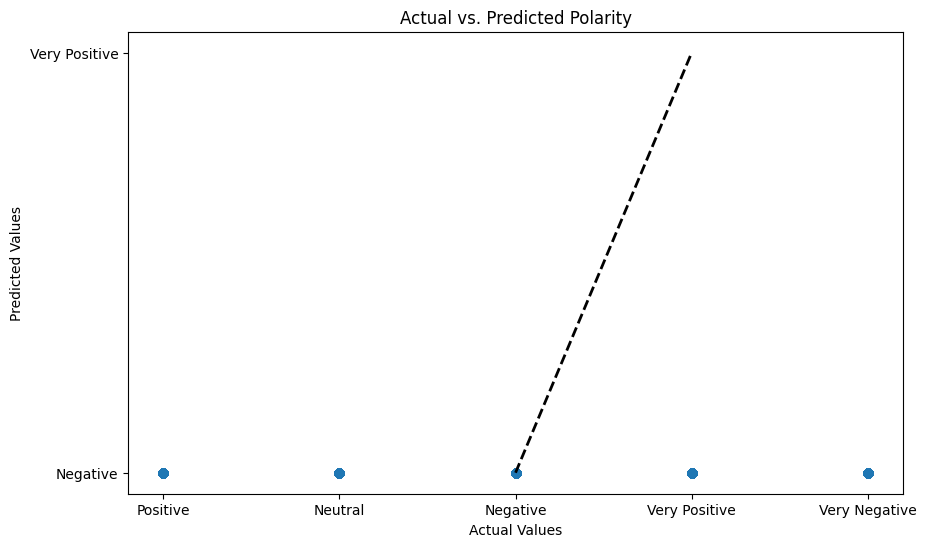

In [109]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw=2)  # Line for perfect predictions
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Polarity")
plt.show()

KeyError: 'Predicted_Polarity'

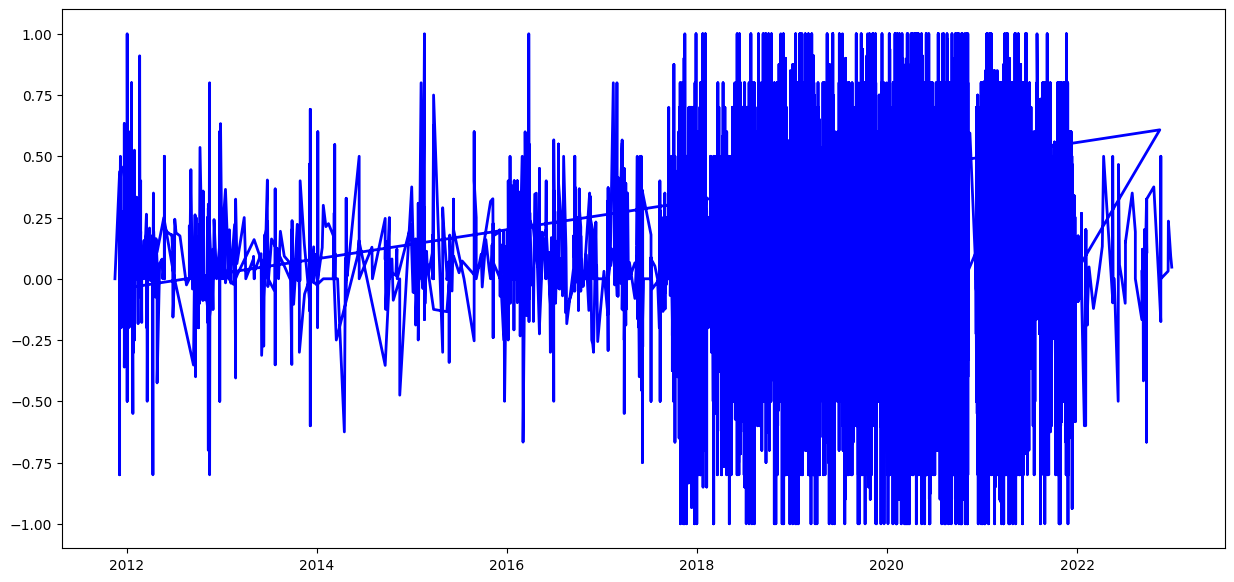

In [110]:
# Define events with their start and end dates
events = {
    # "Event name" : ("start date", "end date", "color for start", "color for end")
    "COVID-19 Pandemic": ("2020-03-01", "2021-03-01"),
    "Ukraine Conflict": ("2022-01-15", "2023-09-01"),
    "Biden Election Period": ("2020-11-01", "2022-01-01"),
    "Trump Election Period": ("2016-11-01", "2020-12-31"),
    "GTA 5 Release": ("2013-09-01", "2013-10-30"),
    "Snowden Leak": ("2013-06-01", "2013-07-01"),
    "Palestine": ("2023-10-01", "2024-05-01"),
    "Turkey Earthquake": ("2023-01-01", "2023-04-01"),
    "Arab Spring": ("2010-12-01", "2012-12-01")
}

df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Convert event dates to datetime
for event, (start, end) in events.items():
    events[event] = (pd.to_datetime(start), pd.to_datetime(end))

# Plotting
plt.figure(figsize=(15, 7))
plt.plot(df['Date'], df['Polarity'], label='Actual Polarity', color='blue', linewidth=2)
plt.plot(df['Date'], df['Predicted_Polarity'], label='Predicted Polarity', color='red', linestyle='--', alpha = 0.5)

# Overlay event periods
for event, (start, end) in events.items():
    plt.axvspan(start, end, color='yellow', alpha=0.3, label=f"{event} period")

plt.title('Event Impact on Sentiment Analysis')
plt.xlabel('Date')
plt.ylabel('Polarity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# ARIMA 2

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load your data
df = pd.read_csv("/Users/merterol/Desktop/UZH/CompLing:CompSci/CompSci/Sem2/ESC403/ESC403_Project/DataScienceProject/visuals/df_csv/CertifiedNews_df_merged.csv")
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

events = {
    "COVID-19 Pandemic Start": "2020-03-01",
    "Ukraine Conflict Start": "2022-01-15",
    "Biden Election Period Start": "2020-11-01",
    "Trump Election Period Start": "2016-11-01",
    "GTA 5 Release Start": "2013-09-01",
    "Snowden Leak Start": "2013-06-01",
    "Palestine Event Start": "2023-10-01",
    "Turkey Earthquake Start": "2023-01-01",
    "Arab Spring Start": "2010-12-01"
}

# Convert these dates to pandas Timestamp and create a binary column for each event
for event, event_date in events.items():
    df[event] = (df.index == pd.to_datetime(event_date)).astype(int)


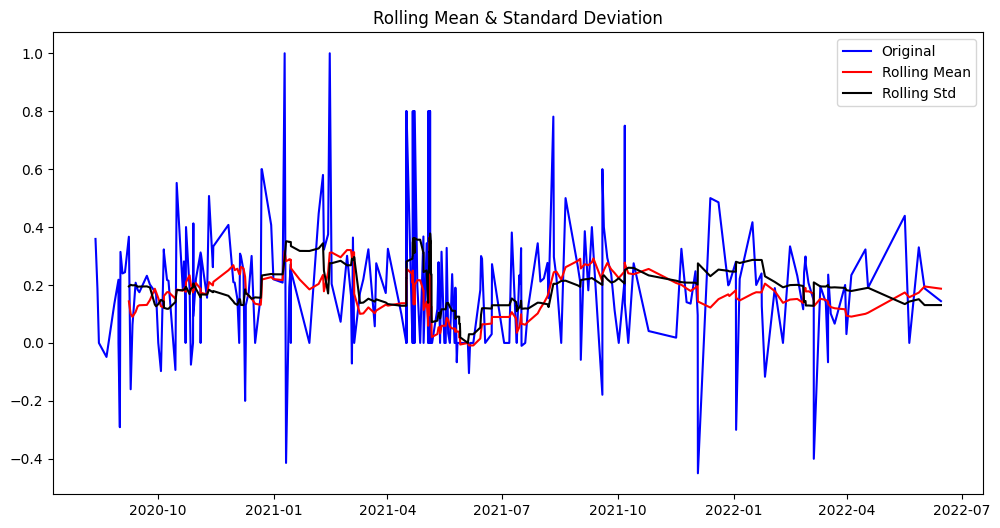

Results of Dickey-Fuller Test:
Test Statistic                  -4.776746
p-value                          0.000060
#Lags Used                       5.000000
Number of Observations Used    312.000000
Critical Value (1%)             -3.451484
Critical Value (5%)             -2.870849
Critical Value (10%)            -2.571730
dtype: float64


In [67]:
def test_stationarity(timeseries):
    # Rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()

    # Plot rolling statistics
    plt.figure(figsize=(12, 6))
    plt.plot(timeseries, color="blue", label="Original")
    plt.plot(rolling_mean, color="red", label="Rolling Mean")
    plt.plot(rolling_std, color="black", label="Rolling Std")
    plt.legend(loc="best")
    plt.title("Rolling Mean & Standard Deviation")
    plt.show()

    # Perform Dickey-Fuller test
    print("Results of Dickey-Fuller Test:")
    df_test = adfuller(timeseries, autolag="AIC")
    df_output = pd.Series(df_test[0:4], index=["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key, value in df_test[4].items():
        df_output["Critical Value (%s)" % key] = value
    print(df_output)

test_stationarity(df["Polarity"])


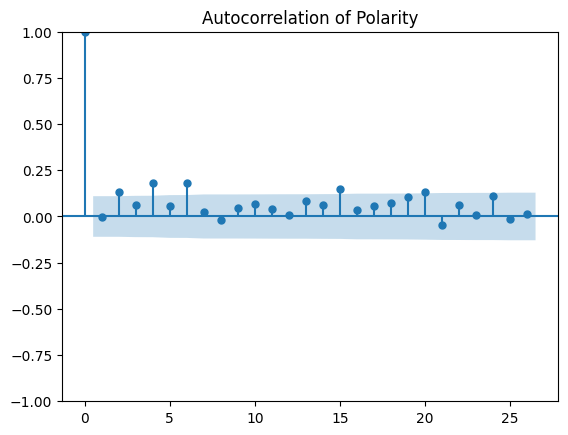

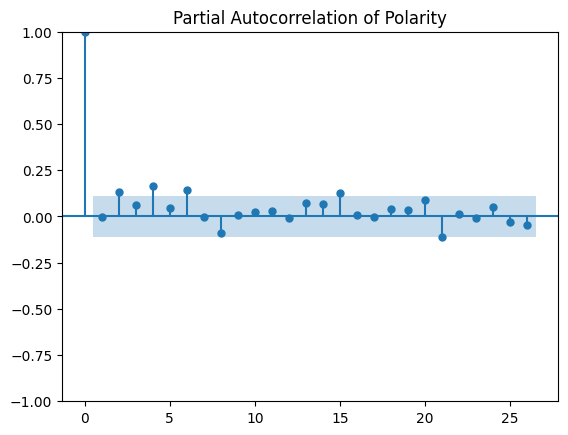

                               SARIMAX Results                                
Dep. Variable:               Polarity   No. Observations:                  318
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  36.867
Date:                Tue, 14 May 2024   AIC                            -47.733
Time:                        20:16:00   BIC                              1.173
Sample:                             0   HQIC                           -28.200
                                - 318                                         
Covariance Type:                  opg                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.1556      0.036      4.370      0.000       0.086       0.225
COVID-19 Pandemic Start              0   5.03e-17          0      1.000   -9.87e

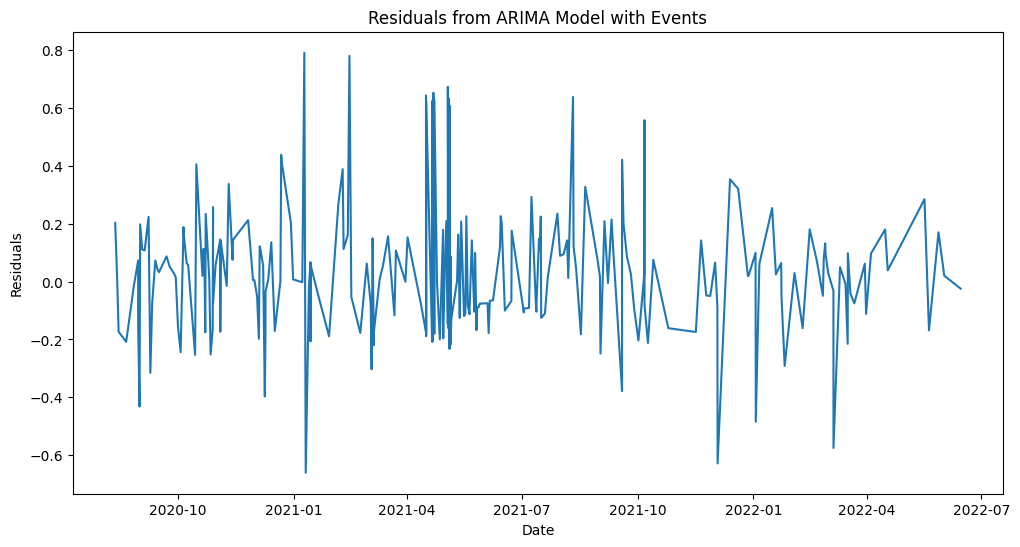

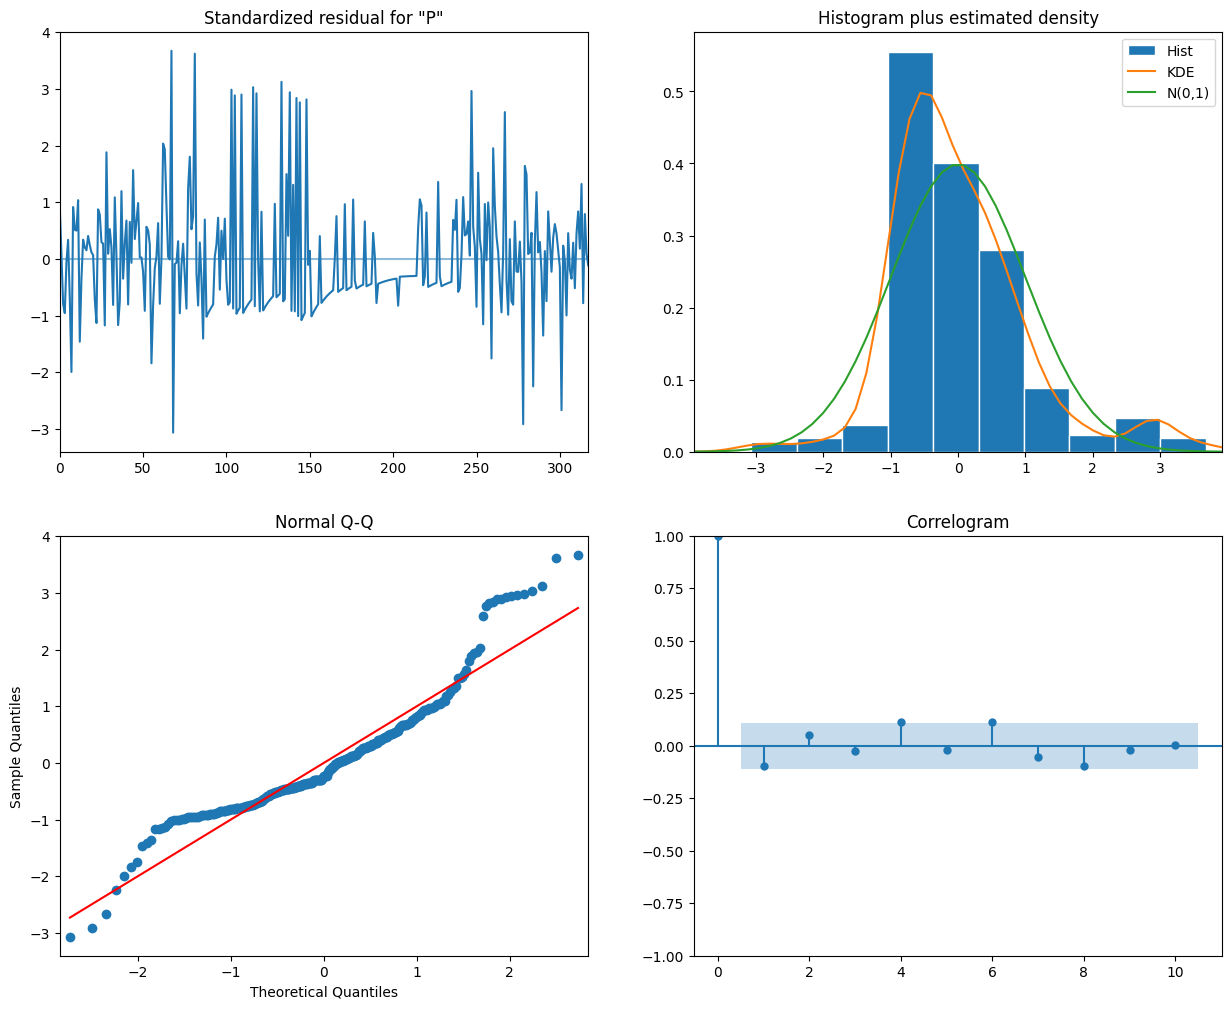

In [68]:
# Plot ACF and PACF
ts = df["Polarity"]

plot_acf(ts, title='Autocorrelation of Polarity')
plot_pacf(ts, title='Partial Autocorrelation of Polarity')
plt.show()


ts = df['Polarity']
exog = df[list(events.keys())]  # Exogenous variables

# Fit an ARIMA model with exogenous variables
model = ARIMA(ts, exog=exog, order=(1,0,1))  # Modify order based on your ACF and PACF analysis
results = model.fit()
print(results.summary())

residuals = results.resid
plt.figure(figsize=(12,6))
plt.plot(residuals)
plt.title("Residuals from ARIMA Model with Events")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.show()

results.plot_diagnostics(figsize=(15, 12))
plt.show()


Forecasted Polarity: 318     0.166854
319     0.166474
320     0.166106
321     0.165751
322     0.165408
          ...   
1313    0.155614
1314    0.155614
1315    0.155614
1316    0.155614
1317    0.155614
Name: predicted_mean, Length: 1000, dtype: float64


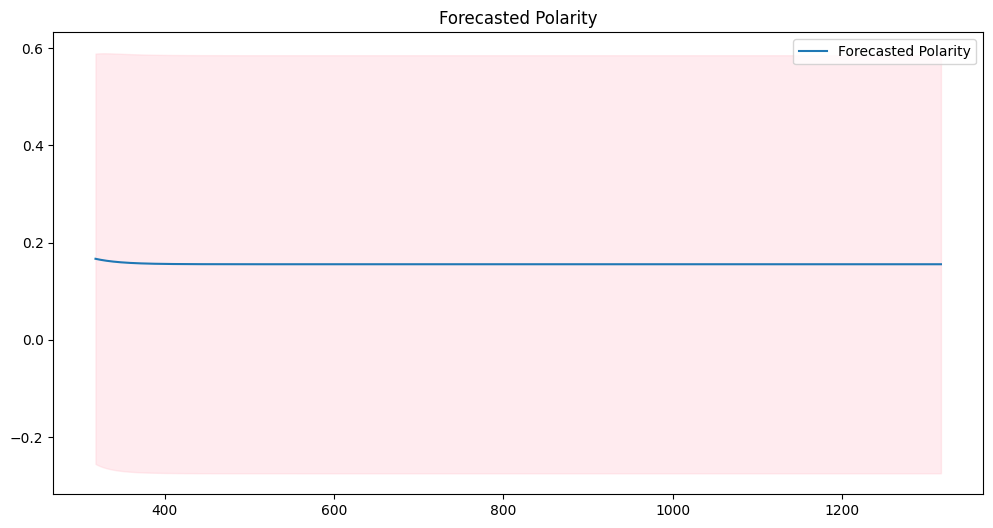

In [69]:
import numpy as np

#change this accordingly
steps = 1000
# Assuming 10 steps forecast and no future events occurring (all zeros)
exog_future = pd.DataFrame(0, index=np.arange(steps), columns=exog.columns)

# Forecast with the future exogenous variables
forecast = results.get_forecast(steps=steps, exog=exog_future)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Print the forecast and plot it
print("Forecasted Polarity:", forecast_mean)
plt.figure(figsize=(12, 6))
plt.plot(forecast_mean, label='Forecasted Polarity')
plt.fill_between(forecast_mean.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('Forecasted Polarity')
plt.show()
